# Expore data : strat 3
-  6 hours in 5mins units : used to predict next 1h15
- target_level = 0.45 %
- R = 2
- q0-q1 : 0.05-0.95  (selection feature cat)
- Model clustering or Best comb OR multi best comb: 
  - high precision: 39% 
  - max 1 trade per day

- df_cont : quantiles / prob data of features : [nb_features, nb quantiles data e.g. : q10 q90 n_unique]
- Feature category : e.g. "high" if feature value > quantile-90
- 1 event : (a feature, a lag, a category "low", "neutral" or "high") : all events => nb_events
- list_past_lag : selected time lag exponentially distributed : 7 values : -5min, -10min, -20min, -40min, -80min and -160min
- df_prob : prob/infos for each events about target category limited to list past lag : [nb_events, nb prob/info data]
- df_prob_comb : prob / infos for each 3-events-combined : [nb_comb_3_events, nb prob/info data]  
- df_combined_condition : true table of sekected 3-events-combined of each samples : [nb_samples (time), nb_comb_3_events]
  - selection of 1160 3-events-comb with p_min=0.333, and count_min = 1000


- Global TRAIN/TEST split : 99.5%/0.5% but not exploitable
- ML TRAIN/ ML TEST (from TRAIN split ) : 70%/30% (but not for Prob Mdls !)

In [1]:
7*108

756

## Import & definitions

In [2]:
import os
import hashlib
import sys
from pathlib import Path
import re
import random
import time
import math
import itertools
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()
#sns.set_theme("notebook")
#mpl.style.use('seaborn-v0_8-ticks')
# definitions
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
path_df_prob_comb = os.path.join(path_data, 'df_prob_comb.csv')
path_arr_corr_matrix_targets = os.path.join(
    path_data, 'arr_corr_matrix_targets.npy'
)
path_pca = os.path.join(path_data,"pca_model.pkl")
path_hash_pca = os.path.join(path_data, 'pca_hash.txt')

'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

In [3]:
(1+0.07)**5


1.4025517307000004

In [4]:
0.99*(1+0.06)**5

1.3248433218240003

In [5]:
(1+0.058)**5

1.3256483588367682

In [6]:
(1+0.14)**5


1.925414582400001

In [7]:
0.99*(1+0.13-0.01)**5

1.7447182663679992

In [8]:
(1+0.134)**5

1.875276333683423

In [9]:
PAST_HISTORY

72

In [10]:
21+9-24

6

In [11]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [12]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [13]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

<>:19: SyntaxWarning: invalid escape sequence '\.'
<>:19: SyntaxWarning: invalid escape sequence '\.'
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/2761487227.py:19: SyntaxWarning: invalid escape sequence '\.'
  title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)


In [14]:
# Helpers check update
def get_data_hash(data):
    data = str(data).encode('utf-8')
    return hashlib.sha256(data).hexdigest()

def load_hash(file_path):
    if not os.path.exists(file_path):
        return None
    with open(file_path, 'r') as file:
        data = file.read()
    return data

def check_hash_inputs(tuple_inputs, path_hash):
    hash_inputs = ""
    for curr_var in tuple_inputs:
        hash_inputs += get_data_hash(curr_var)

    # load old file hash
    hash_inputs_old = load_hash(path_hash)

    # compare hash
    if hash_inputs == hash_inputs_old:
        print("hash match: mode LOAD")
        return False, hash_inputs
    else:
        print("hash not match : mode REDO")
        return True, hash_inputs
    
def save_hash(path_hash, hash_inputs):
    with open(path_hash, 'w') as file:
            file.write(hash_inputs)


## Load raw features

In [15]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
# keep target untouched
df_feat_raw[f"{TARGET_NAME}_raw"] = df_feat_raw[TARGET_NAME]
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/2738736025.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0                  NaN  ...         NaN            NaN           NaN   
1                  NaN  ...         NaN            NaN           NaN   
2                  NaN  ...         NaN            NaN           NaN   
3                  NaN  ...         NaN            NaN           NaN   
4                  NaN  ...         NaN            NaN           NaN   
...                ...  ...         ...            ...           ...   
255033        2630.360  ...         NaN            NaN           NaN   
255034        2630.360  ...         NaN            NaN           NaN   
255035        2630.360  ...         NaN            NaN           NaN   
255036        2629.695  ...         NaN            NaN           NaN   
255037        2628.670  ...         NaN            NaN           NaN   

        delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                    NaN         0.0               NaN         0.0      0.0   
1                    NaN         0.0               NaN         0.0      0.0   
2                    NaN         0.0               NaN         0.0      0.0   
3                    NaN         0.0               NaN         0.0      0.0   
4                    NaN         0.0               NaN         0.0      0.0   
...                  ...         ...               ...         ...      ...   
255033               NaN         0.0               NaN         0.0      0.0   
255034               NaN         0.0               NaN         0.0      0.0   
255035               NaN         0.0               NaN         0.0      0.0   
255036               NaN         0.0               NaN         0.0      0.0   
255037               NaN         0.0               NaN         0.0      0.0   

        date  Close_ETH_raw  
0        NaN        1196.32  
1        NaN        1195.38  
2        NaN        1194.55  
3        NaN        1195.98  
4        NaN        1196.06  
...      ...            ...  
255033   NaN        2624.51  
255034   NaN        2624.26  
255035   NaN        2620.24  
255036   NaN        2616.73  
255037   NaN        2614.27  

[255038 rows x 136 columns]

### drop nan

In [16]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH             1
vwap_z_score_BTC             1
ichi_tenkan_ETH              8
ichi_tenkan_BTC              8
rsi_h_ETH                   13
max_high_h_ETH              13
min_low_h_BTC               13
max_high_h_BTC              13
min_low_h_ETH               13
rsi_h_BTC                   13
chop_h_BTC                  14
chop_h_ETH                  14
ichi_kijun_ETH              25
ichi_cloud_a_ETH            25
ichi_kijun_BTC              25
ichi_cloud_a_BTC            25
ichi_tenkan_day_BTC        215
ichi_tenkan_day_ETH        215
dxy                        264
min_low_d_BTC              335
max_high_d_ETH             335
rsi_d_BTC                  335
max_high_d_BTC             335
rsi_d_ETH                  335
chop_d_ETH                 335
chop_d_BTC                 335
min_low_d_ETH              335
ichi_kijun_day_ETH         623
ichi_cloud_a_day_BTC       623
ichi_cloud_a_day_ETH       623
ichi_kijun_day_BTC         623
fvx                    

#### Cheat Backward Filling

In [17]:
df_feat = df_feat_raw.copy()

In [18]:
df_feat = df_feat.bfill(axis ='rows')

In [19]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.710  ...         0.0            0.0           0.0   
1             1194.710  ...         0.0            0.0           0.0   
2             1194.710  ...         0.0            0.0           0.0   
3             1194.710  ...         0.0            0.0           0.0   
4             1194.710  ...         0.0            0.0           0.0   
...                ...  ...         ...            ...           ...   
255033        2630.360  ...         NaN            NaN           NaN   
255034        2630.360  ...         NaN            NaN           NaN   
255035        2630.360  ...         NaN            NaN           NaN   
255036        2629.695  ...         NaN            NaN           NaN   
255037        2628.670  ...         NaN            NaN           NaN   

        delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                    0.0         0.0               0.0         0.0      0.0   
1                    0.0         0.0               0.0         0.0      0.0   
2                    0.0         0.0               0.0         0.0      0.0   
3                    0.0         0.0               0.0         0.0      0.0   
4                    0.0         0.0               0.0         0.0      0.0   
...                  ...         ...               ...         ...      ...   
255033               NaN         0.0               NaN         0.0      0.0   
255034               NaN         0.0               NaN         0.0      0.0   
255035               NaN         0.0               NaN         0.0      0.0   
255036               NaN         0.0               NaN         0.0      0.0   
255037               NaN         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  
0       2023-01-02 05:00:00        1196.32  
1       2023-01-02 05:00:00        1195.38  
2       2023-01-02 05:00:00        1194.55  
3       2023-01-02 05:00:00        1195.98  
4       2023-01-02 05:00:00        1196.06  
...                     ...            ...  
255033                  NaN        2624.51  
255034                  NaN        2624.26  
255035                  NaN        2620.24  
255036                 

In [20]:
df_feat["date_ETH"].value_counts()

date_ETH
2024-12-12 13:00:00    2
2023-01-01 00:00:00    1
2024-08-13 09:15:00    1
2024-08-13 08:10:00    1
2024-08-13 08:15:00    1
                      ..
2023-10-23 04:45:00    1
2023-10-23 04:50:00    1
2023-10-23 04:55:00    1
2023-10-23 05:00:00    1
2025-06-04 13:00:00    1
Name: count, Length: 255037, dtype: int64

In [21]:
nb_missing = get_missing(df_feat)

missing data : 
date                2688
delta_event_real    2688
delta_event_pred    2688
Previous_num        2688
Consensus_num       2688
keep                2688
Date                2688
Previous            2688
Consensus           2688
Event               2688
Country             2688
Time (ET)           2688
Actual_num          2688
Actual              2688
dtype: int64

on 255038 samples


In [22]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [23]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [24]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'Close_ETH_raw']

In [25]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0        1196.13   1196.32  1195.65    1196.32    334.5592   
1        1196.31   1196.69  1194.90    1195.38    682.3876   
2        1195.38   1195.81  1194.55    1194.55    228.9387   
3        1194.55   1195.98  1194.31    1195.98    601.8903   
4        1195.98   1196.37  1195.97    1196.06    144.8048   
...          ...       ...      ...        ...         ...   
255033   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034   2624.50   2626.90  2623.30    2624.26    977.3830   
255035   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ichi_tenkan_ETH  ...  vwap_3m_ETH  vwap_6m_ETH  \
0             1194.710         1194.710  ...  1196.096667  1196.096667   
1             1194.710         1194.710  ...  1195.801420  1195.801420   
2             1194.710         1194.710  ...  1195.648641  1195.648641   
3             1194.710         1194.710  ...  1195.575250  1195.575250   
4             1194.710         1194.710  ...  1195.615807  1195.615807   
...                ...              ...  ...          ...          ...   
255033        2630.360         2627.260  ...  2215.946820  2112.080395   
255034        2630.360         2627.260  ...  2215.970478  2112.079173   
255035        2630.360         2627.260  ...  2216.016378  2112.083189   
255036        2629.695         2624.810  ...  2216.072494  2112.088060   
255037        2628.670         2620.525  ...  2216.123423  2112.097985   

         vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH    supply_ETH  \
0       1196.096667   1196.096667         -0.634018  0.000187  1.205290e+08   
1       1195.801420   1195.801420         -0.634018 -0.000353  1.205290e+08   
2       1195.648641   1195.648641         -1.240604 -0.000920  1.205290e+08   
3       1195.575250   1195.575250          0.521593  0.000338  1.205290e+08   
4       1195.615807   1195.615807          0.626856  0.000371  1.205290e+08   
...             ...           ...               ...       ...           ...   
255033  2465.963959   2449.429165          0.244601  0.066710  1.207159e+08   
255034  2465.992103   2449.429616          0.244251  0.066621  1.207159e+08   
255035  2466.034614   2449.430717          0.238634  0.065188  1.207159e+08   
255036  2466.071410   2449.431688          0.233729  0.063934  1.207159e+08   
255037  2466.111540   2449.432810          0.230291  0.063053  1.207159e+08   

        act_addr_ETH  market_dom_ETH  Close_ETH_raw  
0             522460       17.409118        1196.32  
1             522460       17.409118        1195.38  
2             522460       17.409118        1194.55  
3             522460       17.409118        1195.98  
4             522460       17.409118        1196.06  
...              ...             ...            ...  
255033        587140        9.110644        2624.51  
255034        587140        9.110644        2624.26  
255035        587140        9.110644        2620.24  
255036        587140        9.110644        2616.73  
255037        587140      

In [26]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
    'atr_h_ETH',
    'atr_d_ETH',
    'atr_w_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [27]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [28]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'atr_h_BTC',
    'atr_d_BTC',
    'atr_w_BTC',
]

In [29]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [30]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [31]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0       3.910  3823.179932  103.494003
1       3.910  3823.179932  103.494003
2       3.910  3823.179932  103.494003
3       3.910  3823.179932  103.494003
4       3.910  3823.179932  103.494003
...       ...          ...         ...
255033  3.979  5970.529785   98.964996
255034  3.979  5970.529785   98.964996
255035  3.979  5970.529785   98.964996
255036  3.979  5970.529785   98.964996
255037  3.979  5970.529785   98.956001

[255038 rows x 3 columns]

In [32]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [33]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Close_ETH_raw',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_BTC',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [34]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'vwap_z_score_BTC',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [35]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other +
    [f"{TARGET_NAME}_raw"]
)

# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  109


In [36]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [37]:
get_missing(df_feat.filter(list_col_select))

missing data : 
Series([], dtype: int64)

on 255038 samples


Series([], dtype: int64)

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [38]:
df_feat.shape[0]

255038

In [39]:
TRAIN_SPLIT_RATIO

0.995

In [40]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

253763

In [41]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
0             1194.710  ...            0.0           0.0               0.0   
1             1194.710  ...            0.0           0.0               0.0   
2             1194.710  ...            0.0           0.0               0.0   
3             1194.710  ...            0.0           0.0               0.0   
4             1194.710  ...            0.0           0.0               0.0   
...                ...  ...            ...           ...               ...   
255033        2630.360  ...            NaN           NaN               NaN   
255034        2630.360  ...            NaN           NaN               NaN   
255035        2630.360  ...            NaN           NaN               NaN   
255036        2629.695  ...            NaN           NaN               NaN   
255037        2628.670  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  \
0              0.0               0.0         0.0      0.0   
1              0.0               0.0         0.0      0.0   
2              0.0               0.0         0.0      0.0   
3              0.0               0.0         0.0      0.0   
4              0.0               0.0         0.0      0.0   
...            ...               ...         ...      ...   
255033         0.0               NaN         0.0      0.0   
255034         0.0               NaN         0.0      0.0   
255035         0.0               NaN         0.0      0.0   
255036         0.0               NaN         0.0      0.0   
255037         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  train  
0       2023-01-02 05:00:00        1196.32   True  
1       2023-01-02 05:00:00        1195.38   True  
2       2023-01-02 05:00:00        1194.55   True  
3       2023-01-02 05:00:00        1195.98   True  
4       2023-01-02 05:00:00        1196.06   True  
...                     ...            ...    ...  
255033                  NaN        2624.51  False  
255034                  NaN        2624.26  False  
255035                  NaN        2620.24  False  
255036                  NaN        2616.73  False  
255037                  NaN        2614.27  F

In [42]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
253759  1748658600000   2504.91   2505.00  2492.22    2495.20   4235.1902   
253760  1748658900000   2495.21   2503.27  2494.44    2502.12   2576.0733   
253761  1748659200000   2502.11   2502.60  2498.13    2498.60   1382.7143   
253762  1748659500000   2498.60   2500.40  2496.37    2498.75   1450.5001   
253763  1748659800000   2498.75   2502.00  2485.40    2492.50   3607.3172   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
253759  2025-05-31 02:30:00       2528.067500       2546.470000   
253760  2025-05-31 02:35:00       2526.930000       2546.470000   
253761  2025-05-31 02:40:00       2525.150000       2546.470000   
253762  2025-05-31 02:45:00       2525.150000       2546.470000   
253763  2025-05-31 02:50:00       2524.310000       2546.470000   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
0              1194.71  ...            0.0           0.0               0.0   
1              1194.71  ...            0.0           0.0               0.0   
2              1194.71  ...            0.0           0.0               0.0   
3              1194.71  ...            0.0           0.0               0.0   
4              1194.71  ...            0.0           0.0               0.0   
...                ...  ...            ...           ...               ...   
253759         2505.22  ...            NaN           NaN               NaN   
253760         2505.22  ...            NaN           NaN               NaN   
253761         2505.22  ...            NaN           NaN               NaN   
253762         2505.22  ...            NaN           NaN               NaN   
253763         2505.22  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  \
0              0.0               0.0         0.0      0.0   
1              0.0               0.0         0.0      0.0   
2              0.0               0.0         0.0      0.0   
3              0.0               0.0         0.0      0.0   
4              0.0               0.0         0.0      0.0   
...            ...               ...         ...      ...   
253759         0.0               NaN         0.0      0.0   
253760         0.0               NaN         0.0      0.0   
253761         0.0               NaN         0.0      0.0   
253762         0.0               NaN         0.0      0.0   
253763         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  train  
0       2023-01-02 05:00:00        1196.32   True  
1       2023-01-02 05:00:00        1195.38   True  
2       2023-01-02 05:00:00        1194.55   True  
3       2023-01-02 05:00:00        1195.98   True  
4       2023-01-02 05:00:00        1196.06   True  
...                     ...            ...    ...  
253759                  NaN        2495.20   True  
253760                  NaN        2502.12   True  
253761                  NaN        2498.60   True  
253762                  NaN        2498.75   True  
253763                  NaN        2492.50   

In [43]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
253764  1748660100000   2492.49   2493.17  2487.12    2490.22   2272.6386   
253765  1748660400000   2490.21   2496.84  2489.04    2491.71   1715.3111   
253766  1748660700000   2491.71   2496.80  2485.23    2490.01   1743.7758   
253767  1748661000000   2490.00   2496.59  2488.06    2496.04   1652.4027   
253768  1748661300000   2496.04   2499.85  2486.99    2490.40   2457.9952   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
253764  2025-05-31 02:55:00         2523.4350          2546.470   
253765  2025-05-31 03:00:00         2521.7675          2546.470   
253766  2025-05-31 03:05:00         2521.5525          2546.470   
253767  2025-05-31 03:10:00         2521.3800          2546.470   
253768  2025-05-31 03:15:00         2521.8325          2544.585   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00         2641.5250          2635.690   
255034  2025-06-04 12:45:00         2641.5250          2635.690   
255035  2025-06-04 12:50:00         2641.3500          2636.225   
255036  2025-06-04 12:55:00         2641.3500          2636.225   
255037  2025-06-04 13:00:00         2641.3500          2636.225   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
253764        2501.755  ...            NaN           NaN               NaN   
253765        2501.600  ...            NaN           NaN               NaN   
253766        2501.600  ...            NaN           NaN               NaN   
253767        2501.600  ...            NaN           NaN               NaN   
253768        2501.600  ...            NaN           NaN               NaN   
...                ...  ...            ...           ...               ...   
255033        2630.360  ...            NaN           NaN               NaN   
255034        2630.360  ...            NaN           NaN               NaN   
255035        2630.360  ...            NaN           NaN               NaN   
255036        2629.695  ...            NaN           NaN               NaN   
255037        2628.670  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  date  \
253764         0.0               NaN         0.0      0.0   NaN   
253765         0.0               NaN         0.0      0.0   NaN   
253766         0.0               NaN         0.0      0.0   NaN   
253767         0.0               NaN         0.0      0.0   NaN   
253768         0.0               NaN         0.0      0.0   NaN   
...            ...               ...         ...      ...   ...   
255033         0.0               NaN         0.0      0.0   NaN   
255034         0.0               NaN         0.0      0.0   NaN   
255035         0.0               NaN         0.0      0.0   NaN   
255036         0.0               NaN         0.0      0.0   NaN   
255037         0.0               NaN         0.0      0.0   NaN   

        Close_ETH_raw  train  
253764        2490.22  False  
253765        2491.71  False  
253766        2490.01  False  
253767        2496.04  False  
253768        2490.40  False  
...               ...    ...  
255033        2624.51  False  
255034        2624.26  False  
255035        2620.24  False  
255036        2616.73  False  
255037        2614.27  False  

[1274 rows x 137 columns]

In [44]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):
    # Close ETH need to be in first place
    # we divide by close ETH price all price dependent features except the first Close ETH
    # in a matrix
    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                p_close = out_matrix[-1, 0] # last past history lag, first feature = Close ETH
                # scaling : price dependent features divide by Close ETH 
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / p_close
                )
                # keep Price Close with no scaling
                #out_matrix[-1, 0] = p_close
                
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False, price_label=None):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    if price_label:
        price_matrix = id_df[price_label].values

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            if price_label:
                out_matrix = out_matrix / price_matrix[start-1, 0]
            else:
                out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [45]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [46]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [47]:
df_feat[df_feat["train"] == True].shape[0]

253764

In [48]:
df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET

253677

In [49]:
n_feat = df_feat.loc[df_feat["train"] == True, list_col_select].shape[1]
n_feat

109

In [50]:
# create X_train on disk
#filename = os.path.join(path_data, 'X_train.dat')
#print(filename)
X_train_dat = np.memmap(
    path_X_train, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [51]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [52]:
X_test = []
y_train, y_test = [], []
y_high_train, y_high_test = [], []
y_low_train, y_low_test = [], []


for is_train, _df in df_feat.groupby("train"):

    for index, seq in enumerate(gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        )):
        if is_train:
            # don't use append here but assign to X_train_dat
            X_train_dat[index] = seq # PAST_HISTORY * n_feat
            #X_train.append(seq)
        else:
            X_test.append(seq)
        
        #index += 1
    if is_train:
        X_train_dat.flush()

    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['High_ETH'], divide_price=True, 
                            price_label=['Close_ETH']):

        if is_train:
            y_high_train.append(seq_y)
        else:
            y_high_test.append(seq_y) 

    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Low_ETH'], divide_price=True, 
                            price_label=['Close_ETH']):

        if is_train:
            y_low_train.append(seq_y)
        else:
            y_low_test.append(seq_y) 

#X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

y_high_train = np.array(y_high_train)
y_high_test = np.array(y_high_test)

y_low_train = np.array(y_low_train)
y_low_test = np.array(y_low_test)

#print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1187, 72, 109) (1187, 15)


In [53]:
y_high_train


array([[1.0004688 , 1.00057763, 1.00039346, ..., 1.00053577, 1.00031811,
        1.00015069],
       [1.00011715, 0.99993306, 0.99985775, ..., 0.99985775, 0.9996904 ,
        0.99939753],
       [1.00000837, 0.99993305, 0.99990795, ..., 0.99976569, 0.9994728 ,
        0.99888703],
       ...,
       [1.00032244, 1.00085587, 0.99619436, ..., 0.99997612, 0.99718956,
        0.99650088],
       [1.00202461, 0.99735765, 0.99579137, ..., 0.99835401, 0.99766453,
        0.9973975 ],
       [1.00944705, 1.00786179, 1.00779321, ..., 1.00975765, 1.00948739,
        1.00859996]], shape=(253677, 15))

In [54]:
assert df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]


In [55]:
assert df_feat["High_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_high_train[0,0]


In [56]:
assert df_feat["Low_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_low_train[0,0]


In [57]:
X_train_dat.shape

(253677, 72, 109)

In [58]:
X_train_dat[0,:,:].shape

(72, 109)

Close_ETH normalized by Close_ETH at last lag of the past history

In [59]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

In [60]:
list_col_select[1]

'Open_ETH'

In [61]:
X_train_dat[0,:,1]

memmap([1.0013311 , 1.0014818 , 1.0007032 , 1.0000083 , 1.0012054 ,
        1.0012724 , 1.0017413 , 0.99985766, 0.99973214, 0.9992466 ,
        1.000092  , 1.0002344 , 0.9996233 , 0.99964005, 1.0009711 ,
        1.0007032 , 1.0006949 , 1.0008874 , 1.0007617 , 1.0005022 ,
        1.000159  , 1.0003182 , 1.0008371 , 1.0006781 , 1.0012306 ,
        0.99972373, 0.9998493 , 1.0005609 , 1.0006614 , 1.0007032 ,
        1.0013311 , 1.0018417 , 1.0011386 , 1.0006195 , 1.0009376 ,
        1.0007617 , 1.0007284 , 0.99878615, 0.99918795, 0.99886984,
        0.9978318 , 0.99904567, 0.99903727, 0.99904567, 0.9994391 ,
        0.99954796, 0.99957305, 0.99986607, 0.9995898 , 0.9993721 ,
        0.998535  , 0.99840105, 0.9983006 , 0.99802434, 0.99802434,
        0.9980746 , 0.998602  , 0.99789876, 0.9980997 , 0.99825037,
        0.9986438 , 0.9990038 , 0.9988364 , 0.9989536 , 0.99891174,
        0.9991796 , 0.999707  , 0.9995228 , 0.99922985, 0.9996233 ,
        0.9998409 , 0.9997823 ], dtype=float32)

Close_ETH_raw

In [62]:
list_col_select[-1]

'Close_ETH_raw'

In [63]:
X_train_dat[0,:,-1]

memmap([1196.32, 1195.38, 1194.55, 1195.98, 1196.06, 1196.61, 1194.36,
        1194.22, 1193.64, 1194.64, 1194.82, 1194.09, 1194.1 , 1195.69,
        1195.38, 1195.38, 1195.6 , 1195.45, 1195.14, 1194.73, 1194.92,
        1195.53, 1195.35, 1196.02, 1194.21, 1194.37, 1195.22, 1195.33,
        1195.38, 1196.12, 1196.74, 1195.9 , 1195.27, 1195.66, 1195.45,
        1195.4 , 1193.09, 1193.57, 1193.2 , 1191.95, 1193.39, 1193.38,
        1193.41, 1193.86, 1194.  , 1194.04, 1194.39, 1194.04, 1193.79,
        1192.8 , 1192.64, 1192.51, 1192.18, 1192.18, 1192.25, 1192.87,
        1192.04, 1192.26, 1192.44, 1192.92, 1193.35, 1193.15, 1193.29,
        1193.25, 1193.57, 1194.18, 1193.96, 1193.61, 1194.1 , 1194.34,
        1194.27, 1194.54], dtype=float32)

## Standardization

In [64]:
# check if new  data in df_feat
# hash input
hash_df_feat = get_data_hash(df_feat)
# load df_prob file hash
path_feat_hash = os.path.join(path_data, 'df_feat_hash.txt')
# hash df_prob data
hash_df_feat_old = load_hash(path_feat_hash)

# compare hash
if hash_df_feat == hash_df_feat_old:
    print("hash match: mode LOAD rescaling")
    mode_rescale = False
else:
    print("hash not match : mode REDO rescaling")
    mode_rescale = True


hash match: mode LOAD rescaling


In [65]:
#mode_rescale = True

In [66]:
path_scaler

'data/scaler.bin'

In [67]:
X_train_sca_dat = np.memmap(
    path_X_train_sca, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [68]:
list_col_select_global

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [69]:
# Peak memory : 17Gb !
# need to rescale minmax for some entries
list_min_max = ['day_off',
 'event_pred',
 'event_real']

if mode_rescale:
    scaler = StandardScaler()
    scaler.fit(X_train_dat.reshape(-1,X_train_dat.shape[-1]))
    for col in list_min_max:
        i_col = list_col_select.index(col)
        scaler.scale_[i_col] = 1
        scaler.mean_[i_col] = 0
    #X_train_sca_dat[:] = scaler.fit_transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)

    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
    # save hash
    with open(path_feat_hash, 'w') as file:
        file.write(hash_df_feat)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [70]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99883363, 0.98687133, 0.99429154, ..., 0.99716965, 0.99328838,
        0.99604309],
       [0.98802374, 0.99545261, 0.99552833, ..., 0.99444827, 0.9972062 ,
        0.99580333],
       [1.00751892, 1.00759556, 1.00489698, ..., 1.00929377, 1.00787389,
        1.0079344 ]], shape=(253677, 15))

In [71]:
np.mean(y_train_sca)

np.float64(-6.796516874623723e-14)

In [72]:
np.std(y_train_sca)

np.float64(1.0)

In [73]:
np.mean(y_test_sca)

np.float64(0.04559068417215605)

In [74]:
np.std(y_test_sca)

np.float64(0.7247543709407388)

In [75]:
scaler.scale_

array([1.11758415e-02, 1.13341565e-02, 1.12647813e-02, 1.12758084e-02,
       1.58659704e-02, 1.69234305e-02, 1.21560721e-02, 1.15278091e-02,
       7.03027864e-02, 7.55225456e-02, 2.51978066e-02, 1.78609548e-02,
       1.79899755e-01, 1.86481614e-01, 6.00531676e-02, 3.71399331e-02,
       1.23344466e-02, 1.24286029e-02, 2.63323536e-02, 2.63300194e-02,
       6.16530272e-02, 5.58715498e-02, 1.16466161e-02, 1.19718808e-02,
       1.62849751e-02, 6.55955514e-02, 1.22452620e-01, 1.82853823e-01,
       8.65035270e-02, 1.98142910e-01, 2.17634523e-03, 1.35787848e-03,
       1.07704011e-03, 9.58206494e+00, 9.59168327e+00, 9.57255368e+00,
       9.58205875e+00, 9.58213332e+00, 9.58036073e+00, 9.58100748e+00,
       9.58197494e+00, 9.62146355e+00, 9.59714636e+00, 9.55135518e+00,
       9.57274515e+00, 9.94294768e+00, 1.00965276e+01, 9.41614582e+00,
       9.52746475e+00, 9.62102516e+00, 9.54307203e+00, 9.77353007e+00,
       9.36669447e+00, 1.00480262e+01, 8.98767280e+00, 9.58182442e+00,
      

In [76]:
scaler.scale_.shape

(109,)

In [77]:
scaler.scale_[-4:]

array([  1.        ,   1.        ,   1.        , 717.47630208])

In [78]:
scaler.mean_[-4:]

array([   0.        ,    0.        ,    0.        , 2419.09062826])

In [79]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

### Check unscaling

In [80]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       2419.198618       2418.400385   
1    1195.38   1196.31   1196.69  1194.90       2419.198618       2418.400385   
2    1194.55   1195.38   1195.81  1194.55       2419.198618       2418.400385   
3    1195.98   1194.55   1195.98  1194.31       2419.198618       2418.400385   
4    1196.06   1195.98   1196.37  1195.97       2419.198618       2418.400385   
5    1196.61   1196.06   1196.70  1196.06       2419.198618       2418.400385   
6    1194.36   1196.62   1196.62  1193.72       2419.198618       2418.400385   
7    1194.22   1194.37   1194.43  1192.72       2419.198618       2418.400385   
8    1193.64   1194.22   1194.22  1193.02       2419.198618       2418.400385   
9    1194.64   1193.64   1195.06  1193.63       2419.198618       2418.400385   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           2418.060398   
1         1194.71          1194.71           2418.060398   
2         1194.71          1194.71           2418.060398   
3         1194.71          1194.71           2418.060398   
4         1194.71          1194.71           2418.060398   
5         1194.71          1194.71           2418.060398   
6         1194.71          1194.71           2418.060398   
7         1194.71          1194.71           2418.060398   
8         1194.71          1194.71           2418.060398   
9         1194.71          1194.71           2418.060398   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
1           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
2           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
3           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
4           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
5           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
6           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
7           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
8           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
9           2410.350542  ...       1.0       0.0      0.62349    -0.781831   

   day_in_month_cos  day_in_month_sin  day_off  event_pred  event_real  \
0           0.97953          0.201299      0.0         0.0         0.0   
1           0.97953          0.201299      0.0         0.0         0.0   
2           0.97953          0.201299      0.0         0.0         0.0   
3           0.97953          0.201299      0.0         0.0         0.0   
4           0.97953          0.201299      0.0         0.0         0.0   
5           0.97953          0.201299      0.0         0.0         0.0   
6           0.97953          0.201299      0.0         0.0         0.0   
7           0.97953          0.201299      0.0         0.0         0.0   
8           0.97953          0.201299      0.0         0.0         0.0   
9           0.97953          0.201299      0.0         0.0         0.0   

   Close_ETH_raw  
0        1196.32  
1        1195.38  
2        1194.55  
3        1195.98  
4        1196.06  
5        1196.61  
6        1194.36  
7        1194.22  
8        1193.64  
9        1194.64  

[10 rows x 109 columns]

In [81]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [82]:
X_train_sca_dat.shape

(253677, 72, 109)

In [83]:
np.testing.assert_array_almost_equal(
    scaler.inverse_transform(X_train_sca_dat[-1,-1,:].reshape(1,-1)).squeeze(),
    X_train_dat[-1,-1,:],
    decimal=5)

## Check Inputs TRAIN/TEST 

In [84]:
X_train_sca_dat[:,-1,:].shape

(253677, 109)

In [85]:
X_test[:,-1,:].shape

(1187, 109)

In [86]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca_dat[:,-1,:], np.ones((X_train_sca_dat.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0        0.003863 -0.015292 -0.082240  0.083241         -0.036673   
1        0.003863 -0.035954 -0.091161  0.062472         -0.061043   
2        0.003863  0.011297 -0.074811  0.089183         -0.056302   
3        0.003863  0.071889 -0.023508  0.094373         -0.005289   
4        0.003863 -0.055159 -0.089669  0.043907         -0.036263   
...           ...       ...       ...       ...               ...   
254859   0.003863  0.092026  0.079341  0.068936          0.105432   
254860   0.003863  0.026366 -0.069311 -0.016969          0.103060   
254861   0.003863  0.165733  0.070914  0.052666          0.199633   
254862   0.003863 -0.100039 -0.052764 -0.069291          0.124916   
254863   0.003863  0.066329  0.012765  0.091143          0.173177   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.012806       -0.107057        -0.032204   
1              -0.014380       -0.130058        -0.056495   
2              -0.009936       -0.119399        -0.031097   
3               0.035065       -0.056818         0.034977   
4              -0.004498       -0.111838        -0.023114   
...                  ...             ...              ...   
254859          0.010549        0.232271         0.185398   
254860          0.025358        0.237947         0.154305   
254861          0.133503        0.346017         0.268111   
254862          0.063534        0.240429         0.156868   
254863          0.105586        0.299091         0.218666   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_sin  \
0                  14.569584             13.496038  ...  1.365978   
1                  14.556331             13.483742  ...  1.414164   
2                  14.558501             13.485753  ...  1.414164   
3                  14.580433             13.506105  ...  1.414164   
4                  14.561150             13.488213  ...  1.414164   
...                      ...                   ...  ...       ...   
254859             -0.653008             -0.006914  ...  0.366028   
254860             -0.649606             -0.003601  ...  0.366028   
254861             -0.624761              0.020592  ...  0.366028   
254862             -0.640835              0.004939  ...  0.366028   
254863             -0.631175              0.014347  ...  0.366028   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
0          0.880986    -1.107987          1.388078          0.284506      0.0   
1          0.880986    -1.107987          1.388078          0.284506      0.0   
2          0.880986    -1.107987          1.388078          0.284506      0.0   
3          0.880986    -1.107987          1.388078          0.284506      0.0   
4          0.880986    -1.107987          1.388078          0.284506      0.0   
...             ...          ...               ...               ...      ...   
254859    -0.314856     1.377693          0.948816          1.050286      0.0   
254860    -0.314856     1.377693          0.948816          1.050286      0.0   
254861    -0.314856     1.377693          0.948816          1.050286      0.0   
254862    -0.314856     1.377693          0.948816          1.050286      0.0   
254863    -0.314856     1.377693          0.948816          1.050286      0.0   

        event_pred  event_real  Close_ETH_raw  TRAIN  
0              0.0         0.0      -1.706747    1.0  
1              0.0         0.0      -1.705981    1.0  
2              0.0         0.0      -1.706106    1.0  
3              0.0         0.0      -1.707374    1.0  
4              0.0         0.0      -1.706259    1.0  
...            ...         ...            ...    ...  
254859         0.0         0.0       0.298796    0.0  
254860         0.0         0.0       0.297877    0.0  
254861         0.0         0.0       0.291173    0.0  
254862         0.0         0.0       0.295507    0.0  
254863         0.0         0.0       0.

In [87]:
df["event_real"].mean()

np.float64(1.9618306233912988e-05)

In [88]:
df["event_real"].std()

np.float64(0.0138657769553898)

#### SAve

In [89]:
df.to_csv(path_save_df_feat_std, index=False)

In [90]:
df[df["TRAIN"] == 1].describe()

Close_ETH       Open_ETH       High_ETH        Low_ETH  \
count  253677.000000  253677.000000  253677.000000  253677.000000   
mean        0.003863       0.003819       0.003891       0.003781   
std         0.000000       0.166514       0.128898       0.131373   
min         0.003863      -5.116099      -0.091902      -7.984509   
25%         0.003863      -0.063221      -0.071034      -0.026482   
50%         0.003863       0.003550      -0.031963       0.040080   
75%         0.003863       0.069218       0.033532       0.080344   
max         0.003863       8.303201       8.434505       0.103286   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count     253677.000000     253677.000000   253677.000000    253677.000000   
mean           0.001458          0.001317        0.003542         0.003754   
std            0.638363          0.688512        0.380625         0.242701   
min           -7.300909         -6.986154       -6.596560        -5.580196   
25%           -0.247243         -0.277757       -0.161263        -0.101731   
50%           -0.001877          0.003434        0.009087         0.006637   
75%            0.237180          0.268948        0.172205         0.112400   
max           13.391198         13.445843        6.113667         5.187875   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...       hour_sin  \
count         253677.000000         253677.000000  ...  253677.000000   
mean              -0.001363             -0.001268  ...      -0.000186   
std                0.972563              0.976705  ...       0.999941   
min               -3.855338             -3.569981  ...      -1.414124   
25%               -0.399892             -0.440495  ...      -0.999931   
50%               -0.040914             -0.036834  ...       0.000020   
75%                0.285727              0.346492  ...       0.999971   
max               14.599020             13.523352  ...       1.414164   

         weekday_cos    weekday_sin  day_in_month_cos  day_in_month_sin  \
count  253677.000000  253677.000000     253677.000000     253677.000000   
mean       -0.000240       0.000020          0.000002         -0.000061   
std         1.000012       0.999992          1.000005          0.999999   
min        -1.273847      -1.381204         -1.413257         -1.413265   
25%        -1.273847      -1.107987         -1.025499         -1.024320   
50%        -0.314856      -0.001755         -0.069782          0.000015   
75%         0.880986       1.104476          0.976888          1.024350   
max         1.413185       1.377693          1.417047          1.413294   

             day_off     event_pred     event_real  Close_ETH_raw     TRAIN  
count  253677.000000  253677.000000  253677.000000  253677.000000  253677.0  
mean        0.002957       0.000004       0.000020       0.000261       1.0  
std         0.054294       0.013898       0.013898       0.999800       0.0  
min         0.000000      -1.000000      -1.000000      -1.708448       1.0  
25%         0.000000       0.000000       0.000000      -0.839764       1.0  
50%         0.000000       0.000000       0.000000      -0.179366       1.0  
75%         0.000000       0.000000       0.000000       0.904907       1.0  
max         1.000000       1.000000       1.000000       2.331393       1.0  

[8 rows x 110 columns]

In [91]:
df[df["TRAIN"] == 0].describe()

Close_ETH     Open_ETH     High_ETH      Low_ETH  ichi_cloud_a_ETH  \
count  1187.000000  1187.000000  1187.000000  1187.000000       1187.000000   
mean      0.003863     0.001164    -0.001267     0.007113         -0.071876   
std       0.000000     0.125820     0.084316     0.087111          0.494191   
min       0.003863    -0.440208    -0.091902    -0.398262         -1.694651   
25%       0.003863    -0.073301    -0.063258    -0.035729         -0.341493   
50%       0.003863     0.005585    -0.022363     0.030180         -0.019822   
75%       0.003863     0.078452     0.037270     0.072182          0.253608   
max       0.003863     0.741728     0.656495     0.103286          1.168894   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count       1187.000000     1187.000000      1187.000000   
mean          -0.098014       -0.024533        -0.003600   
std            0.498285        0.310941         0.186444   
min           -1.789058       -1.006730        -0.536961   
25%           -0.338601       -0.237893        -0.132364   
50%           -0.047284       -0.010749        -0.000158   
75%            0.229717        0.181375         0.123016   
max            1.131432        0.972224         0.647162   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...     hour_sin  \
count           1187.000000           1187.000000  ...  1187.000000   
mean               0.244220              0.428947  ...     0.022116   
std                0.599465              0.290705  ...     0.994721   
min               -0.751890             -0.083843  ...    -1.414124   
25%               -0.398918              0.124060  ...    -0.999931   
50%                0.489683              0.491148  ...     0.000020   
75%                0.838479              0.686164  ...     0.999971   
max                1.137881              0.927415  ...     1.414164   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
count  1187.000000  1187.000000       1187.000000       1187.000000   1187.0   
mean      0.684706    -0.049403          1.258664          0.537090      0.0   
std       0.647830     1.053707          0.150212          0.333506      0.0   
min      -0.314856    -1.381204          0.948816          0.000015      0.0   
25%      -0.314856    -1.107987          1.146777          0.293852      0.0   
50%       0.880986    -0.001755          1.294700          0.574847      0.0   
75%       0.880986     1.104476          1.386122          0.830720      0.0   
max       1.413185     1.377693          1.417047          1.050286      0.0   

       event_pred  event_real  Close_ETH_raw   TRAIN  
count      1187.0      1187.0    1187.000000  1187.0  
mean          0.0         0.0       0.191746     0.0  
std           0.0         0.0       0.070069     0.0  
min           0.0         0.0       0.082385     0.0  
25%           0.0         0.0       0.136408     0.0  
50%           0.0         0.0       0.168074     0.0  
75%           0.0         0.0       0.266677     0.0  
max           0.0         0.0       0.320288     0.0  

[8 rows x 110 columns]

#### check out of range

In [92]:
df_min = df.groupby(df["TRAIN"]).min().transpose()
df_min

TRAIN                  0.0       1.0
Close_ETH         0.003863  0.003863
Open_ETH         -0.440208 -5.116099
High_ETH         -0.091902 -0.091902
Low_ETH          -0.398262 -7.984509
ichi_cloud_a_ETH -1.694651 -7.300909
...                    ...       ...
day_in_month_sin  0.000015 -1.413265
day_off           0.000000  0.000000
event_pred        0.000000 -1.000000
event_real        0.000000 -1.000000
Close_ETH_raw     0.082385 -1.708448

[109 rows x 2 columns]

In [93]:
df_min["out_min"] = df_min[0] < (df_min[1] - 1e-6)
df_min


TRAIN                  0.0       1.0  out_min
Close_ETH         0.003863  0.003863    False
Open_ETH         -0.440208 -5.116099    False
High_ETH         -0.091902 -0.091902    False
Low_ETH          -0.398262 -7.984509    False
ichi_cloud_a_ETH -1.694651 -7.300909    False
...                    ...       ...      ...
day_in_month_sin  0.000015 -1.413265    False
day_off           0.000000  0.000000    False
event_pred        0.000000 -1.000000    False
event_real        0.000000 -1.000000    False
Close_ETH_raw     0.082385 -1.708448    False

[109 rows x 3 columns]

In [94]:
sum(df_min["out_min"].values)

np.int64(0)

In [95]:
df_max = df.groupby(df["TRAIN"]).max().transpose()
df_max

TRAIN                  0.0        1.0
Close_ETH         0.003863   0.003863
Open_ETH          0.741728   8.303201
High_ETH          0.656495   8.434505
Low_ETH           0.103286   0.103286
ichi_cloud_a_ETH  1.168894  13.391198
...                    ...        ...
day_in_month_sin  1.050286   1.413294
day_off           0.000000   1.000000
event_pred        0.000000   1.000000
event_real        0.000000   1.000000
Close_ETH_raw     0.320288   2.331393

[109 rows x 2 columns]

In [96]:
df_max[0]

Close_ETH           0.003863
Open_ETH            0.741728
High_ETH            0.656495
Low_ETH             0.103286
ichi_cloud_a_ETH    1.168894
                      ...   
day_in_month_sin    1.050286
day_off             0.000000
event_pred          0.000000
event_real          0.000000
Close_ETH_raw       0.320288
Name: 0.0, Length: 109, dtype: float64

In [97]:
df_max[1]

Close_ETH            0.003863
Open_ETH             8.303201
High_ETH             8.434505
Low_ETH              0.103286
ichi_cloud_a_ETH    13.391198
                      ...    
day_in_month_sin     1.413294
day_off              1.000000
event_pred           1.000000
event_real           1.000000
Close_ETH_raw        2.331393
Name: 1.0, Length: 109, dtype: float64

In [98]:
df_max["out_max"] = df_max[0] > (df_max[1] + 1e-6)
df_max

TRAIN                  0.0        1.0  out_max
Close_ETH         0.003863   0.003863    False
Open_ETH          0.741728   8.303201    False
High_ETH          0.656495   8.434505    False
Low_ETH           0.103286   0.103286    False
ichi_cloud_a_ETH  1.168894  13.391198    False
...                    ...        ...      ...
day_in_month_sin  1.050286   1.413294    False
day_off           0.000000   1.000000    False
event_pred        0.000000   1.000000    False
event_real        0.000000   1.000000    False
Close_ETH_raw     0.320288   2.331393    False

[109 rows x 3 columns]

In [99]:
sum(df_max["out_max"].values)

np.int64(1)

In [100]:
df_max[df_max["out_max"] == True]

TRAIN            0.0       1.0  out_max
supply_BTC  1.422489  1.415529     True

In [101]:
nb_sample_test = df[df["TRAIN"] == False].shape[0]
print(nb_sample_test)
# min
def fun_min(value, col):
    return value < (df_min.at[col, 1] - 1e-6)
list_ser_col_min = []
for col in list_col_select:
    list_ser_col_min.append(df[df["TRAIN"] == False][col].apply(fun_min, args=(col,)))
df_count_min = pd.DataFrame(data=list_ser_col_min).transpose()


#pc_out_max = 100 * nb_out / nb_sample_test
#print(pc_out_max)
df_count_min

1187


Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  \
253677      False     False     False    False             False   
253678      False     False     False    False             False   
253679      False     False     False    False             False   
253680      False     False     False    False             False   
253681      False     False     False    False             False   
...           ...       ...       ...      ...               ...   
254859      False     False     False    False             False   
254860      False     False     False    False             False   
254861      False     False     False    False             False   
254862      False     False     False    False             False   
254863      False     False     False    False             False   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
253677             False           False            False   
253678             False           False            False   
253679             False           False            False   
253680             False           False            False   
253681             False           False            False   
...                  ...             ...              ...   
254859             False           False            False   
254860             False           False            False   
254861             False           False            False   
254862             False           False            False   
254863             False           False            False   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
253677                 False                 False  ...     False     False   
253678                 False                 False  ...     False     False   
253679                 False                 False  ...     False     False   
253680                 False                 False  ...     False     False   
253681                 False                 False  ...     False     False   
...                      ...                   ...  ...       ...       ...   
254859                 False                 False  ...     False     False   
254860                 False                 False  ...     False     False   
254861                 False                 False  ...     False     False   
254862                 False                 False  ...     False     False   
254863                 False                 False  ...     False     False   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
253677        False        False             False             False    False   
253678        False        False             False             False    False   
253679        False        False             False             False    False   
253680        False        False             False             False    False   
253681        False        False             False             False    False   
...             ...          ...               ...               ...      ...   
254859        False        False             False             False    False   
254860        False        False             False             False    False   
254861        False        False             False             False    False   
254862        False        False             False             False    False   
254863        False        False             False             False    False   

        event_pred  event_real  Close_ETH_raw  
253677       False       False          False  
253678       False       False          False  
253679       False       False          False  
253680       False       False          False  
253681       False       False          False  
...            ...         ...            ...  
254859       False       False          False  
254860       False       False          False  
254861       False       False          False  
254862       False       False          False  
254863  

In [102]:
# max
def fun_max(value, col):
    return value > (df_max.at[col, 1] + 1e-6)
#nb_out = sum(df[df["TRAIN"] == False]["supply_BTC"].apply(fun_max, args=("supply_BTC",)))
list_ser_col_max = []
for col in list_col_select:
    list_ser_col_max.append(df[df["TRAIN"] == False][col].apply(fun_max, args=(col,)))
df_count_max = pd.DataFrame(data=list_ser_col_max).transpose()
df_count_max

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  \
253677      False     False     False    False             False   
253678      False     False     False    False             False   
253679      False     False     False    False             False   
253680      False     False     False    False             False   
253681      False     False     False    False             False   
...           ...       ...       ...      ...               ...   
254859      False     False     False    False             False   
254860      False     False     False    False             False   
254861      False     False     False    False             False   
254862      False     False     False    False             False   
254863      False     False     False    False             False   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
253677             False           False            False   
253678             False           False            False   
253679             False           False            False   
253680             False           False            False   
253681             False           False            False   
...                  ...             ...              ...   
254859             False           False            False   
254860             False           False            False   
254861             False           False            False   
254862             False           False            False   
254863             False           False            False   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
253677                 False                 False  ...     False     False   
253678                 False                 False  ...     False     False   
253679                 False                 False  ...     False     False   
253680                 False                 False  ...     False     False   
253681                 False                 False  ...     False     False   
...                      ...                   ...  ...       ...       ...   
254859                 False                 False  ...     False     False   
254860                 False                 False  ...     False     False   
254861                 False                 False  ...     False     False   
254862                 False                 False  ...     False     False   
254863                 False                 False  ...     False     False   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
253677        False        False             False             False    False   
253678        False        False             False             False    False   
253679        False        False             False             False    False   
253680        False        False             False             False    False   
253681        False        False             False             False    False   
...             ...          ...               ...               ...      ...   
254859        False        False             False             False    False   
254860        False        False             False             False    False   
254861        False        False             False             False    False   
254862        False        False             False             False    False   
254863        False        False             False             False    False   

        event_pred  event_real  Close_ETH_raw  
253677       False       False          False  
253678       False       False          False  
253679       False       False          False  
253680       False       False          False  
253681       False       False          False  
...            ...         ...            ...  
254859       False       False          False  
254860       False       False          False  
254861       False       False          False  
254862       False       False          False  
254863  

In [103]:
ser_min = df_count_min.apply(lambda x: 100*x.sum()/ x.shape[0])
ser_max = df_count_max.apply(lambda x: 100*x.sum()/ x.shape[0])
df_count = pd.DataFrame(data=[ser_min, ser_max], index=["pc_out_min", "pc_out_max"]).transpose()
df_count_out = df_count.loc[df_count["pc_out_min"] !=0 |(df_count["pc_out_max"] !=0) , :].transpose()
df_count_out

supply_BTC
pc_out_min    0.000000
pc_out_max   84.667228

Text(0.5, 1.0, 'Percentage of TEST Out of range')

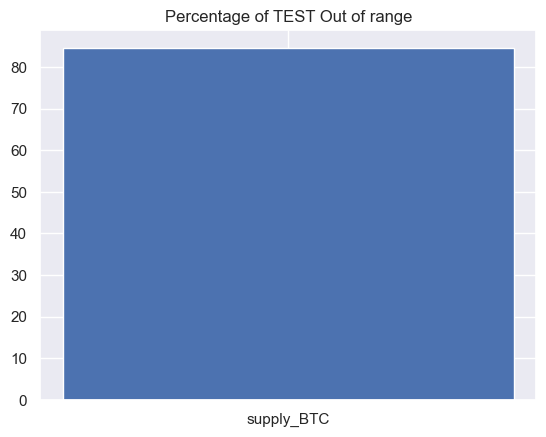

In [104]:
fig, ax = plt.subplots()
ax.bar(df_count_out.xs("pc_out_max").index.tolist(), df_count_out.xs("pc_out_max").values)
ax.bar(df_count_out.xs("pc_out_min").index.tolist(), -df_count_out.xs("pc_out_min").values)
ax.set_title("Percentage of TEST Out of range")

Text(0.5, 1.0, 'Features scaled boxplot')

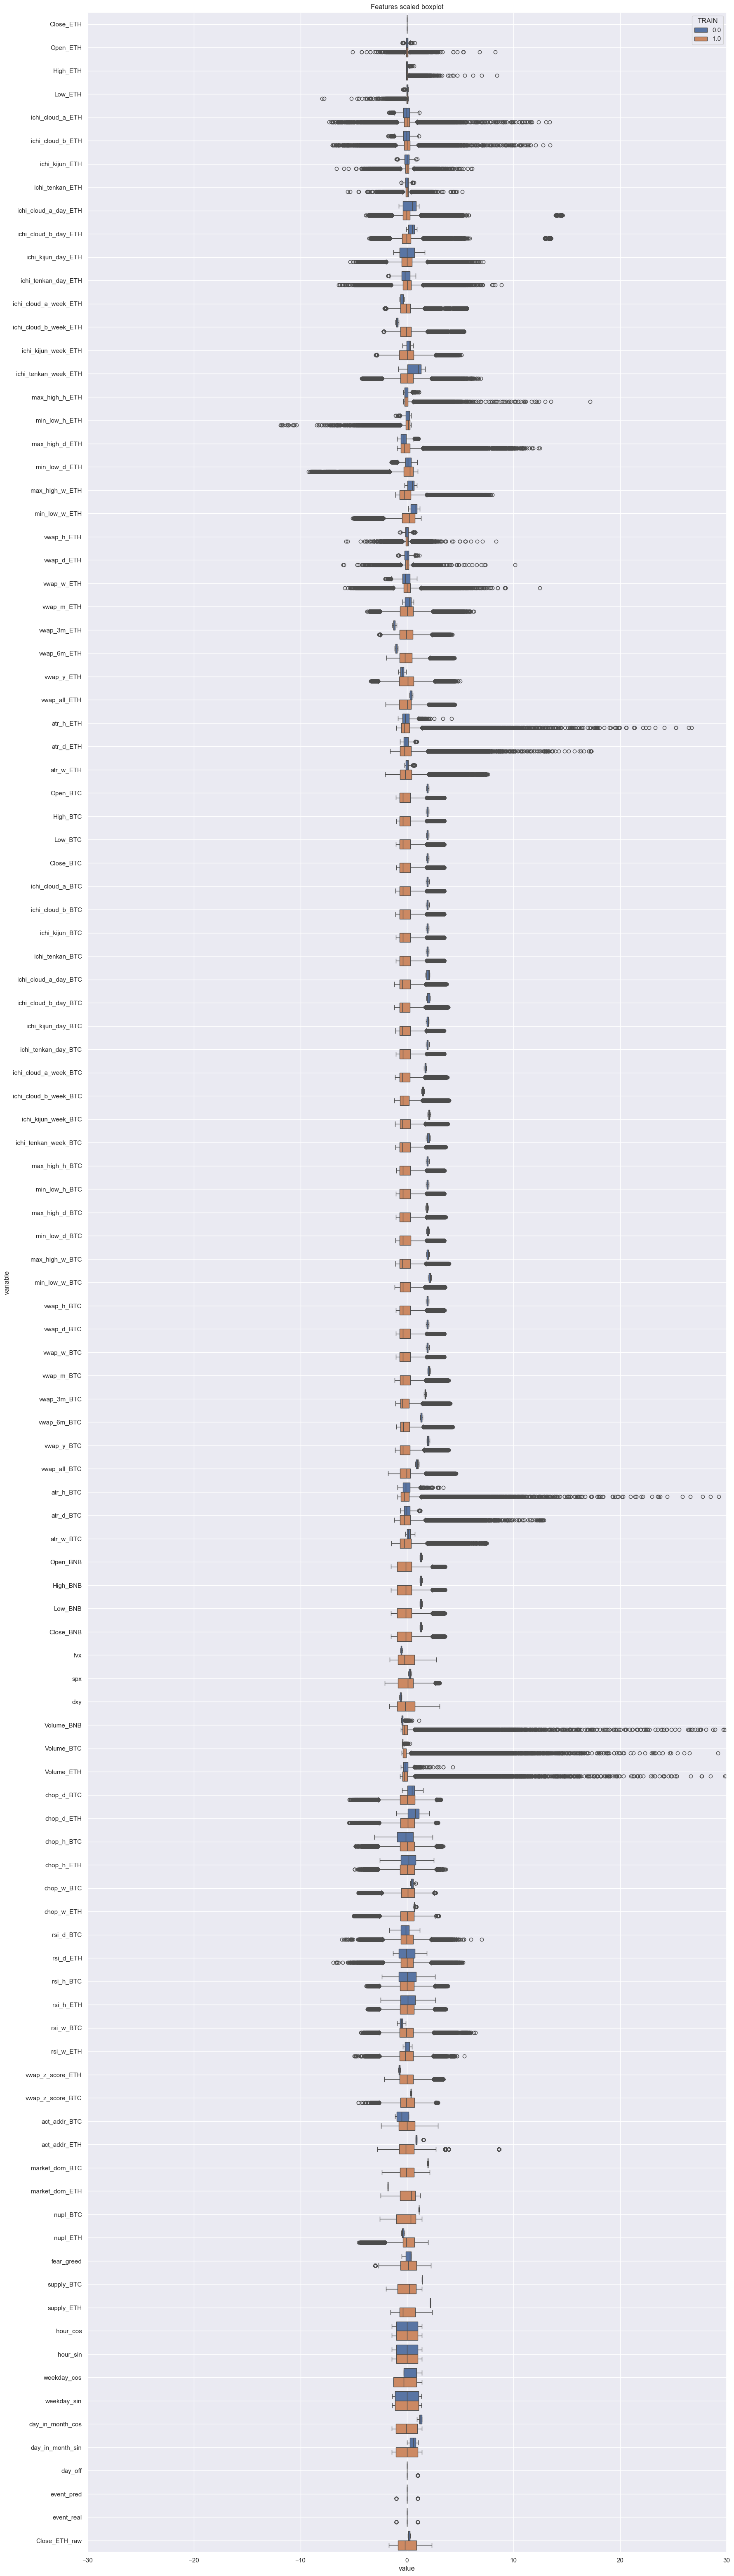

In [105]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

In [106]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0., 1.])

In [107]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()


array([0., 1.])

In [108]:
df_comp[(df_comp["TRAIN"] == False) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0.])

<Axes: >

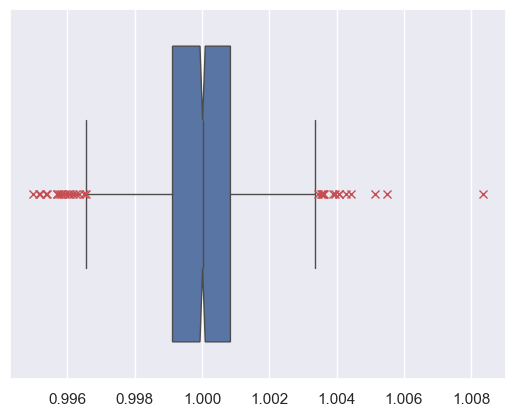

In [109]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/4208190987.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


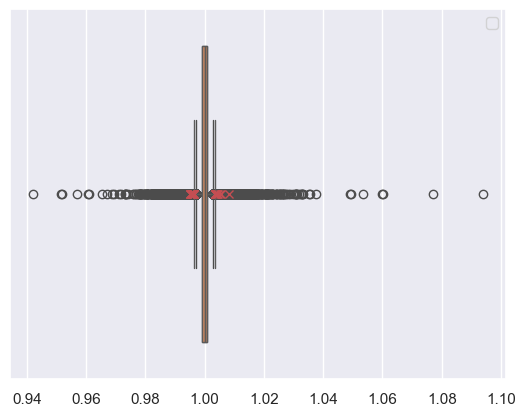

In [110]:
ax = sns.boxplot(
    x=X_train_dat[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

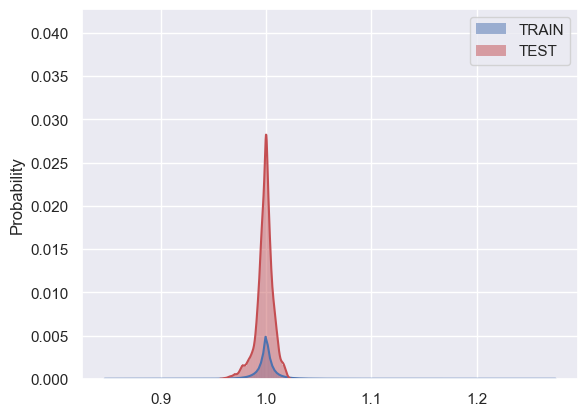

In [111]:

ax = sns.histplot(x=X_train_dat.reshape(-1, X_train_dat.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [112]:
def plot_hist_cat(x, data, title):
    '''
    Plot histogram count of categorical data 
    Add proportional information
    '''
    ser_val = data[x].value_counts(dropna=False)
    pc_val = ser_val.values / data[x].shape[0]

    sns.catplot(x=x, kind="count", palette="ch:.25", data=data, 
                height=5, 
                aspect=1.7,
                order=ser_val.index)
    fig = plt.gcf()
    ax = fig.gca()

    for K, y_val in enumerate(ser_val.values):
        ax.text(K, y_val, '{:.2f}'.format(pc_val[K]))
    
    ax.set_title(title)
    
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    return ser_val

def contingency_table(X, Y, data):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    and p value of independance
    '''
    c = data[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len)

    c = c.fillna(0) # on remplace les valeurs nulles par des 0

    chi2, p, dof, expected = stats.chi2_contingency(c)

    return c, chi2, p, dof, expected



def plot_cont(X, Y, data, liste_cat=None):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    '''
    c, chi2, p, dof, expected = contingency_table(X, Y, data)
    print("expected: ", expected)
    
    tx = data[X].value_counts()
    ty = data[Y].value_counts()
    
    cont = c.copy()
    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(data)
    
    print(cont)

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(data)
    indep = tx.dot(ty.T) / n
    
    # calcul du signe (add-on)
    d_sign = (c-indep) / np.fabs(c-indep)
    
    mesure = d_sign * (c-indep)**2 / indep
    
    # patch sign
    xi_n = np.fabs(mesure).sum().sum()
    print("xi_n = ", xi_n)
    
    print("chi2: ", chi2)
    print("dof: ", dof)
    print("p: ", p)
    print(f"We have we have a {100*p:.4f}% chance for H0 to be true.")
    print("H0 : independance of distributions")
    print("H1 : distribution are not independant : we reject H0")
    # plot
    #print(c.shape)
    fig = plt.figure(figsize = (7/5*c.shape[1], 6/4*c.shape[0]))
    sns.heatmap(mesure/xi_n, annot=c, fmt=".0f", center=0)
    ax = fig.gca()
    ax.set_title(Y + "= f( " + X + ")")
    plt.show()
    
    return c

In [113]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None, size=25):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (size, size*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

### Linear Corr

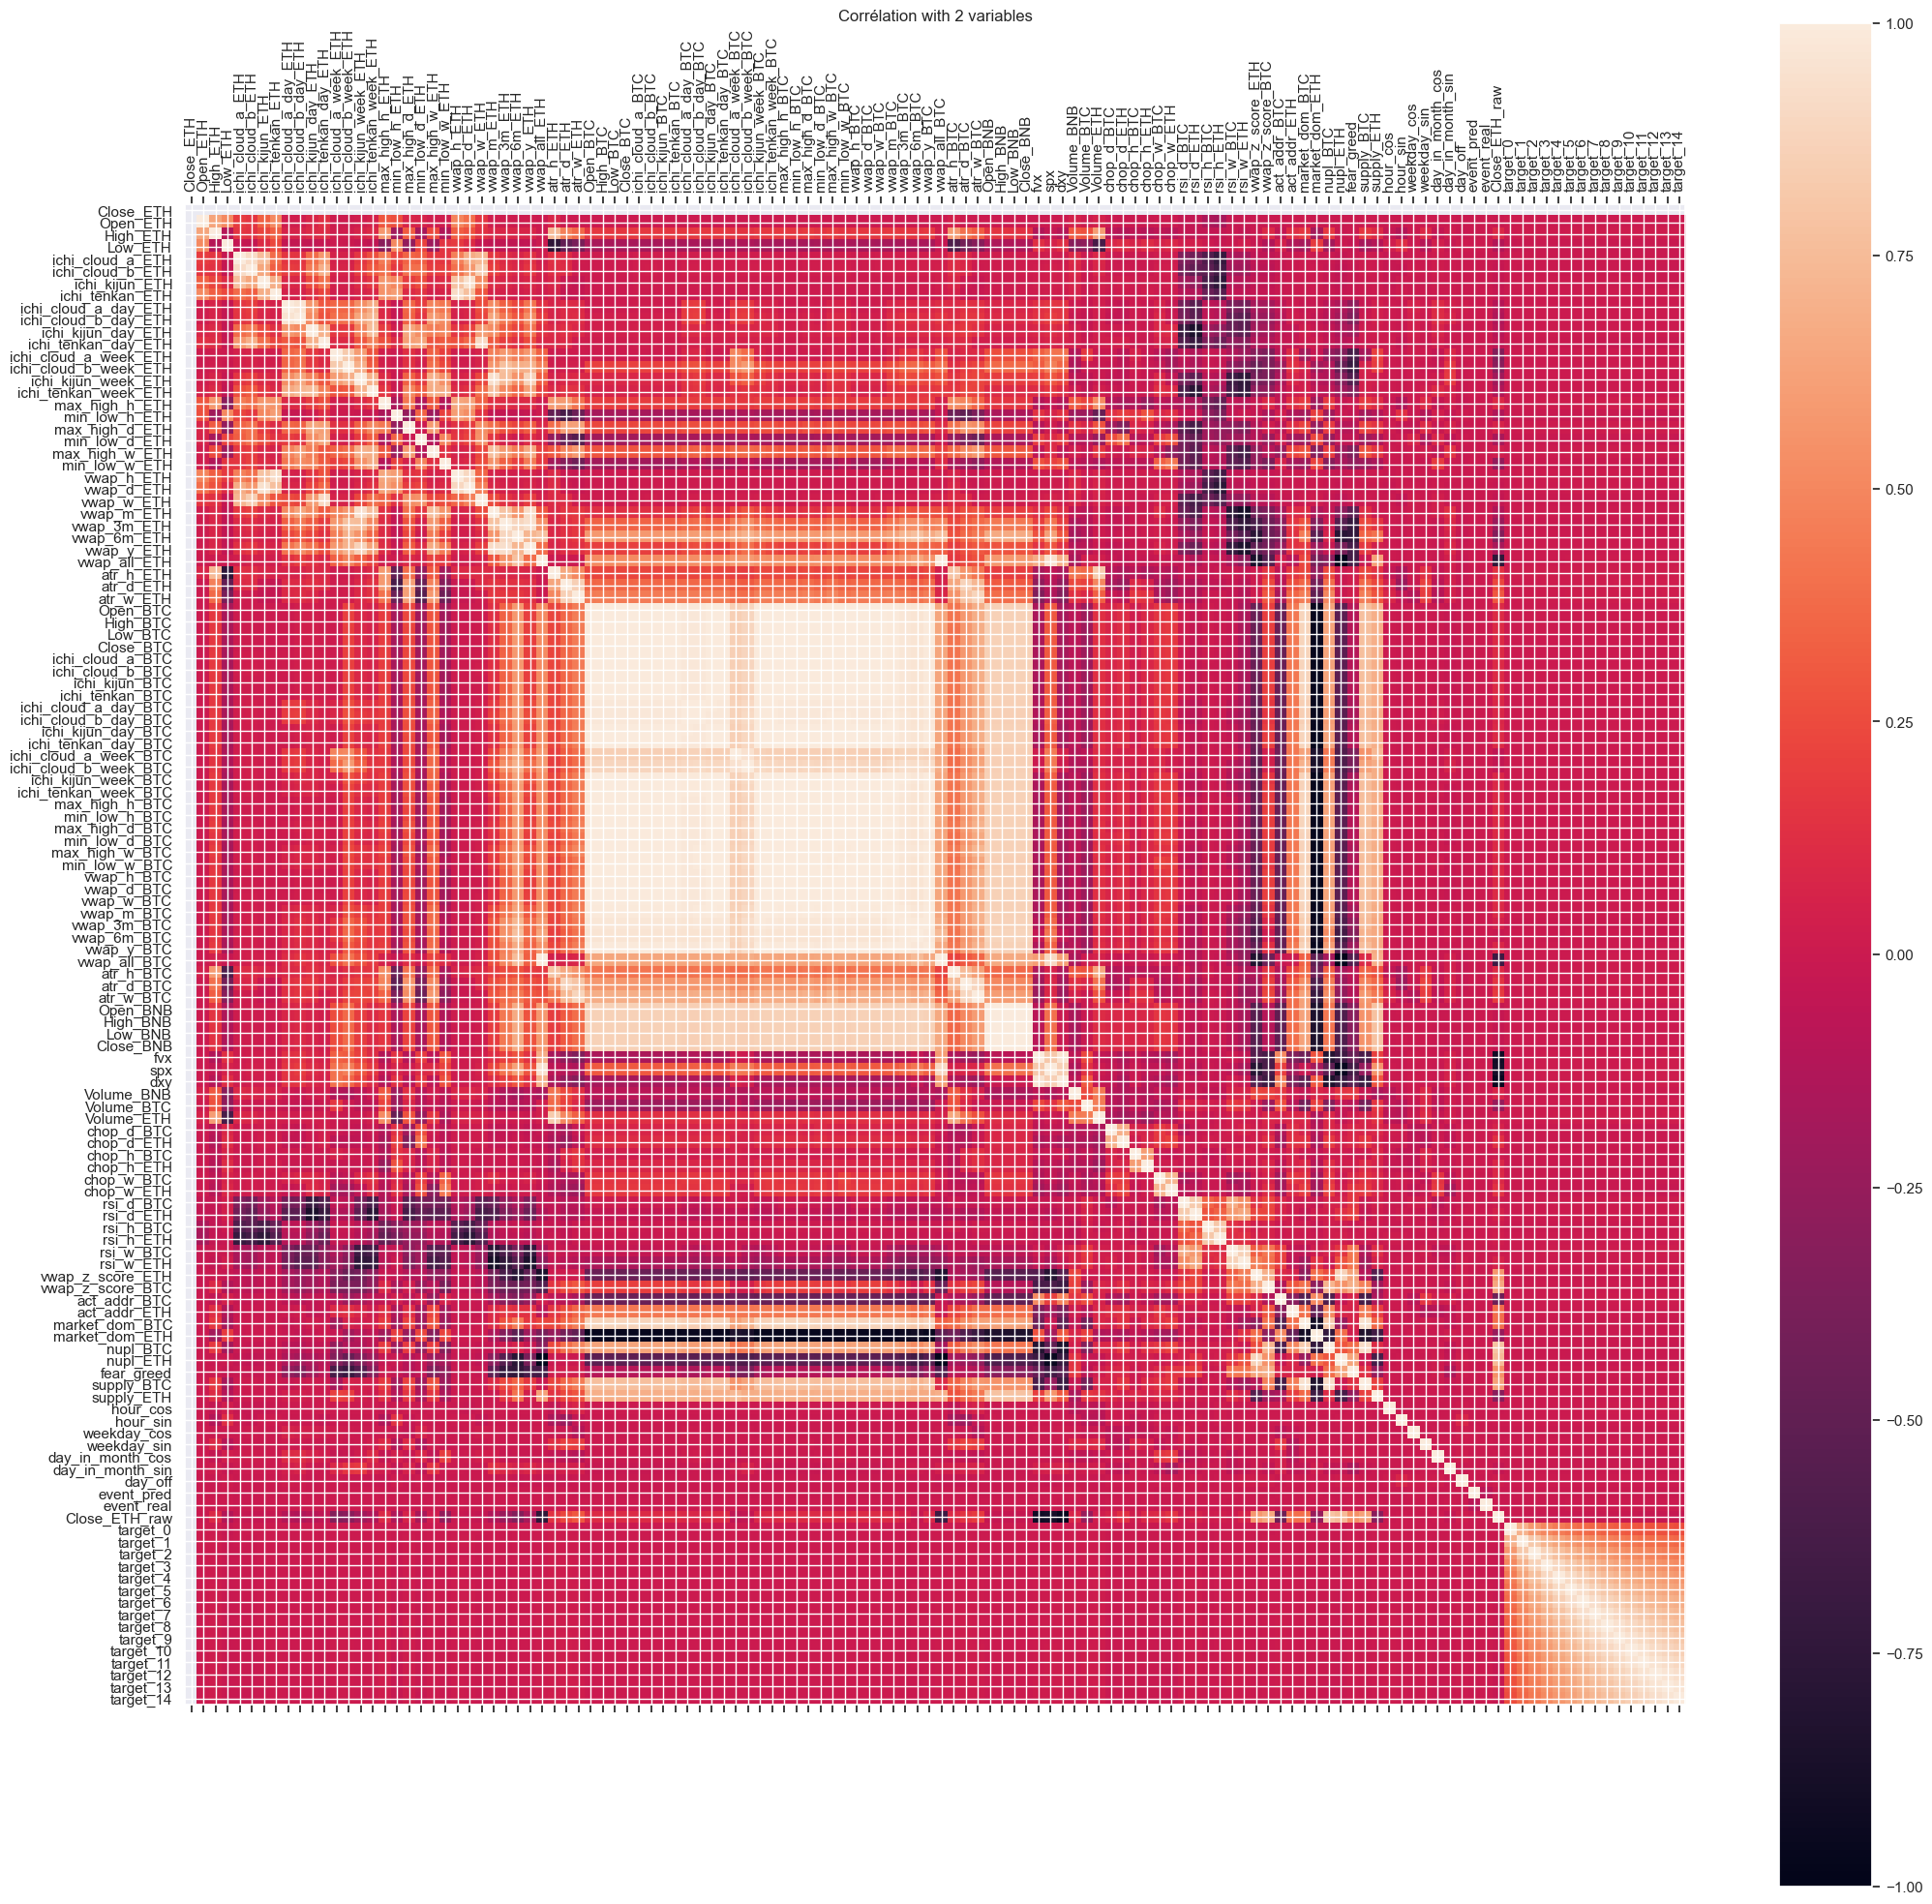

In [114]:
nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_dat[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


In [115]:
y_train.shape

(253677, 15)

In [116]:
list_col_corr

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [117]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [118]:
df.filter(list_col_select)

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0             1.0  0.999782  1.000109  0.999774          0.999171   
1             1.0  0.999548  1.000008  0.999540          0.998785   
2             1.0  1.000084  1.000193  0.999841          0.998860   
3             1.0  1.000770  1.000770  0.999900          0.999669   
4             1.0  0.999330  1.000025  0.999330          0.999178   
...           ...       ...       ...       ...               ...   
253672        1.0  0.998258  1.001698  0.997009          1.009059   
253673        1.0  0.998554  1.001387  0.998451          1.006895   
253674        1.0  1.004900  1.005056  0.999299          1.011829   
253675        1.0  1.001168  1.001491  0.997621          1.011492   
253676        1.0  1.012121  1.014171  0.998487          1.023400   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.999736        0.998393         0.999464   
1               0.999276        0.998113         0.999184   
2               0.999351        0.998243         0.999477   
3               1.000113        0.999003         1.000239   
4               0.999443        0.998335         0.999569   
...                  ...             ...              ...   
253672          1.012239        1.000323         1.000559   
253673          1.010775        0.998877         0.999113   
253674          1.015728        1.003772         1.004009   
253675          1.015731        1.004944         1.003987   
253676          1.028043        1.011526         1.009147   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
0                   2.024261              2.017807  ...  2.588190e-01   
1                   2.023329              2.016878  ...  6.123234e-17   
2                   2.023482              2.017030  ...  6.123234e-17   
3                   2.025023              2.018567  ...  6.123234e-17   
4                   2.023668              2.017215  ...  6.123234e-17   
...                      ...                   ...  ...           ...   
253672              1.043299              1.026564  ...  9.659258e-01   
253673              1.041791              1.025079  ...  9.659258e-01   
253674              1.046896              1.030103  ...  9.659258e-01   
253675              1.048118              1.031306  ...  9.659258e-01   
253676              1.060823              1.043807  ...  9.659258e-01   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
0       0.965926     0.623490    -0.781832           0.97953   
1       1.000000     0.623490    -0.781832           0.97953   
2       1.000000     0.623490    -0.781832           0.97953   
3       1.000000     0.623490    -0.781832           0.97953   
4       1.000000     0.623490    -0.781832           0.97953   
...          ...          ...          ...               ...   
253672  0.258819    -0.222521    -0.974928           1.00000   
253673  0.258819    -0.222521    -0.974928           1.00000   
253674  0.258819    -0.222521    -0.974928           1.00000   
253675  0.258819    -0.222521    -0.974928           1.00000   
253676  0.258819    -0.222521    -0.974928           1.00000   

        day_in_month_sin  day_off  event_pred  event_real  Close_ETH_raw  
0           2.012985e-01      0.0         0.0         0.0    1194.540039  
1           2.012985e-01      0.0         0.0         0.0    1195.089966  
2           2.012985e-01      0.0         0.0         0.0    1195.000000  
3           2.012985e-01      0.0         0.0         0.0    1194.089966  
4           2.012985e-01      0.0         0.0         0.0    1194.890015  
...                  ...      ...         ...         ...            ...  
253672     -2.449294e-16      0.0         0.0         0.0    2520.719971  
253673     -2.449294e-16      0.0         0.0         0.0    2524.370117  
253674     -2.449294e-16      0.0         0.0         0.0    2512.060059  
253675     -2.449294e-16      0.0         0.0     

In [119]:
df.filter(list_col_targets)

target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0       1.000460  1.000385  0.999623  1.000293  0.999816  1.000050  0.999498   
1       0.999925  0.999163  0.999833  0.999356  0.999590  0.999038  0.999046   
2       0.999238  0.999908  0.999431  0.999665  0.999113  0.999121  0.999473   
3       1.000670  1.000193  1.000427  0.999874  0.999883  1.000234  1.000301   
4       0.999523  0.999757  0.999205  0.999213  0.999565  0.999632  0.999565   
...          ...       ...       ...       ...       ...       ...       ...   
253672  1.001448  0.996564  0.995402  0.983481  0.990876  0.990951  0.988297   
253673  0.995124  0.993963  0.982059  0.989443  0.989518  0.986868  0.986836   
253674  0.998834  0.986871  0.994292  0.994367  0.991704  0.991672  0.992440   
253675  0.988024  0.995453  0.995528  0.992862  0.992830  0.993599  0.991049   
253676  1.007519  1.007596  1.004897  1.004865  1.005643  1.003062  1.010629   

        target_7  target_8  target_9  target_10  target_11  target_12  \
0       0.999506  0.999858  0.999925   0.999858   1.000226   0.999891   
1       0.999398  0.999464  0.999398   0.999766   0.999431   0.999690   
2       0.999540  0.999473  0.999841   0.999506   0.999766   0.999473   
3       1.000234  1.000603  1.000268   1.000528   1.000234   0.999640   
4       0.999933  0.999598  0.999858   0.999565   0.998971   0.998686   
...          ...       ...       ...        ...        ...        ...   
253672  0.988265  0.989031  0.986492   0.993934   0.995977   0.997667   
253673  0.987601  0.985066  0.992497   0.994537   0.996225   0.993384   
253674  0.989893  0.997361  0.999411   1.001107   0.998252   0.997170   
253675  0.998525  1.000578  1.002276   0.999418   0.998334   0.994448   
253676  1.012706  1.014425  1.011533   1.010435   1.006502   1.009294   

        target_13  target_14  
0        1.000151   0.999858  
1        0.999398   0.998803  
2        0.998879   0.998594  
3        0.999355   1.000427  
4        0.999757   0.999732  
...           ...        ...  
253672   0.994823   0.993744  
253673   0.992307   0.988445  
253674   0.993288   0.996043  
253675   0.997206   0.995803  
253676   1.007874   1.007934  

[253677 rows x 15 columns]

In [120]:
df["Close_ETH_raw"].corr(df["target_14"])

np.float64(-0.01767952024837609)

In [121]:
df.filter(list_col_select).corrwith(df["target_14"])

/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Close_ETH                NaN
Open_ETH            0.006258
High_ETH            0.021161
Low_ETH            -0.014519
ichi_cloud_a_ETH   -0.008137
                      ...   
day_in_month_sin   -0.001319
day_off             0.000980
event_pred         -0.002843
event_real          0.000742
Close_ETH_raw      -0.017680
Length: 109, dtype: float64

In [122]:
df.filter(list_col_select).corrwith(df.filter(list_col_targets))

Close_BNB          NaN
Close_BTC          NaN
Close_ETH          NaN
Close_ETH_raw      NaN
High_BNB           NaN
                    ..
vwap_y_ETH         NaN
vwap_z_score_BTC   NaN
vwap_z_score_ETH   NaN
weekday_cos        NaN
weekday_sin        NaN
Length: 124, dtype: float64

In [123]:
len(list_col_select)

109

In [124]:
nb_plot

109

In [125]:
# check if new  data in df_feat
# hash inputs
hash_correl_inputs = (
    get_data_hash(df_feat) + 
    get_data_hash(PAST_HISTORY) + 
    get_data_hash(FUTURE_TARGET) +
    get_data_hash(X_train_dat[:, 0, :nb_plot])
)
# load old file hash
path_correl_hash = os.path.join(path_data, 'correl_inputs_hash.txt')
hash_correl_inputs_old = load_hash(path_correl_hash)

# compare hash
if hash_correl_inputs == hash_correl_inputs_old:
    print("hash match: mode LOAD correl ")
    # load data output
    arr_corr_matrix_targets = np.load(path_arr_corr_matrix_targets)
    mode_correl = False
else:
    print("hash not match : mode REDO correl")
    mode_correl = True

hash match: mode LOAD correl 


In [126]:
hash_correl_inputs

'3b10ee1c51bb8a7c8da122d06d67d22cc039b3b478eede79fa9b63e7368c86798722616204217eddb39e7df969e0698aed8e599ba62ed2de1ce49b03ade0fedee629fa6598d732768f7c726b4b621285f9c3b85303900aa912017db7617d8bdb196cfe7a444bd4ac4a4adfd6d66eb71081fcf5cd3d99cb76fcc285a4dbd18c9e'

In [127]:
#mode_correl = True

In [128]:
# Assuming the following variables are pre-defined from your environment:
# PAST_HISTORY: int
# X_train_dat: np.ndarray (e.g., shape: num_samples, total_past_steps, num_total_features)
# y_train: np.ndarray (e.g., shape: num_samples, num_targets or num_samples for single target)
# list_col_select: list of strings (names of all features)
# nb_plot: int (number of features to use from X_train_dat, e.g., list_col_select[:nb_plot])
# list_col_targets: list of strings (names of target columns)
# list_col_corr: list of strings (from original code, not strictly needed for optimized version but was used for column naming in the old approach)
# These are the names of the feature columns we'll be selecting from X_train_dat.
# These will form the row index of our correlation matrix for each I_past.
feature_names_to_correlate = list_col_select[:nb_plot]

if mode_correl:
    # Optimized code for calculating correlations:
    list_corr_optimized = []
    # Create a DataFrame for the target(s) once, as it's constant across I_past iterations.
    # This assumes y_train has columns corresponding to list_col_targets.
    # If y_train is 1D (num_samples,), list_col_targets should contain one target name.
    y_train_df = pd.DataFrame(y_train, columns=list_col_targets)

    for I_past in range(PAST_HISTORY):
        # Extract the relevant feature data for the current I_past step
        # Shape: (num_samples, nb_plot)
        current_X_data = X_train_dat[:, I_past, :nb_plot]
        
        # Create a DataFrame for the features of the current I_past step
        df_features = pd.DataFrame(current_X_data, columns=feature_names_to_correlate)
        
        # Initialize a DataFrame to store correlations for this I_past step
        # Rows: features (feature_names_to_correlate)
        # Columns: targets (list_col_targets)
        # This ensures consistent shape and ordering.
        corr_matrix_for_this_past_step = pd.DataFrame(
            index=feature_names_to_correlate,
            columns=list_col_targets,
            dtype=float  # Ensure float type for correlations
        )
        
        # Calculate correlation of all features with each target column
        for target_col_name in list_col_targets:
            # df_features.corrwith() computes the correlation of each column in df_features
            # with the provided Series (y_train_df[target_col_name]).
            # The result is a Series indexed by feature_names_to_correlate.
            corrs_with_target = df_features.corrwith(y_train_df[target_col_name])
            corr_matrix_for_this_past_step[target_col_name] = corrs_with_target
                
        list_corr_optimized.append(corr_matrix_for_this_past_step)

    # Convert the list of DataFrames to a 3D NumPy array
    # Each DataFrame in list_corr_optimized has shape (len_feat, len_targets)
    # So, arr_corr_matrix_targets will have shape (PAST_HISTORY, len_feat, len_targets)
    # The final variable name 'arr_corr_matrix_targets' matches the original script's output.
    arr_corr_matrix_targets = np.array([df.values for df in list_corr_optimized])
    np.save(path_arr_corr_matrix_targets, arr_corr_matrix_targets)
    # save hash
    with open(path_correl_hash, 'w') as file:
        file.write(hash_correl_inputs)
        
# To check the shape (optional, similar to original script's last line intent):
print(arr_corr_matrix_targets.shape)

(72, 109, 15)


In [129]:
min_corr = np.min(arr_corr_matrix_targets, axis=0)
# create a same col/row than corr_matrix_targets  dataframe using the array max_corr 
min_corr_matrix_targets = pd.DataFrame(min_corr, columns=list_col_targets, index=feature_names_to_correlate)
min_corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH         -0.001701 -0.002949 -0.004338 -0.004786 -0.005536 -0.006069   
High_ETH         -0.000797 -0.002178 -0.003831 -0.004392 -0.004896 -0.005219   
Low_ETH          -0.016817 -0.009355 -0.013130 -0.010434 -0.012921 -0.014196   
ichi_cloud_a_ETH -0.001333 -0.002698 -0.004206 -0.004785 -0.005420 -0.005741   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000398 -0.000557 -0.000692 -0.000797 -0.000877 -0.000949   
day_off          -0.001658 -0.001925 -0.002138 -0.002449 -0.002720 -0.002928   
event_pred       -0.007535 -0.007502 -0.007099 -0.006575 -0.007400 -0.007414   
event_real       -0.006934 -0.005017 -0.006066 -0.006793 -0.007159 -0.006455   
Close_ETH_raw    -0.004679 -0.006619 -0.008133 -0.009389 -0.010496 -0.011500   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH         -0.006341 -0.006946 -0.007559 -0.008070  -0.008769   
High_ETH         -0.005530 -0.006099 -0.006690 -0.007125  -0.007764   
Low_ETH          -0.012469 -0.012652 -0.013120 -0.012089  -0.012053   
ichi_cloud_a_ETH -0.006049 -0.006704 -0.007392 -0.007962  -0.008725   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.001011 -0.001072 -0.001131 -0.001170  -0.001207   
day_off          -0.002984 -0.003063 -0.003417 -0.003756  -0.004137   
event_pred       -0.008150 -0.008197 -0.007157 -0.007306  -0.006725   
event_real       -0.006324 -0.005582 -0.005122 -0.005386  -0.005777   
Close_ETH_raw    -0.012413 -0.013273 -0.014083 -0.014851  -0.015591   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH          -0.009670  -0.010539  -0.011152  -0.011719  
High_ETH          -0.008598  -0.009396  -0.010045  -0.010533  
Low_ETH           -0.012555  -0.013287  -0.014501  -0.014519  
ichi_cloud_a_ETH  -0.009675  -0.010512  -0.011161  -0.011769  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.001238  -0.001268  -0.001295  -0.001330  
day_off           -0.004513  -0.004813  -0.004936  -0.004976  
event_pred        -0.006705  -0.006893  -0.006448  -0.006236  
event_real        -0.005484  -0.005540  -0.005085  -0.005007  
Close_ETH_raw     -0.016306  -0.016993  -0.017642  -0.018262  

[109 rows x 15 columns]

In [130]:
max_corr = np.max(arr_corr_matrix_targets, axis=0)
# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
max_corr_matrix_targets = pd.DataFrame(max_corr, columns=list_col_targets, index=feature_names_to_correlate)
max_corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.012652  0.012706  0.007384  0.008588  0.009448  0.010770   
High_ETH          0.014405  0.018180  0.013382  0.014009  0.015279  0.018274   
Low_ETH           0.009441  0.007320  0.005701  0.006453  0.007151  0.007921   
ichi_cloud_a_ETH  0.001506  0.000691 -0.000851 -0.001260 -0.001769 -0.002025   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000037 -0.000059 -0.000090 -0.000110 -0.000128 -0.000139   
day_off           0.004958  0.006637  0.008144  0.009304  0.010308  0.011129   
event_pred        0.006938  0.005788  0.004485  0.004810  0.004764  0.005232   
event_real        0.011923  0.007592  0.006667  0.005395  0.004392  0.004200   
Close_ETH_raw    -0.004416 -0.006272 -0.007722 -0.008909 -0.009972 -0.010923   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH          0.011687  0.012110  0.012257  0.012759   0.012753   
High_ETH          0.017810  0.018056  0.017313  0.018760   0.019101   
Low_ETH           0.008671  0.008909  0.008904  0.009035   0.008812   
ichi_cloud_a_ETH -0.002226 -0.003052 -0.003963 -0.004472  -0.005133   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.000152 -0.000167 -0.000178 -0.000191  -0.000202   
day_off           0.011804  0.012297  0.012856  0.013461   0.014119   
event_pred        0.005445  0.004738  0.004550  0.004258   0.003870   
event_real        0.003522  0.003433  0.003092  0.002819   0.003152   
Close_ETH_raw    -0.011811 -0.012650 -0.013433 -0.014165  -0.014874   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH           0.011976   0.011651   0.011450   0.011046  
High_ETH           0.019312   0.019143   0.019121   0.021161  
Low_ETH            0.007964   0.007265   0.006881   0.006597  
ichi_cloud_a_ETH  -0.006133  -0.006962  -0.007598  -0.008137  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.000216  -0.000219  -0.000213  -0.000205  
day_off            0.014685   0.015103   0.015379   0.015643  
event_pred         0.003168   0.003361   0.003661   0.003109  
event_real         0.002568   0.003172   0.002769   0.002828  
Close_ETH_raw     -0.015564  -0.016217  -0.016848  -0.017458  

[109 rows x 15 columns]

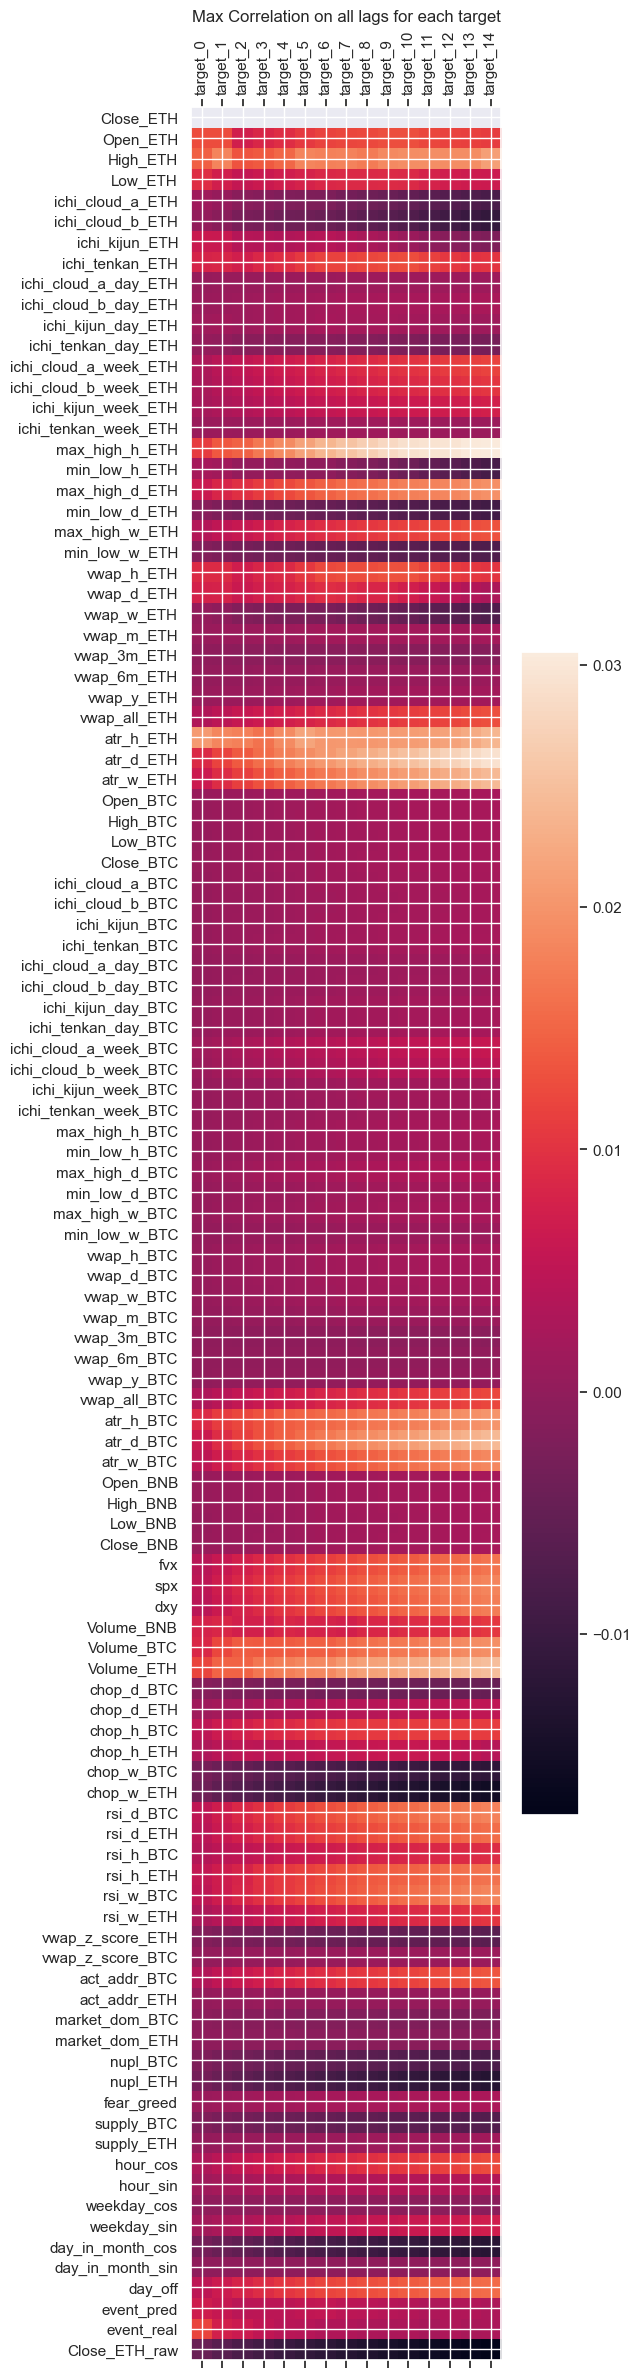

In [131]:
#corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(max_corr_matrix_targets, title = "Max Correlation on all lags for each target", size=5)

In [132]:
arr_corr_matrix_targets.shape

(72, 109, 15)

In [133]:

# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
corr_matrix_targets = pd.DataFrame(arr_corr_matrix_targets[-1,:,:], columns=list_col_targets, index=feature_names_to_correlate)
corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.009073  0.012706  0.005011  0.005306  0.003014  0.002964   
High_ETH          0.014071  0.018180  0.013382  0.014009  0.015279  0.018274   
Low_ETH          -0.016817 -0.009355 -0.013130 -0.010434 -0.012921 -0.014196   
ichi_cloud_a_ETH  0.001506  0.000691 -0.000851 -0.001260 -0.001769 -0.002025   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000296 -0.000423 -0.000544 -0.000668 -0.000773 -0.000863   
day_off           0.001504  0.001980  0.002029  0.002108  0.002348  0.002265   
event_pred       -0.001765 -0.002056 -0.004927 -0.006495 -0.006435 -0.004693   
event_real       -0.000192 -0.000444 -0.000892 -0.000309 -0.000999  0.001766   
Close_ETH_raw    -0.004584 -0.006471 -0.007914 -0.009142 -0.010221 -0.011200   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH          0.005411  0.006158  0.005031  0.005796   0.007312   
High_ETH          0.017810  0.018056  0.017313  0.018760   0.019101   
Low_ETH          -0.012469 -0.012652 -0.013120 -0.012089  -0.012053   
ichi_cloud_a_ETH -0.002226 -0.003052 -0.003963 -0.004472  -0.005133   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.000939 -0.001006 -0.001069 -0.001122  -0.001173   
day_off           0.002448  0.002551  0.002508  0.002349   0.002198   
event_pred       -0.005406 -0.006106 -0.004600 -0.004791  -0.004072   
event_real        0.002126  0.000963  0.001933  0.001213   0.000671   
Close_ETH_raw    -0.012098 -0.012931 -0.013712 -0.014452  -0.015153   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH           0.006586   0.005397   0.005068   0.006258  
High_ETH           0.019312   0.019143   0.019121   0.021161  
Low_ETH           -0.012555  -0.013287  -0.014501  -0.014519  
ichi_cloud_a_ETH  -0.006133  -0.006962  -0.007598  -0.008137  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.001227  -0.001266  -0.001291  -0.001319  
day_off            0.002044   0.001500   0.001213   0.000980  
event_pred        -0.003568  -0.003976  -0.004773  -0.002843  
event_real         0.000769   0.001015   0.000718   0.000742  
Close_ETH_raw     -0.015822  -0.016463  -0.017082  -0.017680  

[109 rows x 15 columns]

#### Best Max Corr Features

In [134]:
# (72, 103, 15)
ind = np.unravel_index(
    np.argsort(np.nan_to_num(arr_corr_matrix_targets, nan=0.0), axis=None), 
    arr_corr_matrix_targets.shape,
)
# 30th first features
nb_lag_corr_max = 50
# for lag_curr, feat_curr, target_curr in zip(ind[0][-nb_lag_corr_max:], ind[1][-nb_lag_corr_max:], ind[2][-nb_lag_corr_max:]): #ind[0][-30:]
    
#     corr_curr = arr_corr_matrix_targets[lag_curr, feat_curr, target_curr]
#     print(f"{feature_names_to_correlate[feat_curr]}, lag: {lag_curr}, target: {target_curr}, corr: {corr_curr}")

# 1. Get the slices of your indices
lags = ind[0][-nb_lag_corr_max:]
feature_indices = ind[1][-nb_lag_corr_max:]
target_indices = ind[2][-nb_lag_corr_max:]

# 2. Create the DataFrame from a dictionary of lists
corr_max_df_efficient = pd.DataFrame({
    'Feature': [feature_names_to_correlate[i] for i in feature_indices],
    'Lag': lags,
    'Target': target_indices,
    'Correlation': [arr_corr_matrix_targets[lag, feat, targ] for lag, feat, targ in zip(lags, feature_indices, target_indices)]
})

corr_max_df_efficient.sort_values(by='Correlation', ascending=False)


Feature  Lag  Target  Correlation
49  max_high_h_ETH   71      14     0.030522
48  max_high_h_ETH   71      13     0.030174
47  max_high_h_ETH   71      12     0.029767
46  max_high_h_ETH   71      11     0.029400
45  max_high_h_ETH   70      14     0.029298
44       atr_d_ETH   71      14     0.029270
43  max_high_h_ETH   70      13     0.029242
42  max_high_h_ETH   71      10     0.029076
41  max_high_h_ETH   70      11     0.028983
40  max_high_h_ETH   70      12     0.028974
39       atr_d_ETH   70      14     0.028877
38  max_high_h_ETH   70      10     0.028848
37       atr_d_ETH   69      14     0.028809
36       atr_d_ETH   68      14     0.028627
35       atr_d_ETH   67      14     0.028425
34       atr_d_ETH   71      13     0.028354
33  max_high_h_ETH   71       9     0.028178
32       atr_d_ETH   66      14     0.028178
31  max_high_h_ETH   69      10     0.028046
30       atr_d_ETH   70      13     0.028017
29  max_high_h_ETH   70       9     0.028008
28       atr_d_ETH   65      14     0.027985
27       atr_d_ETH   69      13     0.027905
26  max_high_h_ETH   69      11     0.027851
25       atr_d_ETH   64      14     0.027847
24       atr_d_ETH   68      13     0.027834
23  max_high_h_ETH   69      13     0.027758
22  max_high_h_ETH   69      12     0.027752
21       atr_d_ETH   63      14     0.027664
20       atr_d_ETH   67      13     0.027648
19  max_high_h_ETH   69      14     0.027621
18       atr_d_ETH   62      14     0.027490
17  max_high_h_ETH   69       9     0.027400
16       atr_d_ETH   66      13     0.027376
15       atr_d_ETH   71      12     0.027351
14       atr_d_ETH   61      14     0.027328
13       atr_d_ETH   65      13     0.027217
12       atr_d_ETH   60      14     0.027176
11       atr_d_ETH   64      13     0.027143
10       atr_d_ETH   70      12     0.027027
9   max_high_h_ETH   68      10     0.027013
8        atr_d_ETH   69      12     0.026983
7        atr_d_ETH   59      14     0.026956
6        atr_d_ETH   63      13     0.026919
5        atr_d_ETH   68      12     0.026868
4   max_high_h_ETH   70       8     0.026849
3        atr_d_ETH   67      12     0.026799
2        atr_d_ETH   47      14     0.026759
1        atr_d_ETH   46      14     0.026746
0   max_high_h_ETH   68      11     0.026744

max_high_h_ETH & Volume_ETH are the best positive impact on price.  
Explanation : 
- have a high higher in the last hour lead to have more chance to have a higher value in the next hour
- volume also  

Direction is kept 


#### Best Min Corr Features

In [135]:
# 1. Get the slices of your indices
lags = ind[0][0:nb_lag_corr_max]
feature_indices = ind[1][0:nb_lag_corr_max]
target_indices = ind[2][0:nb_lag_corr_max]

# 2. Create the DataFrame from a dictionary of lists
corr_min_df_efficient = pd.DataFrame({
    'Feature': [feature_names_to_correlate[i] for i in feature_indices],
    'Lag': lags,
    'Target': target_indices,
    'Correlation': [arr_corr_matrix_targets[lag, feat, targ] for lag, feat, targ in zip(lags, feature_indices, target_indices)]
})

corr_min_df_efficient.sort_values(by='Correlation', ascending=True)

Feature  Lag  Target  Correlation
0   min_low_h_ETH   71      14    -0.021244
1   min_low_h_ETH   71      13    -0.020220
2   min_low_h_ETH   71      12    -0.018750
3   Close_ETH_raw    3      14    -0.018262
4   Close_ETH_raw    2      14    -0.018259
5   Close_ETH_raw    4      14    -0.018252
6   Close_ETH_raw    1      14    -0.018243
7   Close_ETH_raw    5      14    -0.018236
8   Close_ETH_raw    0      14    -0.018228
9   Close_ETH_raw    6      14    -0.018221
10  Close_ETH_raw    7      14    -0.018218
11  Close_ETH_raw    8      14    -0.018209
12  Close_ETH_raw    9      14    -0.018192
13  Close_ETH_raw   10      14    -0.018182
14  Close_ETH_raw   11      14    -0.018169
15  Close_ETH_raw   12      14    -0.018147
16  Close_ETH_raw   13      14    -0.018131
17  Close_ETH_raw   14      14    -0.018124
18  Close_ETH_raw   15      14    -0.018117
19  Close_ETH_raw   16      14    -0.018103
20  Close_ETH_raw   21      14    -0.018085
21  Close_ETH_raw   20      14    -0.018081
22  Close_ETH_raw   19      14    -0.018079
23  Close_ETH_raw   17      14    -0.018078
24  Close_ETH_raw   18      14    -0.018077
25  Close_ETH_raw   22      14    -0.018069
26  Close_ETH_raw   23      14    -0.018063
27  Close_ETH_raw   24      14    -0.018063
28  Close_ETH_raw   25      14    -0.018049
29  Close_ETH_raw   26      14    -0.018040
30  Close_ETH_raw   27      14    -0.018031
31  Close_ETH_raw   28      14    -0.018014
32  Close_ETH_raw   29      14    -0.018000
33  Close_ETH_raw   30      14    -0.017974
34  min_low_h_ETH   70      14    -0.017965
35  Close_ETH_raw   31      14    -0.017955
36  Close_ETH_raw   32      14    -0.017949
37  Close_ETH_raw   33      14    -0.017933
38  Close_ETH_raw   34      14    -0.017925
39  Close_ETH_raw   35      14    -0.017909
40  Close_ETH_raw   37      14    -0.017894
41  Close_ETH_raw   40      14    -0.017894
42  Close_ETH_raw   36      14    -0.017894
43  Close_ETH_raw   39      14    -0.017890
44  Close_ETH_raw   41      14    -0.017889
45  Close_ETH_raw   38      14    -0.017889
46  Close_ETH_raw   42      14    -0.017888
47  Close_ETH_raw   43      14    -0.017883
48  Close_ETH_raw   46      14    -0.017879
49  Close_ETH_raw   45      14    -0.017877

In [136]:
np.nanmin(arr_corr_matrix_targets)

np.float64(-0.02124448282696438)

min_low_h_ETH & Close_ETH_raw are the best negative impact on price.  
Explanation : 
- have a min low higher in the last hour lead to have more chance to have a lower value in the next hour : direction kept
- have a price higher, so return to mean value


#### Last Lag Max Correlation

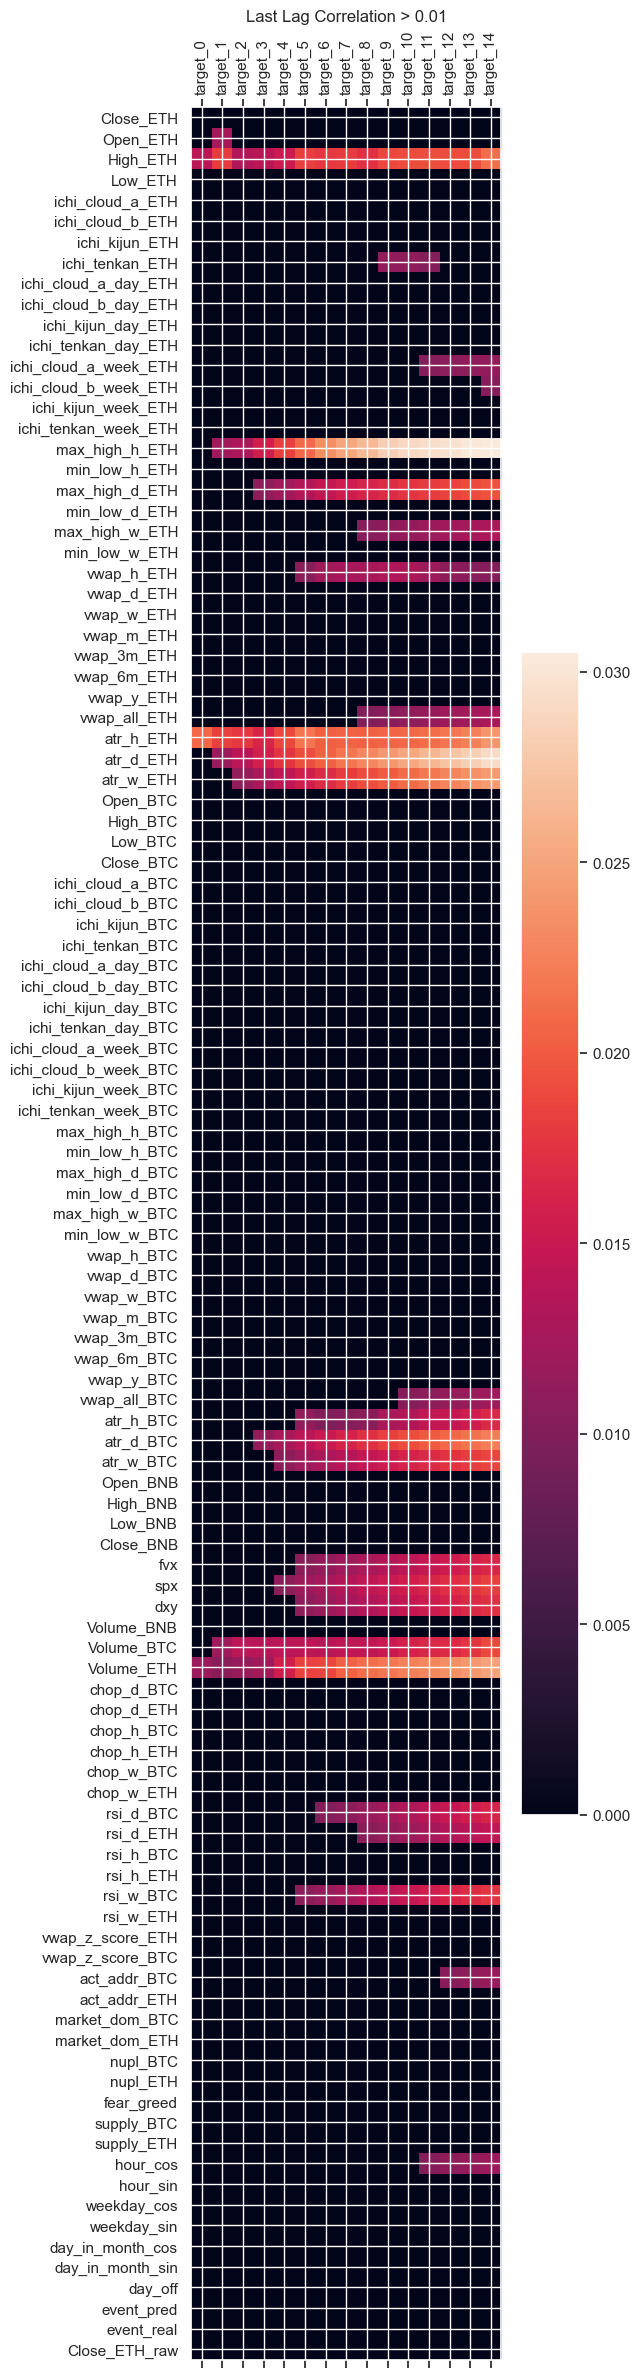

In [137]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets>0.01, 0), 
    title = "Last Lag Correlation > 0.01", 
    size=5)

#### Max Correlation on all lags

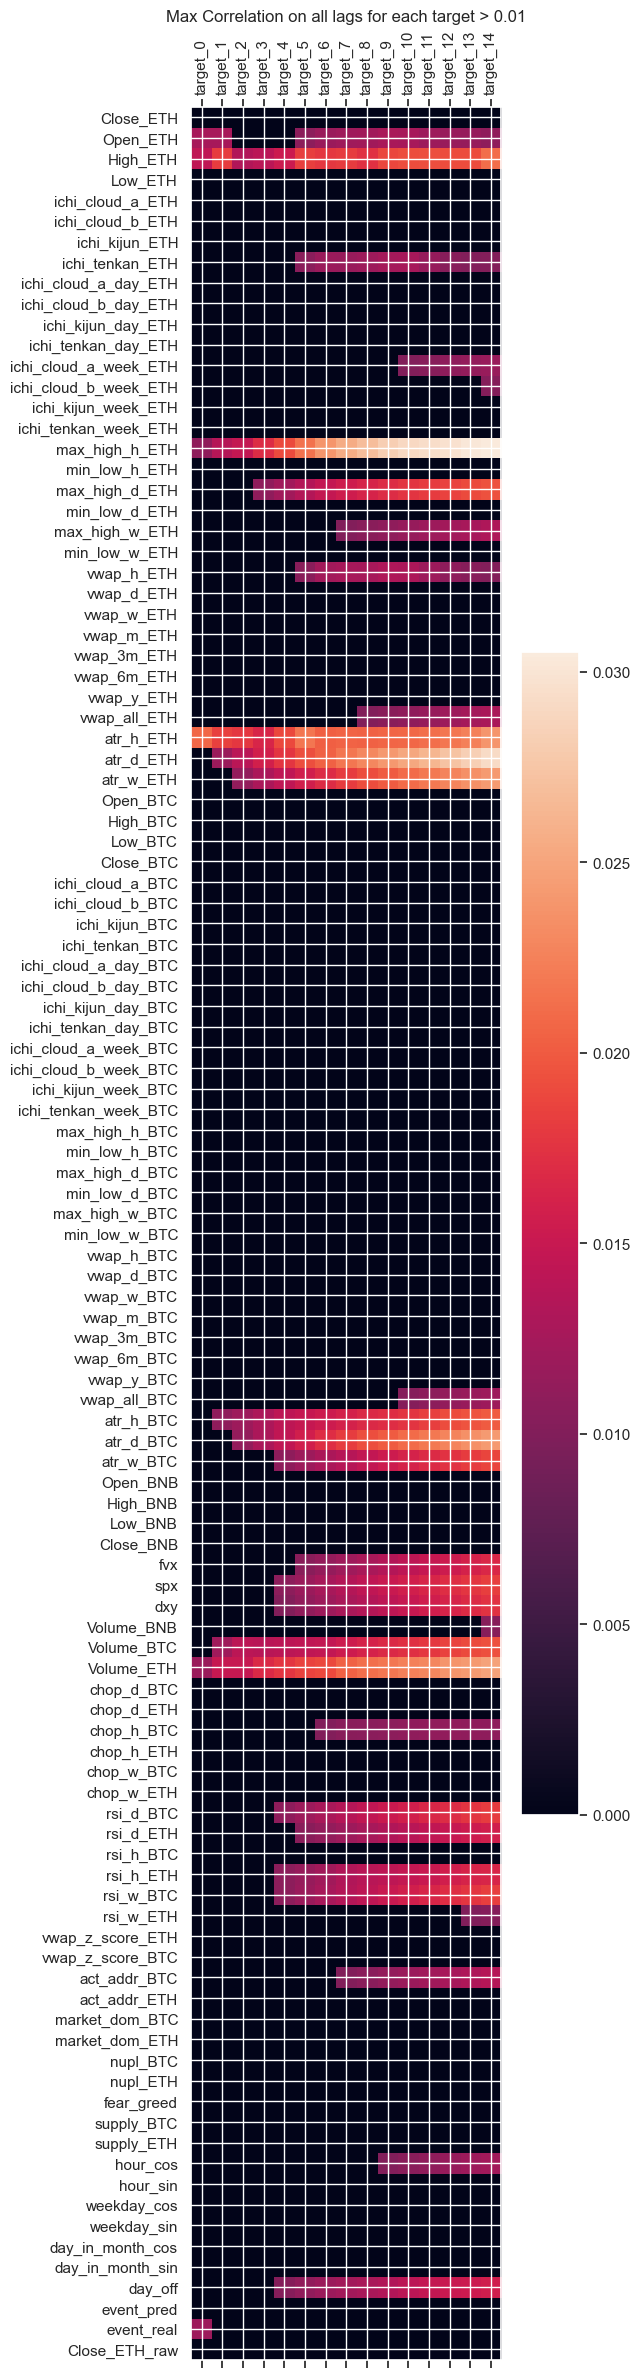

In [138]:
fig = plot_corr(
    max_corr_matrix_targets.where(max_corr_matrix_targets>0.01, 0),
    title="Max Correlation on all lags for each target > 0.01",
    size=5)

<Axes: >

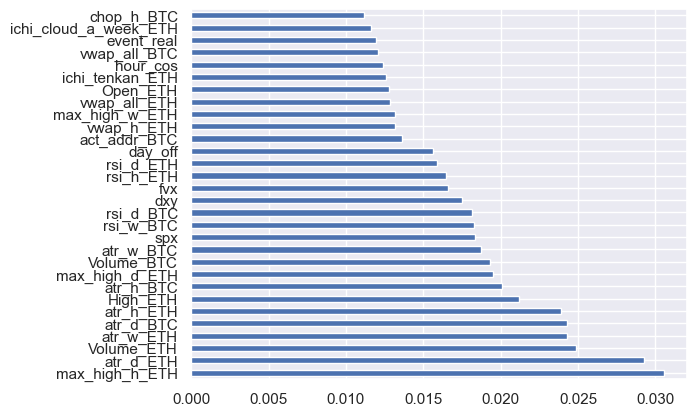

In [139]:
max_max_corr = max_corr_matrix_targets.max(axis=1).sort_values(ascending=False)
max_max_corr[max_max_corr.values>0.011].plot.barh()

#### Test on the highest corr


In [140]:
df = pd.DataFrame(np.hstack((X_train_dat[:, -1, :nb_plot], y_train)), 
        columns=list_col_corr)

In [141]:
df["target_cat"] = "neutral"
df.loc[df["target_14"] >= 1 + 0.5/100, "target_cat"] = "up"
df.loc[df["target_14"] <= 1 - 0.5/100, "target_cat"] = "down"
df["target_cat"].value_counts()

target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

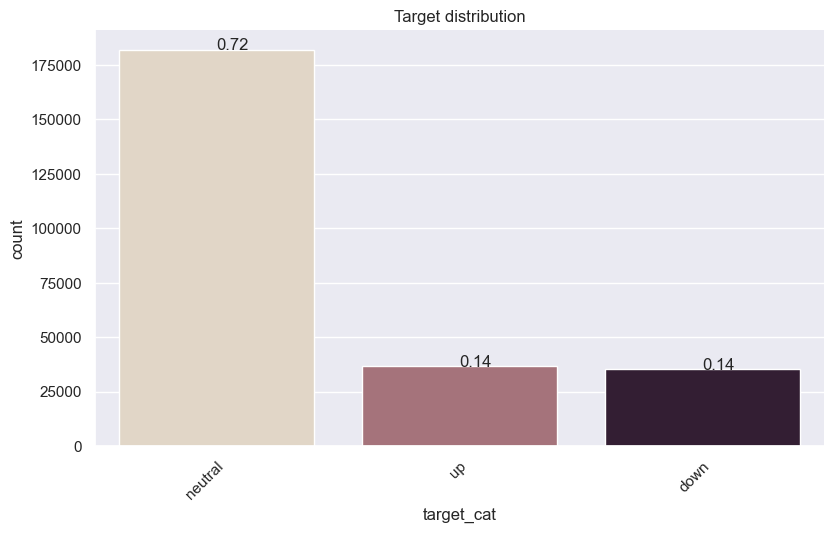

In [142]:
plot_hist_cat("target_cat", df, "Target distribution")

In [143]:
list_level=["neutral", "higher", "very-higher"]
df["max_high_h_ETH_cat"] = "very-higher"
df.loc[df["max_high_h_ETH"] <= 1.01, "max_high_h_ETH_cat"] = "higher"
df.loc[df["max_high_h_ETH"] <= 1.005, "max_high_h_ETH_cat"] = "neutral"

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


max_high_h_ETH_cat
neutral        179399
higher          50855
very-higher     23423
Name: count, dtype: int64

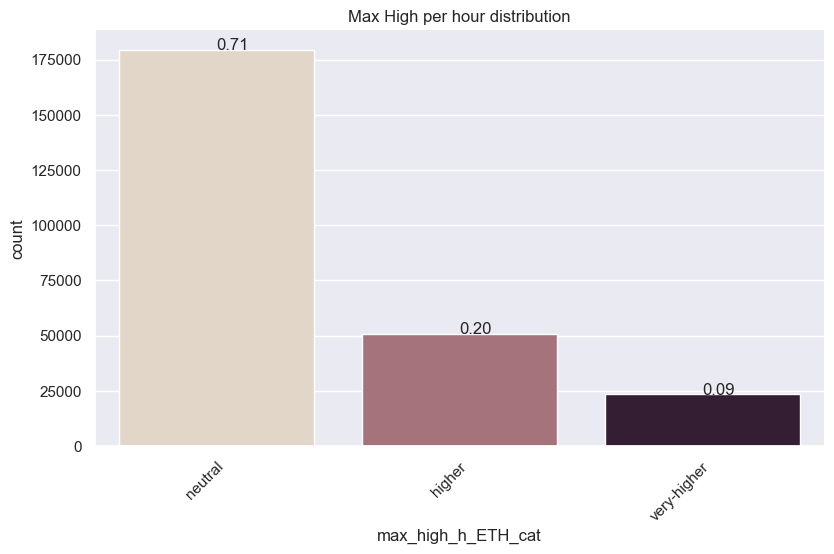

In [144]:
plot_hist_cat("max_high_h_ETH_cat", df, "Max High per hour distribution")

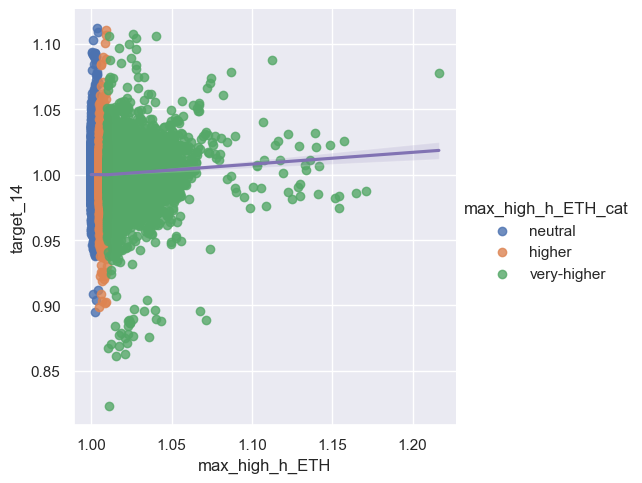

In [145]:
sns.lmplot(x="max_high_h_ETH", y="target_14",
            hue="max_high_h_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

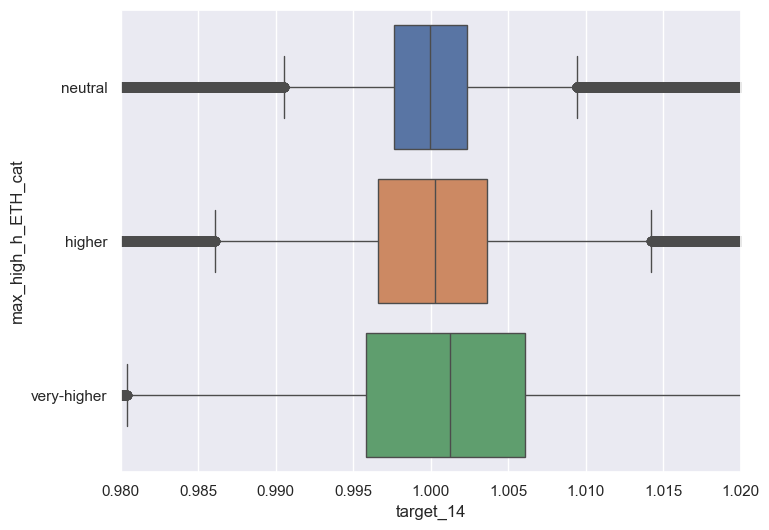

In [146]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="max_high_h_ETH_cat", 
    hue="max_high_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

expected:  [[  7045.36918995  36471.17233726   7338.45847278]
 [ 24853.64639285 128657.78873528  25887.56487186]
 [  3244.98441719  16798.03892745   3379.97665535]]
target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


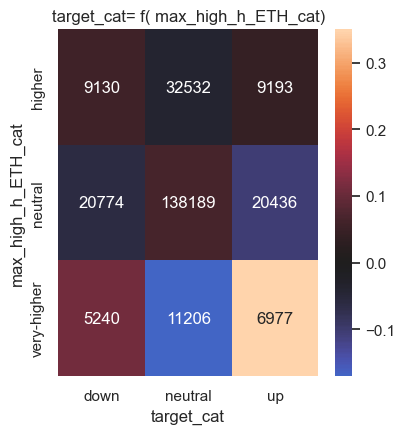

target_cat           down  neutral     up
max_high_h_ETH_cat                       
higher               9130    32532   9193
neutral             20774   138189  20436
very-higher          5240    11206   6977

In [147]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

expected:  [[  7045.36918995  36471.17233726   7338.45847278]
 [ 24853.64639285 128657.78873528  25887.56487186]
 [  3244.98441719  16798.03892745   3379.97665535]]
target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


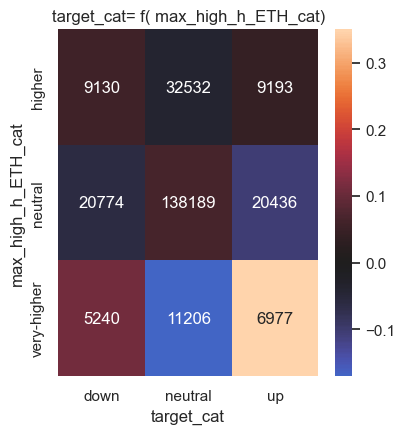

target_cat           down  neutral     up
max_high_h_ETH_cat                       
higher               9130    32532   9193
neutral             20774   138189  20436
very-higher          5240    11206   6977

In [148]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

In [149]:
df["nupl_ETH"].describe()

count    253677.000000
mean          0.118971
std           0.198094
min          -0.775319
25%           0.039797
50%           0.106898
75%           0.260524
max           0.513805
Name: nupl_ETH, dtype: float64

In [150]:

mquantiles(df["nupl_ETH"], prob=[0.10, 0.90])

array([-0.08284051,  0.36014272])

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


nupl_ETH_cat
neutral    168456
higher      69777
lower       15444
Name: count, dtype: int64

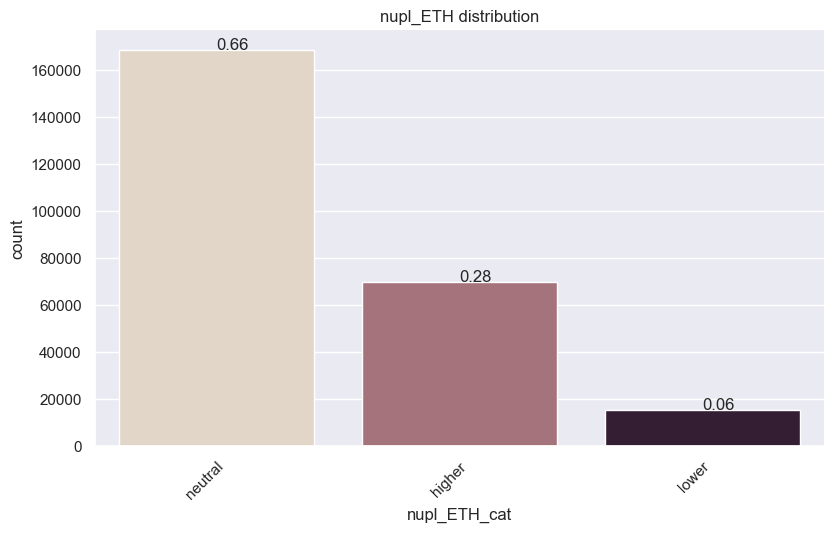

In [151]:

list_level=["lower", "neutral", "higher"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] >= 0.25, "nupl_ETH_cat"] = "higher"
df.loc[df["nupl_ETH"] <= -0.25, "nupl_ETH_cat"] = "lower"
plot_hist_cat("nupl_ETH_cat", df, "nupl_ETH distribution")

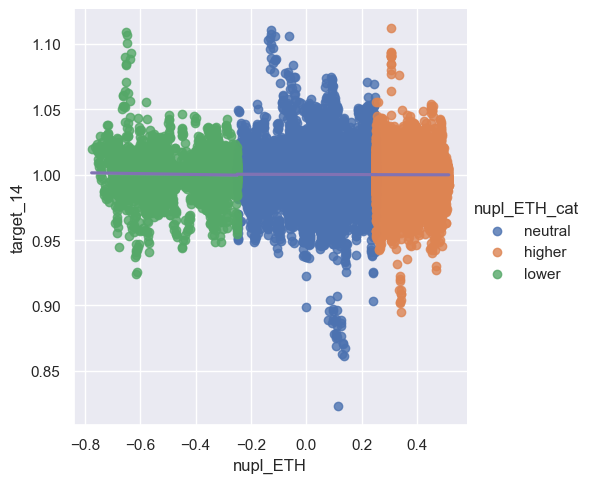

In [152]:
sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

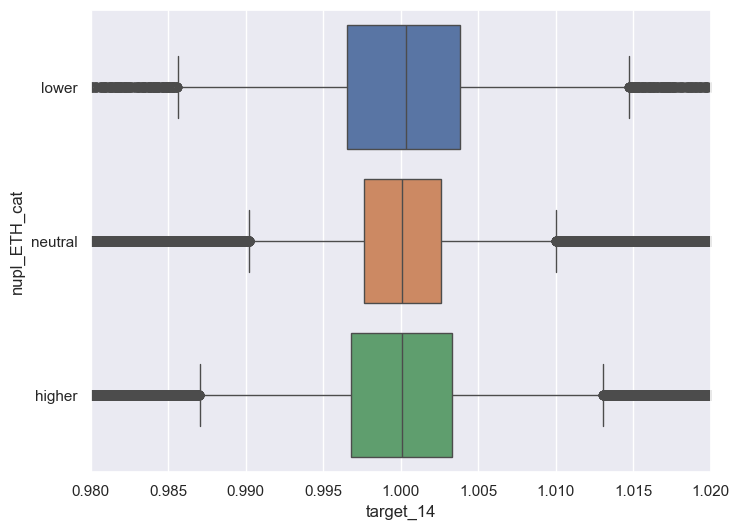

In [153]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

expected:  [[  9666.79236982  50041.27405717  10068.93357301]
 [  2139.58670278  11075.81920316   2228.59409406]
 [ 23337.6209274  120809.90673967  24308.47233293]]
target_cat       down   neutral       up     Total
nupl_ETH_cat                                      
higher        11586.0   46564.0  11627.0   69777.0
lower          2817.0    9702.0   2925.0   15444.0
neutral       20741.0  125661.0  22054.0  168456.0
total         35144.0  181927.0  36606.0  253677.0
xi_n =  2159.047419759374
chi2:  2159.047419759374
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


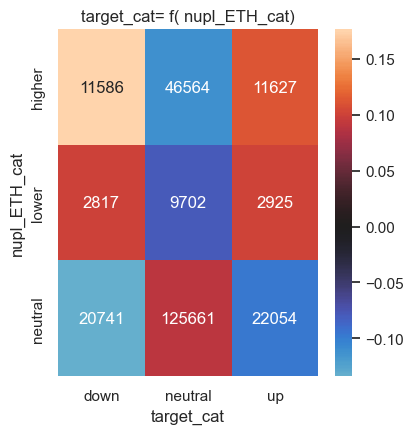

target_cat     down  neutral     up
nupl_ETH_cat                       
higher        11586    46564  11627
lower          2817     9702   2925
neutral       20741   125661  22054

In [154]:
plot_cont(X="nupl_ETH_cat", Y="target_cat", data=df)

In [155]:
chi2 = 2159
indep = 35144.0/253677.0*69777.0
c = 11586
print("chi2: ", chi2)
print("indep: ", indep)
print("c: ", c)
print("chi2 abs part : ", (c-indep)**2/indep)
print("chi2 sign part : ", (c-indep) / np.fabs(c-indep))
print("% of chi2 : ", 100*(c-indep)**2/indep / chi2)


chi2:  2159
indep:  9666.79236982462
c:  11586
chi2 abs part :  381.03207215054994
chi2 sign part :  1.0
% of chi2 :  17.64854433305002


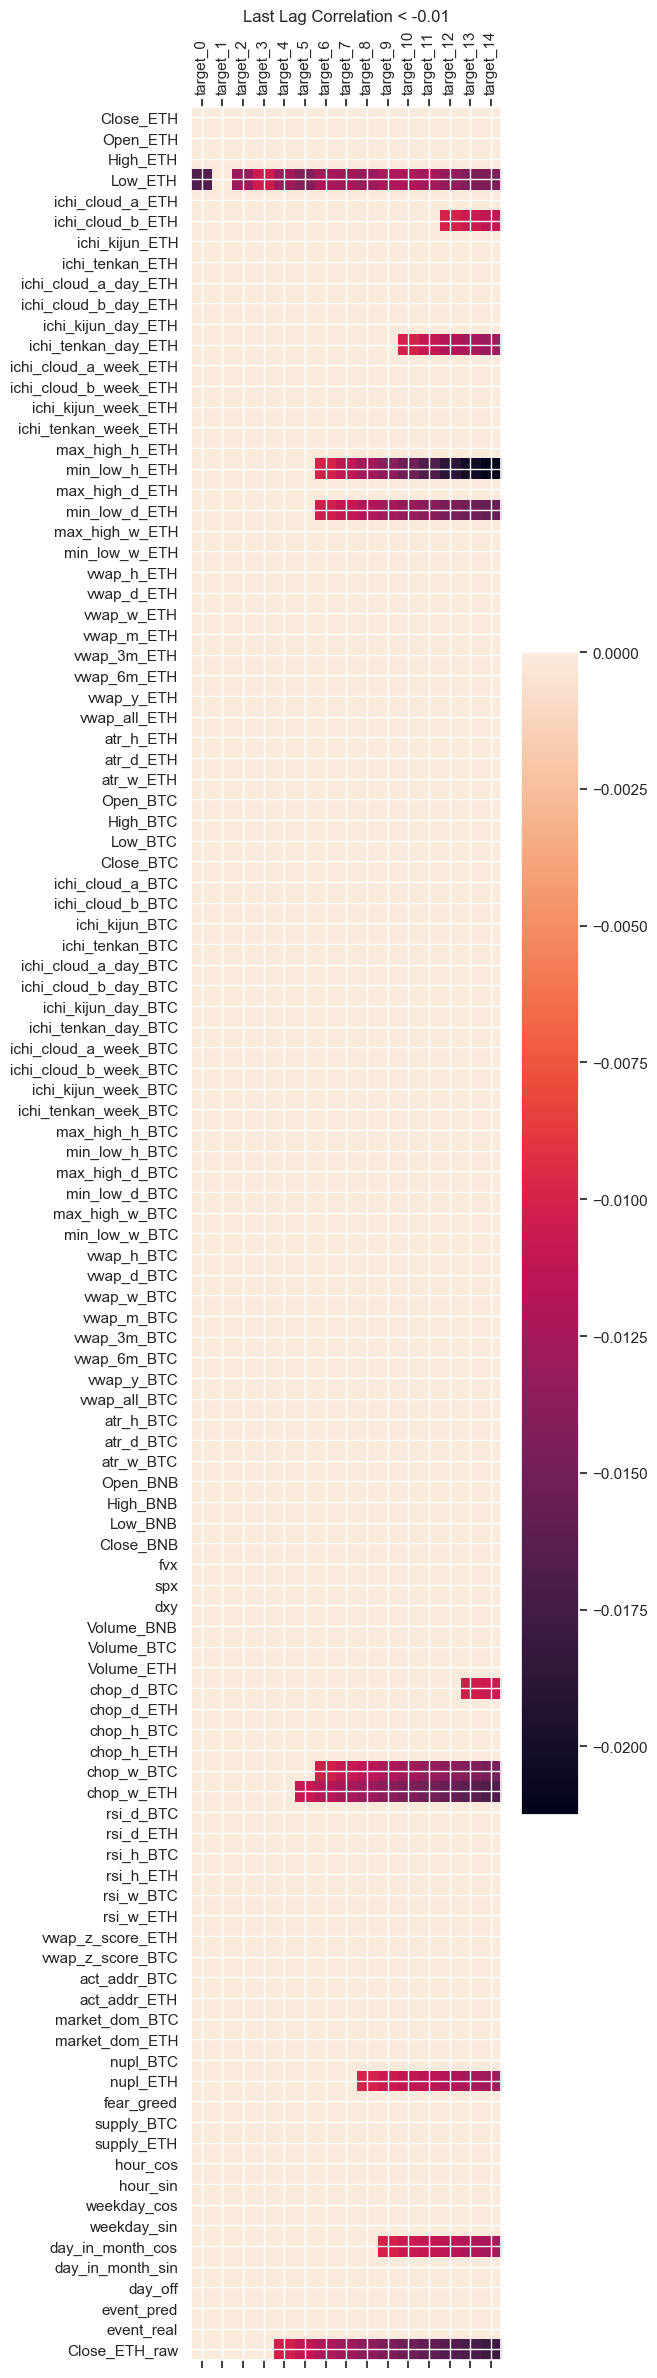

In [156]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.01, 0), 
          title="Last Lag Correlation < -0.01", 
          size=5)

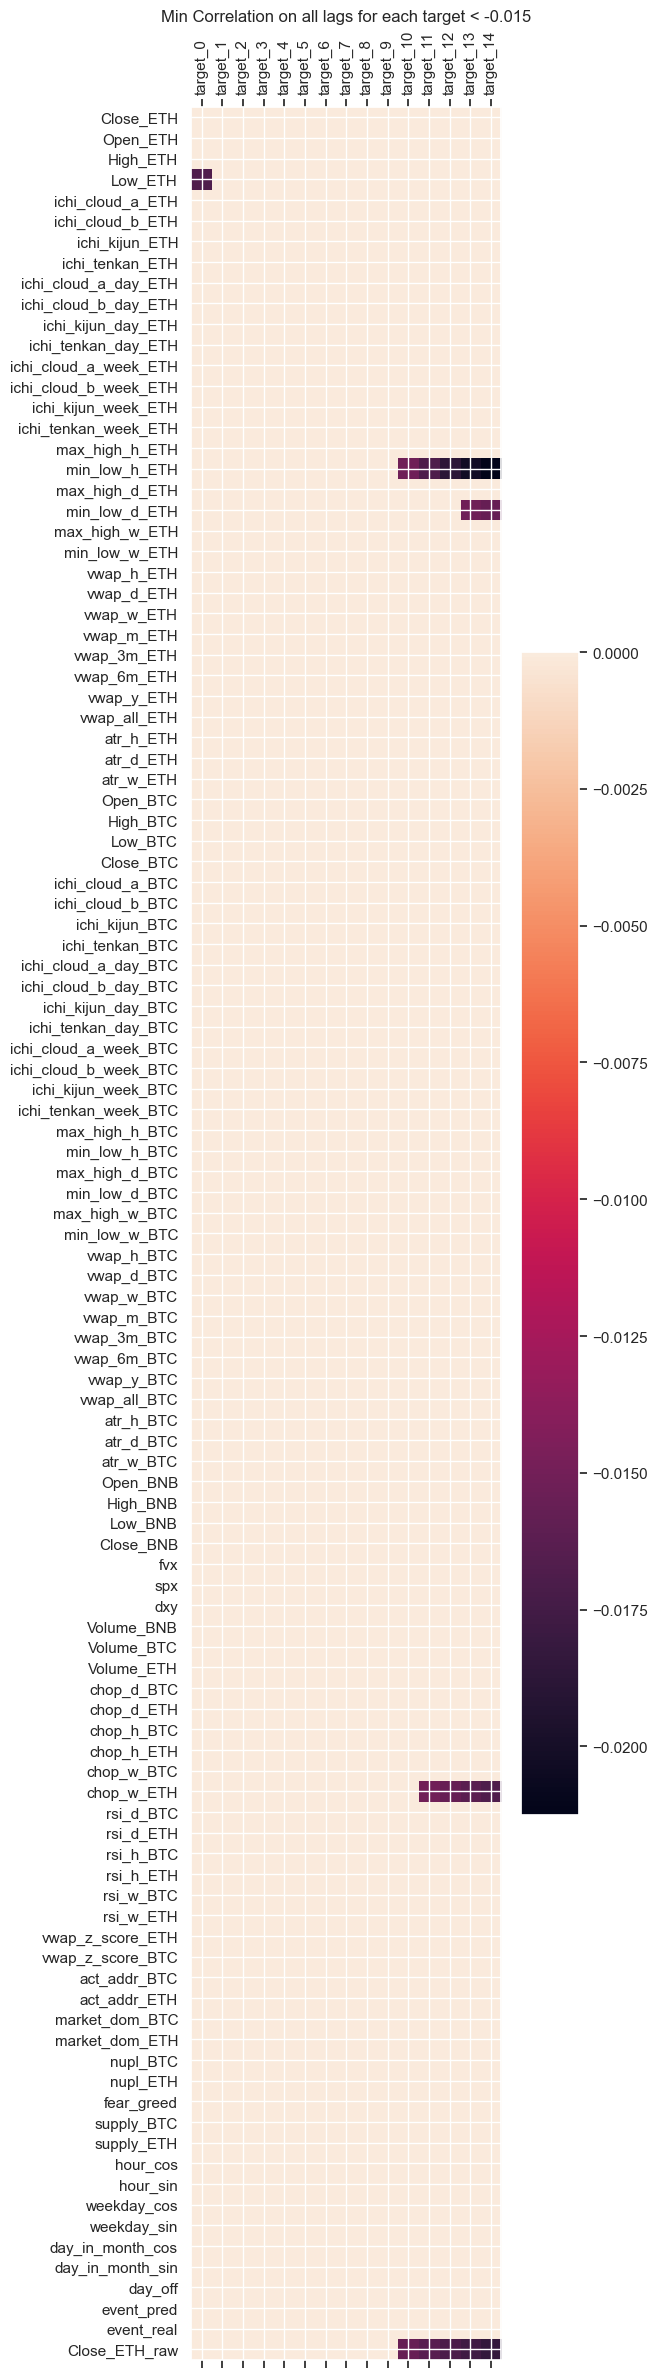

In [157]:
fig = plot_corr(min_corr_matrix_targets.where(min_corr_matrix_targets < -0.015, 0),
                title="Min Correlation on all lags for each target < -0.015",
                size=5)

Text(0, 0.5, 'Min Correlation on all lags for each target < -0.015')

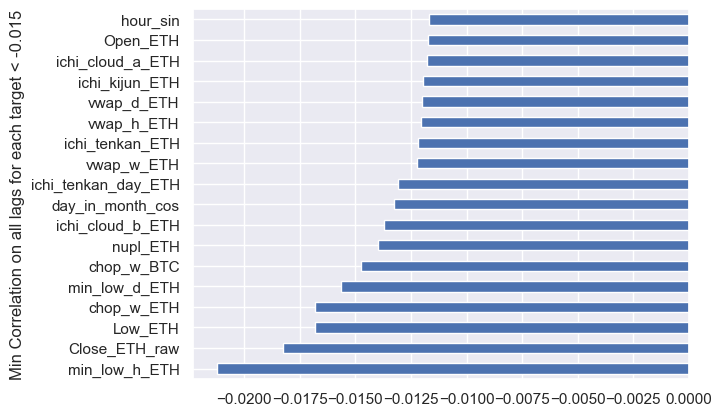

In [158]:
min_min_corr = min_corr_matrix_targets.min(axis=1).sort_values(ascending=True)
min_min_corr[min_min_corr.values<-0.011].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_ylabel("Min Correlation on all lags for each target < -0.015")

<Axes: >

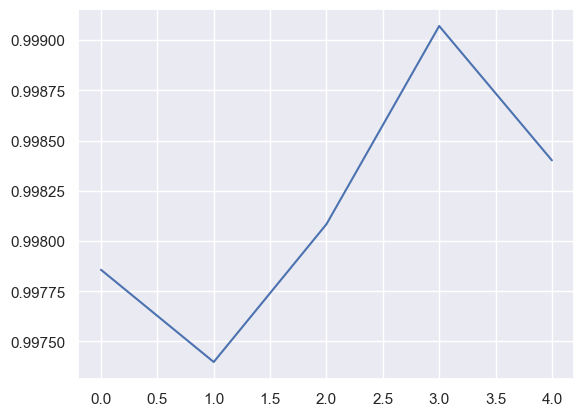

In [159]:
df["min_low_h_ETH"].head().plot()

In [160]:
df["min_low_h_ETH"].describe()

count    253677.000000
mean          0.995225
std           0.005330
min           0.847357
25%           0.993900
50%           0.996677
75%           0.998391
max           1.000000
Name: min_low_h_ETH, dtype: float64

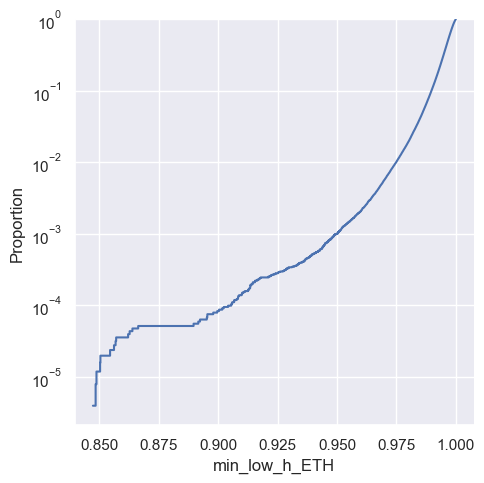

In [161]:
sns.displot(df, x="min_low_h_ETH", kind="ecdf", log_scale=(False, True))

In [162]:
list_level=["very_low", "low", "neutral"]
df["min_low_h_ETH_cat"] = "low"
df.loc[df["min_low_h_ETH"] < 0.995, "min_low_h_ETH_cat"] = "very_low"
df.loc[df["min_low_h_ETH"] > 0.998, "min_low_h_ETH_cat"] = "neutral"
df["min_low_h_ETH_cat"].value_counts()

min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

Text(0.5, 1.0, 'Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)')

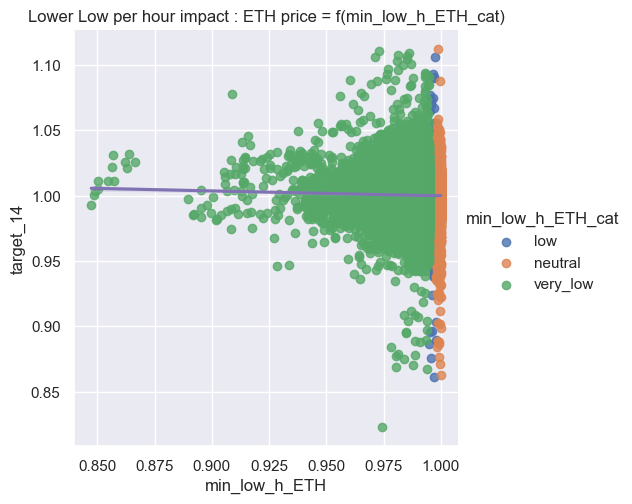

In [163]:
sns.lmplot(x="min_low_h_ETH", y="target_14", hue="min_low_h_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)")

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

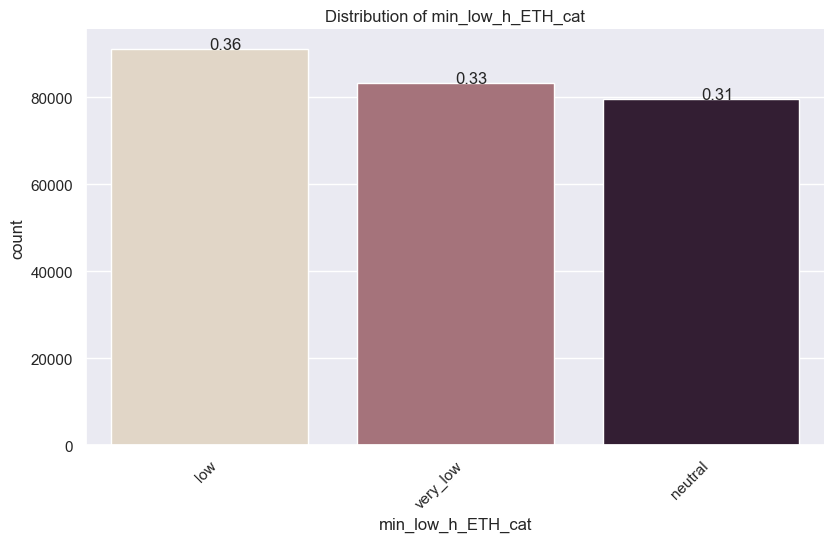

In [164]:

plot_hist_cat(x="min_low_h_ETH_cat", data=df, title="Distribution of min_low_h_ETH_cat")

expected:  [[12608.93189371 65271.60120153 13133.46690476]
 [11010.89170875 56999.16047967 11468.94781159]
 [11524.17639754 59656.23831881 12003.58528365]]
target_cat            down   neutral       up     Total
min_low_h_ETH_cat                                      
low                11509.0   67574.0  11931.0   91014.0
neutral             7582.0   63940.0   7957.0   79479.0
very_low           16053.0   50413.0  16718.0   83184.0
total              35144.0  181927.0  36606.0  253677.0
xi_n =  8339.15806994498
chi2:  8339.15806994498
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


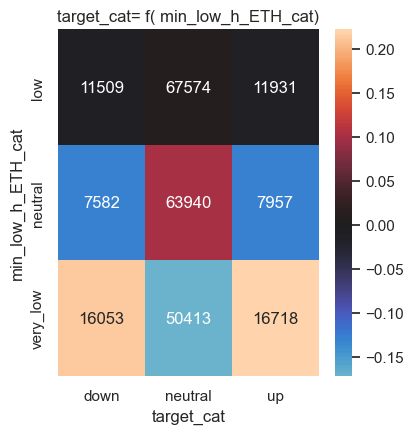

target_cat          down  neutral     up
min_low_h_ETH_cat                       
low                11509    67574  11931
neutral             7582    63940   7957
very_low           16053    50413  16718

In [165]:
plot_cont(X="min_low_h_ETH_cat", Y="target_cat", data=df)

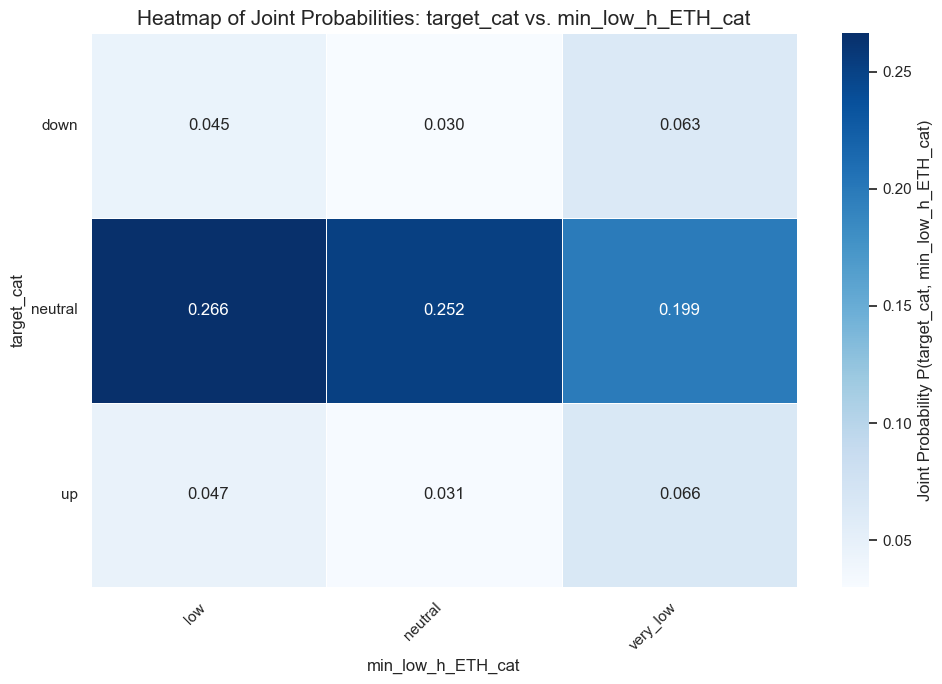

Joint Probability Table:
min_low_h_ETH_cat       low   neutral  very_low
target_cat                                     
down               0.045369  0.029888  0.063281
neutral            0.266378  0.252053  0.198729
up                 0.047032  0.031367  0.065903


In [166]:
probability_table = pd.crosstab(df['target_cat'], df['min_low_h_ETH_cat'], normalize=True)
# 2. Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    probability_table,
    annot=True,        # Show the probability values on the heatmap cells
    fmt=".3f",         # Format annotations to 3 decimal places
    cmap="Blues",      # Colormap (e.g., "Blues", "YlGnBu", "viridis")
    linewidths=.5,     # Add lines between cells for better separation
    cbar_kws={'label': 'Joint Probability P(target_cat, min_low_h_ETH_cat)'} # Label for the color bar
)

plt.title('Heatmap of Joint Probabilities: target_cat vs. min_low_h_ETH_cat', fontsize=15)
plt.ylabel('target_cat', fontsize=12)
plt.xlabel('min_low_h_ETH_cat', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability if long
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Display the probability table (optional)
print("Joint Probability Table:")
print(probability_table)

In [167]:
probability_table.sum().sum()

np.float64(1.0)

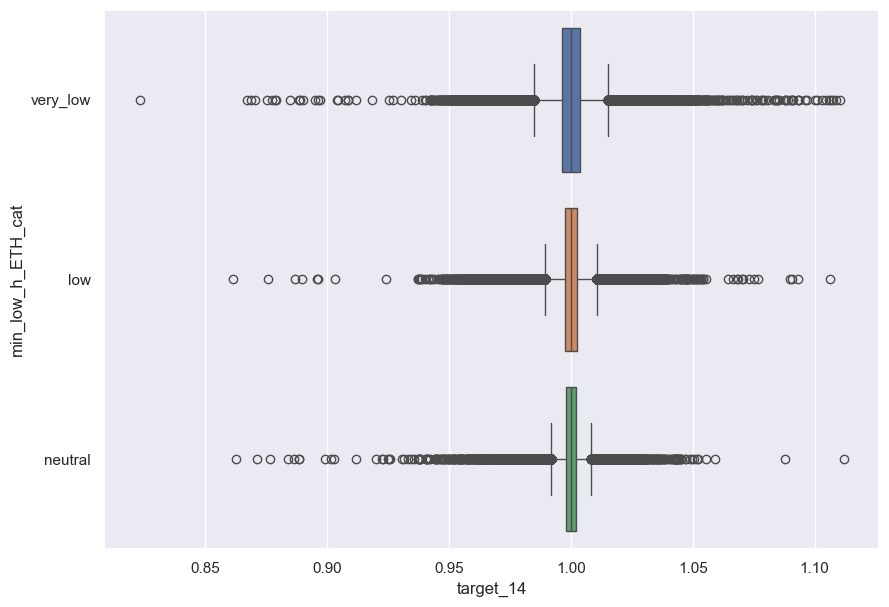

In [168]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="min_low_h_ETH_cat", 
    hue="min_low_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
#ax.set_xlim([0.98,1.02])

In [169]:
df["target_14"].describe()

count    253677.000000
mean          1.000070
std           0.007196
min           0.823072
25%           0.997361
50%           1.000089
75%           1.002851
max           1.112129
Name: target_14, dtype: float64

In [170]:
df["target_1"].describe()

count    253677.000000
mean          1.000009
std           0.002652
min           0.907143
25%           0.998967
50%           1.000013
75%           1.001066
max           1.081058
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

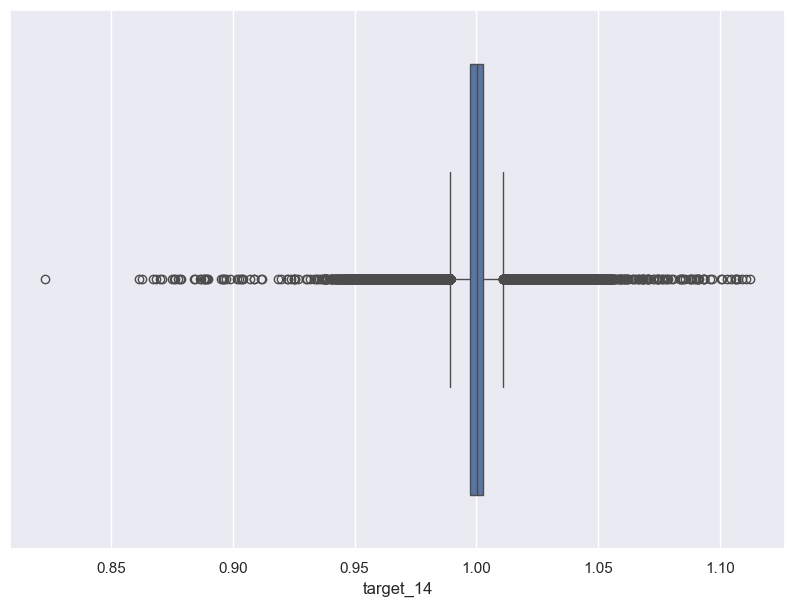

In [171]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

(0.98, 1.02)

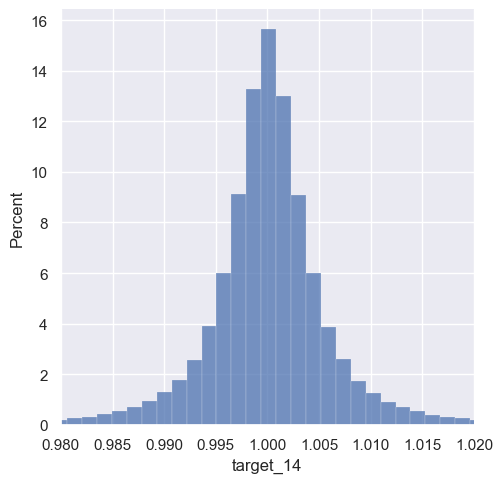

In [172]:
sns.displot(df, x="target_14", kind="hist", stat="percent", bins=200)
ax = plt.gca()
ax.set_xlim([0.98,1.02])

## Target cat by levels
Example :

To classify Targets we can say that : if we have : 
- a capital 10000$  
- leverage x10 maxi
- SL = -50$ / TP = 100$ / R = 2
- and we want to have 100$ of profit per days
- so:  0.1% up or down can be enough for target

We can use a level of >= 0.1% => "high" , <=-0.1% "low", otherwise "neutral"  

- BE CAREFUL : Hyperliquid for example can take 25% of trade if 0.1% is a trigger : 
  - maker fees : 0.015% (if trade out of orderbook (usually when limit order)
  - or taker fees : 0.038% (if market order)
  - funding 1h : 0.0014% ( funding rate will be positive, and the long position will pay the short position.)
  - TOTAL max 2 takers trades (open/close) + funding 1h max :  0.0774% => 77% of 0.1% !

In [173]:
target_level = 0.1/100

In [174]:
y_train.shape

(253677, 15)

In [175]:
y_train.max(axis=1) >= 1+target_level

array([False, False, False, ...,  True,  True,  True], shape=(253677,))

In [176]:
y_train.min(axis=1) <= 1-target_level

array([False,  True,  True, ...,  True,  True, False], shape=(253677,))

Not used anymore :  the last target value : 

In [177]:
Y = "target_last_cat"
df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
df_targets.loc[y_train[:,-1] >= 1+target_level, Y] = "high"
df_targets.loc[y_train[:,-1] <= 1-target_level, Y] = "low"
df_targets[Y].value_counts()

target_last_cat
high       102187
low         97441
neutral     54049
Name: count, dtype: int64

In [178]:
df_targets["target_last_cat"].value_counts()/df_targets.shape[0]

target_last_cat
high       0.402823
low        0.384114
neutral    0.213062
Name: count, dtype: float64

In [179]:
df_targets["target_14"].describe()

count    253677.000000
mean          1.000070
std           0.007196
min           0.823072
25%           0.997361
50%           1.000089
75%           1.002851
max           1.112129
Name: target_14, dtype: float64

In [180]:
df_targets["max_target"] = y_train.max(axis=1)
df_targets["min_target"] = y_train.min(axis=1)
df_targets

target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0       1.000460  1.000385  0.999623  1.000293  0.999816  1.000050  0.999498   
1       0.999925  0.999163  0.999833  0.999356  0.999590  0.999038  0.999046   
2       0.999238  0.999908  0.999431  0.999665  0.999113  0.999121  0.999473   
3       1.000670  1.000193  1.000427  0.999874  0.999883  1.000234  1.000301   
4       0.999523  0.999757  0.999205  0.999213  0.999565  0.999632  0.999565   
...          ...       ...       ...       ...       ...       ...       ...   
253672  1.001448  0.996564  0.995402  0.983481  0.990876  0.990951  0.988297   
253673  0.995124  0.993963  0.982059  0.989443  0.989518  0.986868  0.986836   
253674  0.998834  0.986871  0.994292  0.994367  0.991704  0.991672  0.992440   
253675  0.988024  0.995453  0.995528  0.992862  0.992830  0.993599  0.991049   
253676  1.007519  1.007596  1.004897  1.004865  1.005643  1.003062  1.010629   

        target_7  target_8  target_9  target_10  target_11  target_12  \
0       0.999506  0.999858  0.999925   0.999858   1.000226   0.999891   
1       0.999398  0.999464  0.999398   0.999766   0.999431   0.999690   
2       0.999540  0.999473  0.999841   0.999506   0.999766   0.999473   
3       1.000234  1.000603  1.000268   1.000528   1.000234   0.999640   
4       0.999933  0.999598  0.999858   0.999565   0.998971   0.998686   
...          ...       ...       ...        ...        ...        ...   
253672  0.988265  0.989031  0.986492   0.993934   0.995977   0.997667   
253673  0.987601  0.985066  0.992497   0.994537   0.996225   0.993384   
253674  0.989893  0.997361  0.999411   1.001107   0.998252   0.997170   
253675  0.998525  1.000578  1.002276   0.999418   0.998334   0.994448   
253676  1.012706  1.014425  1.011533   1.010435   1.006502   1.009294   

        target_13  target_14 target_last_cat  max_target  min_target  
0        1.000151   0.999858         neutral    1.000460    0.999498  
1        0.999398   0.998803             low    0.999925    0.998803  
2        0.998879   0.998594             low    0.999908    0.998594  
3        0.999355   1.000427         neutral    1.000670    0.999355  
4        0.999757   0.999732         neutral    0.999933    0.998686  
...           ...        ...             ...         ...         ...  
253672   0.994823   0.993744             low    1.001448    0.983481  
253673   0.992307   0.988445             low    0.996225    0.982059  
253674   0.993288   0.996043             low    1.001107    0.986871  
253675   0.997206   0.995803             low    1.002276    0.988024  
253676   1.007874   1.007934            high    1.014425    1.003062  

[253677 rows x 18 columns]

Very important : we can see that the last target is not the best to use as a target,   
because it is not well distributed,   
so we will use the max and min, of all the targets, to create a new target   
But we take the first to appear above min/max threshold : +/-0.1%  
Example : 
- if the max is above 1.001 before min is below 0.999, then we will use the max as the target
- if the min is below 0.999 before max is above 1.001, then we will use the min as the target
- if none of them are above/below 1.001/0.999, then we will use the neutral target
  
##### First Strategy :  TP = SL

In [181]:
Y = "target_cat"
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : 
b_low = ((y_train.min(axis=1) <= 1-target_level) & (
    (y_train.argmin(axis=1) < y_train.argmax(axis=1)) |
    ((y_train.argmin(axis=1) > y_train.argmax(axis=1)) & (y_train.max(axis=1) < 1+target_level))
    )
)
df_targets.loc[b_low, Y] = "low"
# high cat
b_high = ((y_train.max(axis=1) >= 1+target_level)& (
    (y_train.argmax(axis=1) < y_train.argmin(axis=1)) |
    ((y_train.argmax(axis=1) > y_train.argmin(axis=1)) & (y_train.min(axis=1) > 1-target_level))
    )
)
df_targets.loc[b_high, Y] = "high"

df_targets[Y].value_counts()

target_cat
high       125295
low        123574
neutral      4808
Name: count, dtype: int64

In [182]:
df_targets[Y].value_counts()/df_targets.shape[0]

target_cat
high       0.493915
low        0.487131
neutral    0.018953
Name: count, dtype: float64

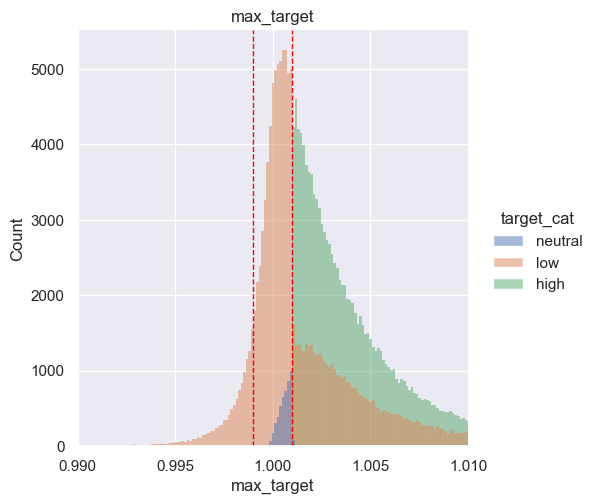

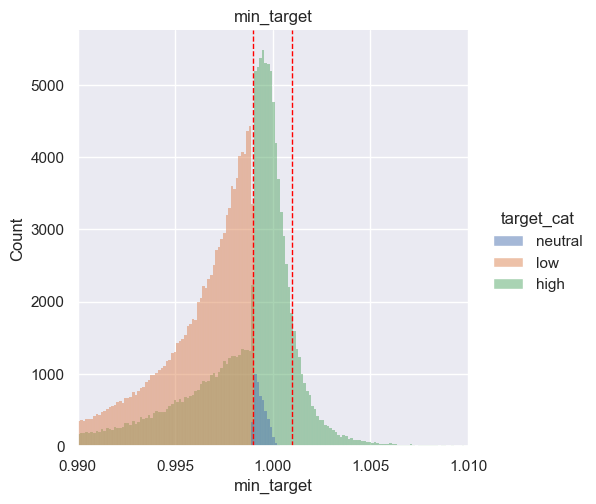

In [183]:
sns.displot(df_targets, x="max_target", hue="target_cat", kind="hist")
ax = plt.gca()
ax.set_xlim([0.99,1.01])
ax.set_title("max_target")
# add vertical lines at 1+target_level and 1-target_level
ax.axvline(1+target_level, color='red', linestyle='dashed', linewidth=1)
ax.axvline(1-target_level, color='red', linestyle='dashed', linewidth=1)

sns.displot(df_targets, x="min_target", hue="target_cat", kind="hist")
ax = plt.gca()
ax.set_xlim([0.99,1.01])
ax.set_title("min_target")
# add vertical lines at 1+target_level and 1-target_level
ax.axvline(1+target_level, color='red', linestyle='dashed', linewidth=1)
ax.axvline(1-target_level, color='red', linestyle='dashed', linewidth=1)

Here : complex graph : 
- If Neutral cat., min or max stay into thresholds.  
- if High cat., min value is around 1
- If Low cat., max value is 1.0005 (1-0.05%) (half the threshold 0.1%)


##### 2eme Strat : TP/SL = 2


In [184]:
Y = "target_cat_2"
target_level =  0.1/100
R = 2
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : if :
#   - low SHORT TP touched AND high SHORT SL IS NOT  reached during timerange
#   - OR low SHORT TP touched AND high SHORT SL IS reached during timerange but AFTER TP
b_low_old =(
    ((y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) < 1+target_level/R)) |
    (
        (y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) >= 1+target_level/R) &
        (np.argmax((y_train <= 1-target_level), axis=1) < np.argmax(y_train >= 1+target_level/R, axis=1))
    ) 
)
df_targets.loc[b_low_old, Y] = "low"
# high cat : if 
#   - high LONG TP touched AND low LONG SL IS NOT reached during timerange
#   - OR high LONG TP touched AND low LONG SL IS reached during timerange but AFTER TP
b_high_old = (
    ((y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) > 1-target_level/R)) |
    (
        (y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_train >= 1+target_level), axis=1) < np.argmax(y_train <= 1-target_level/R, axis=1))
    )
)

df_targets.loc[b_high_old, Y] = "high"

# check 
val_count = df_targets[Y].value_counts()
print(val_count)
assert val_count["high"] == np.sum(b_high_old)
assert val_count["low"] == np.sum(b_low_old)
#
print(f"trade high : {100*np.sum(b_high_old)/df_targets.shape[0]:.2f}%")
print(f"trade low : {100*np.sum(b_low_old)/df_targets.shape[0]:.2f}%")
print(f"trade neutral : {100*(df_targets.shape[0]-np.sum(b_high_old)-np.sum(b_low_old))/df_targets.shape[0]:.2f}%")


target_cat_2
high       107671
low        105473
neutral     40533
Name: count, dtype: int64
trade high : 42.44%
trade low : 41.58%
trade neutral : 15.98%


In [185]:
print(f"max nb trades high per day: {np.sum(b_high_old) / (df_targets.shape[0]) * (24*60/5):.2f}")
print(f"{100/target_level:.2f}$ trading size per trade")
print('with 10000$ as collateral, you need a leverage x{:.1f} to have 100$ per trade'.format(100/target_level/10000))

max nb trades high per day: 122.24
100000.00$ trading size per trade
with 10000$ as collateral, you need a leverage x10.0 to have 100$ per trade


target_cat
high       107671
low        105473
neutral     40533
Name: count, dtype: int64
trade high : 42.44%
trade low : 41.58%
trade neutral : 15.98%

##### 2nd Strat fixed TP/SL=2

In [186]:
Y = "target_cat_2f"
target_level =  0.1/100
R = 2
df_targets[Y] = "neutral"
# low cat : if :
#   - low SHORT TP touched AND high SHORT SL IS NOT reached during timerange
#   - OR low SHORT TP touched AND high SHORT SL IS reached during timerange but AFTER TP
b_low =(
    ((y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) < 1+target_level/R)) |
    (
        (y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) >= 1+target_level/R) &
        (np.argmax((y_low_train <= 1-target_level), axis=1) < np.argmax(y_high_train >= 1+target_level/R, axis=1))
    ) 
)
df_targets.loc[b_low, Y] = "low"
# high cat : if 
#   - high LONG TP touched AND low LONG SL IS NOT reached during timerange
#   - OR high LONG TP touched AND low LONG SL IS reached during timerange but AFTER TP
b_high = (
    ((y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) > 1-target_level/R)) |
    (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) < np.argmax(y_low_train <= 1-target_level/R, axis=1))
    )
)
df_targets.loc[b_high, Y] = "high"

# if low and high at the same time, then it s neutral
nb_dual = np.sum(b_high & b_low)
if nb_dual > 0:
    print("nb cases high and low at same time: ", nb_dual)
    df_targets.loc[np.logical_not(b_high ^ b_low), Y] = "neutral"
else:
    print('highs and lows are distinct')
# check 
val_count = df_targets[Y].value_counts()
print(val_count)
assert val_count["high"] == np.sum(b_high)
assert val_count["low"] == np.sum(b_low)
#
print(f"trade high : {100*np.sum(b_high)/df_targets.shape[0]:.2f}%")
print(f"trade low : {100*np.sum(b_low)/df_targets.shape[0]:.2f}%")
print(f"trade neutral : {100*(df_targets.shape[0]-np.sum(b_high)-np.sum(b_low))/df_targets.shape[0]:.2f}%")

# target_cat_fixed : if high low not distinct
# neutral    102593
# low         75873
# high        75211


highs and lows are distinct
target_cat_2f
neutral    102593
low         75873
high        75211
Name: count, dtype: int64
trade high : 29.65%
trade low : 29.91%
trade neutral : 40.44%


In [187]:
print(f"max nb trades high per day: {np.sum(b_high) / (df_targets.shape[0]) * (24*60/5):.2f}")
print(f"{100/target_level:.2f}$ trading size per trade")
print('with 10000$ as collateral, you need a leverage x{:.1f} to have 100$ per trade'.format(100/target_level/10000))

max nb trades high per day: 85.39
100000.00$ trading size per trade
with 10000$ as collateral, you need a leverage x10.0 to have 100$ per trade


In [188]:
# check strat 2 high became low
b_not_high_to_high = np.logical_not(b_high_old) & b_high
print(f"nb new strat 2 fixed compare to strat 2 : {np.sum(b_not_high_to_high)}")
print(f"% high strat 2 converted in low strat 2 fixed : {100*np.sum(b_not_high_to_high) / df_targets.shape[0]:.2f} %")
b_high_to_low = b_high_old & b_low
print(f"nb high strat 2 converted in low strat 2 fixed : {np.sum(b_high_to_low)}")
print(f"% high strat 2 converted in low strat 2 fixed : {100*np.sum(b_high_to_low) / df_targets.shape[0]:.2f} %")
b_high_to_neutral = b_high_old & (np.logical_not(b_low) & np.logical_not(b_high))
print(f"nb high strat 2 converted in neutral strat 2 fixed : {np.sum(b_high_to_neutral)}")
print(f"% high strat 2 converted in low neutral 2 fixed : {100*np.sum(b_high_to_neutral) / df_targets.shape[0]:.2f} %")


nb new strat 2 fixed compare to strat 2 : 11180
% high strat 2 converted in low strat 2 fixed : 4.41 %
nb high strat 2 converted in low strat 2 fixed : 3629
% high strat 2 converted in low strat 2 fixed : 1.43 %
nb high strat 2 converted in neutral strat 2 fixed : 40011
% high strat 2 converted in low neutral 2 fixed : 15.77 %


In [189]:
b_high_sl_same_time = (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) == np.argmax(y_low_train <= 1-target_level/R, axis=1))
    )
print(f"in strat 2 fixed, TP & SL touched at same time : {np.sum(b_high_sl_same_time)}")
print(f" {100*np.sum(b_high_sl_same_time) / df_targets.shape[0]:.2f} %")

in strat 2 fixed, TP & SL touched at same time : 42845
 16.89 %


In [190]:
b_high_just_after_SL = (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) == np.argmax(y_low_train <= 1-target_level/R, axis=1) + 1)
    )
print(f"in strat 2 fixed, TP touched just after SL : {np.sum(b_high_just_after_SL)}")
print(f" {100*np.sum(b_high_just_after_SL) / df_targets.shape[0]:.2f} %")
b_high_just_before_SL = (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) == np.argmax(y_low_train <= 1-target_level/R, axis=1) - 1)
    )
print(f"in strat 2 fixed, TP touched just before SL : {np.sum(b_high_just_before_SL)}")
print(f" {100*np.sum(b_high_just_before_SL) / df_targets.shape[0]:.2f} %")

in strat 2 fixed, TP touched just after SL : 21194
 8.35 %
in strat 2 fixed, TP touched just before SL : 12340
 4.86 %


In [191]:
# % of same time TP & SL  with SL before :
print("approximation of nb of same times TP & SL with SL before :")
print(np.sum(b_high_sl_same_time) * np.sum(b_high_just_after_SL) / (np.sum(b_high_just_after_SL) + np.sum(b_high_just_before_SL)))
print(f"% of all TP/SP same time: {100*np.sum(b_high_sl_same_time) * np.sum(b_high_just_after_SL) / (np.sum(b_high_just_after_SL) + np.sum(b_high_just_before_SL)) / np.sum(b_high_sl_same_time):.2f} %" )


approximation of nb of same times TP & SL with SL before :
27078.694161149877
% of all TP/SP same time: 63.20 %


##### 3rd Strat R=2, TP_r=0.45%

In [192]:
Y = "target_cat"
target_level = 0.0045
R = 2
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : if :
#   - low SHORT TP touched AND high SHORT SL IS NOT reached during timerange
#   - OR low SHORT TP touched AND high SHORT SL IS reached during timerange but AFTER TP
b_low = (
    ((y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) < 1+target_level/R)) |
    (
        (y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) >= 1+target_level/R) &
        (np.argmax((y_low_train <= 1-target_level), axis=1) < np.argmax(y_high_train >= 1+target_level/R, axis=1))
    ) 
)
df_targets.loc[b_low, Y] = "low"
# high cat : if 
#   - high LONG TP touched AND low LONG SL IS NOT reached during timerange
#   - OR high LONG TP touched AND low LONG SL IS reached during timerange but AFTER TP
b_high = (
    ((y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) > 1-target_level/R)) |
    (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) < np.argmax(y_low_train <= 1-target_level/R, axis=1))
    )
)
df_targets.loc[b_high, Y] = "high"

# if low and high at the same time, then it s neutral
nb_dual = np.sum(b_high & b_low)
if nb_dual > 0:
    print("nb cases high and low at same time: ", nb_dual)
    df_targets.loc[np.logical_not(b_high ^ b_low), Y] = "neutral"
else:
    print('highs and lows are distinct')
# check 
val_count = df_targets[Y].value_counts()
print(val_count)
assert val_count["high"] == np.sum(b_high)
assert val_count["low"] == np.sum(b_low)
#
print(f"trade high : {100*np.sum(b_high)/df_targets.shape[0]:.2f}%")
print(f"trade low : {100*np.sum(b_low)/df_targets.shape[0]:.2f}%")
print(f"trade neutral : {100*(df_targets.shape[0]-np.sum(b_high)-np.sum(b_low))/df_targets.shape[0]:.2f}%")

highs and lows are distinct
target_cat
neutral    128870
low         63200
high        61607
Name: count, dtype: int64
trade high : 24.29%
trade low : 24.91%
trade neutral : 50.80%


In [193]:
b_high_sl_same_time = (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) == np.argmax(y_low_train <= 1-target_level/R, axis=1))
    )
print(f"in these strat., TP & SL touched at same time : {np.sum(b_high_sl_same_time)}")
print(f" {100*np.sum(b_high_sl_same_time) / df_targets.shape[0]:.2f} %")

in these strat., TP & SL touched at same time : 1137
 0.45 %


In [194]:
b_high_sl_before = (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) > np.argmax(y_low_train <= 1-target_level/R, axis=1))
)
print(f"nb TP touched: {np.sum((y_high_train.max(axis=1) >= 1+target_level))}")
print(f"in these strat., SL touched before TP:\n nb: {np.sum(b_high_sl_before)}")
print(f" {100*np.sum(b_high_sl_before) / df_targets.shape[0]:.2f} % of total")
print(f" {100*np.sum(b_high_sl_before) / np.sum((y_high_train.max(axis=1) >= 1+target_level)):.2f} % of TP touched")

nb TP touched: 88250
in these strat., SL touched before TP:
 nb: 25506
 10.05 % of total
 28.90 % of TP touched


nb High <=> nb TP touched - nb SL touched before TP - nb TP & SL at the same time : 

In [195]:
np.sum((y_high_train.max(axis=1) >= 1+target_level))

np.int64(88250)

In [196]:
np.sum(b_high_sl_same_time)

np.int64(1137)

In [197]:
np.sum(b_high_sl_before)

np.int64(25506)

In [198]:
# nb TP touched - nb SL touched before TP - nb TP & SL at the same time = nb High Winning Trade
#88250-25506-1137
assert np.sum(b_high) == (
    np.sum((y_high_train.max(axis=1) >= 1+target_level)) 
    - np.sum(b_high_sl_before) 
    - np.sum(b_high_sl_same_time)
)

In [199]:
# if LONG but SL touched <=> False Positive High trade : 
# True cat == "neutral" and SL touched 
b_high_false_pos_sl_touched = np.logical_not(b_high ^ b_low) & (y_low_train.min(axis=1) <= 1-target_level/R)
print(f"in case of High trading but Neutral cat & SL touched <=> Lost trade:")
print(f"<=> in case of False positive High Trade & SL touched:\n nb: {np.sum(b_high_false_pos_sl_touched)}")

print(f"% of neutral: {100*np.sum(b_high_false_pos_sl_touched)/sum(np.logical_not(b_high ^ b_low)):.2f} %")
print(f"% of Total: {100*np.sum(b_high_false_pos_sl_touched)/df_targets.shape[0]:.2f} %")

in case of High trading but Neutral cat & SL touched <=> Lost trade:
<=> in case of False positive High Trade & SL touched:
 nb: 75508
% of neutral: 58.59 %
% of Total: 29.77 %


In [200]:
# if LONG but TP & SL not touched <=> False Positive High trade <=> Real neutral trade
# True cat == "neutral" and TP or SL not touched
b_high_false_pos_neutral = (np.logical_not(b_high ^ b_low) & 
                            (y_low_train.min(axis=1) > 1-target_level/R) 
                            & (y_high_train.max(axis=1) < 1+target_level))
print(f"in these strat., in case of False positive High Trade but TP or SL not touched:\n nb: {np.sum(b_high_false_pos_neutral)}")
print(f"% of neutral: {100*np.sum(b_high_false_pos_neutral)/sum(np.logical_not(b_high ^ b_low)):.2f} %")
print(f"% of Total: {100*np.sum(b_high_false_pos_neutral)/df_targets.shape[0]:.2f} %")

in these strat., in case of False positive High Trade but TP or SL not touched:
 nb: 53362
% of neutral: 41.41 %
% of Total: 21.04 %


In [201]:
print(f"max nb trades high per day: {np.sum(b_high) / (df_targets.shape[0]) * (24*60/5):.2f}")
print(f"{100/target_level:.2f}$ trading size per trade")
print('with 10000$ as collateral, you need a leverage x{:.1f} to have 100$ per trade'.format(100/target_level/10000))

max nb trades high per day: 69.94
22222.22$ trading size per trade
with 10000$ as collateral, you need a leverage x2.2 to have 100$ per trade


##### 4th Strat R=2.5, TP_r=0.33%

In [202]:
Y = "target_cat_4"
target_level = 0.33/100
R = 2.5
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : if :
#   - low SHORT TP touched AND high SHORT SL IS NOT reached during timerange
#   - OR low SHORT TP touched AND high SHORT SL IS reached during timerange but AFTER TP
b_low =(
    ((y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) < 1+target_level/R)) |
    (
        (y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) >= 1+target_level/R) &
        (np.argmax((y_low_train <= 1-target_level), axis=1) < np.argmax(y_high_train >= 1+target_level/R, axis=1))
    ) 
)
df_targets.loc[b_low, Y] = "low"
# high cat : if 
#   - high LONG TP touched AND low LONG SL IS NOT reached during timerange
#   - OR high LONG TP touched AND low LONG SL IS reached during timerange but AFTER TP
b_high = (
    ((y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) > 1-target_level/R)) |
    (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) < np.argmax(y_low_train <= 1-target_level/R, axis=1))
    )
)
df_targets.loc[b_high, Y] = "high"

# if low and high at the same time, then it s neutral
nb_dual = np.sum(b_high & b_low)
if nb_dual > 0:
    print("nb cases high and low at same time: ", nb_dual)
    df_targets.loc[np.logical_not(b_high ^ b_low), Y] = "neutral"
else:
    print('highs and lows are distinct')
# check 
val_count = df_targets[Y].value_counts()
print(val_count)
assert val_count["high"] == np.sum(b_high)
assert val_count["low"] == np.sum(b_low)
#
print(f"trade high : {100*np.sum(b_high)/df_targets.shape[0]:.2f}%")
print(f"trade low : {100*np.sum(b_low)/df_targets.shape[0]:.2f}%")
print(f"trade neutral : {100*(df_targets.shape[0]-np.sum(b_high)-np.sum(b_low))/df_targets.shape[0]:.2f}%")

highs and lows are distinct
target_cat_4
neutral    124996
low         65064
high        63617
Name: count, dtype: int64
trade high : 25.08%
trade low : 25.65%
trade neutral : 49.27%


In [203]:
b_high_low_same_time = (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) == np.argmax(y_low_train <= 1-target_level/R, axis=1))
    )
print(f"in this strat., TP & SL touched at same time : {np.sum(b_high_low_same_time)}")
print(f" {100*np.sum(b_high_low_same_time) / df_targets.shape[0]:.2f} %")

in this strat., TP & SL touched at same time : 3623
 1.43 %


In [204]:
print(f"max nb trades high per day: {np.sum(b_high) / (df_targets.shape[0]) * (24*60/5):.2f}")
print(f"{100/target_level:.2f}$ trading size per trade")
print('with 10000$ as collateral, you need a leverage x{:.1f} to have 100$ per trade'.format(100/target_level/10000))

max nb trades high per day: 72.22
30303.03$ trading size per trade
with 10000$ as collateral, you need a leverage x3.0 to have 100$ per trade


##### Strat selection

In [205]:
Y = "target_cat"
target_level = 0.45/100
R = 2

## Feature Event Categories
- Find rare events
- use it as feature categories between : "high", "low" and "neutral"

Or find a threshold that can occurs on FUTURE_TARGET points  at a minimum prob to have > 80% chance to touch min or max target  
For example : 
- 40% touch Target max
- 40% touch Target min
- 20% neutral
- Total Targets: 80%


In [206]:
# find for all features the quantiles
quantile_min = 0.10
quantile_max = 0.90
# select last lag
df = pd.DataFrame(np.hstack((X_train_dat[:, -1, :nb_plot], y_train)), 
        columns=list_col_corr)
last_target = list_col_targets[-1]
# transpose the dataframe to have the features as columns
df_cont = df.filter(list_col_select + [last_target]).quantile([quantile_min, quantile_max], axis=0)
df_cont = df_cont.T
# rename the columns
df_cont.columns = ["q0", "q1"]
# store nunique() in a new column
df_cont["nunique"] = df.filter(list_col_select + [last_target]).nunique()

df_cont

q0           q1  nunique
Close_ETH            1.000000     1.000000        1
Open_ETH             0.998280     1.001714    76413
High_ETH             1.000016     1.002502    37382
Low_ETH              0.997419     0.999966    60295
ichi_cloud_a_ETH     0.990221     1.009114   171844
...                       ...          ...      ...
day_off              0.000000     0.000000        2
event_pred           0.000000     0.000000        3
event_real           0.000000     0.000000        3
Close_ETH_raw     1625.745996  3489.247998   135314
target_14            0.993554     1.006591   253286

[110 rows x 3 columns]

## Chi-2 & Prob per event

If Distrib are independent between event cat and target cat (using given strat.), Chi-2 is low

But, if Chi-2 is high, then we can use them as features 

We calculate for each event the chi-2 and prob high / low of target

In [207]:
def calc_prob(val):
    # calculate proba for classes of a value counts as input : val
    # calculate also the delta "power" proba between high and low : (nb_H - nb_L)^2 / mean(nb_h,nb_L)
    # to indicate important feature
    prob_high = val["high"] / (val.sum())
    prob_low = val["low"] / (val.sum())
    prob_delta = np.sign(prob_high - prob_low) * (val["high"] - val["low"] )**2 / ((val["high"] + val["low"]) / 2)
    return val["high"], val["low"], prob_high, prob_low, prob_delta


##### Past history choice

For lag :  higher <=> recent, lower <=> old

Caclulate for lags exponentially distributed  : e.g. : 
- 1st lag = 5min
- 2nd lag = 10min
- 3rd lag = 20min
- 4th lag = 40min
- 5th lag = 80min
- 6th lag = 160min

In [208]:

# find a maximum range as long as sum on i (from 1 to n) of DT_PAST*2**(i-1) is inferior to PAST_HISTORY 
k=0
list_past = []
for i in range(0, PAST_HISTORY):
    if 2**(i) - 1 > PAST_HISTORY:
        break
    else:
        k = PAST_HISTORY - 2**(i) 
        list_past.append(k)

print(list_past)

[71, 70, 68, 64, 56, 40, 8]


#### Calculate Prob

In [209]:
# Calculate classes, contigency chi2 and p value : for each feature and each past value
# - for all lags of target,  we have one categorical variable :
# - high mean we have touch high target level, 
# - low mean we have touch low target level,
# - neutral mean we have not touch target level
list_df = []
df_prob = pd.DataFrame()
for I_past in list_past: #range(PAST_HISTORY):
    # Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
    df_ = pd.DataFrame(X_train_dat[:, I_past, :nb_plot], columns=list_col_select[:nb_plot])
    df_ = pd.concat([df_, df_targets], axis=1)
    for col_name in list_col_select:
        X = col_name + "_cat"
        df_[X] = "neutral"
        if df_cont.at[col_name, "nunique"] > 3:
            df_.loc[df_[col_name] >= df_cont.at[col_name, "q1"], X] = "high"
            df_.loc[df_[col_name] <= df_cont.at[col_name, "q0"], X] = "low"
        elif df_cont.at[col_name, "nunique"] == 3:
            unique_values = df_[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[2], X] = "high"
            df_.loc[df_[col_name] == unique_values[1], X] = "neutral"
            df_.loc[df_[col_name] == unique_values[0], X] = "low"
        elif df_cont.at[col_name, "nunique"] == 2:
            unique_values = df_[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[1], X] = "high"
            df_.loc[df_[col_name] == unique_values[0], X] = "low"
        

        # create prob df : 
        for cat_feature in ["high", "low"]:
            ser_prob_curr = pd.Series()
            val = df_.loc[df_[X] == cat_feature, "target_cat"].value_counts()
            if len(val) > 0 :
                val_high, val_low, prob_high, prob_low, delta_prob = calc_prob(val)
            else:
                val_high = np.nan
                val_low = np.nan
                prob_high = np.nan
                prob_low = np.nan
                delta_prob = np.nan
            ser_prob_curr["feature"] = X
            ser_prob_curr["feature_cat"] = cat_feature
            ser_prob_curr["lag"] = I_past
            ser_prob_curr["nb_high"] = val_high
            ser_prob_curr["nb_low"] = val_low
            ser_prob_curr["prob_high"] = prob_high
            ser_prob_curr["prob_low"] = prob_low
            ser_prob_curr["delta_prob"] = delta_prob
            #df_prob = pd.concat([df_prob, df_prob_curr], axis=0)
            if df_prob.shape[0] == 0:
                df_prob = ser_prob_curr.to_frame().T
            else:
                df_prob = pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
    list_df.append(df_)

    df_cont[f"chi2_{I_past}"] = np.nan
    df_cont[f"p-value_{I_past}"] = np.nan
    # calculate contingency table for each feature
    arr_chi2 = np.full(len(list_col_select), np.nan)
    arr_p = np.full(len(list_col_select), np.nan)
    arr_prob_high_high = np.full(len(list_col_select), np.nan)
    arr_prob_high_low = np.full(len(list_col_select), np.nan)
    arr_delta_prob_high = np.full(len(list_col_select), np.nan)
    arr_prob_low_high = np.full(len(list_col_select), np.nan)
    arr_prob_low_low = np.full(len(list_col_select), np.nan)
    arr_delta_prob_low = np.full(len(list_col_select), np.nan)
    for I, col_name in enumerate(list_col_select):
        X = col_name + "_cat"
        # calculate contingency table : find link between feature cat and target cat
        c, chi2, p, dof, expected = contingency_table(X, "target_cat", df_)
        arr_chi2[I] = chi2
        arr_p[I] = p
        # calculate delta prob of high target and low target for each feature cat
        # when feat is high : 
        val = df_.loc[df_[X] == "high", "target_cat"].value_counts()
        if len(val) > 0 :
            _, _, prob_high_high, prob_high_low, delta_prob_high = calc_prob(val)
        else:
            prob_high_high = np.nan
            prob_high_low = np.nan
            delta_prob_high = np.nan
        arr_prob_high_high[I] = prob_high_high
        arr_prob_high_low[I] = prob_high_low
        arr_delta_prob_high[I] = delta_prob_high
        # and when feat is low :
        val = df_.loc[df_[X] == "low", "target_cat"].value_counts()
        if len(val) > 0 :
            _, _, prob_low_high, prob_low_low, delta_prob_low = calc_prob(val)
        else:
            prob_low_high = np.nan
            prob_low_low = np.nan
            delta_prob_low = np.nan
        arr_prob_low_high[I] = prob_low_high
        arr_prob_low_low[I] = prob_low_low
        arr_delta_prob_low[I] = delta_prob_low

        
    df_cont.loc[list_col_select, f"prob_high_high_{I_past}"] = arr_prob_high_high
    df_cont.loc[list_col_select, f"prob_high_low_{I_past}"] = arr_prob_high_low
    df_cont.loc[list_col_select, f"delta_prob_high_{I_past}"] = arr_delta_prob_high
    df_cont.loc[list_col_select, f"prob_low_high_{I_past}"] = arr_prob_low_high
    df_cont.loc[list_col_select, f"prob_low_low_{I_past}"] = arr_prob_low_low
    df_cont.loc[list_col_select, f"delta_prob_low_{I_past}"] = arr_delta_prob_low  


    df_cont.loc[list_col_select, f"chi2_{I_past}"] = arr_chi2
    df_cont.loc[list_col_select, f"p-value_{I_past}"] = arr_p


df_cont

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/4251734444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/4251734444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/4251734444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

q0           q1  nunique      chi2_71  \
Close_ETH            1.000000     1.000000        1     0.000000   
Open_ETH             0.998280     1.001714    76413  4109.993184   
High_ETH             1.000016     1.002502    37382  3410.831732   
Low_ETH              0.997419     0.999966    60295  3498.374955   
ichi_cloud_a_ETH     0.990221     1.009114   171844  4767.013115   
...                       ...          ...      ...          ...   
day_off              0.000000     0.000000        2     4.705357   
event_pred           0.000000     0.000000        3     3.229107   
event_real           0.000000     0.000000        3     3.181830   
Close_ETH_raw     1625.745996  3489.247998   135314   869.430990   
target_14            0.993554     1.006591   253286          NaN   

                     p-value_71  prob_high_high_71  prob_high_low_71  \
Close_ETH          1.000000e+00                NaN               NaN   
Open_ETH           0.000000e+00           0.301076          0.319997   
High_ETH           0.000000e+00           0.314308          0.324202   
Low_ETH            0.000000e+00           0.178131          0.194411   
ichi_cloud_a_ETH   0.000000e+00           0.301904          0.325988   
...                         ...                ...               ...   
day_off            9.511405e-02           0.241333          0.217333   
event_pred         5.202426e-01           0.200000          0.320000   
event_real         5.278707e-01           0.259259          0.333333   
Close_ETH_raw     6.992980e-187           0.257726          0.278855   
target_14                   NaN                NaN               NaN   

                  delta_prob_high_71  prob_low_high_71  prob_low_low_71  ...  \
Close_ETH                        NaN               NaN              NaN  ...   
Open_ETH                  -29.246002          0.311810         0.305069  ...   
High_ETH                   -7.778381          0.197565         0.185823  ...   
Low_ETH                   -36.095440          0.318748         0.314648  ...   
ichi_cloud_a_ETH          -46.873124          0.322099         0.306922  ...   
...                              ...               ...              ...  ...   
day_off                     1.883721          0.242861         0.249230  ...   
event_pred                 -1.384615          0.375000         0.166667  ...   
event_real                 -0.500000          0.363636         0.181818  ...   
Close_ETH_raw             -42.212166          0.216414         0.197848  ...   
target_14                        NaN               NaN              NaN  ...   

                  prob_low_low_40  delta_prob_low_40       chi2_8  \
Close_ETH                     NaN                NaN     0.000000   
Open_ETH                 0.253130         126.020371  2903.940704   
High_ETH                 0.238587         105.618521  2208.114983   
Low_ETH                  0.259713         112.937493  2282.355599   
ichi_cloud_a_ETH         0.284600          97.164612  6254.875777   
...                           ...                ...          ...   
day_off                  0.249222         -44.621652    10.285088   
event_pred               0.333333          -0.571429    25.074892   
event_real               0.272727           1.200000     7.424359   
Close_ETH_raw            0.194456          71.863515   924.719019   
target_14                     NaN                NaN          NaN   

                      p-value_8  prob_high_high_8  prob_high_low_8  \
Close_ETH          1.000000e+00               NaN              NaN   
Open_ETH           0.000000e+00          0.242268         0.273001   
High_ETH           0.000000e+00          0.247108         0.276818   
Low_ETH            0.000000e+00          0.231921         0.261988   
ichi_cloud_a_ETH   0.000000e+00          0.282772         0.302115   
...                         ...               ...              ...   
day_off            5.842807e-03          0.201333         0.23600

#### Analyse Prob

In [210]:
print("nb single events : ", df_prob.shape[0])

nb single events :  1526


In [211]:
df_prob.sort_values(by=["prob_high"], ascending=False).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1520  event_pred_cat        high   8      16      6      0.64      0.24   
1085  event_pred_cat         low  56      11      7  0.458333  0.291667   
1305  event_real_cat         low  40       9      6  0.409091  0.272727   
1523  event_real_cat         low   8       9      4  0.409091  0.181818   
1087  event_real_cat         low  56       9      6  0.409091  0.272727   
433   event_real_cat         low  70       9      3  0.409091  0.136364   
1522  event_real_cat        high   8      11      6  0.407407  0.222222   
431   event_pred_cat         low  70       9      5     0.375  0.208333   
213   event_pred_cat         low  71       9      4     0.375  0.166667   
215   event_real_cat         low  71       8      4  0.363636  0.181818   
1302  event_pred_cat        high  40       9     10      0.36       0.4   
718    atr_w_ETH_cat        high  64    8501   8157  0.335849  0.322258   
1154   atr_w_ETH_cat        high  40    8497   8200   0.33581  0.324072   
936    atr_w_ETH_cat        high  56    8492   8176  0.335559  0.323073   
64     atr_w_ETH_cat        high  71    8512   8203  0.335541   0.32336   
282    atr_w_ETH_cat        high  70    8502   8190  0.335345  0.323039   
500    atr_w_ETH_cat        high  68    8487   8182  0.334899  0.322863   
649   event_pred_cat         low  68       8      9  0.333333     0.375   
1304  event_real_cat        high  40       9      9  0.333333  0.333333   
1086  event_real_cat        high  56       9     10  0.333333   0.37037   
1372   atr_w_ETH_cat        high   8    8420   8177  0.333294  0.323675   
934    atr_d_ETH_cat        high  56    8439   8106  0.332624  0.319499   
1220   atr_w_BTC_cat        high  40    8375   7816  0.331841  0.309692   
1002   atr_w_BTC_cat        high  56    8404   7949  0.331663  0.313706   
1370   atr_d_ETH_cat        high   8    8404   7902  0.331284  0.311495   
716    atr_d_ETH_cat        high  64    8383   8249  0.330912  0.325623   
564    atr_d_BTC_cat        high  68    8372   8219  0.329879   0.32385   
498    atr_d_ETH_cat        high  68    8357   8282  0.329691  0.326732   
782    atr_d_BTC_cat        high  64    8373   8254  0.329685  0.324999   
1438   atr_w_BTC_cat        high   8    8229   7668  0.329503  0.307039   

     delta_prob  
1520   9.090909  
1085   1.777778  
1305        1.2  
1523   3.846154  
1087        1.2  
433         6.0  
1522   2.941176  
431    2.285714  
213    3.846154  
215    2.666667  
1302  -0.105263  
718   14.207708  
1154   10.56585  
936   11.981761  
64    11.424589  
282   11.663551  
500   11.161437  
649   -0.117647  
1304        0.0  
1086  -0.105263  
1372   7.115623  
934   13.404533  
1220  38.599345  
1002  25.319513  
1370  30.909359  
716    2.159211  
564    2.821891  
498    0.676122  
782    1.703374  
1438  39.595018

<Axes: xlabel='lag', ylabel='prob_high'>

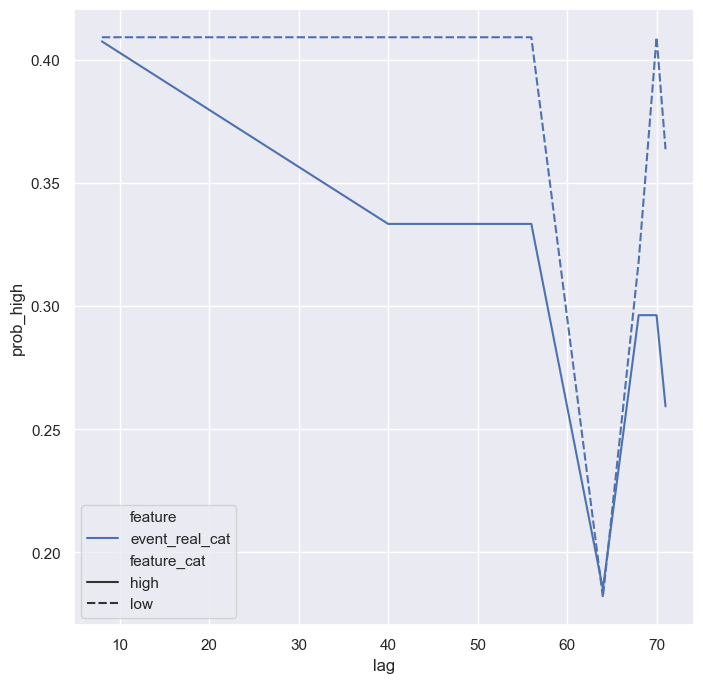

In [212]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"] == "event_real_cat"],
    x="lag",
    y="prob_high",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [213]:
(72-8)*5 / 60

5.333333333333333

Here we can see that if the real event is positive around 5 hours before : 
- THEN the event target HIGH is 66% chance to happened 
- BE CAREFUL :  very low event number < 20

In [214]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
255     max_high_d_ETH_cat         low  70    6738   5486  0.264163  0.215078   
37      max_high_d_ETH_cat         low  71    6678   5446  0.263245   0.21468   
473     max_high_d_ETH_cat         low  68    6951   5706  0.265904  0.218278   
691     max_high_d_ETH_cat         low  64    7476   6214  0.269425  0.223944   
909     max_high_d_ETH_cat         low  56    8474   7136  0.274106  0.230826   
1127    max_high_d_ETH_cat         low  40   10027   8668   0.27524  0.237936   
1341    max_high_h_ETH_cat         low   8   24508  22622  0.258679  0.238772   
1311          Open_ETH_cat         low   8   28530  26520  0.266997  0.248187   
1353        vwap_h_ETH_cat         low   8   25204  23335  0.278688  0.258022   
1321    ichi_kijun_ETH_cat         low   8   22484  20733  0.288867  0.266371   
1345    max_high_d_ETH_cat         low   8   12009  10739  0.272963  0.244096   
1315           Low_ETH_cat         low   8   28967  26978  0.270932  0.252329   
1313          High_ETH_cat         low   8   30251  28238  0.255134  0.238157   
1323   ichi_tenkan_ETH_cat         low   8   26144  24277  0.275603  0.255922   
1355        vwap_d_ETH_cat         low   8   23258  21520  0.284606  0.263338   
1343     min_low_h_ETH_cat         low   8   20998  19361  0.298929  0.275625   
703         vwap_w_ETH_cat         low  64    9343   8269  0.328701  0.290916   
1101  ichi_cloud_b_ETH_cat         low  40   12326  11102   0.31559  0.284251   
1135        vwap_h_ETH_cat         low  40   22048  20406  0.286583   0.26524   
1093          Open_ETH_cat         low  40   26523  24726  0.271527   0.25313   
1123    max_high_h_ETH_cat         low  40   21212  19621  0.253629  0.234606   
1137        vwap_d_ETH_cat         low  40   19623  18121  0.293143  0.270705   
921         vwap_w_ETH_cat         low  56   10224   9168  0.325615  0.291984   
1097           Low_ETH_cat         low  40   27179  25455  0.277303  0.259713   
1317  ichi_cloud_a_ETH_cat         low   8   16537  15201  0.303827  0.279281   
485         vwap_w_ETH_cat         low  68    8763   7813  0.328141  0.292567   
1095          High_ETH_cat         low  40   29069  27343  0.253647  0.238587   
267         vwap_w_ETH_cat         low  70    8476   7556   0.32826   0.29263   
49          vwap_w_ETH_cat         low  71    8336   7424   0.32859  0.292641   
1319  ichi_cloud_b_ETH_cat         low   8   14924  13722  0.305113  0.280539   

      delta_prob  
255   256.463351  
37    250.383372  
473   244.927708  
691   232.672608  
909   229.371429  
1127  197.580209  
1341  150.944027  
1311  146.779292  
1353  143.932137  
1321  141.888655  
1345  141.805873  
1315  141.428939  
1313  138.561747  
1323  138.263382  
1355  134.916432  
1343  132.796601  
703   130.987509  
1101  127.896193  
1135  127.015782  
1093  126.020371  
1123  123.982122  
1137  119.542391  
921   115.009901  
1097  112.937493  
1317  112.476905  
485   108.892375  
1095  105.618521  
267   105.588822  
49    105.551269  
1319  100.873001

In [215]:
list_feat_high = list(df_prob.sort_values(by=["delta_prob"], ascending=False)["feature"].unique()[:10])

In [216]:
df_prob.sort_values(by=["delta_prob"]).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1124    min_low_h_ETH_cat        high  40   17622  21019  0.222573  0.265479   
1096          Low_ETH_cat        high  40   25303  28672  0.230875  0.261615   
1314          Low_ETH_cat        high   8   26634  30087  0.231921  0.261988   
1342    min_low_h_ETH_cat        high   8   21042  24088  0.230666  0.264056   
1092         Open_ETH_cat        high  40   22879  25926   0.24547  0.278161   
1310         Open_ETH_cat        high   8   25005  28177  0.242268  0.273001   
474     min_low_d_ETH_cat        high  68    4715   6106  0.179989  0.233089   
1104  ichi_tenkan_ETH_cat        high  40   19979  22728  0.252136  0.286828   
1312         High_ETH_cat        high   8   25634  28716  0.247108  0.276818   
1322  ichi_tenkan_ETH_cat        high   8   22942  25862  0.248904  0.280584   
1134       vwap_h_ETH_cat        high  40   18877  21518  0.255433  0.291169   
38      min_low_d_ETH_cat        high  71    4466   5796  0.176049  0.228477   
256     min_low_d_ETH_cat        high  70    4530   5858   0.17723  0.229186   
692     min_low_d_ETH_cat        high  64    5152   6561  0.187345  0.238582   
1352       vwap_h_ETH_cat        high   8   21993  24777   0.25172  0.283584   
1094         High_ETH_cat        high  40   23768  26557  0.252744  0.282401   
910     min_low_d_ETH_cat        high  56    5938   7366  0.197933  0.245533   
1128    min_low_d_ETH_cat        high  40    7200   8751  0.209796   0.25499   
906     min_low_h_ETH_cat        high  56   14898  17086  0.223627   0.25647   
1136       vwap_d_ETH_cat        high  40   16871  19116   0.26198  0.296842   
1354       vwap_d_ETH_cat        high   8   20265  22699  0.257998  0.288986   
878           Low_ETH_cat        high  56   24338  26884  0.234839  0.259405   
874          Open_ETH_cat        high  56   21064  23411  0.256643  0.285239   
1320   ichi_kijun_ETH_cat        high   8   19726  21964  0.260025  0.289526   
1102   ichi_kijun_ETH_cat        high  40   16286  18302  0.264087  0.296778   
886   ichi_tenkan_ETH_cat        high  56   17347  19375  0.264674  0.295616   
1346    min_low_d_ETH_cat        high   8    9211  10683  0.225246  0.261243   
876          High_ETH_cat        high  56   22162  24349  0.265833  0.292067   
916        vwap_h_ETH_cat        high  56   16079  17884  0.268794  0.298969   
918        vwap_d_ETH_cat        high  56   13980  15665   0.27484  0.307966   

      delta_prob  
1124 -597.272793  
1096 -420.571042  
1314 -420.416036  
1342 -411.172878  
1092 -380.461387  
1310 -378.383062  
474  -357.615932  
1104 -353.899876  
1312 -349.539062  
1322 -349.413982  
1134 -345.333878  
38   -344.747613  
256  -339.542549  
692  -338.987621  
1352 -331.437075  
1094 -309.131485  
910  -306.552014  
1128 -301.623848  
906  -299.358679  
1136 -280.102537  
1354 -275.782329  
878  -253.098903  
874  -247.708106  
1320 -240.280355  
1102 -235.009599  
886  -223.995643  
1346 -217.832914  
876  -205.670444  
916  -191.857315  
918  -191.548322

In [217]:
list_feat_low = list(df_prob.sort_values(by=["delta_prob"])["feature"].unique()[:10])

In [218]:

list_feat_prob = list(set(list_feat_low + list_feat_high))
list_feat_prob

['max_high_h_ETH_cat',
 'ichi_kijun_ETH_cat',
 'min_low_h_ETH_cat',
 'Low_ETH_cat',
 'rsi_h_ETH_cat',
 'Open_ETH_cat',
 'vwap_h_ETH_cat',
 'High_ETH_cat',
 'min_low_d_ETH_cat',
 'vwap_d_ETH_cat',
 'max_high_d_ETH_cat',
 'ichi_tenkan_ETH_cat']

<Axes: xlabel='lag', ylabel='delta_prob'>

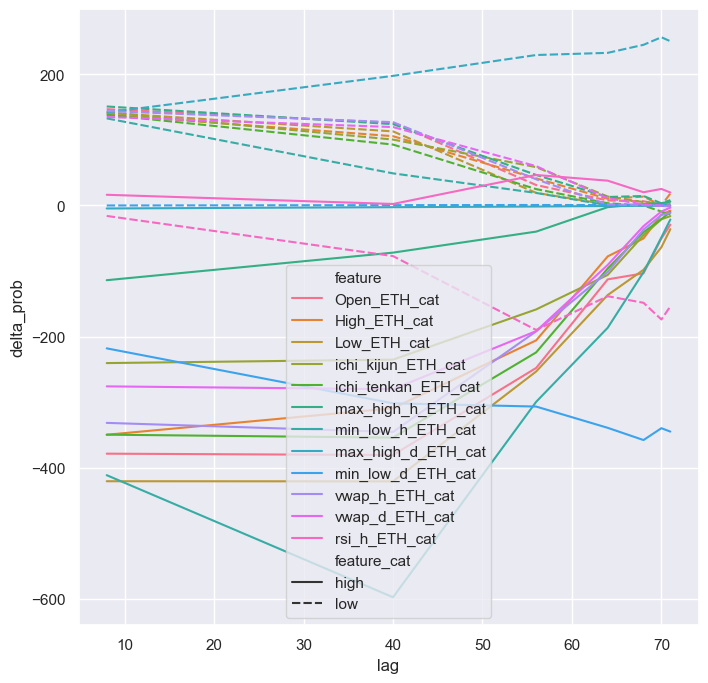

In [219]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="delta_prob",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

<Axes: xlabel='lag', ylabel='prob_high'>

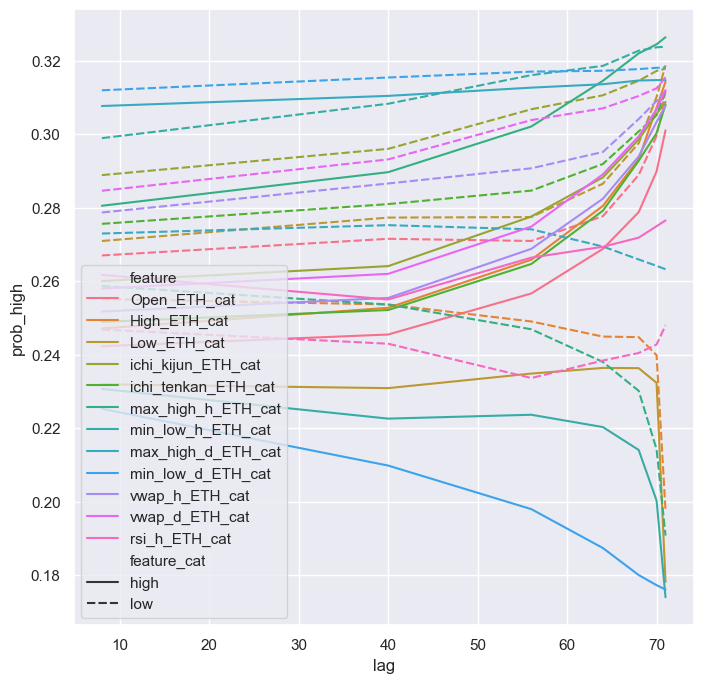

In [220]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high target for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="prob_high",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [221]:
df_prob[(df_prob["feature"] == "vwap_d_ETH_cat") & (df_prob["feature_cat"] == "high")].sort_values(by=["lag"])

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1354  vwap_d_ETH_cat        high   8   20265  22699  0.257998  0.288986   
1136  vwap_d_ETH_cat        high  40   16871  19116   0.26198  0.296842   
918   vwap_d_ETH_cat        high  56   13980  15665   0.27484  0.307966   
700   vwap_d_ETH_cat        high  64   11546  12592  0.289069  0.315257   
482   vwap_d_ETH_cat        high  68    9708  10269  0.299389   0.31669   
264   vwap_d_ETH_cat        high  70    8568   8851  0.306811  0.316945   
46    vwap_d_ETH_cat        high  71    7914   8076  0.311968  0.318354   

      delta_prob  
1354 -275.782329  
1136 -280.102537  
918  -191.548322  
700   -90.655067  
482   -31.508335  
264    -9.195591  
46     -3.282552

<Axes: xlabel='lag', ylabel='prob_low'>

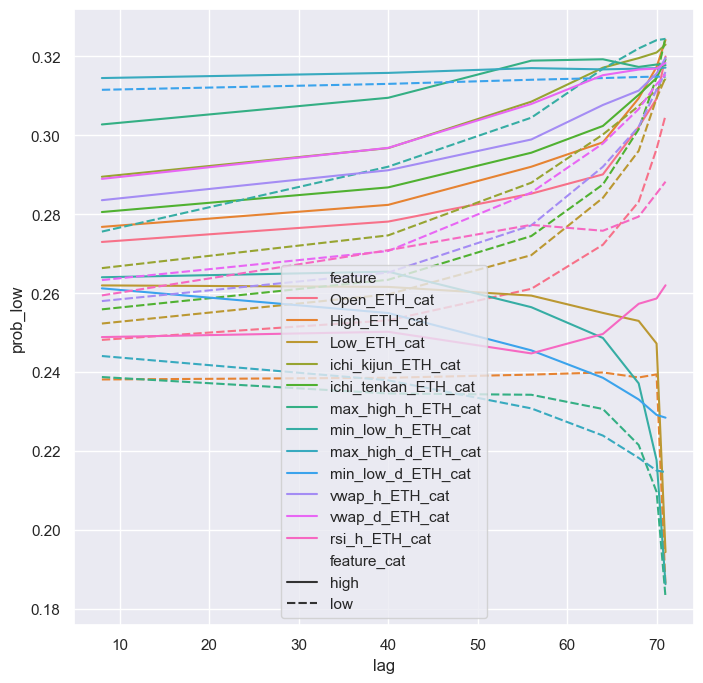

In [222]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob low target for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="prob_low",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [223]:
df_['event_pred'].value_counts()

event_pred
 0.0    253628
 1.0        25
-1.0        24
Name: count, dtype: int64

In [224]:
len(list_df)

7

In [225]:
df = list_df[-1]

In [226]:
pd.crosstab(df['Volume_ETH_cat'], df['target_cat'], margins=True, normalize=True)

target_cat          high       low   neutral       All
Volume_ETH_cat                                        
high            0.030377  0.028761  0.040768  0.099907
low             0.015043  0.015610  0.069478  0.100131
neutral         0.197436  0.204764  0.397762  0.799962
All             0.242856  0.249136  0.508008  1.000000

##### With Best Positive Corr Features

max_high_h_ETH & Volume_ETH are the best positive impact on price. 

In [227]:
df_prob[
    (df_prob["feature"] == "max_high_h_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_high", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
32    max_high_h_ETH_cat        high  71    8280   8062  0.326395  0.317802   
250   max_high_h_ETH_cat        high  70    8815   8638  0.324475  0.317959   
468   max_high_h_ETH_cat        high  68    9719   9579  0.321992  0.317354   
686   max_high_h_ETH_cat        high  64   11178  11347  0.314537  0.319292   
904   max_high_h_ETH_cat        high  56   13188  13923  0.302103   0.31894   
1122  max_high_h_ETH_cat        high  40   15802  16886  0.289663  0.309534   
1340  max_high_h_ETH_cat        high   8   18820  20313  0.280523  0.302777   

      delta_prob  
32      5.816179  
250     3.590099  
468     2.031299  
686    -2.535938  
904   -39.852827  
1122  -71.895252  
1340 -113.921703

Correlation confirmed and good for strat 2

In [228]:
df_prob[
    (df_prob["feature"] == "Volume_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_high", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
368   Volume_ETH_cat        high  70    8065   7943  0.317933  0.313123   
150   Volume_ETH_cat        high  71    8038   8010  0.316856  0.315752   
586   Volume_ETH_cat        high  68    7942   7949  0.313096  0.313372   
1240  Volume_ETH_cat        high  40    7903   7678  0.311768  0.302892   
804   Volume_ETH_cat        high  64    7857   8026  0.309782  0.316445   
1022  Volume_ETH_cat        high  56    7815   7820  0.308138  0.308335   
1458  Volume_ETH_cat        high   8    7706   7296  0.304056  0.287879   

     delta_prob  
368     1.85957  
150    0.097707  
586   -0.006167  
1240   6.498299  
804   -3.596424  
1022  -0.003198  
1458  22.410345

=> Correlation with less impact on strat 2

##### With Best Negative Corr Features
min_low_h_ETH & Close_ETH_raw are the best negative impact on price. 

In [229]:
##### On Best Negative Corr Features
df_prob[
    (df_prob["feature"] == "min_low_h_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_low", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1124  min_low_h_ETH_cat        high  40   17622  21019  0.222573  0.265479   
1342  min_low_h_ETH_cat        high   8   21042  24088  0.230666  0.264056   
906   min_low_h_ETH_cat        high  56   14898  17086  0.223627   0.25647   
688   min_low_h_ETH_cat        high  64   11937  13476  0.220272  0.248671   
470   min_low_h_ETH_cat        high  68    9192  10185  0.214041  0.237164   
252   min_low_h_ETH_cat        high  70    6662   7243  0.200271  0.217736   
34    min_low_h_ETH_cat        high  71    4413   4726  0.173946  0.186283   

      delta_prob  
1124 -597.272793  
1342 -411.172878  
906  -299.358679  
688  -186.402314  
470  -101.775197  
252   -48.552463  
34    -21.439764

=> No clear conclusion

In [230]:
df_prob[
    (df_prob["feature"] == "Close_ETH_raw_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_low", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
434   Close_ETH_raw_cat        high  70    6531   7075   0.25745  0.278895   
216   Close_ETH_raw_cat        high  71    6538   7074  0.257726  0.278855   
870   Close_ETH_raw_cat        high  64    6528   7074  0.257332  0.278855   
652   Close_ETH_raw_cat        high  68    6529   7072  0.257371  0.278776   
1524  Close_ETH_raw_cat        high   8    6506   7063  0.256465  0.278422   
1088  Close_ETH_raw_cat        high  56    6527   7060  0.257293  0.278303   
1306  Close_ETH_raw_cat        high  40    6511   7059  0.256662  0.278264   

     delta_prob  
434  -43.500808  
216  -42.212166  
870  -43.834142  
652  -43.356959  
1524 -45.729088  
1088 -41.817767  
1306 -44.259985

=> No clear conclusion

#### First LAG (oldest)
I_past closest to 0 is the oldest

In [231]:
len(list_df)

7

In [232]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [233]:
min_I_list_past = np.argmin(list_past)
min_I_list_past

np.int64(6)

In [234]:
df = list_df[min_I_list_past]

In [235]:
f"chi2_{list_past[min_I_list_past]}"

'chi2_8'

Text(0.5, 1.0, 'Min Chi2 between FIRST Lag and Target cat')

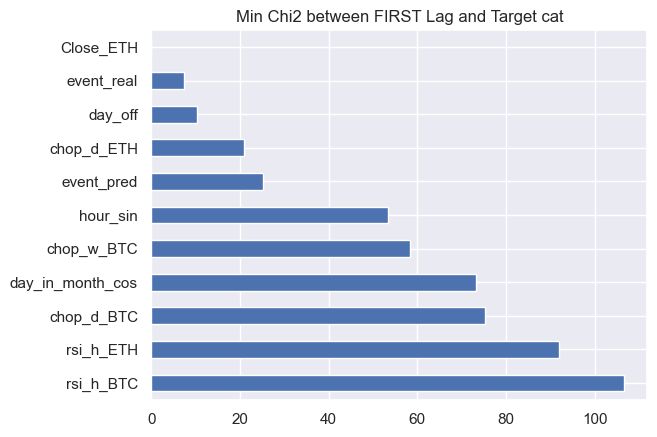

In [236]:
# find chi2_0 values in the 10% highest quantiles 
first_col_chi2 = f"chi2_{list_past[min_I_list_past]}"
min_quantile_chi2_10 = df_cont[first_col_chi2].quantile(0.10)
min_chi2_0 = df_cont[first_col_chi2].sort_values(ascending=False)
min_chi2_0[min_chi2_0.values<min_quantile_chi2_10].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Min Chi2 between FIRST Lag and Target cat")


Results : We can see that some features have less impact on distrib :
- we are not going to study them
- we are going to study the features with the highest chi2

Text(0.5, 1.0, 'Max Chi2 between FIRST Lag and Target cat')

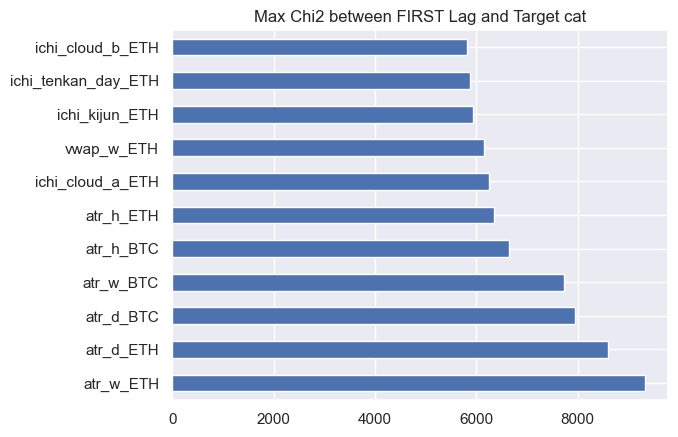

In [237]:
# find chi2_0 values in the 10% highest quantiles 
max_quantile_chi2_90 = df_cont[first_col_chi2].quantile(0.90)
max_chi2_0 = df_cont[first_col_chi2].sort_values(ascending=False)
max_chi2_0[max_chi2_0.values>max_quantile_chi2_90].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Max Chi2 between FIRST Lag and Target cat")

expected:  [[  6135.27296917   6293.91549096  12833.81153987]
 [  6153.24431856   6312.35153364  12871.40414779]
 [ 49318.48271227  50593.7329754  103164.78431233]]
target_cat        high      low   neutral     Total
atr_w_ETH_cat                                      
high            8420.0   8177.0    8666.0   25263.0
low             2819.0   3255.0   19263.0   25337.0
neutral        50368.0  51768.0  100941.0  203077.0
total          61607.0  63200.0  128870.0  253677.0
xi_n =  9326.673361551591
chi2:  9326.67336155159
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


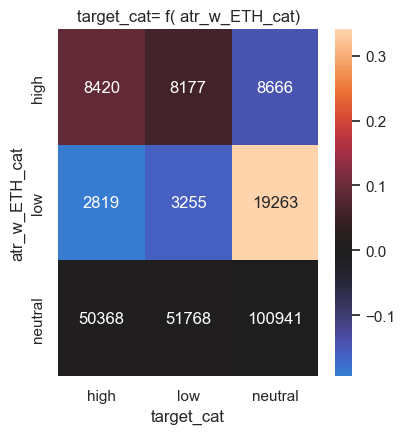

target_cat      high    low  neutral
atr_w_ETH_cat                       
high            8420   8177     8666
low             2819   3255    19263
neutral        50368  51768   100941

In [238]:
feat_name_max = max_chi2_0.index[0]
# plot contingency table for the feature with the highest chi2
X = feat_name_max + "_cat"
Y = "target_cat"
I_past = 0
plot_cont(X=X, Y=Y, data=df)

In [239]:
Y

'target_cat'

In [240]:
len(list_col_select)

109

In [241]:
len(list_col_select)*(len(list_col_select)-1)*(len(list_col_select)-2)

1259604

In [242]:
3*3*3

27

In [243]:
# create contingency dataframe
col_name_0 = f"{max_chi2_0.index[0]}_cat"
col_name_1 = f"{max_chi2_0.index[1]}_cat"
col_name_2 = f"{max_chi2_0.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  2010632.607725962
p-value:  0.0


target_cat                                  high    low  neutral    p_high  \
atr_w_ETH_cat atr_d_ETH_cat atr_d_BTC_cat                                    
high          high          high            4332   4133     4505  0.334002   
                            low                0      0        0       NaN   
                            neutral         1282   1172     1214  0.349509   
              low           high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              neutral       high             739    854      766  0.313268   
                            low                0      0        0       NaN   
                            neutral         2067   2018     2181  0.329876   
low           high          high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              low           high               0      0        0       NaN   
                            low             1418   1854    12254  0.091331   
                            neutral          373    322     1696  0.156002   
              neutral       high               0      0        0       NaN   
                            low              288    217      863  0.210526   
                            neutral          740    862     4450  0.122274   
neutral       high          high            1395   1208     1569  0.334372   
                            low                0      0        0       NaN   
                            neutral         1395   1389     1774  0.306055   
              low           high               0      0        0       NaN   
                            low              598    687     2971  0.140508   
                            neutral          470    568     2262  0.142424   
              neutral       high            1846   1762     2257  0.314749   
                            low              796    723     2808  0.183961   
                            neutral        43868  45431    87300  0.248405   

target_cat                                    p_low  p_neutral  \
atr_w_ETH_cat atr_d_ETH_cat atr_d_BTC_cat                        
high          high          high           0.318658   0.347340   
                            low                 NaN        NaN   
                            neutral        0.319520   0.330971   
              low           high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              neutral       high           0.362018   0.324714   
                            low                 NaN        NaN   
                            neutral        0.322056   0.348069   
low           high          high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              low           high                NaN        NaN   
                            low            0.119413   0.789257   
                            neutral        0.134672   0.709327   
              neutral       high                NaN        NaN   
                            low            0.158626   0.630848   
                            neutral        0.142432   0.735294   
neutral       high          high           0.289549   0.376079   
                            low                 NaN        NaN   
                            neutral        0.304739   0.389206   
              low           high                NaN        NaN   
                            low            0.161419   0.698073   
                            neutral        0.172121   0.685455   
              neutral

In [244]:
# Threshold of prob 40%  : to have 15% to 30% of gains with nb trades per months on average :
# - 30 trades (with 2.5% cap risk) => 15% gains
# - to 300 trades (0.5 % capital risk)  => 30% gains
prob_tot = df_cross[["high", "neutral","low"]].sum(axis=0) / df_cross[["high", "neutral","low"]].sum().sum()
print("prob_tot: ", prob_tot)
#prob_target = 0.33
nb_per_sub_cat = df_cross[["high","low","neutral"]].sum(axis=1)
nb_per_sub_cat
#df_cross["exp_trigger_high"] = nb_per_sub_cat * prob_target
#df_cross["exp_trigger_low"] = nb_per_sub_cat * prob_target
#df_cross["exp_trigger_neutral"] = nb_per_sub_cat * prob_target


#df_cross["chi2_trigger_low"] = np.sign(df_cross["low"] - df_cross["exp_trigger_low"]) * (df_cross["low"] - df_cross["exp_trigger_low"])**2 / df_cross["exp_trigger_low"]
#df_cross["chi2_trigger_neutral"] = np.sign(df_cross["neutral"] - df_cross["exp_trigger_neutral"]) *  (df_cross["neutral"] - df_cross["exp_trigger_neutral"])**2 / df_cross["exp_trigger_neutral"]

df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"])



prob_tot:  target_cat
high       0.242856
neutral    0.508008
low        0.249136
dtype: float64


high    low  neutral    p_high  \
atr_w_ETH_cat atr_d_ETH_cat atr_d_BTC_cat                                    
high          high          high            4332   4133     4505  0.334002   
                            low                0      0        0       NaN   
                            neutral         1282   1172     1214  0.349509   
              low           high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              neutral       high             739    854      766  0.313268   
                            low                0      0        0       NaN   
                            neutral         2067   2018     2181  0.329876   
low           high          high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              low           high               0      0        0       NaN   
                            low             1418   1854    12254  0.091331   
                            neutral          373    322     1696  0.156002   
              neutral       high               0      0        0       NaN   
                            low              288    217      863  0.210526   
                            neutral          740    862     4450  0.122274   
neutral       high          high            1395   1208     1569  0.334372   
                            low                0      0        0       NaN   
                            neutral         1395   1389     1774  0.306055   
              low           high               0      0        0       NaN   
                            low              598    687     2971  0.140508   
                            neutral          470    568     2262  0.142424   
              neutral       high            1846   1762     2257  0.314749   
                            low              796    723     2808  0.183961   
                            neutral        43868  45431    87300  0.248405   

                                              p_low  p_neutral  \
atr_w_ETH_cat atr_d_ETH_cat atr_d_BTC_cat                        
high          high          high           0.318658   0.347340   
                            low                 NaN        NaN   
                            neutral        0.319520   0.330971   
              low           high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              neutral       high           0.362018   0.324714   
                            low                 NaN        NaN   
                            neutral        0.322056   0.348069   
low           high          high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              low           high                NaN        NaN   
                            low            0.119413   0.789257   
                            neutral        0.134672   0.709327   
              neutral       high                NaN        NaN   
                            low            0.158626   0.630848   
                            neutral        0.142432   0.735294   
neutral       high          high           0.289549   0.376079   
                            low                 NaN        NaN   
                            neutral        0.304739   0.389206   
              low           high                NaN        NaN   
                            low            0.161419   0.698073   
                            neutral        0.172121   0.685455   
              neutral       high           0.300426   0.384825   

In [245]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] > 10]

high   low  neutral    p_high  \
atr_w_ETH_cat atr_d_ETH_cat atr_d_BTC_cat                                  
low           neutral       low             288   217      863  0.210526   
neutral       high          high           1395  1208     1569  0.334372   

                                              p_low  p_neutral  \
atr_w_ETH_cat atr_d_ETH_cat atr_d_BTC_cat                        
low           neutral       low            0.158626   0.630848   
neutral       high          high           0.289549   0.376079   

                                           chi2_delta_high  
atr_w_ETH_cat atr_d_ETH_cat atr_d_BTC_cat                   
low           neutral       low                  19.964356  
neutral       high          high                 26.868229

In [246]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] > 10].sum().sum() / df_cross.filter(["high","low","neutral"]).sum().sum()

np.float64(0.022031294068450117)

In [247]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] < -10]

high    low  neutral    p_high  \
atr_w_ETH_cat atr_d_ETH_cat atr_d_BTC_cat                                    
high          neutral       high             739    854      766  0.313268   
low           low           low             1418   1854    12254  0.091331   
              neutral       neutral          740    862     4450  0.122274   
neutral       low           low              598    687     2971  0.140508   
                            neutral          470    568     2262  0.142424   
              neutral       neutral        43868  45431    87300  0.248405   

                                              p_low  p_neutral  \
atr_w_ETH_cat atr_d_ETH_cat atr_d_BTC_cat                        
high          neutral       high           0.362018   0.324714   
low           low           low            0.119413   0.789257   
              neutral       neutral        0.142432   0.735294   
neutral       low           low            0.161419   0.698073   
                            neutral        0.172121   0.685455   
              neutral       neutral        0.257255   0.494340   

                                           chi2_delta_high  
atr_w_ETH_cat atr_d_ETH_cat atr_d_BTC_cat                   
high          neutral       high                -16.603892  
low           low           low                -116.195599  
              neutral       neutral             -18.581773  
neutral       low           low                 -12.328405  
                            neutral             -18.504817  
              neutral       neutral             -54.714364

In [248]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] < -10].sum().sum() / df_cross.filter(["high","low","neutral"]).sum().sum()

np.float64(0.8193926573967635)

In [249]:
((2-1)**2) / 1


1.0

In [250]:
((2000-1000)**2) / 1000

1000.0

In [251]:
22000 / df.shape[0]

0.08672445669098894

In [252]:
100*5/60

8.333333333333334

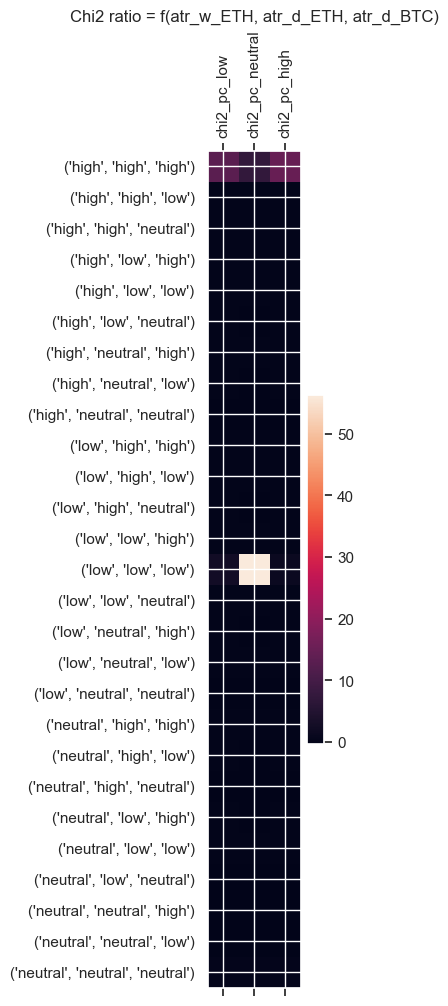

In [253]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_0.index[0]}, {max_chi2_0.index[1]}, {max_chi2_0.index[2]})", 
    size=1.5,
)

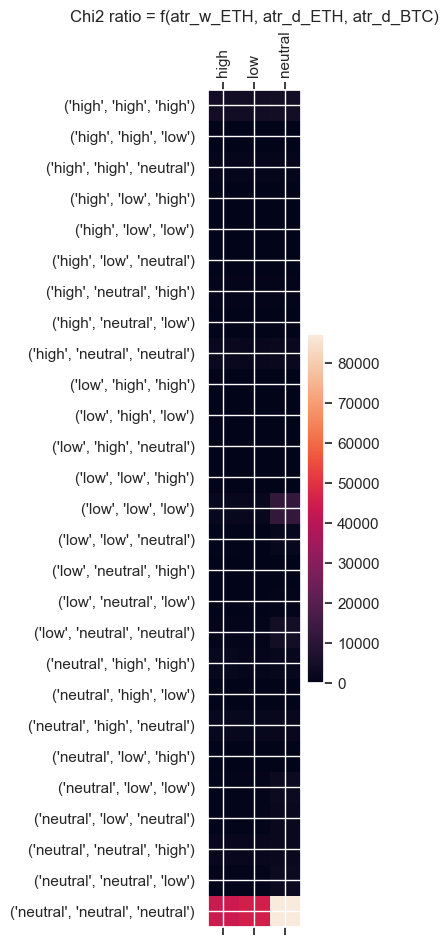

In [254]:
plot_corr(
    df_cross[["high","low","neutral"]], 
    title = f"Chi2 ratio = f({max_chi2_0.index[0]}, {max_chi2_0.index[1]}, {max_chi2_0.index[2]})", 
    size=1.5,
)

#### LAST Lag (newest)

In [255]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [256]:
df = list_df[0]

Text(0.5, 1.0, 'Min Chi2 between LAST Lag and LAST Target')

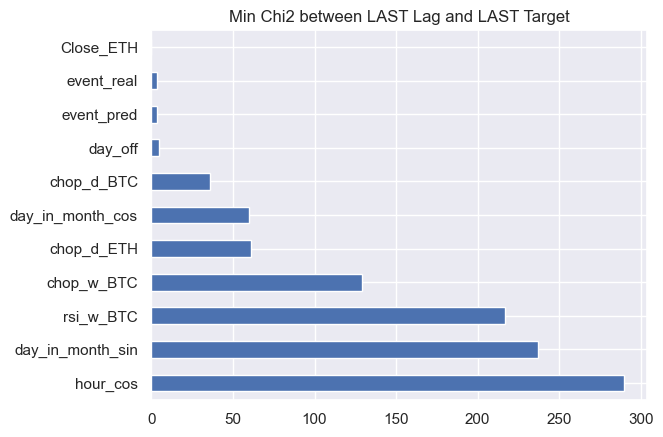

In [257]:
# find chi2_0 values in the 10% highest quantiles 
chi2_name = f"chi2_{list_past[0]}"
min_quantile_chi2_q10 = df_cont[chi2_name].quantile(0.10)
min_chi2_last = df_cont[chi2_name].sort_values(ascending=False)
min_chi2_last[min_chi2_last.values<min_quantile_chi2_q10].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Min Chi2 between LAST Lag and LAST Target")

Text(0.5, 1.0, 'Max Chi2 between LAST Lag and Target cat')

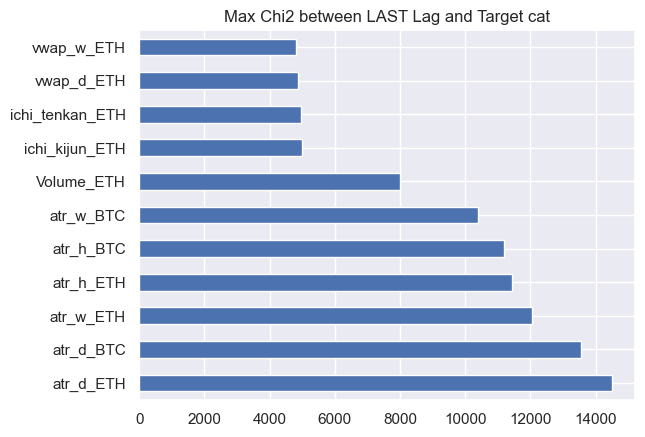

In [258]:
# find chi2_0 values in the 10% highest quantiles 
max_quantile_chi2_q90 = df_cont[chi2_name].quantile(0.90)
max_chi2_last = df_cont[chi2_name].sort_values(ascending=False)
max_chi2_last[max_chi2_last.values>max_quantile_chi2_q90].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Max Chi2 between LAST Lag and Target cat")

expected:  [[  6160.77285682   6320.07474071  12887.15240246]
 [  6160.77285682   6320.07474071  12887.15240246]
 [ 49285.45428636  50559.85051857 103095.69519507]]
target_cat        high      low   neutral     Total
atr_d_ETH_cat                                      
high            8303.0   8275.0    8790.0   25368.0
low             1979.0   1981.0   21408.0   25368.0
neutral        51325.0  52944.0   98672.0  202941.0
total          61607.0  63200.0  128870.0  253677.0
xi_n =  14490.205744454463
chi2:  14490.205744454459
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


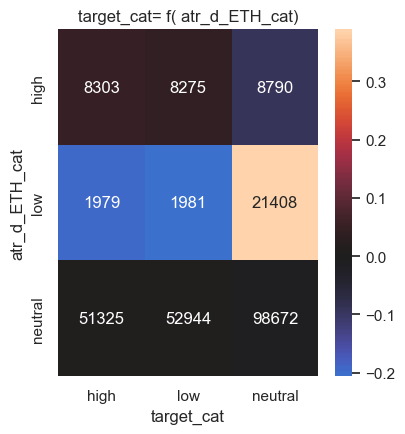

target_cat      high    low  neutral
atr_d_ETH_cat                       
high            8303   8275     8790
low             1979   1981    21408
neutral        51325  52944    98672

In [259]:
feat_name_max = max_chi2_last.index[0]
# plot contingency table for the feature with the highest chi2
X = feat_name_max + "_cat"
Y = "target_cat"
plot_cont(X=X, Y=Y, data=df)

In [260]:
Y

'target_cat'

In [261]:
X

'atr_d_ETH_cat'

In [262]:
max_chi2_last.index[1]

'atr_d_BTC'

In [263]:
# create contingency dataframe
col_name_0 = f"{max_chi2_last.index[0]}_cat"
col_name_1 = f"{max_chi2_last.index[1]}_cat"
col_name_2 = f"{max_chi2_last.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  2220666.9569061063
p-value:  0.0


target_cat                                  high    low  neutral    p_high  \
atr_d_ETH_cat atr_d_BTC_cat atr_w_ETH_cat                                    
high          high          high            4227   4297     4567  0.322894   
                            low                0      0        0       NaN   
                            neutral         1314   1325     1417  0.323964   
              low           high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              neutral       high            1281   1199     1221  0.346123   
                            low                0      0        0       NaN   
                            neutral         1481   1454     1585  0.327655   
low           high          high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              low           high               0      0        0       NaN   
                            low              919    989    13489  0.059687   
                            neutral          386    294     3589  0.090419   
              neutral       high               0      0        0       NaN   
                            low              298    347     1764  0.123703   
                            neutral          376    351     2566  0.114182   
neutral       high          high             876    749      776  0.364848   
                            low                0      0        0       NaN   
                            neutral         1921   1850     2049  0.330069   
              low           high               0      0        0       NaN   
                            low              207    233      954  0.148494   
                            neutral          673    589     3046  0.156221   
              neutral       high            2128   1958     2089  0.344615   
                            low             1004    934     4230  0.162776   
                            neutral        44516  46631    85528  0.251965   

target_cat                                    p_low  p_neutral  \
atr_d_ETH_cat atr_d_BTC_cat atr_w_ETH_cat                        
high          high          high           0.328241   0.348866   
                            low                 NaN        NaN   
                            neutral        0.326677   0.349359   
              low           high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              neutral       high           0.323966   0.329911   
                            low                 NaN        NaN   
                            neutral        0.321681   0.350664   
low           high          high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              low           high                NaN        NaN   
                            low            0.064233   0.876080   
                            neutral        0.068869   0.840712   
              neutral       high                NaN        NaN   
                            low            0.144043   0.732254   
                            neutral        0.106590   0.779229   
neutral       high          high           0.311953   0.323199   
                            low                 NaN        NaN   
                            neutral        0.317869   0.352062   
              low           high                NaN        NaN   
                            low            0.167145   0.684362   
                            neutral        0.136722   0.707057   
              neutral

In [264]:
# df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross

In [265]:
df_cross["high"] / df.shape[0]

atr_d_ETH_cat  atr_d_BTC_cat  atr_w_ETH_cat
high           high           high             0.016663
                              low              0.000000
                              neutral          0.005180
               low            high             0.000000
                              low              0.000000
                              neutral          0.000000
               neutral        high             0.005050
                              low              0.000000
                              neutral          0.005838
low            high           high             0.000000
                              low              0.000000
                              neutral          0.000000
               low            high             0.000000
                              low              0.003623
                              neutral          0.001522
               neutral        high             0.000000
                              low              0.001175
    

In [266]:
df_cross["high"].sum() / df_cross[["high", "neutral","low"]].sum().sum()

np.float64(0.2428560728800798)

In [267]:
df_cross["low"].sum() / df_cross[["high", "neutral","low"]].sum().sum()

np.float64(0.24913571194865913)

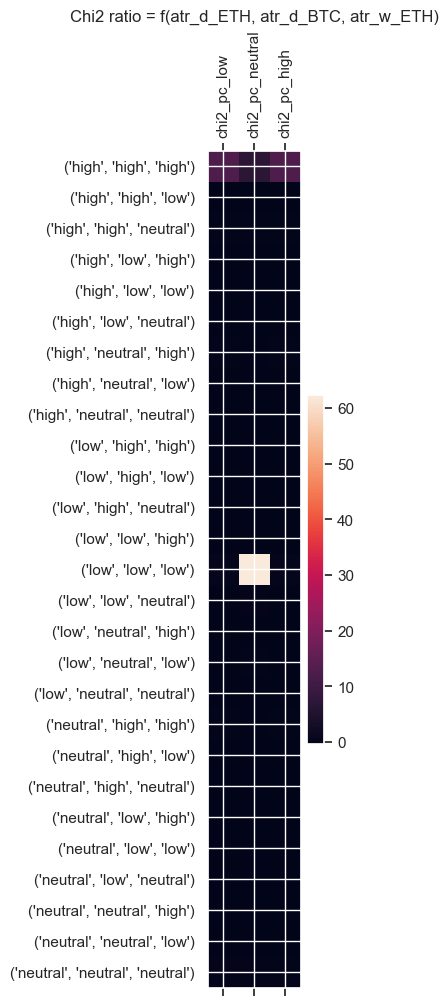

In [268]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_last.index[0]}, {max_chi2_last.index[1]}, {max_chi2_last.index[2]})", 
    size=1.5,
)

In [269]:
list_len_levels = []
for I in range(len(df_cross.index.levels)): 
    list_len_levels.append(len(df_cross.index.levels[I]))
list_len_levels

[3, 3, 3]

In [270]:
df_cross.index.unique(level=2)

Index(['high', 'low', 'neutral'], dtype='object', name='atr_w_ETH_cat')

##### check on first LAG (oldest)
We keep the same Features to do the cross table, and apply cat using for the FIRST Lag (oldest)  
To detect if these features are still important with oldest time

In [271]:
list_past[-1]

8

In [272]:
df = list_df[-1]

In [273]:
# create contingency dataframe
col_name_0 = f"{max_chi2_last.index[0]}_cat"
col_name_1 = f"{max_chi2_last.index[1]}_cat"
col_name_2 = f"{max_chi2_last.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  2010632.6077259623
p-value:  0.0


target_cat                                  high    low  neutral    p_high  \
atr_d_ETH_cat atr_d_BTC_cat atr_w_ETH_cat                                    
high          high          high            4332   4133     4505  0.334002   
                            low                0      0        0       NaN   
                            neutral         1395   1208     1569  0.334372   
              low           high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              neutral       high            1282   1172     1214  0.349509   
                            low                0      0        0       NaN   
                            neutral         1395   1389     1774  0.306055   
low           high          high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              low           high               0      0        0       NaN   
                            low             1418   1854    12254  0.091331   
                            neutral          598    687     2971  0.140508   
              neutral       high               0      0        0       NaN   
                            low              373    322     1696  0.156002   
                            neutral          470    568     2262  0.142424   
neutral       high          high             739    854      766  0.313268   
                            low                0      0        0       NaN   
                            neutral         1846   1762     2257  0.314749   
              low           high               0      0        0       NaN   
                            low              288    217      863  0.210526   
                            neutral          796    723     2808  0.183961   
              neutral       high            2067   2018     2181  0.329876   
                            low              740    862     4450  0.122274   
                            neutral        43868  45431    87300  0.248405   

target_cat                                    p_low  p_neutral  \
atr_d_ETH_cat atr_d_BTC_cat atr_w_ETH_cat                        
high          high          high           0.318658   0.347340   
                            low                 NaN        NaN   
                            neutral        0.289549   0.376079   
              low           high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              neutral       high           0.319520   0.330971   
                            low                 NaN        NaN   
                            neutral        0.304739   0.389206   
low           high          high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              low           high                NaN        NaN   
                            low            0.119413   0.789257   
                            neutral        0.161419   0.698073   
              neutral       high                NaN        NaN   
                            low            0.134672   0.709327   
                            neutral        0.172121   0.685455   
neutral       high          high           0.362018   0.324714   
                            low                 NaN        NaN   
                            neutral        0.300426   0.384825   
              low           high                NaN        NaN   
                            low            0.158626   0.630848   
                            neutral        0.167090   0.648948   
              neutral

Results : same rank for chi-2  as for last lag, but smaller values: time between have impact => less direct impact

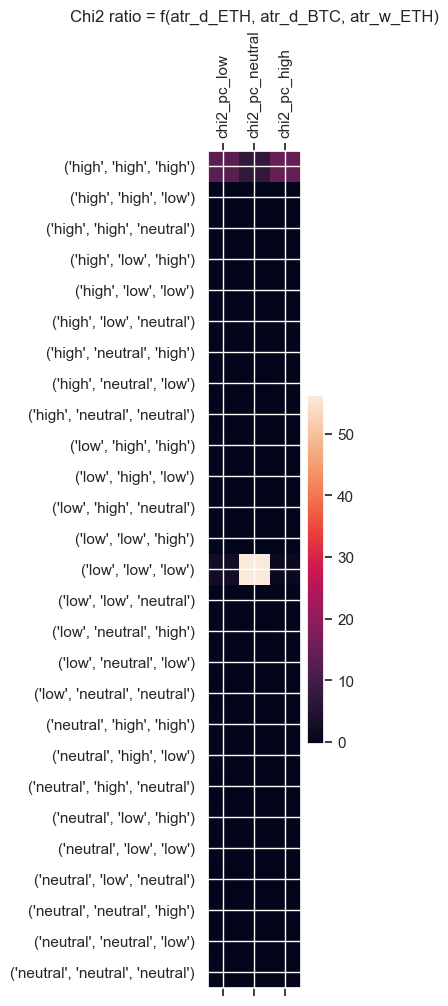

In [274]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_last.index[0]}, {max_chi2_last.index[1]}, {max_chi2_last.index[2]})", 
    size=1.5,
)

expected:  [[  6160.77285682   6320.07474071  12887.15240246]
 [  6186.27274447   6346.23399047  12940.49326506]
 [ 49259.9543987   50533.69126882 103042.35433248]]
target_cat        high      low   neutral     Total
atr_d_ETH_cat                                      
high            8404.0   7902.0    9062.0   25368.0
low             2859.0   3431.0   19183.0   25473.0
neutral        50344.0  51867.0  100625.0  202836.0
total          61607.0  63200.0  128870.0  253677.0
xi_n =  8603.986185805916
chi2:  8603.986185805916
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


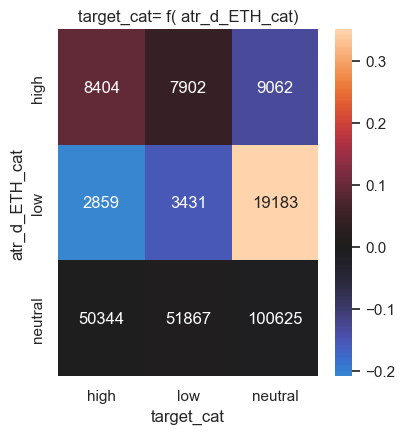

target_cat      high    low  neutral
atr_d_ETH_cat                       
high            8404   7902     9062
low             2859   3431    19183
neutral        50344  51867   100625

In [275]:
X = feat_name_max + "_cat"
Y = "target_cat"
plot_cont(X=X, Y=Y, data=df)

## Prob study

In [276]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [277]:

def get_index_combinations(n_elements, k_selection):
    """
    Generates all combinations of indices for selecting k elements from a list of n.

    Args:
        n_elements (int): The total number of elements in the list.
        k_selection (int): The number of elements to choose in each combination.

    Returns:
        list: A list of tuples, where each tuple is a combination of indices.
    """
    # Create a list of indices from 0 to n_elements - 1
    indices = range(n_elements)

    # Generate the combinations
    combinations = list(itertools.combinations(indices, k_selection))
    
    return combinations

In [278]:
get_index_combinations(3, 2)

[(0, 1), (0, 2), (1, 2)]

In [279]:
len(get_index_combinations(30, 3)) 

4060

In [280]:
6*5*4

120

#### On Highest delta_prob
delta prob between high and low

##### Per feature, per lag

In [281]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(7)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
255   max_high_d_ETH_cat         low  70    6738   5486  0.264163  0.215078   
37    max_high_d_ETH_cat         low  71    6678   5446  0.263245   0.21468   
473   max_high_d_ETH_cat         low  68    6951   5706  0.265904  0.218278   
691   max_high_d_ETH_cat         low  64    7476   6214  0.269425  0.223944   
909   max_high_d_ETH_cat         low  56    8474   7136  0.274106  0.230826   
1127  max_high_d_ETH_cat         low  40   10027   8668   0.27524  0.237936   
1341  max_high_h_ETH_cat         low   8   24508  22622  0.258679  0.238772   

      delta_prob  
255   256.463351  
37    250.383372  
473   244.927708  
691   232.672608  
909   229.371429  
1127  197.580209  
1341  150.944027

In [282]:
df_prob.sort_values(by=["delta_prob"], ascending=True).head(7)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1124  min_low_h_ETH_cat        high  40   17622  21019  0.222573  0.265479   
1096        Low_ETH_cat        high  40   25303  28672  0.230875  0.261615   
1314        Low_ETH_cat        high   8   26634  30087  0.231921  0.261988   
1342  min_low_h_ETH_cat        high   8   21042  24088  0.230666  0.264056   
1092       Open_ETH_cat        high  40   22879  25926   0.24547  0.278161   
1310       Open_ETH_cat        high   8   25005  28177  0.242268  0.273001   
474   min_low_d_ETH_cat        high  68    4715   6106  0.179989  0.233089   

      delta_prob  
1124 -597.272793  
1096 -420.571042  
1314 -420.416036  
1342 -411.172878  
1092 -380.461387  
1310 -378.383062  
474  -357.615932

In [283]:
# check with best linear correlation features
# compare best correlation tuples (feat, lag) and the best delta_prob tuple (feat, lag)

##### Per combinaison of 3 tuples of feature/lag

In [284]:
# algo check new data : 
# - hash input of function : hash of df_prob
# - compare with input hash file on disk : path_prob_hash
# - if same, load df_prob_comb : path_df_prob_comb

# hash input
hash_df_prob_comb_inputs =(get_data_hash(df_prob) + get_data_hash(df_targets))
# load df_prob file hash
path_prob_comb_inputs_hash = os.path.join(path_data, 'df_prob_comb_inputs_hash.txt')
hash_df_prob_comb_inputs_old = load_hash(path_prob_comb_inputs_hash)

# compare hash
if hash_df_prob_comb_inputs == hash_df_prob_comb_inputs_old:
    print("hash match: mode LOAD df_prob_comb")
    # load df_prob_comb
    df_prob_comb = pd.read_csv(path_df_prob_comb)
    mode_do_comb = False
else:
    print("hash not match : mode REDO comb")
    mode_do_comb = True

hash match: mode LOAD df_prob_comb


Feature selection :  limited to 30th first ones => 219240 combinaisons of 3 singles events

In [285]:
30*30*30

27000

In [286]:
1500*30*29

1305000

In [287]:
nb_best_feat = 30

In [288]:
# Probability  of target high or low for Combination of best features (highest and lowest delta_prob) 
# Combinaison of 3 features (1 feat = 1 feature on one lag)

df_prob_high = df_prob.sort_values(by=["delta_prob"], ascending=False).head(nb_best_feat)
df_prob_low = df_prob.sort_values(by=["delta_prob"], ascending=True).head(nb_best_feat)
list_study_feat_high = df_prob_high["feature"].values
list_study_lag_high = df_prob_high["lag"].values
list_study_I_past_high = [np.argmax(np.array(list_past) == x) for x in list_study_lag_high]
list_study_feat_low = df_prob_low["feature"].values
list_study_lag_low = df_prob_low["lag"].values
list_study_I_past_low = [np.argmax(np.array(list_past) == x) for x in list_study_lag_low]
for I in range(len(list_study_feat_high)):
    print(list_study_feat_high[I], list_study_lag_high[I])
for I in range(len(list_study_feat_low)):
    print(list_study_feat_low[I], list_study_lag_low[I])

# Target cat = High
# get all combinaisons
list_comb_high = get_index_combinations(len(list_study_feat_high), 3)
print("Cross Table Computaton nb : len(list_comb_high) : ", len(list_comb_high))
# Target cat = Low
# get all combinaisons
list_comb_low = get_index_combinations(len(list_study_feat_low), 3)
print("Cross Table Computaton nb : len(list_comb_low) : ", len(list_comb_low))

if mode_do_comb :
    list_cross = []
    df_prob_comb = pd.DataFrame()
    # HIGH
    for comb in list_comb_high:
        col_name_0 = list_study_feat_high[comb[0]]
        col_name_1 = list_study_feat_high[comb[1]]
        col_name_2 = list_study_feat_high[comb[2]]
        I_past_0 = list_study_I_past_high[comb[0]]
        I_past_1 = list_study_I_past_high[comb[1]]
        I_past_2 = list_study_I_past_high[comb[2]]
        lag_0 = list_study_lag_high[comb[0]]
        lag_1 = list_study_lag_high[comb[1]]
        lag_2 = list_study_lag_high[comb[2]]
        df_cross_comb = pd.crosstab(
            [
                list_df[I_past_0][col_name_0],
                list_df[I_past_1][col_name_1], 
                list_df[I_past_2][col_name_2],
            ],
            df_targets["target_cat"], 
            margins=False, 
            dropna=False
        )
        # add probs
        df_cross_comb["p_high"] = df_cross_comb["high"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        df_cross_comb["p_low"] = df_cross_comb["low"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        # just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
        df_cross_comb["delta_prob"] = np.sign(
            df_cross_comb["high"] - df_cross_comb["low"]) * (
                df_cross_comb["high"] - df_cross_comb["low"])**2 / (
                    (df_cross_comb["low"] + df_cross_comb["high"])/2)
        list_cross.append(df_cross_comb)
        df_cross_comb = df_cross_comb.reset_index(allow_duplicates=True)
        df_cross_comb["feat_0"] = df_cross_comb.columns[0]
        df_cross_comb["feat_0_cat"] = df_cross_comb.values[:,0]
        df_cross_comb["lag_0"] = lag_0
        df_cross_comb["feat_1"] = df_cross_comb.columns[1]
        df_cross_comb["feat_1_cat"] = df_cross_comb.values[:,1]
        df_cross_comb["lag_1"] = lag_1
        df_cross_comb["feat_2"] = df_cross_comb.columns[2]
        df_cross_comb["feat_2_cat"] = df_cross_comb.values[:,2]
        df_cross_comb["lag_2"] = lag_2
        df_cross_comb.drop(columns=[col_name_0, col_name_1, col_name_2], inplace=True)
        if df_prob_comb.shape[0] == 0:
            df_prob_comb = df_cross_comb
        else:
            #pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
            df_prob_comb = pd.concat([df_prob_comb, df_cross_comb], ignore_index=True)
    print(" ")
    print("Cross Table Computed nb : len(list_cross) : ", len(list_cross))

    # LOW
    for comb in list_comb_low:
        col_name_0 = list_study_feat_low[comb[0]]
        col_name_1 = list_study_feat_low[comb[1]]
        col_name_2 = list_study_feat_low[comb[2]]
        I_past_0 = list_study_I_past_low[comb[0]]
        I_past_1 = list_study_I_past_low[comb[1]]
        I_past_2 = list_study_I_past_low[comb[2]]
        lag_0 = list_study_lag_low[comb[0]]
        lag_1 = list_study_lag_low[comb[1]]
        lag_2 = list_study_lag_low[comb[2]]
        df_cross_comb = pd.crosstab(
            [
                list_df[I_past_0][col_name_0],
                list_df[I_past_1][col_name_1], 
                list_df[I_past_2][col_name_2]
            ],
            df_targets["target_cat"], 
            margins=False, 
            dropna=False
        )
        # add probs
        df_cross_comb["p_high"] = df_cross_comb["high"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        df_cross_comb["p_low"] = df_cross_comb["low"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        # just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
        df_cross_comb["delta_prob"] = np.sign(
            df_cross_comb["high"] - df_cross_comb["low"]) * (
                df_cross_comb["high"] - df_cross_comb["low"])**2 / (
                    (df_cross_comb["low"] + df_cross_comb["high"])/2)
        list_cross.append(df_cross_comb)
        df_cross_comb = df_cross_comb.reset_index(allow_duplicates=True)
        df_cross_comb["feat_0"] = df_cross_comb.columns[0]
        df_cross_comb["feat_0_cat"] = df_cross_comb.values[:,0]
        df_cross_comb["lag_0"] = lag_0
        df_cross_comb["feat_1"] = df_cross_comb.columns[1]
        df_cross_comb["feat_1_cat"] = df_cross_comb.values[:,1]
        df_cross_comb["lag_1"] = lag_1
        df_cross_comb["feat_2"] = df_cross_comb.columns[2]
        df_cross_comb["feat_2_cat"] = df_cross_comb.values[:,2]
        df_cross_comb["lag_2"] = lag_2
        df_cross_comb.drop(columns=[col_name_0, col_name_1, col_name_2], inplace=True)
        if df_prob_comb.shape[0] == 0:
            df_prob_comb = df_cross_comb
        else:
            #pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
            df_prob_comb = pd.concat([df_prob_comb, df_cross_comb], ignore_index=True)

    # save CSV
    df_prob_comb.to_csv(path_df_prob_comb, index=False)
    # save hash inputs
    with open(path_prob_comb_inputs_hash, 'w') as file:
        file.write(hash_df_prob_comb_inputs)
df_prob_comb.sort_values(by=["delta_prob"], ascending=False)


max_high_d_ETH_cat 70
max_high_d_ETH_cat 71
max_high_d_ETH_cat 68
max_high_d_ETH_cat 64
max_high_d_ETH_cat 56
max_high_d_ETH_cat 40
max_high_h_ETH_cat 8
Open_ETH_cat 8
vwap_h_ETH_cat 8
ichi_kijun_ETH_cat 8
max_high_d_ETH_cat 8
Low_ETH_cat 8
High_ETH_cat 8
ichi_tenkan_ETH_cat 8
vwap_d_ETH_cat 8
min_low_h_ETH_cat 8
vwap_w_ETH_cat 64
ichi_cloud_b_ETH_cat 40
vwap_h_ETH_cat 40
Open_ETH_cat 40
max_high_h_ETH_cat 40
vwap_d_ETH_cat 40
vwap_w_ETH_cat 56
Low_ETH_cat 40
ichi_cloud_a_ETH_cat 8
vwap_w_ETH_cat 68
High_ETH_cat 40
vwap_w_ETH_cat 70
vwap_w_ETH_cat 71
ichi_cloud_b_ETH_cat 8
min_low_h_ETH_cat 40
Low_ETH_cat 40
Low_ETH_cat 8
min_low_h_ETH_cat 8
Open_ETH_cat 40
Open_ETH_cat 8
min_low_d_ETH_cat 68
ichi_tenkan_ETH_cat 40
High_ETH_cat 8
ichi_tenkan_ETH_cat 8
vwap_h_ETH_cat 40
min_low_d_ETH_cat 71
min_low_d_ETH_cat 70
min_low_d_ETH_cat 64
vwap_h_ETH_cat 8
High_ETH_cat 40
min_low_d_ETH_cat 56
min_low_d_ETH_cat 40
min_low_h_ETH_cat 56
vwap_d_ETH_cat 40
vwap_d_ETH_cat 8
Low_ETH_cat 56
Open_ETH_ca

high  low  neutral    p_high     p_low  delta_prob  \
1229    1446  851     3920  0.232588  0.136883  308.249891   
11435   1440  849     3915  0.232108  0.136847  305.182176   
500     1445  855     3946  0.231348  0.136888  302.695652   
21614   1451  865     3882  0.234108  0.139561  296.542314   
1931    1427  848     3864  0.232448  0.138133  294.717363   
...      ...  ...      ...       ...       ...         ...   
218603     0    0        0       NaN       NaN         NaN   
218955     0    0        0       NaN       NaN         NaN   
219058     0    0        1  0.000000  0.000000         NaN   
219108     0    0        0       NaN       NaN         NaN   
219115     0    0        0       NaN       NaN         NaN   

                     feat_0 feat_0_cat  lag_0              feat_1 feat_1_cat  \
1229     max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   
11435    max_high_d_ETH_cat        low     71  max_high_d_ETH_cat        low   
500      max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   
21614    max_high_d_ETH_cat        low     68  max_high_d_ETH_cat        low   
1931     max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   
...                     ...        ...    ...                 ...        ...   
218603   ichi_kijun_ETH_cat        low      8   min_low_d_ETH_cat       high   
218955   ichi_kijun_ETH_cat        low     40      vwap_h_ETH_cat        low   
219058  ichi_tenkan_ETH_cat       high     56        High_ETH_cat    neutral   
219108  ichi_tenkan_ETH_cat       high     56      vwap_h_ETH_cat        low   
219115  ichi_tenkan_ETH_cat        low     56      vwap_h_ETH_cat       high   

        lag_1              feat_2 feat_2_cat  lag_2  
1229       68  max_high_h_ETH_cat    neutral     40  
11435      68  max_high_h_ETH_cat    neutral     40  
500        71  max_high_h_ETH_cat    neutral     40  
21614      64  max_high_h_ETH_cat    neutral     40  
1931       64  max_high_h_ETH_cat    neutral     40  
...       ...                 ...        ...    ...  
218603      8      vwap_d_ETH_cat    neutral     56  
218955     56      vwap_d_ETH_cat       high     56  
219058     56      vwap_h_ETH_cat        low     56  
219108     56      vwap_d_ETH_cat       high     56  
219115     56      vwap_d_ETH_cat        low     56  

[219240 rows x 15 columns]

In [289]:
df_prob_comb.shape

(219240, 15)

In [290]:
(4060)*(3*3*3)*2

219240

In [291]:
df_prob_comb.sort_values(by=["delta_prob"], ascending=False).head(20)

high   low  neutral    p_high     p_low  delta_prob  \
1229   1446   851     3920  0.232588  0.136883  308.249891   
11435  1440   849     3915  0.232108  0.136847  305.182176   
500    1445   855     3946  0.231348  0.136888  302.695652   
21614  1451   865     3882  0.234108  0.139561  296.542314   
1931   1427   848     3864  0.232448  0.138133  294.717363   
7034   1291   744     2694  0.272996  0.157327  294.062899   
12137  1421   846     3859  0.231962  0.138100  291.685046   
26717  1306   758     2688  0.274832  0.159512  290.992248   
22289  1424   849     3787  0.234983  0.140099  290.915090   
17240  1286   745     2696  0.272054  0.157605  288.213688   
2606   1400   833     3770  0.233217  0.138764  287.943574   
13379  2788  1965     8275  0.214001  0.150829  285.011151   
12812  1394   831     3765  0.232721  0.138731  284.915955   
3173   2800  1976     8281  0.214444  0.151336  284.328308   
22937  1394   838     3649  0.237035  0.142493  277.003584   
2200   6398  5138    12246  0.269027  0.216046  275.242718   
1525   6398  5138    12246  0.269027  0.216046  275.242718   
823    6398  5138    12246  0.269027  0.216046  275.242718   
31064  1475   904     3875  0.235849  0.144547  274.099201   
3254   1370   822     3633  0.235193  0.141116  274.000000   

                   feat_0 feat_0_cat  lag_0              feat_1 feat_1_cat  \
1229   max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   
11435  max_high_d_ETH_cat        low     71  max_high_d_ETH_cat        low   
500    max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   
21614  max_high_d_ETH_cat        low     68  max_high_d_ETH_cat        low   
1931   max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   
7034   max_high_d_ETH_cat        low     70        High_ETH_cat        low   
12137  max_high_d_ETH_cat        low     71  max_high_d_ETH_cat        low   
26717  max_high_d_ETH_cat        low     68        High_ETH_cat        low   
22289  max_high_d_ETH_cat        low     68  max_high_d_ETH_cat        low   
17240  max_high_d_ETH_cat        low     71        High_ETH_cat        low   
2606   max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   
13379  max_high_d_ETH_cat        low     71  max_high_d_ETH_cat        low   
12812  max_high_d_ETH_cat        low     71  max_high_d_ETH_cat        low   
3173   max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   
22937  max_high_d_ETH_cat        low     68  max_high_d_ETH_cat        low   
2200   max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   
1525   max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   
823    max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   
31064  max_high_d_ETH_cat        low     64  max_high_d_ETH_cat        low   
3254   max_high_d_ETH_cat        low     70  max_high_d_ETH_cat        low   

       lag_1                feat_2 feat_2_cat  lag_2  
1229      68    max_high_h_ETH_cat    neutral     40  
11435     68    max_high_h_ETH_cat    neutral     40  
500       71    max_high_h_ETH_cat    neutral     40  
21614     64    max_high_h_ETH_cat    neutral     40  
1931      64    max_high_h_ETH_cat    neutral     40  
7034       8    max_high_h_ETH_cat    neutral     40  
12137     64    max_high_h_ETH_cat    neutral     40  
26717      8    max_high_h_ETH_cat    neutral     40  
22289     56    max_high_h_ETH_cat    neutral     40  
17240      8    max_high_h_ETH_cat    neutral     40  
2606      56    max_high_h_ETH_cat    neutral     40  
13379     40  ichi_cloud_b_ETH_cat    neutral     40  
12812     56    max_high_h_ETH_cat    neutral     40  
3173      40  ichi_cloud_b_ETH_cat    neutral     40  
22937     40    max_high_h_ETH_cat    neutral     40  
2200      56    max_high_d_ETH_cat        low     40  
1525      64    max_high_d_ETH_cat        low     40  
823       68    max_high_d_ETH_cat        low     40  
31064     56    max_

In [292]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(20)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
255     max_high_d_ETH_cat         low  70    6738   5486  0.264163  0.215078   
37      max_high_d_ETH_cat         low  71    6678   5446  0.263245   0.21468   
473     max_high_d_ETH_cat         low  68    6951   5706  0.265904  0.218278   
691     max_high_d_ETH_cat         low  64    7476   6214  0.269425  0.223944   
909     max_high_d_ETH_cat         low  56    8474   7136  0.274106  0.230826   
1127    max_high_d_ETH_cat         low  40   10027   8668   0.27524  0.237936   
1341    max_high_h_ETH_cat         low   8   24508  22622  0.258679  0.238772   
1311          Open_ETH_cat         low   8   28530  26520  0.266997  0.248187   
1353        vwap_h_ETH_cat         low   8   25204  23335  0.278688  0.258022   
1321    ichi_kijun_ETH_cat         low   8   22484  20733  0.288867  0.266371   
1345    max_high_d_ETH_cat         low   8   12009  10739  0.272963  0.244096   
1315           Low_ETH_cat         low   8   28967  26978  0.270932  0.252329   
1313          High_ETH_cat         low   8   30251  28238  0.255134  0.238157   
1323   ichi_tenkan_ETH_cat         low   8   26144  24277  0.275603  0.255922   
1355        vwap_d_ETH_cat         low   8   23258  21520  0.284606  0.263338   
1343     min_low_h_ETH_cat         low   8   20998  19361  0.298929  0.275625   
703         vwap_w_ETH_cat         low  64    9343   8269  0.328701  0.290916   
1101  ichi_cloud_b_ETH_cat         low  40   12326  11102   0.31559  0.284251   
1135        vwap_h_ETH_cat         low  40   22048  20406  0.286583   0.26524   
1093          Open_ETH_cat         low  40   26523  24726  0.271527   0.25313   

      delta_prob  
255   256.463351  
37    250.383372  
473   244.927708  
691   232.672608  
909   229.371429  
1127  197.580209  
1341  150.944027  
1311  146.779292  
1353  143.932137  
1321  141.888655  
1345  141.805873  
1315  141.428939  
1313  138.561747  
1323  138.263382  
1355  134.916432  
1343  132.796601  
703   130.987509  
1101  127.896193  
1135  127.015782  
1093  126.020371

In [293]:
df_prob_comb.sort_values(by=["delta_prob"], ascending=True).head(20)

high    low  neutral    p_high     p_low  delta_prob  \
109674  16348  19422    33471  0.236103  0.280499 -528.346436   
26343   14134  16984    33491  0.218762  0.262874 -522.045119   
6660    14153  16996    33504  0.218907  0.262880 -518.966837   
35118   14103  16941    33443  0.218695  0.262704 -518.892153   
16866   14166  17007    33512  0.219000  0.262920 -517.837937   
109971  16193  19217    31821  0.240856  0.285835 -516.496809   
109620  14488  17353    31422  0.229012  0.274299 -515.575830   
28374   16031  19022    42962  0.205486  0.243825 -510.431689   
50670   13913  16705    33178  0.218086  0.261850 -509.194853   
43218   14045  16849    33372  0.218545  0.262176 -508.993073   
37149   16006  18989    42940  0.205376  0.243652 -508.546307   
8691    16051  19035    42963  0.205653  0.243885 -507.567463   
30098   11521  14069    34221  0.192623  0.235224 -507.409457   
18897   16061  19041    42969  0.205723  0.243893 -505.976867   
29913   15442  18365    41946  0.203847  0.242433 -505.453249   
38873   11506  14046    34204  0.192550  0.235056 -504.978084   
45249   15948  18914    42901  0.205085  0.243226 -504.684528   
10415   11535  14076    34218  0.192799  0.235271 -504.211550   
38688   15418  18333    41925  0.203737  0.242256 -503.524340   
112077  16106  19082    31567  0.241270  0.285851 -503.386154   

                    feat_0 feat_0_cat  lag_0          feat_1 feat_1_cat  \
109674   min_low_h_ETH_cat       high     40     Low_ETH_cat       high   
26343   max_high_d_ETH_cat    neutral     68     Low_ETH_cat       high   
6660    max_high_d_ETH_cat    neutral     70     Low_ETH_cat       high   
35118   max_high_d_ETH_cat    neutral     64     Low_ETH_cat       high   
16866   max_high_d_ETH_cat    neutral     71     Low_ETH_cat       high   
109971   min_low_h_ETH_cat       high     40     Low_ETH_cat       high   
109620   min_low_h_ETH_cat       high     40     Low_ETH_cat       high   
28374   max_high_d_ETH_cat    neutral     68  vwap_w_ETH_cat    neutral   
50670   max_high_d_ETH_cat    neutral     40     Low_ETH_cat       high   
43218   max_high_d_ETH_cat    neutral     56     Low_ETH_cat       high   
37149   max_high_d_ETH_cat    neutral     64  vwap_w_ETH_cat    neutral   
8691    max_high_d_ETH_cat    neutral     70  vwap_w_ETH_cat    neutral   
30098   max_high_d_ETH_cat    neutral     68     Low_ETH_cat       high   
18897   max_high_d_ETH_cat    neutral     71  vwap_w_ETH_cat    neutral   
29913   max_high_d_ETH_cat    neutral     68  vwap_w_ETH_cat    neutral   
38873   max_high_d_ETH_cat    neutral     64     Low_ETH_cat       high   
45249   max_high_d_ETH_cat    neutral     56  vwap_w_ETH_cat    neutral   
10415   max_high_d_ETH_cat    neutral     70     Low_ETH_cat       high   
38688   max_high_d_ETH_cat    neutral     64  vwap_w_ETH_cat    neutral   
112077   min_low_h_ETH_cat       high     40    Open_ETH_cat       high   

        lag_1                feat_2 feat_2_cat  lag_2  
109674     40          Open_ETH_cat       high     40  
26343       8           Low_ETH_cat       high     40  
6660        8           Low_ETH_cat       high     40  
35118       8           Low_ETH_cat       high     40  
16866       8           Low_ETH_cat       high     40  
109971     40          High_ETH_cat       high     40  
109620     40           Low_ETH_cat       high      8  
28374      64           Low_ETH_cat       high     40  
50670       8           Low_ETH_cat       high     40  
43218       8           Low_ETH_cat       high     40  
37149      64           Low_ETH_cat       high     40  
8691       64           Low_ETH_cat       high     40  
30098      40  ichi_cloud_a_ETH_cat    neutral      8  
18897      64           Low_ETH_cat       high     40  
29913      56           Low_ETH_cat       high     40  
38873      40  ichi_cloud_a_ETH_cat    neutral      8  
45249      64           Low_ETH_cat       high     40  
10415      40  ichi_cloud_a_ETH_cat    neutral      8  
386

In [294]:
df_prob.sort_values(by=["delta_prob"], ascending=True).head(20)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1124    min_low_h_ETH_cat        high  40   17622  21019  0.222573  0.265479   
1096          Low_ETH_cat        high  40   25303  28672  0.230875  0.261615   
1314          Low_ETH_cat        high   8   26634  30087  0.231921  0.261988   
1342    min_low_h_ETH_cat        high   8   21042  24088  0.230666  0.264056   
1092         Open_ETH_cat        high  40   22879  25926   0.24547  0.278161   
1310         Open_ETH_cat        high   8   25005  28177  0.242268  0.273001   
474     min_low_d_ETH_cat        high  68    4715   6106  0.179989  0.233089   
1104  ichi_tenkan_ETH_cat        high  40   19979  22728  0.252136  0.286828   
1312         High_ETH_cat        high   8   25634  28716  0.247108  0.276818   
1322  ichi_tenkan_ETH_cat        high   8   22942  25862  0.248904  0.280584   
1134       vwap_h_ETH_cat        high  40   18877  21518  0.255433  0.291169   
38      min_low_d_ETH_cat        high  71    4466   5796  0.176049  0.228477   
256     min_low_d_ETH_cat        high  70    4530   5858   0.17723  0.229186   
692     min_low_d_ETH_cat        high  64    5152   6561  0.187345  0.238582   
1352       vwap_h_ETH_cat        high   8   21993  24777   0.25172  0.283584   
1094         High_ETH_cat        high  40   23768  26557  0.252744  0.282401   
910     min_low_d_ETH_cat        high  56    5938   7366  0.197933  0.245533   
1128    min_low_d_ETH_cat        high  40    7200   8751  0.209796   0.25499   
906     min_low_h_ETH_cat        high  56   14898  17086  0.223627   0.25647   
1136       vwap_d_ETH_cat        high  40   16871  19116   0.26198  0.296842   

      delta_prob  
1124 -597.272793  
1096 -420.571042  
1314 -420.416036  
1342 -411.172878  
1092 -380.461387  
1310 -378.383062  
474  -357.615932  
1104 -353.899876  
1312 -349.539062  
1322 -349.413982  
1134 -345.333878  
38   -344.747613  
256  -339.542549  
692  -338.987621  
1352 -331.437075  
1094 -309.131485  
910  -306.552014  
1128 -301.623848  
906  -299.358679  
1136 -280.102537

In [295]:
df_prob_comb.loc[(df_prob_comb["high"] > 1000) & (df_prob_comb["p_high"] > 0.353)].sort_values(by=["p_high"], ascending=False)

high  low  neutral    p_high     p_low  delta_prob  \
100753  1028  774     1058  0.359441  0.270629   71.604883   
101939  1114  800     1217  0.355797  0.255509  103.026123   
117273  1053  885     1023  0.355623  0.298886   29.126935   
106618  1144  893     1180  0.355611  0.277588   61.856652   
113682  1044  878     1017  0.355223  0.298741   28.674298   
116382  1038  875     1010  0.355115  0.299350   27.777313   
116841  1040  875     1014  0.355070  0.298737   28.433420   
118407  1073  898     1052  0.354945  0.297056   31.075596   
118731  1088  910     1069  0.354744  0.296707   31.715716   
120432  1091  918     1076  0.353647  0.297569   29.794923   

                      feat_0 feat_0_cat  lag_0              feat_1 feat_1_cat  \
100753        vwap_w_ETH_cat        low     64  max_high_h_ETH_cat    neutral   
101939  ichi_cloud_b_ETH_cat        low     40      vwap_h_ETH_cat        low   
117273     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat        low   
106618    max_high_h_ETH_cat    neutral     40      vwap_w_ETH_cat        low   
113682     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat        low   
116382     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat        low   
116841     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat        low   
118407     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat        low   
118731     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat        low   
120432     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat        low   

        lag_1              feat_2 feat_2_cat  lag_2  
100753     40         Low_ETH_cat        low     40  
101939     40  max_high_h_ETH_cat    neutral     40  
117273     64        High_ETH_cat       high     56  
106618     56         Low_ETH_cat        low     40  
113682     68        High_ETH_cat       high     56  
116382     71        High_ETH_cat       high     56  
116841     70        High_ETH_cat       high     56  
118407     56        High_ETH_cat       high     56  
118731     40        High_ETH_cat       high     56  
120432      8        High_ETH_cat       high     56

## Temporal Distribution

In [296]:
len(list_df)

7

In [297]:
PAST_HISTORY

72

In [298]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [299]:
# 1st lag : 
print(list_past[0])
start = 0
end = - list_past[0] - 1 - FUTURE_TARGET
print("first lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))
# 2nd lag : 
start = list_past[0] - list_past[1]
end = - list_past[1] - 1 - FUTURE_TARGET
print("second lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))
# 3nd lag : 
start = list_past[0] - list_past[2]
end = - list_past[2] - 1 - FUTURE_TARGET
print("third lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))

71
first lag :  0 -87
0        2023-01-01 00:00:00
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
                 ...        
253672   2025-05-30 19:15:00
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
second lag :  1 -86
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
5        2023-01-01 00:25:00
                 ...        
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
253677   2025-05-30 19:40:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
third lag :  3 -84
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
5        2023-01-01 00:25:00
6        2023-01-01 00:30:00
7        2023-01-01 00:35:00
                 ...        
253675   2025-05-30

In [300]:
# 1st lag : 
print(list_past[0])
start = 0
end = - list_past[0] - 1 - FUTURE_TARGET
print("first lag : ", start, end)
index_first_lag = pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"])
print(index_first_lag)

for I in range(len(list_df)):
    list_df[I].set_index(index_first_lag, inplace=True)

print(list_df[0].head(2))
print(list_df[-1].head(2))

71
first lag :  0 -87
0        2023-01-01 00:00:00
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
                 ...        
253672   2025-05-30 19:15:00
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
                     Close_ETH  Open_ETH  High_ETH   Low_ETH  \
date_ETH                                                       
2023-01-01 00:00:00        1.0  0.999782  1.000109  0.999774   
2023-01-01 00:05:00        1.0  0.999548  1.000008  0.999540   

                     ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  \
date_ETH                                                                  
2023-01-01 00:00:00          0.999171          0.999736        0.998393   
2023-01-01 00:05:00          0.998785          0.999276        0.998113   

                     ichi_tenkan_ETH  ichi_clou

In [301]:
""" 
assessment of temporal homogeneity of proba for each feature in 
count the numbers of days/weeks/months with minimum one event 
use list_df and update df_prob_comb with this new insights, knowing that :
- list_df is a list of all lags timeseries dataframe
- same index == target
- an event is a 3 tuples of (features/lags) 
- each row is one event
- 1 group by days and count days with at minimum one event
- feature names are in df_prob_comb : 
- each row in df_prob_comb is an event : 
   e.g. : each line is the definition of intersection of 3 sub-events : 
     - (feat_0 ,feat_0_cat, lag_0 ) & (feat_1, feat_1_cat, lag_1) & (feat_2, feat_2_cat, lag_2)  
- You need to find the lag values in list_past 
- knowing that list_df is a list dataframe for each lag in list_past. 
- Find if an event exist in dataframe in list_df on each period (day/week/month) for each event in df_prob_comb.
 """

def assess_temporal_homogeneity(df_prob_comb, list_df, list_past):
    """
    Assesses the temporal homogeneity of events defined in df_prob_comb.

    Counts the number of unique days, weeks, and months where each event occurs.
    An event is a combination of conditions on different features at different lags.

    Args:
        df_prob_comb (pd.DataFrame): DataFrame where each row defines a complex event.
            Expected columns: 'feat_0', 'feat_0_cat', 'lag_0',
                              'feat_1', 'feat_1_cat', 'lag_1',
                              'feat_2', 'feat_2_cat', 'lag_2'.
        list_df (list of pd.DataFrame): List of timeseries DataFrames, one for each lag.
                                        All DataFrames must share the same DatetimeIndex.
        list_past (list): List of lags corresponding to the DataFrames in list_df.

    Returns:
        pd.DataFrame: The input df_prob_comb with added columns:
                      'days_with_event', 'weeks_with_event', 'months_with_event'.
    """
    # Create a mapping from lag value to its corresponding DataFrame for quick lookup
    if len(list_df) != len(list_past):
        raise ValueError("list_df and list_past must have the same length.")
    lag_to_df = {lag: df for lag, df in zip(list_past, list_df)}

    # Ensure all dataframes have a datetime index
    for lag, df in lag_to_df.items():
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError(f"DataFrame for lag {lag} does not have a DatetimeIndex.")

    # List to store the results for each event (row)
    temporal_counts = []
    df_combined_condition = pd.DataFrame(index=list_df[0].index)
    list_combined_condition = []
    global_combined_condition = pd.Series(False, index=list_df[0].index)
    # Iterate over each event defined in df_prob_comb
    for index, event_row in df_prob_comb.iterrows():
        # Extract the 3 sub-events
        sub_events = [
            {'feat': event_row['feat_0'], 'cat': event_row['feat_0_cat'], 'lag': event_row['lag_0']},
            {'feat': event_row['feat_1'], 'cat': event_row['feat_1_cat'], 'lag': event_row['lag_1']},
            {'feat': event_row['feat_2'], 'cat': event_row['feat_2_cat'], 'lag': event_row['lag_2']},
        ]

        # --- Build the combined boolean condition ---
        # Start with a Series of all True values, with the correct index
        # Assuming all DFs in list_df have the same index, we can pick the first one.
        combined_condition = pd.Series(
            True, 
            index=list_df[0].index,
            name=index,
        )

        for sub_event in sub_events:
            lag, feat, cat = sub_event['lag'], sub_event['feat'], sub_event['cat']

            if lag not in lag_to_df:
                raise KeyError(f"Lag '{lag}' from event {index} not found in list_past.")
            df_for_lag = lag_to_df[lag]

            if feat not in df_for_lag.columns:
                raise KeyError(f"Feature '{feat}' from event {index} not found in DataFrame for lag {lag}.")

            # Create the boolean condition for this sub-event and AND it
            combined_condition &= (df_for_lag[feat] == cat)
        #df_combined_condition[f"event_{index}"] = combined_condition
        #df_combined_condition.insert(0, f"event_{index}", combined_condition)
        list_combined_condition.append(combined_condition)
        # --- Count periods with at least one event ---
        event_timestamps = combined_condition[combined_condition].index
        
        days_count = len(event_timestamps.normalize().unique())
        weeks_count = len(event_timestamps.to_period('W').unique())
        months_count = len(event_timestamps.to_period('M').unique())

        all_days_count = len(combined_condition.index.normalize().unique()) 
        all_weeks_count = len(combined_condition.index.to_period('W').unique())
        all_months_count = len(combined_condition.index.to_period('M').unique())

        temporal_counts.append({
            'days_with_event': days_count,
            'weeks_with_event': weeks_count,
            'months_with_event': months_count,
            'ratio_days_with_event': days_count / all_days_count,
            'ratio_weeks_with_event': weeks_count / all_weeks_count,
            'ratio_months_with_event': months_count / all_months_count,
        })

        # global event 
        global_combined_condition |= combined_condition

    # concat combined conditions
    df_combined_condition = pd.concat(list_combined_condition, axis=1)
    # sum of global event for each day
    global_event_by_day = global_combined_condition.groupby(global_combined_condition.index.normalize()).sum()

    # Convert results to a DataFrame and join with the original
    counts_df = pd.DataFrame(temporal_counts, index=df_prob_comb.index)
    df_prob_comb_updated = df_prob_comb.join(counts_df)

    return df_prob_comb_updated, global_event_by_day, df_combined_condition



### Selection Comb Events 
- Strat 2 : 27000 3-events-comb, nb_event_min = 8000, prob_min = 0.4
- Strat 3 :  1163 3-events-comb, nb_event_min = 1000, prob_min = 0.333

In [302]:
nb_event_min = 1000 #10
prob_min = 0.333 #0.34

In [303]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]

high   low  neutral    p_high     p_low  delta_prob  \
391     3213  2791     3328  0.344299  0.299078   59.321785   
418     3717  3278     4092  0.335258  0.295662   55.102502   
553     3433  3003     3620  0.341388  0.298628   57.458048   
595     1007   836     1072  0.345455  0.286792   31.731959   
634     3046  2658     3146  0.344181  0.300339   52.785414   
...      ...   ...      ...       ...       ...         ...   
216799  1137   914     1350  0.334313  0.268744   48.492443   
217885  1039   857     1217  0.333762  0.275297   34.940928   
218527  1111   890     1314  0.335143  0.268477   48.816592   
218716  1149   975     1226  0.342985  0.291045   28.508475   
218849  1241  1060     1274  0.347133  0.296503   28.475445   

                    feat_0 feat_0_cat  lag_0               feat_1 feat_1_cat  \
391     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat        low   
418     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat        low   
553     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat        low   
595     max_high_d_ETH_cat       high     70   max_high_d_ETH_cat       high   
634     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat        low   
...                    ...        ...    ...                  ...        ...   
216799      vwap_d_ETH_cat        low      8  ichi_tenkan_ETH_cat    neutral   
217885        Open_ETH_cat    neutral     56   ichi_kijun_ETH_cat        low   
218527  ichi_kijun_ETH_cat        low      8  ichi_tenkan_ETH_cat    neutral   
218716  ichi_kijun_ETH_cat        low     40  ichi_tenkan_ETH_cat    neutral   
218849  ichi_kijun_ETH_cat        low     40    min_low_d_ETH_cat        low   

        lag_1                feat_2 feat_2_cat  lag_2  
391        71        vwap_w_ETH_cat        low     64  
418        71  ichi_cloud_b_ETH_cat        low     40  
553        71        vwap_w_ETH_cat        low     56  
595        71  ichi_cloud_a_ETH_cat        low      8  
634        71        vwap_w_ETH_cat        low     68  
...       ...                   ...        ...    ...  
216799     56        vwap_d_ETH_cat        low     56  
217885      8        vwap_d_ETH_cat        low     56  
218527     56        vwap_d_ETH_cat        low     56  
218716     56     min_low_d_ETH_cat        low      8  
218849      8        vwap_h_ETH_cat    neutral     56  

[1163 rows x 15 columns]

In [304]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_0"].unique()

array(['max_high_d_ETH_cat', 'max_high_h_ETH_cat', 'Open_ETH_cat',
       'vwap_h_ETH_cat', 'ichi_kijun_ETH_cat', 'Low_ETH_cat',
       'High_ETH_cat', 'ichi_tenkan_ETH_cat', 'vwap_d_ETH_cat',
       'min_low_h_ETH_cat', 'vwap_w_ETH_cat', 'ichi_cloud_b_ETH_cat',
       'min_low_d_ETH_cat'], dtype=object)

In [305]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_1"].unique()

array(['max_high_d_ETH_cat', 'max_high_h_ETH_cat', 'Open_ETH_cat',
       'vwap_h_ETH_cat', 'ichi_kijun_ETH_cat', 'Low_ETH_cat',
       'High_ETH_cat', 'ichi_tenkan_ETH_cat', 'vwap_d_ETH_cat',
       'min_low_h_ETH_cat', 'vwap_w_ETH_cat', 'ichi_cloud_b_ETH_cat',
       'ichi_cloud_a_ETH_cat', 'min_low_d_ETH_cat'], dtype=object)

In [306]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_2"].unique()

array(['vwap_w_ETH_cat', 'ichi_cloud_b_ETH_cat', 'ichi_cloud_a_ETH_cat',
       'max_high_h_ETH_cat', 'vwap_h_ETH_cat', 'Open_ETH_cat',
       'vwap_d_ETH_cat', 'Low_ETH_cat', 'High_ETH_cat',
       'ichi_tenkan_ETH_cat', 'min_low_d_ETH_cat', 'min_low_h_ETH_cat',
       'ichi_kijun_ETH_cat'], dtype=object)

List of best prob Feature type in events : 

In [307]:
np.unique(np.concatenate((
    df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_0"].unique(), 
    df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_1"].unique(), 
    df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_2"].unique()
)))

array(['High_ETH_cat', 'Low_ETH_cat', 'Open_ETH_cat',
       'ichi_cloud_a_ETH_cat', 'ichi_cloud_b_ETH_cat',
       'ichi_kijun_ETH_cat', 'ichi_tenkan_ETH_cat', 'max_high_d_ETH_cat',
       'max_high_h_ETH_cat', 'min_low_d_ETH_cat', 'min_low_h_ETH_cat',
       'vwap_d_ETH_cat', 'vwap_h_ETH_cat', 'vwap_w_ETH_cat'], dtype=object)

In [308]:
path_hash_temporal = os.path.join(path_data, 'temporal_inputs_hash.txt')
path_df_prob_comb_high_event = os.path.join(path_data, 'df_prob_comb_high_event.pkl')
path_global_event_by_day = os.path.join(path_data, 'global_event_by_day.pkl')
path_df_combined_condition = os.path.join(path_data, 'df_combined_condition.pkl')
mode_redo_temporal, hash_temporal = check_hash_inputs(
     (df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)], 
      list_past), 
      path_hash_temporal,
)


if mode_redo_temporal: # 20 min ?
    
    df_prob_comb_high_event, global_event_by_day, df_combined_condition = assess_temporal_homogeneity(
        df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)], 
        list_df, 
        list_past,
    )
    # save results
    df_prob_comb_high_event.to_pickle(path_df_prob_comb_high_event)
    global_event_by_day.to_pickle(path_global_event_by_day) 
    df_combined_condition.to_pickle(path_df_combined_condition)
    # save hash
    save_hash(path_hash_temporal, hash_temporal)
else:
    # load results
    df_prob_comb_high_event = pd.read_pickle(path_df_prob_comb_high_event)
    global_event_by_day = pd.read_pickle(path_global_event_by_day)
    df_combined_condition = pd.read_pickle(path_df_combined_condition)


hash match: mode LOAD


In [309]:
df_prob_comb_high_event.shape

(1163, 21)

In [310]:
df_combined_condition.shape

(253677, 1163)

In [311]:
df_prob_comb_high_event.sort_values(by=["p_high"], ascending=False).head(20)

high   low  neutral    p_high     p_low  delta_prob  \
100753  1028   774     1058  0.359441  0.270629   71.604883   
101939  1114   800     1217  0.355797  0.255509  103.026123   
117273  1053   885     1023  0.355623  0.298886   29.126935   
106618  1144   893     1180  0.355611  0.277588   61.856652   
113682  1044   878     1017  0.355223  0.298741   28.674298   
116382  1038   875     1010  0.355115  0.299350   27.777313   
116841  1040   875     1014  0.355070  0.298737   28.433420   
118407  1073   898     1052  0.354945  0.297056   31.075596   
118731  1088   910     1069  0.354744  0.296707   31.715716   
120432  1091   918     1076  0.353647  0.297569   29.794923   
104047  1307  1000     1397  0.352862  0.269978   81.706979   
128613  1102   939     1098  0.351067  0.299140   26.035277   
127479  1081   928     1071  0.350974  0.301299   23.304131   
98051   1718  1360     1818  0.350899  0.277778   83.277453   
123888  1071   922     1062  0.350573  0.301800   22.278976   
102535  1414  1051     1569  0.350521  0.260535  106.911968   
127047  1063   919     1056  0.349901  0.302502   20.924319   
120510  1020   795     1101  0.349794  0.272634   55.785124   
128937  1122   964     1122  0.349751  0.300499   23.934803   
126588  1058   919     1052  0.349290  0.303400   19.545776   

                      feat_0 feat_0_cat  lag_0              feat_1  ... lag_1  \
100753        vwap_w_ETH_cat        low     64  max_high_h_ETH_cat  ...    40   
101939  ichi_cloud_b_ETH_cat        low     40      vwap_h_ETH_cat  ...    40   
117273     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    64   
106618    max_high_h_ETH_cat    neutral     40      vwap_w_ETH_cat  ...    56   
113682     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    68   
116382     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    71   
116841     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    70   
118407     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    56   
118731     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    40   
120432     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...     8   
104047        vwap_h_ETH_cat        low     40  max_high_h_ETH_cat  ...    40   
128613           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    56   
127479           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    64   
98051      min_low_h_ETH_cat        low      8      vwap_h_ETH_cat  ...    40   
123888           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    68   
102535  ichi_cloud_b_ETH_cat        low     40  max_high_h_ETH_cat  ...    40   
127047           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    70   
120510     min_low_h_ETH_cat        low     40        High_ETH_cat  ...    56   
128937           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    40   
126588           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    71   

                      feat_2 feat_2_cat lag_2  days_with_event  \
100753           Low_ETH_cat        low    40              281   
101939    max_high_h_ETH_cat    neutral    40              412   
117273          High_ETH_cat       high    56              179   
106618           Low_ETH_cat        low    40              299   
113682          High_ETH_cat       high    56              179   
116382          High_ETH_cat       high    56              177   
116841          High_ETH_cat       high    56              177   
118407          High_ETH_cat       high    56              182   
118731          High_ETH_cat       high    56              185   
120432          High_ETH_cat       high    56              191   
104047  ichi_cloud_a_ETH_cat        low     8              455   
128613          High_ETH_cat       high    56              200   
127479          High_ETH_cat       high    56              198   
98051     max_high_h_ETH_cat    neutral    40             

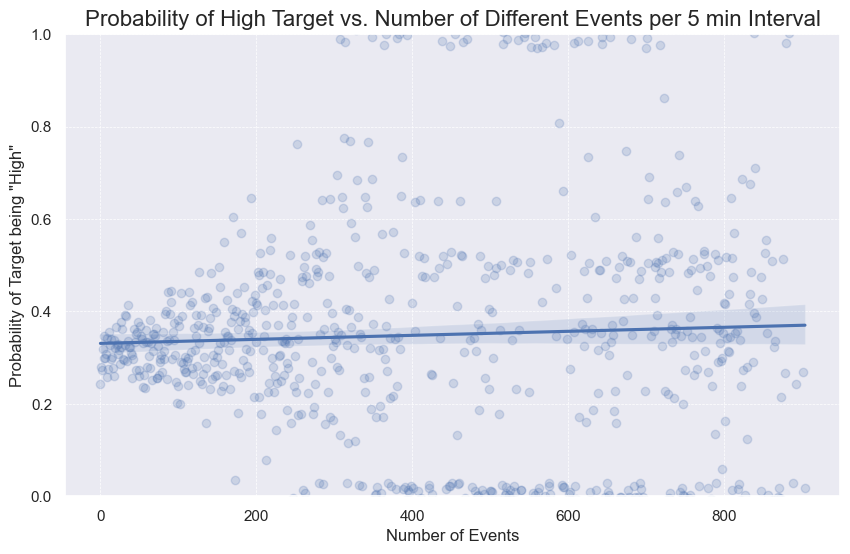

In [312]:
df_stat_nb_event = pd.concat([df_combined_condition.sum(axis=1), list_df[0]["target_cat"] == "high"], axis=1)
df_stat_nb_event.rename(columns={0: "nb_event"}, inplace=True)
# 1. Calculate the probability for each number of events
prob_df = df_stat_nb_event.groupby('nb_event')['target_cat'].mean().reset_index()
prob_df.rename(columns={'target_cat': 'probability_high'}, inplace=True)

""" # --- Seaborn Visualization ---
plt.figure(figsize=(12, 7))

# 2. Create the bar plot from the aggregated data
sns.scatterplot(x='nb_event', y='probability_high', data=prob_df, palette='viridis')

# --- Formatting the Plot ---
plt.title('Probability of High Target vs. Number of Concurrent Events', fontsize=16)
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show() """

plt.figure(figsize=(10, 6))

# Use regplot with logistic=True to fit and plot a logistic regression model.
# y_jitter adds a small amount of vertical noise to the points for better visibility.
sns.regplot(x='nb_event', y='probability_high', data=prob_df,
            ci=95, # Show 95% confidence interval
            y_jitter=.03, # Add jitter to see density of points at 0 and 1
            scatter_kws={'alpha': 0.2}) # Make scatter points transparent

# --- Formatting the Plot ---
plt.title('Probability of High Target vs. Number of Different Events per 5 min Interval', fontsize=16)
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1) # Give a little space around the 0 and 1 lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

=>
- Mean probability is increasing with number of different event per 5 min interval
- With a selection of Events with p_min = 0.4, we increase the mean prob by 0.03 (+3%) 

In [313]:
prob_df

nb_event  probability_high
0           0          0.218441
1           1          0.283729
2           2          0.294033
3           3          0.294759
4           4          0.300813
..        ...               ...
782       889          0.000000
783       893          0.250000
784       896          0.000000
785       901          0.250000
786       904          0.000000

[787 rows x 2 columns]

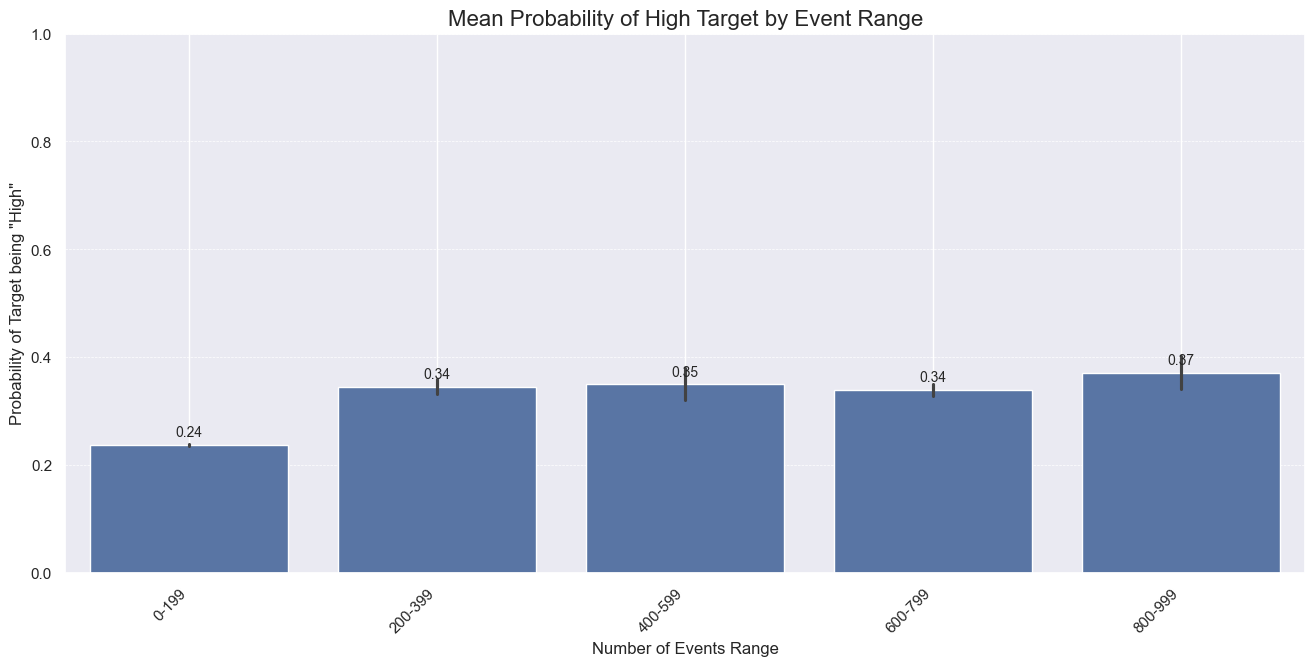

In [314]:
# 1. Define the bins for the number of events.
# We'll create bins of size 500, from 0 up to the maximum value.
max_events = df_stat_nb_event['nb_event'].max()
# Create bins like [0, 500, 1000, 1500, ...]
bins = np.arange(0, max_events + 200, 200)
# Create clear labels for the plot, like '0-499', '500-999', etc.
labels = [f'{int(bins[i])}-{int(bins[i+1]-1)}' for i in range(len(bins)-1)]


# 2. Use pandas.cut to segment the 'nb_event' column into these ranges.
df_stat_nb_event['event_range'] = pd.cut(df_stat_nb_event['nb_event'],
                                         bins=bins,
                                         labels=labels,
                                         right=False, # Makes intervals [0, 500), [500, 1000), etc.
                                         include_lowest=True) # Ensures 0 is included in the first bin

plt.figure(figsize=(16, 7))
ax = sns.barplot(data=df_stat_nb_event, y="target_cat", x="event_range")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10,
                xytext=(0, 9),
                textcoords='offset points')
# --- Formatting the Plot ---
plt.title('Mean Probability of High Target by Event Range', fontsize=16)
plt.xlabel('Number of Events Range', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
#plt.tight_layout() # Adjust plot to make sure labels don't get cut off
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.grid(True, 'both')
plt.show()

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/2345260547.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


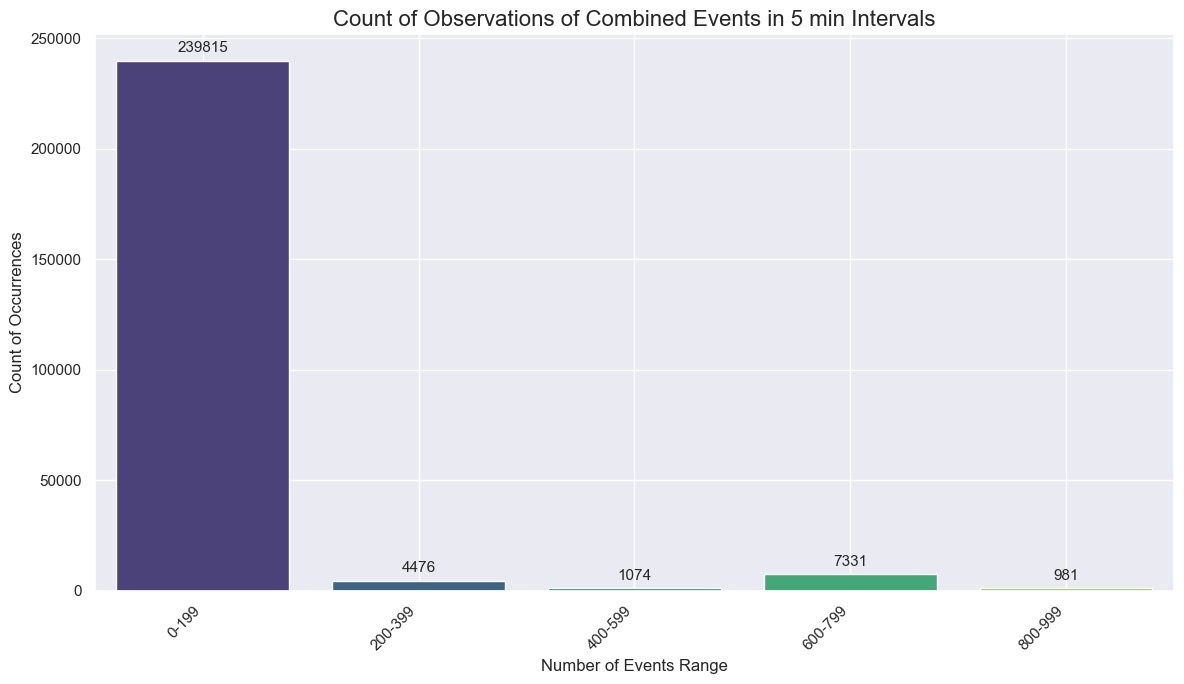

In [315]:
# --- Create the bar plot using seaborn.countplot ---
plt.figure(figsize=(12, 7))

# sns.countplot is the ideal function for this task.
# We use order to ensure the ranges are plotted in numerical order.
ax = sns.countplot(
    x='event_range',
    data=df_stat_nb_event,
    palette='viridis',
    order=labels # Use the generated labels to ensure correct sorting
)

# --- Add count labels on top of each bar for clarity ---
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=11,
                xytext=(0, 9),
                textcoords='offset points')

# --- Formatting the Plot ---
plt.title('Count of Observations of Combined Events in 5 min Intervals', fontsize=16)
plt.xlabel('Number of Events Range', fontsize=12)
plt.ylabel('Count of Occurrences', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
ax.grid(True, 'both')
plt.show()

with : nb_event_min = 8000 & prob_min = 0.4:
- Low or high number of events in time range of 5 min is very low represented so not useful : prob to happened is low
- Most represented : Around 5600-5800 events lead to 40+4% proba = 44% to be high

In [316]:
df_stat_nb_event

nb_event  target_cat event_range
date_ETH                                             
2023-01-01 00:00:00         0       False       0-199
2023-01-01 00:05:00         0       False       0-199
2023-01-01 00:10:00         0       False       0-199
2023-01-01 00:15:00         0       False       0-199
2023-01-01 00:20:00         0       False       0-199
...                       ...         ...         ...
2025-05-30 19:15:00         0       False       0-199
2025-05-30 19:20:00         0       False       0-199
2025-05-30 19:25:00         0       False       0-199
2025-05-30 19:30:00         0       False       0-199
2025-05-30 19:35:00         0        True       0-199

[253677 rows x 3 columns]

In [317]:
list_local_features = df_combined_condition.loc[
    df_stat_nb_event[
        (df_stat_nb_event["event_range"] == "800-999") &
        (df_stat_nb_event["target_cat"] == True)
    ].index.values
].sum(axis=0).sort_values(ascending=False).head(20)
print(list_local_features)
event_0 = list_local_features.index[0]

print(f"\nevent : {event_0}")
print(df_prob_comb_high_event.loc[event_0])
print('prob to appear : ', df_combined_condition[event_0].sum(axis=0) / df_combined_condition.shape[0])
print("nb events :", df_combined_condition[event_0].sum(axis=0))

event_1 = list_local_features.index[1]
print(f"\nevent : {event_1}")
print(df_prob_comb_high_event.loc[event_1])
print('prob to appear : ', df_combined_condition[event_1].sum(axis=0) / df_combined_condition.shape[0])
print("nb events :", df_combined_condition[event_1].sum(axis=0))

391      363
35545    363
34924    363
34951    363
35086    363
35167    363
35221    363
35248    363
35383    363
35410    363
35626    363
34735    363
35680    363
35707    363
35815    363
35842    363
35977    363
36058    363
36112    363
36139    363
dtype: int64

event : 391
high                                     3213
low                                      2791
neutral                                  3328
p_high                               0.344299
p_low                                0.299078
delta_prob                          59.321785
feat_0                     max_high_d_ETH_cat
feat_0_cat                                low
lag_0                                      70
feat_1                     max_high_d_ETH_cat
feat_1_cat                                low
lag_1                                      71
feat_2                         vwap_w_ETH_cat
feat_2_cat                                low
lag_2                                      64
days_with_event         

In [318]:
list_local_features.index.values

array([  391, 35545, 34924, 34951, 35086, 35167, 35221, 35248, 35383,
       35410, 35626, 34735, 35680, 35707, 35815, 35842, 35977, 36058,
       36112, 36139])

In [319]:
df_prob_comb_high_event.shape

(1163, 21)

In [320]:
df_prob_comb_high_event.loc[list_local_features.index.values].T

391                 35545  \
high                                   3213                4088   
low                                    2791                3576   
neutral                                3328                4340   
p_high                             0.344299            0.340553   
p_low                              0.299078            0.297901   
delta_prob                        59.321785           68.409186   
feat_0                   max_high_d_ETH_cat  max_high_d_ETH_cat   
feat_0_cat                              low                 low   
lag_0                                    70                  64   
feat_1                   max_high_d_ETH_cat        High_ETH_cat   
feat_1_cat                              low                 low   
lag_1                                    71                   8   
feat_2                       vwap_w_ETH_cat      vwap_w_ETH_cat   
feat_2_cat                              low                 low   
lag_2                                    64                  56   
days_with_event                         422                 433   
weeks_with_event                        123                 124   
months_with_event                        29                  29   
ratio_days_with_event              0.479001            0.491487   
ratio_weeks_with_event             0.968504            0.976378   
ratio_months_with_event                 1.0                 1.0   

                                      34924                 34951  \
high                                   3855                  4395   
low                                    3357                  3877   
neutral                                4031                  4846   
p_high                              0.34288              0.335036   
p_low                              0.298586              0.295548   
delta_prob                        68.775374             64.875242   
feat_0                   max_high_d_ETH_cat    max_high_d_ETH_cat   
feat_0_cat                              low                   low   
lag_0                                    64                    64   
feat_1                          Low_ETH_cat           Low_ETH_cat   
feat_1_cat                              low                   low   
lag_1                                     8                     8   
feat_2                       vwap_w_ETH_cat  ichi_cloud_b_ETH_cat   
feat_2_cat                              low                   low   
lag_2                                    64                    40   
days_with_event                         426                   460   
weeks_with_event                        124                   126   
months_with_event                        29                    29   
ratio_days_with_event              0.483541              0.522134   
ratio_weeks_with_event             0.976378              0.992126   
ratio_months_with_event                 1.0                   1.0   

                                      35086               35167  \
high                                   4091                3639   
low                                    3590                3186   
neutral                                4343                3793   
p_high                             0.340236             0.34272   
p_low                               0.29857            0.300057   
delta_prob                        65.356334           60.134505   
feat_0                   max_high_d_ETH_cat  max_high_d_ETH_cat   
feat_0_cat                              low                 low   
lag_0                                    64                  64   
feat_1                          Low_ETH_cat         Low_ETH_cat   
feat_1_cat                              low                 low   
lag_1                                     8                   8   
feat_2                       vwap_w_ETH_cat      vwap_w_ETH_cat   
feat_2_cat                              low                 low   
lag_2                                  

### Per Day

In [321]:
global_event_by_day.describe()

count    881.000000
mean      71.357548
std       68.492919
min        0.000000
25%       17.000000
50%       52.000000
75%      102.000000
max      288.000000
dtype: float64

In [322]:
global_event_by_day.index.max()

Timestamp('2025-05-30 00:00:00')

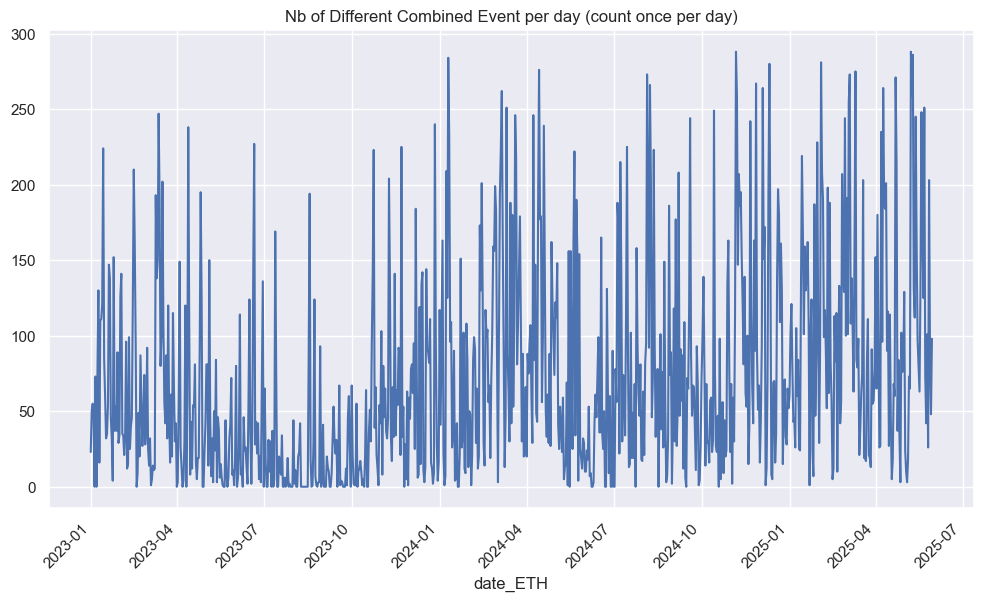

In [323]:
fig = plt.figure(figsize=(10, 6))

sns.lineplot(global_event_by_day, markers="o")
# change x axis ticker format at 45°
# Rotate the x-axis tick labels to 45 degrees.
# Using ha='right' aligns the end of the label with the tick, which often looks better.
plt.xticks(rotation=45, ha='right')

# Adjust plot to make sure labels don't get cut off
plt.tight_layout()

# title
plt.title("Nb of Different Combined Event per day (count once per day)")
# Display the plot
plt.show()

Text(0.5, 1.0, 'Distribution of Number of Events per Day')

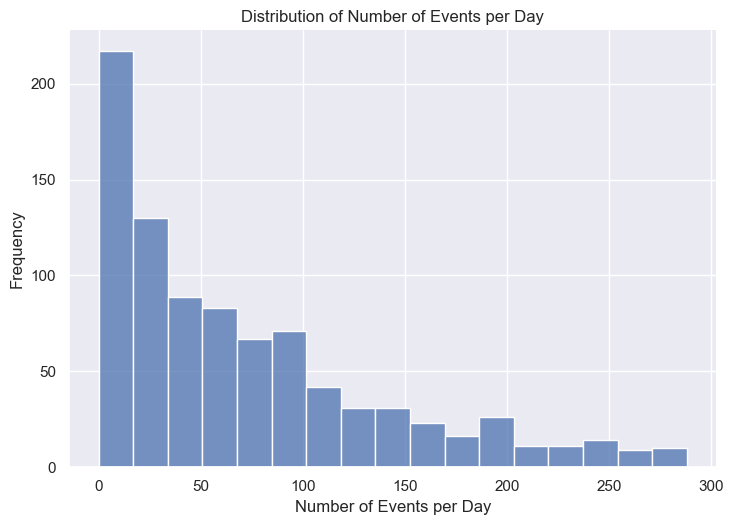

In [324]:

sns.displot(global_event_by_day, height=5, aspect=1.5)
fig = plt.gcf()
ax = fig.gca()
ax.set_xlabel("Number of Events per Day")
ax.set_ylabel("Frequency")
plt.title("Distribution of Number of Events per Day")

In [325]:
df_prob_comb_high_event

high   low  neutral    p_high     p_low  delta_prob  \
391     3213  2791     3328  0.344299  0.299078   59.321785   
418     3717  3278     4092  0.335258  0.295662   55.102502   
553     3433  3003     3620  0.341388  0.298628   57.458048   
595     1007   836     1072  0.345455  0.286792   31.731959   
634     3046  2658     3146  0.344181  0.300339   52.785414   
...      ...   ...      ...       ...       ...         ...   
216799  1137   914     1350  0.334313  0.268744   48.492443   
217885  1039   857     1217  0.333762  0.275297   34.940928   
218527  1111   890     1314  0.335143  0.268477   48.816592   
218716  1149   975     1226  0.342985  0.291045   28.508475   
218849  1241  1060     1274  0.347133  0.296503   28.475445   

                    feat_0 feat_0_cat  lag_0               feat_1  ... lag_1  \
391     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat  ...    71   
418     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat  ...    71   
553     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat  ...    71   
595     max_high_d_ETH_cat       high     70   max_high_d_ETH_cat  ...    71   
634     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat  ...    71   
...                    ...        ...    ...                  ...  ...   ...   
216799      vwap_d_ETH_cat        low      8  ichi_tenkan_ETH_cat  ...    56   
217885        Open_ETH_cat    neutral     56   ichi_kijun_ETH_cat  ...     8   
218527  ichi_kijun_ETH_cat        low      8  ichi_tenkan_ETH_cat  ...    56   
218716  ichi_kijun_ETH_cat        low     40  ichi_tenkan_ETH_cat  ...    56   
218849  ichi_kijun_ETH_cat        low     40    min_low_d_ETH_cat  ...     8   

                      feat_2 feat_2_cat lag_2  days_with_event  \
391           vwap_w_ETH_cat        low    64              422   
418     ichi_cloud_b_ETH_cat        low    40              457   
553           vwap_w_ETH_cat        low    56              430   
595     ichi_cloud_a_ETH_cat        low     8               82   
634           vwap_w_ETH_cat        low    68              411   
...                      ...        ...   ...              ...   
216799        vwap_d_ETH_cat        low    56              583   
217885        vwap_d_ETH_cat        low    56              584   
218527        vwap_d_ETH_cat        low    56              572   
218716     min_low_d_ETH_cat        low     8              213   
218849        vwap_h_ETH_cat    neutral    56              214   

        weeks_with_event  months_with_event  ratio_days_with_event  \
391                  123                 29               0.479001   
418                  126                 29               0.518729   
553                  124                 29               0.488082   
595                   45                 22               0.093076   
634                  122                 29               0.466515   
...                  ...                ...                    ...   
216799               124                 29               0.661748   
217885               123                 29               0.662883   
218527               124                 29               0.649262   
218716                88                 28               0.241771   
218849                88                 28               0.242906   

        ratio_weeks_with_event  ratio_months_with_event  
391                   0.968504                 1.000000  
418                   0.992126                 1.000000  
553                   0.976378                 1.000000  
595                   0.354331                 0.758621  
634                   0.960630                 1.000000  
...                        ...                      ...  
216799                0.976378                 1.000000  
217885                0.968504                 1.000000  
218527                0.976378                 1.000000  
218716                0.692913                 0.965517  
218849            

In [326]:
list_df[0]

Close_ETH  Open_ETH  High_ETH   Low_ETH  \
date_ETH                                                       
2023-01-01 00:00:00        1.0  0.999782  1.000109  0.999774   
2023-01-01 00:05:00        1.0  0.999548  1.000008  0.999540   
2023-01-01 00:10:00        1.0  1.000084  1.000193  0.999841   
2023-01-01 00:15:00        1.0  1.000770  1.000770  0.999900   
2023-01-01 00:20:00        1.0  0.999330  1.000025  0.999330   
...                        ...       ...       ...       ...   
2025-05-30 19:15:00        1.0  0.998258  1.001698  0.997009   
2025-05-30 19:20:00        1.0  0.998554  1.001387  0.998451   
2025-05-30 19:25:00        1.0  1.004900  1.005056  0.999299   
2025-05-30 19:30:00        1.0  1.001168  1.001491  0.997621   
2025-05-30 19:35:00        1.0  1.012121  1.014171  0.998487   

                     ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  \
date_ETH                                                                  
2023-01-01 00:00:00          0.999171          0.999736        0.998393   
2023-01-01 00:05:00          0.998785          0.999276        0.998113   
2023-01-01 00:10:00          0.998860          0.999351        0.998243   
2023-01-01 00:15:00          0.999669          1.000113        0.999003   
2023-01-01 00:20:00          0.999178          0.999443        0.998335   
...                               ...               ...             ...   
2025-05-30 19:15:00          1.009059          1.012239        1.000323   
2025-05-30 19:20:00          1.006895          1.010775        0.998877   
2025-05-30 19:25:00          1.011829          1.015728        1.003772   
2025-05-30 19:30:00          1.011492          1.015731        1.004944   
2025-05-30 19:35:00          1.023400          1.028043        1.011526   

                     ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
date_ETH                                                     
2023-01-01 00:00:00         0.999464              2.024261   
2023-01-01 00:05:00         0.999184              2.023329   
2023-01-01 00:10:00         0.999477              2.023482   
2023-01-01 00:15:00         1.000239              2.025023   
2023-01-01 00:20:00         0.999569              2.023668   
...                              ...                   ...   
2025-05-30 19:15:00         1.000559              1.043299   
2025-05-30 19:20:00         0.999113              1.041791   
2025-05-30 19:25:00         1.004009              1.046896   
2025-05-30 19:30:00         1.003987              1.048118   
2025-05-30 19:35:00         1.009147              1.060823   

                     ichi_cloud_b_day_ETH  ...  hour_cos_cat  hour_sin_cat  \
date_ETH                                   ...                               
2023-01-01 00:00:00              2.017807  ...       neutral          high   
2023-01-01 00:05:00              2.016878  ...       neutral          high   
2023-01-01 00:10:00              2.017030  ...       neutral          high   
2023-01-01 00:15:00              2.018567  ...       neutral          high   
2023-01-01 00:20:00              2.017215  ...       neutral          high   
...                                   ...  ...           ...           ...   
2025-05-30 19:15:00              1.026564  ...          high       neutral   
2025-05-30 19:20:00              1.025079  ...          high       neutral   
2025-05-30 19:25:00              1.030103  ...          high       neutral   
2025-05-30 19:30:00              1.031306  ...          high       neutral   
2025-05-30 19:35:00              1.043807  ...          high       neutral   

                     weekday_cos_cat  weekday_sin_cat  day_in_month_cos_cat  \
date_ETH                                                                      
2023-01-01 00:00:00          neutral          neutral                  high   
2023-01-01 00:05:00          neutral          neutral                  high   
2023-01-01 00:10:00          neutral          neutral                  hig

In [327]:
df_combined_condition

391     418     553     595     634     688     715     \
date_ETH                                                                      
2023-01-01 00:00:00   False   False   False   False   False   False   False   
2023-01-01 00:05:00   False   False   False   False   False   False   False   
2023-01-01 00:10:00   False   False   False   False   False   False   False   
2023-01-01 00:15:00   False   False   False   False   False   False   False   
2023-01-01 00:20:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False   False   False   False   False   
2025-05-30 19:20:00   False   False   False   False   False   False   False   
2025-05-30 19:25:00   False   False   False   False   False   False   False   
2025-05-30 19:30:00   False   False   False   False   False   False   False   
2025-05-30 19:35:00   False   False   False   False   False   False   False   

                     1120    1147    1282    ...  213120  213484  214429  \
date_ETH                                     ...                           
2023-01-01 00:00:00   False   False   False  ...   False   False   False   
2023-01-01 00:05:00   False   False   False  ...   False   False   False   
2023-01-01 00:10:00   False   False   False  ...   False   False   False   
2023-01-01 00:15:00   False   False   False  ...   False   False   False   
2023-01-01 00:20:00   False   False   False  ...   False   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False  ...   False   False   False   
2025-05-30 19:20:00   False   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False   False  ...   False   False   False   
2025-05-30 19:30:00   False   False   False  ...   False   False   False   
2025-05-30 19:35:00   False   False   False  ...   False   False   False   

                     215746  215879  216799  217885  218527  218716  218849  
date_ETH                                                                     
2023-01-01 00:00:00   False   False   False   False   False   False   False  
2023-01-01 00:05:00   False   False   False   False   False   False   False  
2023-01-01 00:10:00   False   False   False   False   False   False   False  
2023-01-01 00:15:00   False   False   False   False   False   False   False  
2023-01-01 00:20:00   False   False   False   False   False   False   False  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[253677 rows x 1163 columns]

In [328]:
df_prob_comb_high_event.sort_values(by=["p_high"], ascending=False).head(20)

high   low  neutral    p_high     p_low  delta_prob  \
100753  1028   774     1058  0.359441  0.270629   71.604883   
101939  1114   800     1217  0.355797  0.255509  103.026123   
117273  1053   885     1023  0.355623  0.298886   29.126935   
106618  1144   893     1180  0.355611  0.277588   61.856652   
113682  1044   878     1017  0.355223  0.298741   28.674298   
116382  1038   875     1010  0.355115  0.299350   27.777313   
116841  1040   875     1014  0.355070  0.298737   28.433420   
118407  1073   898     1052  0.354945  0.297056   31.075596   
118731  1088   910     1069  0.354744  0.296707   31.715716   
120432  1091   918     1076  0.353647  0.297569   29.794923   
104047  1307  1000     1397  0.352862  0.269978   81.706979   
128613  1102   939     1098  0.351067  0.299140   26.035277   
127479  1081   928     1071  0.350974  0.301299   23.304131   
98051   1718  1360     1818  0.350899  0.277778   83.277453   
123888  1071   922     1062  0.350573  0.301800   22.278976   
102535  1414  1051     1569  0.350521  0.260535  106.911968   
127047  1063   919     1056  0.349901  0.302502   20.924319   
120510  1020   795     1101  0.349794  0.272634   55.785124   
128937  1122   964     1122  0.349751  0.300499   23.934803   
126588  1058   919     1052  0.349290  0.303400   19.545776   

                      feat_0 feat_0_cat  lag_0              feat_1  ... lag_1  \
100753        vwap_w_ETH_cat        low     64  max_high_h_ETH_cat  ...    40   
101939  ichi_cloud_b_ETH_cat        low     40      vwap_h_ETH_cat  ...    40   
117273     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    64   
106618    max_high_h_ETH_cat    neutral     40      vwap_w_ETH_cat  ...    56   
113682     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    68   
116382     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    71   
116841     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    70   
118407     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    56   
118731     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    40   
120432     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...     8   
104047        vwap_h_ETH_cat        low     40  max_high_h_ETH_cat  ...    40   
128613           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    56   
127479           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    64   
98051      min_low_h_ETH_cat        low      8      vwap_h_ETH_cat  ...    40   
123888           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    68   
102535  ichi_cloud_b_ETH_cat        low     40  max_high_h_ETH_cat  ...    40   
127047           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    70   
120510     min_low_h_ETH_cat        low     40        High_ETH_cat  ...    56   
128937           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    40   
126588           Low_ETH_cat        low     40   min_low_d_ETH_cat  ...    71   

                      feat_2 feat_2_cat lag_2  days_with_event  \
100753           Low_ETH_cat        low    40              281   
101939    max_high_h_ETH_cat    neutral    40              412   
117273          High_ETH_cat       high    56              179   
106618           Low_ETH_cat        low    40              299   
113682          High_ETH_cat       high    56              179   
116382          High_ETH_cat       high    56              177   
116841          High_ETH_cat       high    56              177   
118407          High_ETH_cat       high    56              182   
118731          High_ETH_cat       high    56              185   
120432          High_ETH_cat       high    56              191   
104047  ichi_cloud_a_ETH_cat        low     8              455   
128613          High_ETH_cat       high    56              200   
127479          High_ETH_cat       high    56              198   
98051     max_high_h_ETH_cat    neutral    40             

In [329]:
df_prob_comb_high_event.high.describe()

count    1163.000000
mean     2949.522786
std      1255.419597
min      1002.000000
25%      1661.000000
50%      3123.000000
75%      3808.000000
max      7304.000000
Name: high, dtype: float64

## ML Models on 3-events-comb

### Find ML model to improve prob

#### RandomForest : all data

--- Finding Important Events with Random Forest ---

Saving model to data/rf_prob_model.joblib...
Model saved successfully.

Feature Importances (most predictive individual events):
52987     2.527460e-02
45454     1.897301e-02
120544    1.775936e-02
98647     1.459003e-02
100318    1.260076e-02
              ...     
20938     0.000000e+00
20965     0.000000e+00
21019     0.000000e+00
24340     0.000000e+00
16672    -4.040620e-19
Length: 1163, dtype: float64


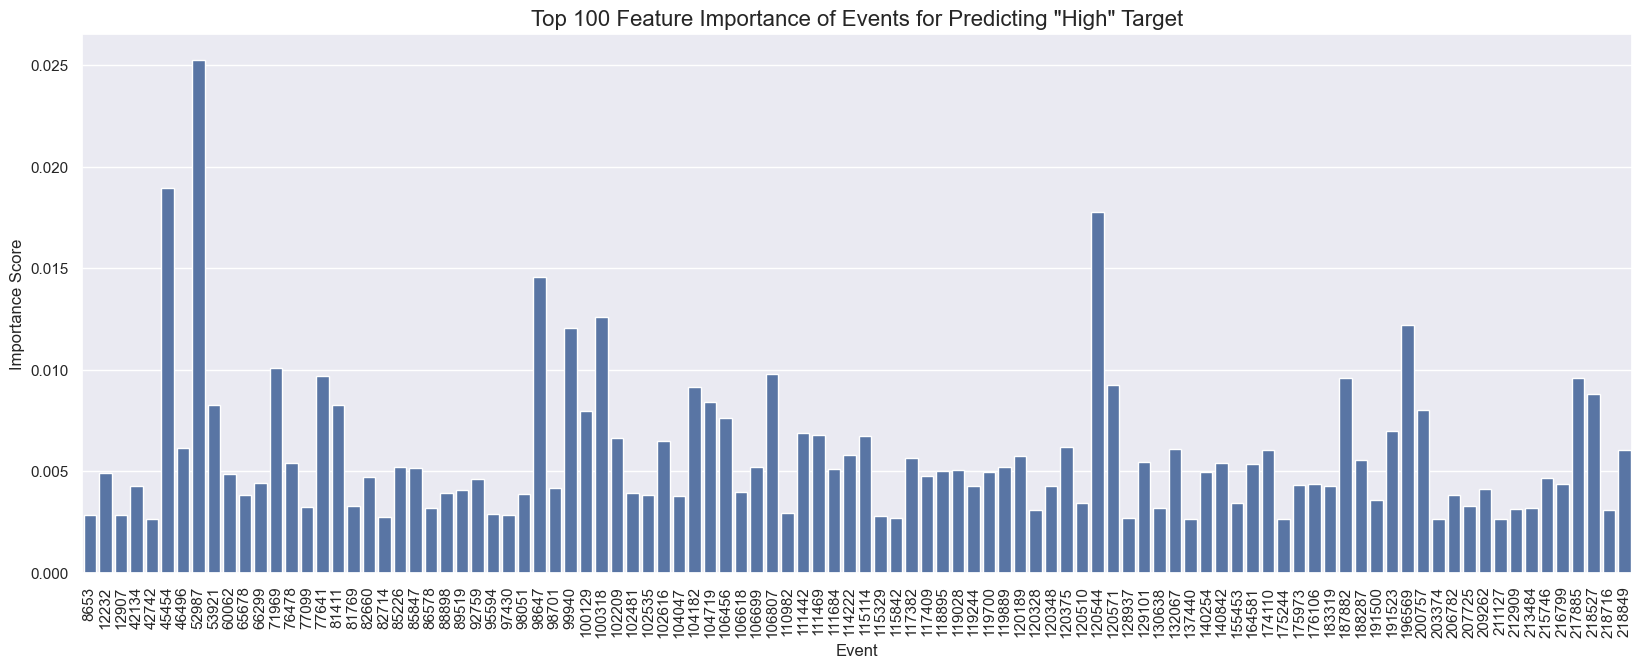

In [332]:
from sklearn.ensemble import RandomForestClassifier
model_rf_prob_filename = os.path.join(path_data, 'rf_prob_model.joblib')
mode_rf = True
y_comb = (list_df[0]["target_cat"] == "high")
if mode_rf:
    # VERY SLOW Training Time with 2 Estimators = 100 min ! 
    # 1. Prepare the data for modeling
    #X_comb = df_combined_condition
    
    # 2. Use a Random Forest to find important features
    print("--- Finding Important Events with Random Forest ---")
    # class_weight='balanced' is useful if "high" targets are rare
    rf_model = RandomForestClassifier(n_estimators=2, random_state=42, class_weight='balanced')
    rf_model.fit(df_combined_condition, y_comb)
    # 2. Save the model to a file
    
    print(f"\nSaving model to {model_rf_prob_filename}...")
    joblib.dump(rf_model, model_rf_prob_filename)
    print("Model saved successfully.")
else:
    # 3. Load the model from the file
    # This can be done in a different script or a later session.
    print(f"\nLoading model from {model_rf_prob_filename}...")
    rf_model = joblib.load(model_rf_prob_filename)
    print("Model loaded successfully.")
# Get and plot feature importances
importances = pd.Series(rf_model.feature_importances_, index=df_combined_condition.columns).sort_values(ascending=False)
print("\nFeature Importances (most predictive individual events):")
print(importances)
# Plot the importances of the top 100 features
plt.figure(figsize=(20, 7))
sns.barplot(y=importances.head(100).values, x=importances.head(100).index)
plt.title('Top 100 Feature Importance of Events for Predicting "High" Target', fontsize=16)
plt.ylabel('Importance Score', fontsize=12)
plt.xlabel('Event', fontsize=12)
plt.xticks(rotation=90, ha='center')
plt.show()

In [333]:
importances.head(10)

52987     0.025275
45454     0.018973
120544    0.017759
98647     0.014590
100318    0.012601
196569    0.012192
99940     0.012054
71969     0.010104
106807    0.009779
77641     0.009669
dtype: float64

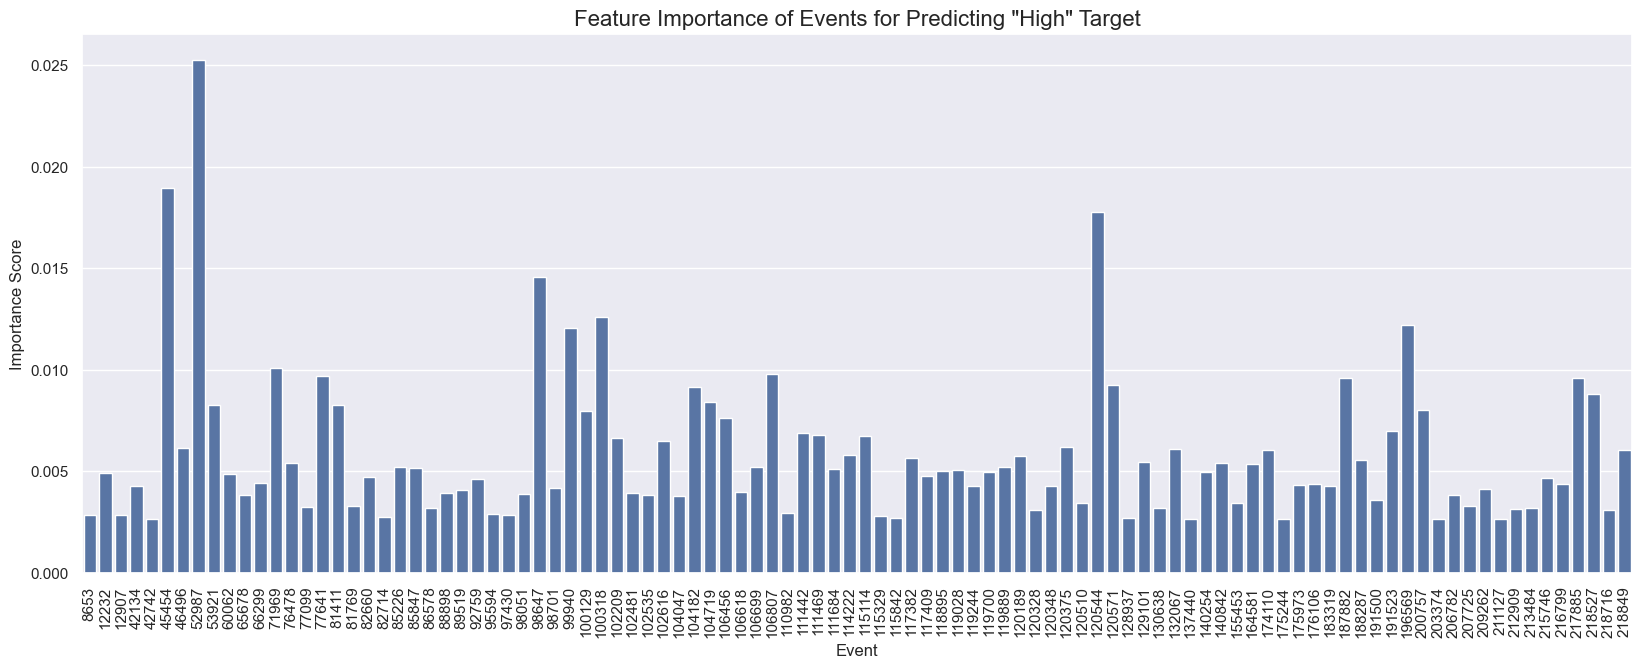

In [334]:
plt.figure(figsize=(20, 7))
sns.barplot(y=importances.head(100).values, x=importances.head(100).index)
plt.title('Feature Importance of Events for Predicting "High" Target', fontsize=16)
plt.ylabel('Importance Score', fontsize=12)
plt.xlabel('Event', fontsize=12)
plt.xticks(rotation=90, ha='center')
plt.show()

In [335]:
importances.head(100).index

Index([ 52987,  45454, 120544,  98647, 100318, 196569,  99940,  71969, 106807,
        77641, 217885, 187882, 120571, 104182, 218527, 104719,  53921,  81411,
       200757, 100129, 106456, 191523, 111442, 111469, 115114, 102209, 102616,
       120375,  46496, 132067, 174110, 218849, 114222, 120189, 117382, 188287,
       129101, 140842,  76478, 164581, 106699, 119889,  85226,  85847, 111684,
       119028, 118895, 119700, 140254,  12232,  60062, 117409,  82660, 215746,
        92759,  66299, 216799, 176106, 175973, 119244, 183319, 120348,  42134,
        98701, 209262,  89519, 106618,  88898, 102481,  98051, 102535,  65678,
       206782, 104047, 191500, 155453, 120510, 207725,  81769,  77099, 130638,
        86578, 213484, 212909, 218716, 120328, 110982,  95594,  12907,   8653,
        97430, 115329,  82714, 115842, 128937, 137440,  42742, 203374, 211127,
       175244],
      dtype='int64')

In [336]:
importances

52987     2.527460e-02
45454     1.897301e-02
120544    1.775936e-02
98647     1.459003e-02
100318    1.260076e-02
              ...     
20938     0.000000e+00
20965     0.000000e+00
21019     0.000000e+00
24340     0.000000e+00
16672    -4.040620e-19
Length: 1163, dtype: float64

In [337]:
df_prob_comb_high_event.loc[importances.head(4).index.values].T

52987                 45454   \
high                                     5403                  4906   
low                                      4766                  4405   
neutral                                  5960                  5420   
p_high                               0.334987              0.333039   
p_low                                0.295493              0.299029   
delta_prob                          79.805094             53.914939   
feat_0                     max_high_d_ETH_cat    max_high_d_ETH_cat   
feat_0_cat                                low                   low   
lag_0                                      40                    56   
feat_1                   ichi_cloud_b_ETH_cat  ichi_cloud_b_ETH_cat   
feat_1_cat                                low                   low   
lag_1                                      40                    40   
feat_2                         vwap_w_ETH_cat          Open_ETH_cat   
feat_2_cat                                low                   low   
lag_2                                      56                    40   
days_with_event                           414                   455   
weeks_with_event                          124                   125   
months_with_event                          29                    29   
ratio_days_with_event                0.469921              0.516459   
ratio_weeks_with_event               0.976378              0.984252   
ratio_months_with_event                   1.0                   1.0   

                                    120544              98647   
high                                  1138                2518  
low                                    930                2062  
neutral                               1343                2945  
p_high                            0.333627            0.334618  
p_low                             0.272647             0.27402  
delta_prob                       41.841393           90.801747  
feat_0                   min_low_h_ETH_cat   min_low_h_ETH_cat  
feat_0_cat                             low                 low  
lag_0                                   40                   8  
feat_1                        High_ETH_cat  max_high_h_ETH_cat  
feat_1_cat                         neutral             neutral  
lag_1                                   56                  40  
feat_2                      vwap_d_ETH_cat         Low_ETH_cat  
feat_2_cat                             low                 low  
lag_2                                   56                  40  
days_with_event                        635                 639  
weeks_with_event                       126                 124  
months_with_event                       29                  29  
ratio_days_with_event             0.720772            0.725312  
ratio_weeks_with_event            0.992126            0.976378  
ratio_months_with_event                1.0                 1.0

In [338]:
rf_model.score(df_combined_condition, y_comb)

0.7139787998123598

=> Probably Overfitting


--- Visualizing Event Combinations with a Decision Tree ---


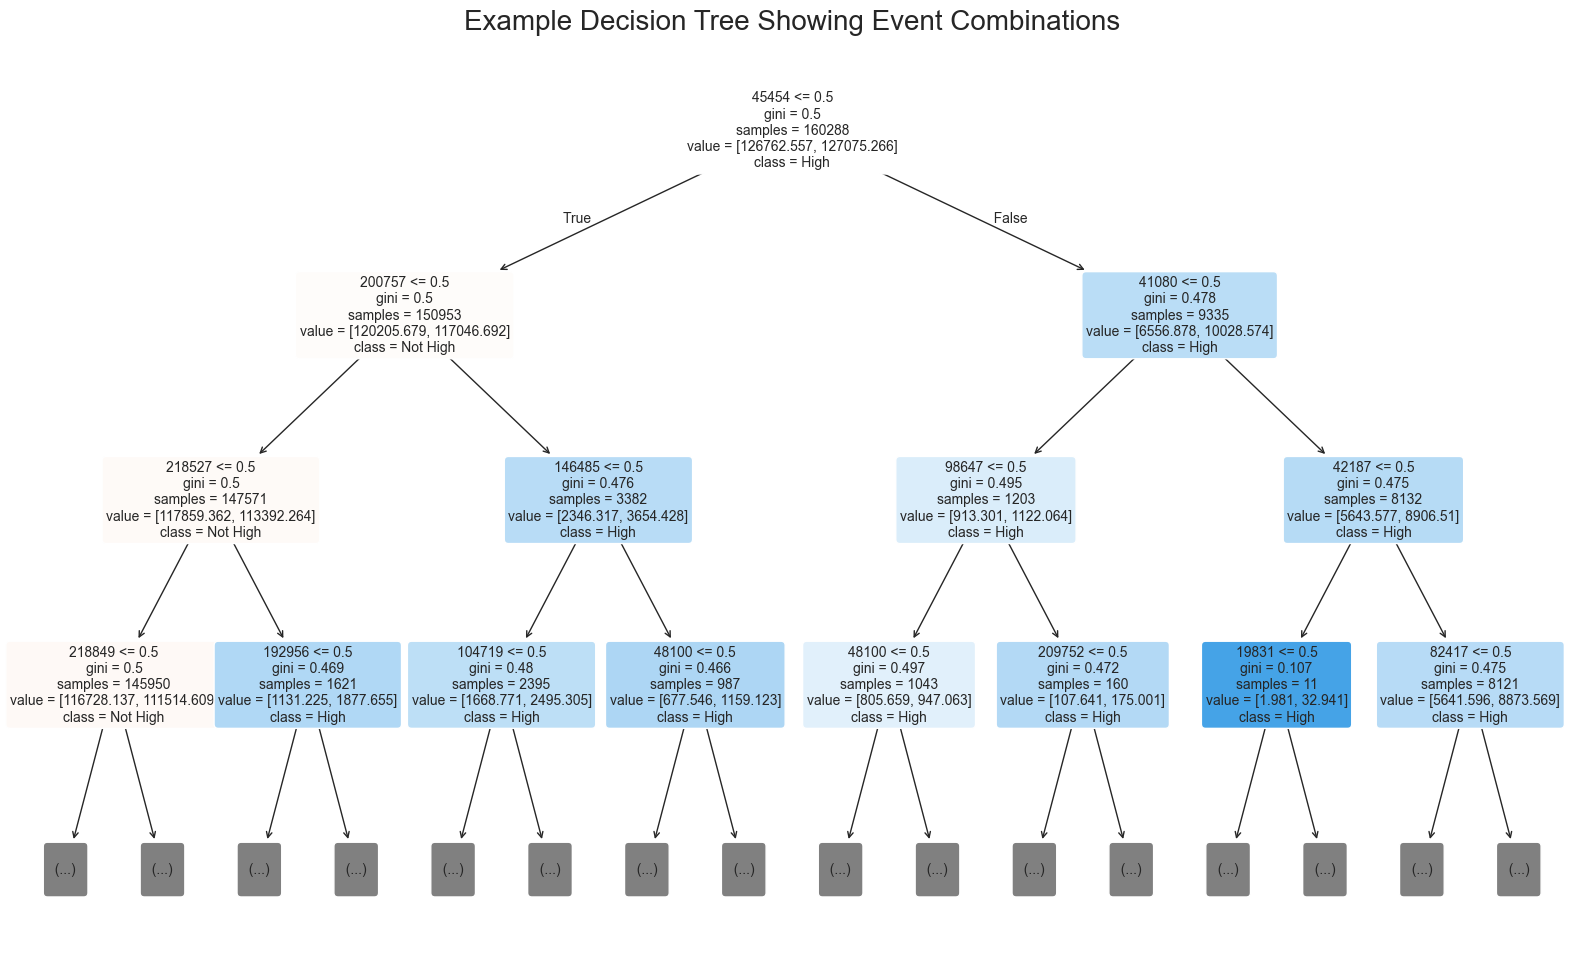

In [339]:
from sklearn.tree import plot_tree
# 3. Visualize a Decision Tree to see the combinations
print("\n--- Visualizing Event Combinations with a Decision Tree ---")
# Let's pick one tree from our trained forest (e.g., the 5th one)
single_tree = rf_model.estimators_[0]

plt.figure(figsize=(20, 12))
plot_tree(single_tree,
          feature_names=df_combined_condition.columns,
          class_names=['Not High', 'High'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3) # Limit depth for better readability
plt.title("Example Decision Tree Showing Event Combinations", fontsize=20)
plt.show()

#### RandomForest : train / test 

In [936]:
# train split 
# It's good practice to split data to evaluate the model
from sklearn.model_selection import train_test_split
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    df_combined_condition,
    y_comb,
    test_size=0.3,
    shuffle=False
)
# time range for train and test
print("Train time range: ", X_rf_train.index.min(), " to ", X_rf_train.index.max())
print("Train time duration: ", X_rf_train.index.max() - X_rf_train.index.min())
print("Test time range: ", X_rf_test.index.min(), " to ", X_rf_test.index.max())
print("Test time duration: ", X_rf_test.index.max() - X_rf_test.index.min())


Train time range:  2023-01-01 00:00:00  to  2024-09-08 13:40:00
Train time duration:  616 days 13:40:00
Test time range:  2024-09-08 13:45:00  to  2025-05-30 19:35:00
Test time duration:  264 days 05:50:00


In [340]:
# max_features="sqrt", max_samples=0.6
# accuracy Train / Test
# 58/56 : 27s : min_samples_leaf=1000,n_estimators=10 ,max_depth=2,
# 58/56 : 30s : min_samples_leaf=1000,n_estimators=100,max_depth=2,
# 58/56 : 35s : min_samples_leaf=1000,n_estimators=100,max_depth=3,
# 58/56 : 30s : min_samples_leaf=1000,n_estimators=30 ,max_depth=3,
# 58/56 : 28s : min_samples_leaf=1000,n_estimators=30 ,max_depth=3, max_samples=0.8,
# 58/56+: 29s : min_samples_leaf=100 ,n_estimators=30 ,max_depth=3, max_samples=0.6,
# 59/56+: 33s : min_samples_leaf=100 ,n_estimators=30 ,max_depth=4,
# 59/56+: 44s : min_samples_leaf=100 ,n_estimators=100,max_depth=4,
# 59/56+: 29s : min_samples_leaf=100 ,n_estimators=10 ,max_depth=4,
# 59/56-: 31s : min_samples_leaf=100 ,n_estimators=10 ,max_depth=5,
# 59/56-: 31s : min_samples_leaf=10 ,n_estimators=10  ,max_depth=5,
# 59/56:9m29s : min_samples_leaf=3  ,n_estimators=300 ,max_depth=7, max_features=300, max_samples=0.8,

    random_state=42,
    n_jobs=-1,
    #criterion="entropy",
    max_features=10,#"sqrt", # "sqrt", # default
    max_samples=0.6,
    min_samples_split=10,
    n_estimators=100,
    max_depth=3,
    class_weight={True: 1.9, False: 1},#"balanced",
    on Test data : 
precision: 0.386
% possible trades : 0.63
nb trade per day : 2

Model trained.
on Train data : 
Accuracy on training data: 0.7777702691287527
precision: 0.471
% possible trades : 0.33
nb trade per day : 1
on Test data : 
Accuracy on test data: 0.7071244612635341
precision: 0.386
% possible trades : 0.63
nb trade per day : 2


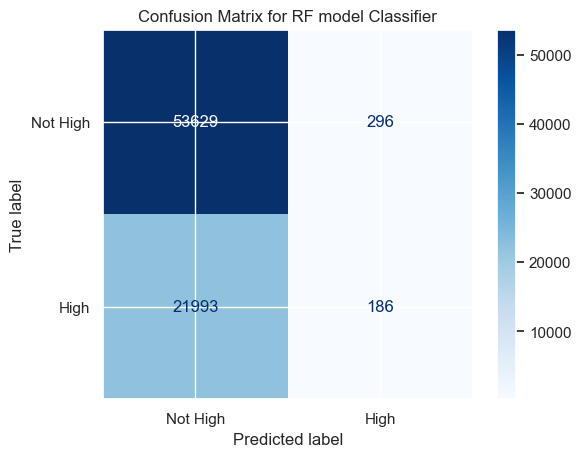

In [342]:
y_rf_high_train, y_rf_high_test, y_rf_low_train, y_rf_low_test = train_test_split(
    y_high_train,
    y_low_train,
    test_size=0.3,
    shuffle=False
)

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    #criterion="entropy",
    max_features=10,#"sqrt", # "sqrt", # default
    max_samples=0.6,
    min_samples_split=10,
    n_estimators=100,
    max_depth=3,
    class_weight={True: 1.9, False: 1},#"balanced",
    #oob_score=precision_score,
)
rf.fit(X_rf_train, y_rf_train)
print("Model trained.")
arr_mdl_pred_train = rf.predict(X_rf_train)
print("on Train data : ")
print("Accuracy on training data:", rf.score(X_rf_train, y_rf_train))
print(f"precision: {precision_score(y_rf_train, arr_mdl_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_mdl_pred_train) / arr_mdl_pred_train.shape[0]:.2f}")
# per day 
print(f"nb trade per day : {288*arr_mdl_pred_train.sum() / arr_mdl_pred_train.shape[0]:.0f}")
arr_mdl_pred = rf.predict(X_rf_test)
print("on Test data : ")
print("Accuracy on test data:", rf.score(X_rf_test, y_rf_test))
print(f"precision: {precision_score(y_rf_test, arr_mdl_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_mdl_pred) / arr_mdl_pred.shape[0]:.2f}")
# per day 
print(f"nb trade per day : {288*arr_mdl_pred.sum() / arr_mdl_pred.shape[0]:.0f}")

cm = confusion_matrix(y_rf_test, arr_mdl_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for RF model Classifier")
plt.show()



--- Visualizing Event Combinations with a Decision Tree ---


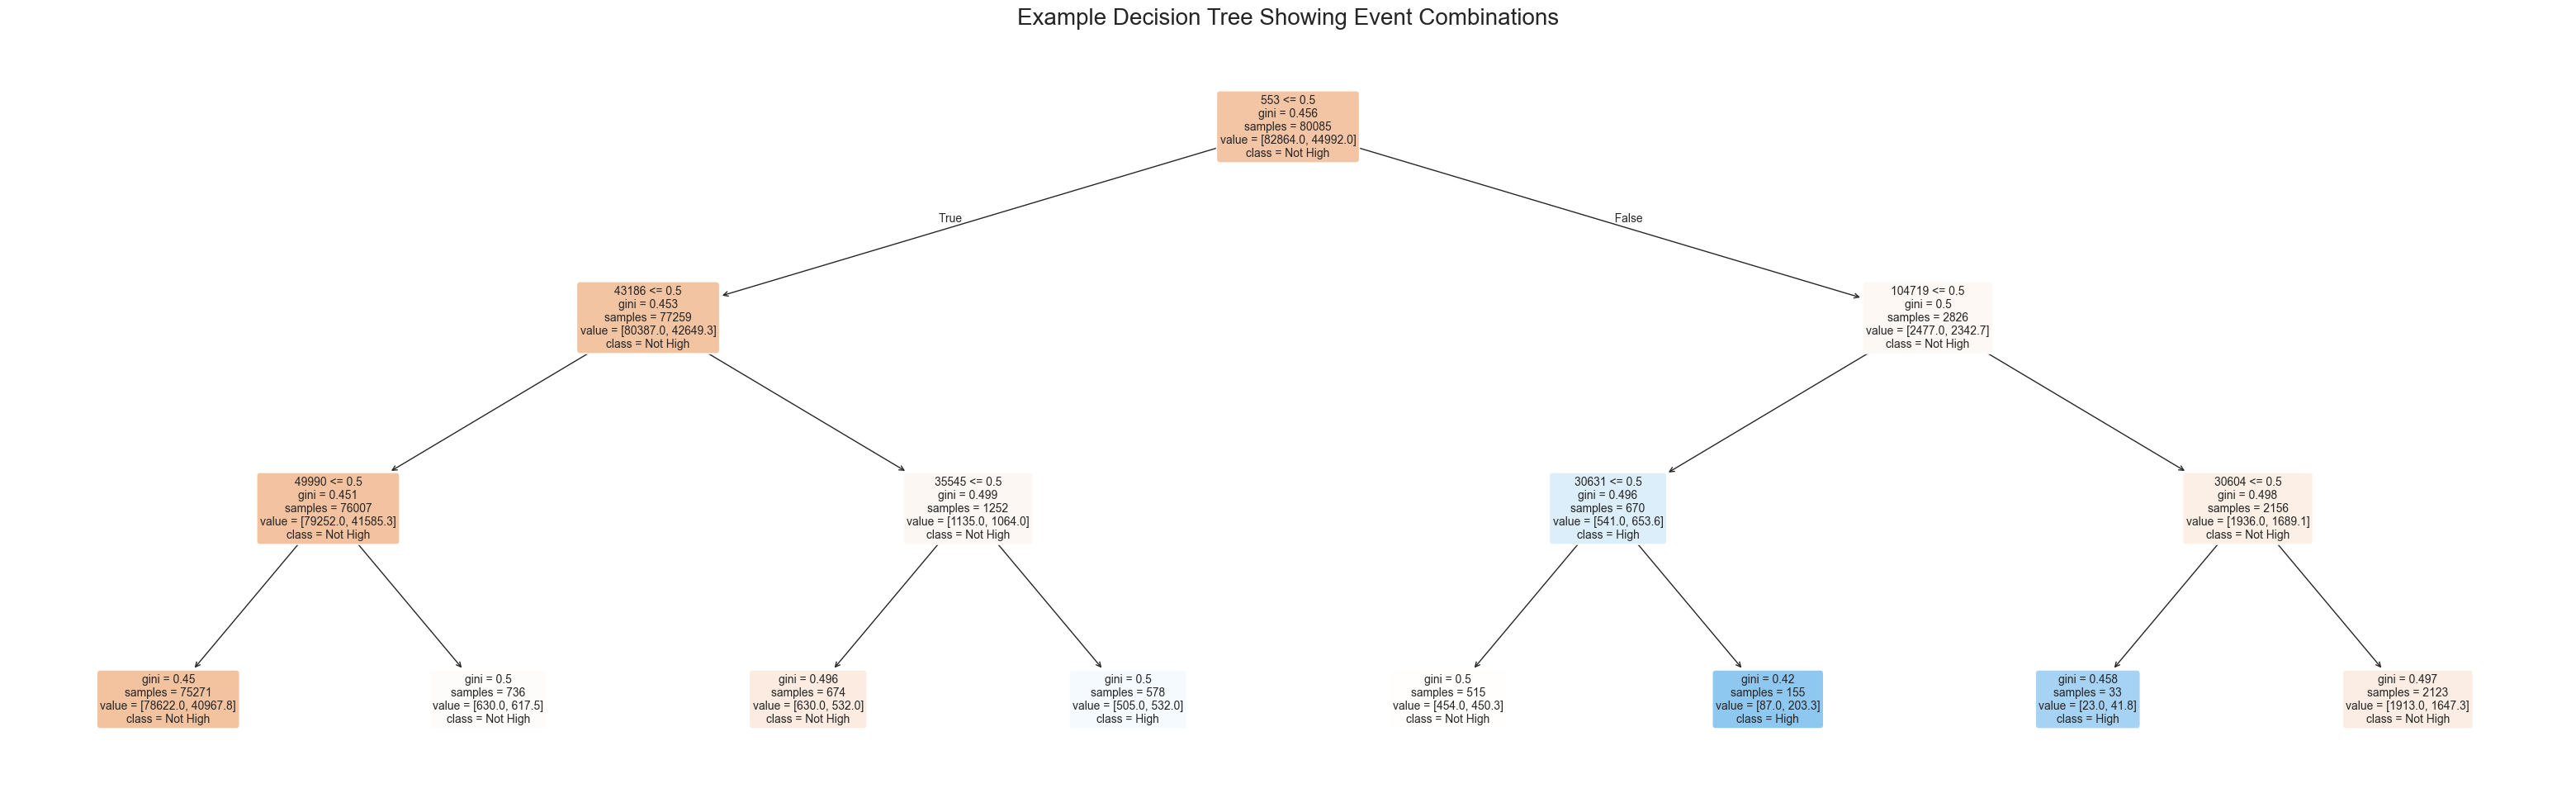

In [345]:
from sklearn.tree import plot_tree
# 3. Visualize a Decision Tree to see the combinations
print("\n--- Visualizing Event Combinations with a Decision Tree ---")
# Let's pick one tree from our trained forest (e.g., the 5th one)
single_tree = rf.estimators_[0]

plt.figure(figsize=(40, 12))
plot_tree(single_tree,
          feature_names=df_combined_condition.columns,
          class_names=['Not High', 'High'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=5) # Limit depth for better readability
plt.title("Example Decision Tree Showing Event Combinations", fontsize=20)
plt.show()

In [346]:
list_df[0]["target_cat"].value_counts()

target_cat
neutral    128870
low         63200
high        61607
Name: count, dtype: int64

In [347]:
list_df[0]["target_cat"].value_counts() / list_df[0].shape[0]

target_cat
neutral    0.508008
low        0.249136
high       0.242856
Name: count, dtype: float64

#### SGDClassifier

In [348]:
# # precision: 0.51
# # % possible trades : 0.48
# # nb trade per day : 1
# sgdc = SGDClassifier(
#     loss="log_loss",
#     penalty="l1",  # ou "elasticnet" si besoin de L1+L2
#     alpha=1e-3,
#     max_iter=1000,
#     tol=1e-3,
#     early_stopping=True,
#     class_weight={True: 1.9, False: 1},
#     random_state=42
# )

# precision: 0.40
# % possible trades : 3.21
# nb trade per day : 9
# sgdc = SGDClassifier(
#     loss="log_loss",
#     penalty="elasticnet",  # ou "elasticnet" si besoin de L1+L2
#     alpha=2e-3,
#     max_iter=10000,
#     tol=1e-4,
#     early_stopping=True,
#     class_weight={True: 1.9, False: 1},
#     random_state=42
# )

# precision: 0.48
# % possible trades : 0.53
# nb trade per day : 1.54
# sgdc = SGDClassifier(
#     loss="log_loss",
#     penalty="l1",  # ou "elasticnet" si besoin de L1+L2
#     alpha=9e-4,
#     max_iter=1000,
#     tol=1e-3,
#     early_stopping=True,
#     class_weight={True: 1.9, False: 1},
#     random_state=42
# )


Model SGDC trained.
on Train data : 
Accuracy on training data: 0.7772578038327899
precision: 0.338 : True Pos. 130 / Pred Pos. 385
% possible trades : 0.22
nb trade per day : 0.62
on Test data : 
Accuracy on test data: 0.7083201934195311
precision: 0.477 :  True Pos. 194 / Pred Pos. 407
% possible trades : 0.53
nb trade per day : 1.54


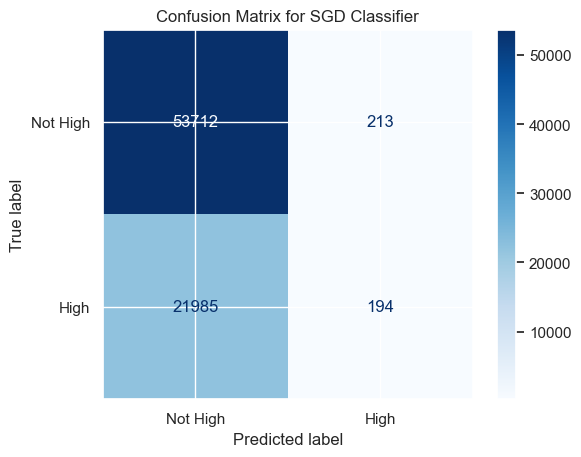

In [885]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(
    loss="log_loss",
    penalty="l1",  # ou "elasticnet" si besoin de L1+L2
    alpha=9e-4,
    max_iter=1000,
    tol=1e-3,
    early_stopping=True,
    class_weight={True: 1.9, False: 1},
    random_state=42
)
sgdc.fit(X_rf_train, y_rf_train)
print("Model SGDC trained.")
print("on Train data : ")
print("Accuracy on training data:", sgdc.score(X_rf_train, y_rf_train))
arr_sgdc_pred_train = sgdc.predict(X_rf_train)
print(f"precision: {precision_score(y_rf_train, arr_sgdc_pred_train):.3f} : True Pos. {np.sum(arr_sgdc_pred_train & y_rf_train)} / Pred Pos. {np.sum(arr_sgdc_pred_train)}")
print(f"% possible trades : {100*np.sum(arr_sgdc_pred_train) / arr_sgdc_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_sgdc_pred_train.sum() / arr_sgdc_pred_train.shape[0]:.2f}")

print("on Test data : ")
arr_sgdc_pred = sgdc.predict(X_rf_test)
print("Accuracy on test data:", sgdc.score(X_rf_test, y_rf_test))
print(f"precision: {precision_score(y_rf_test, arr_sgdc_pred):.3f} :  True Pos. {np.sum(arr_sgdc_pred & y_rf_test)} / Pred Pos. {np.sum(arr_sgdc_pred)}")
print(f"% possible trades : {100*np.sum(arr_sgdc_pred) / arr_sgdc_pred.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_sgdc_pred.sum() / arr_sgdc_pred.shape[0]:.2f}")

cm = confusion_matrix(y_rf_test, arr_sgdc_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SGD Classifier")
plt.show()

In [666]:
(130+194)/(385+407)

0.4090909090909091

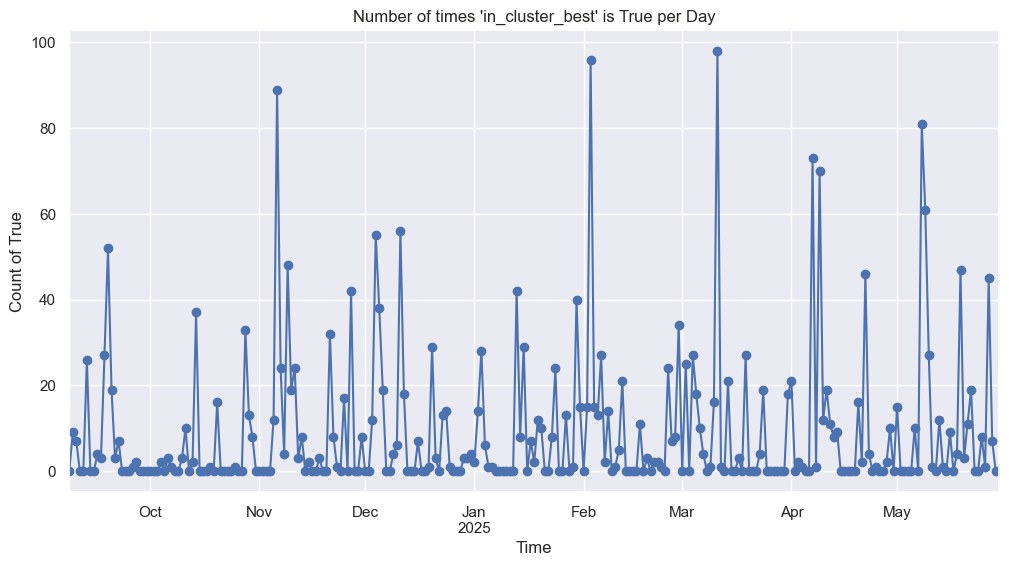

In [868]:
ser_sgdc_pred = pd.Series(arr_sgdc_pred, index=y_rf_test.index)
ser_sgdc_pred.resample("D").sum().plot(figsize=(12, 6), marker="o")
plt.title("Number of times 'in_cluster_best' is True per Day")
plt.xlabel("Time")
plt.ylabel("Count of True")
plt.grid(True)

Test prob threshold > 0.5 

In [873]:
sgdc_prob_min = 0.6
arr_sgdc_prob_pred_train = sgdc.predict_proba(X_rf_train)[:, 1] > sgdc_prob_min
arr_sgdc_prob_pred_test = sgdc.predict_proba(X_rf_test)[:, 1] > sgdc_prob_min
print("on Train data : ")
print("Accuracy on training data:", accuracy_score(y_rf_train, arr_sgdc_prob_pred_train))
print(f"precision: {precision_score(y_rf_train, arr_sgdc_prob_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_sgdc_prob_pred_train) / arr_sgdc_prob_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_sgdc_prob_pred_train.sum() / arr_sgdc_prob_pred_train.shape[0]:.2f}")

print("on Test data : ")
print("Accuracy on test data:", accuracy_score(y_rf_test, arr_sgdc_prob_pred_test))
print(f"precision: {precision_score(y_rf_test, arr_sgdc_prob_pred_test):.3f}")
print(f"% possible trades : {100*np.sum(arr_sgdc_prob_pred_test) / arr_sgdc_prob_pred_test.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_sgdc_prob_pred_test.sum() / arr_sgdc_prob_pred_test.shape[0]:.2f}")

on Train data : 
Accuracy on training data: 0.7776857968272204
precision: 0.409
% possible trades : 0.15
nb trade per day : 0.44
on Test data : 
Accuracy on test data: 0.7085172921265637
precision: 0.493
% possible trades : 0.38
nb trade per day : 1.10


In [858]:
print("On Test Data: ")
b_high_sl_before_test = (
        (y_rf_high_test.max(axis=1) >= 1+target_level) & (y_rf_low_test.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_rf_high_test >= 1+target_level), axis=1) > np.argmax(y_rf_low_test <= 1-target_level/R, axis=1))
)

print(f"nb TP touched: {np.sum((y_rf_high_test.max(axis=1) >= 1+target_level))}")
print(f"- SL touched before TP:\n nb: {np.sum(b_high_sl_before_test)}")
print(f" {100*np.sum(b_high_sl_before_test) / y_rf_high_test.shape[0]:.2f} % of total")
print(f" {100*np.sum(b_high_sl_before_test) / np.sum((y_rf_high_test.max(axis=1) >= 1+target_level)):.2f} % of TP touched")
b_high_tp_sl_same_test = (
        (y_rf_high_test.max(axis=1) >= 1+target_level) & (y_rf_low_test.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_rf_high_test >= 1+target_level), axis=1) == np.argmax(y_rf_low_test <= 1-target_level/R, axis=1))
)

print(f"- TP & SL touched at same time:\n nb: {np.sum(b_high_tp_sl_same_test)}")
print(f" {100*np.sum(b_high_tp_sl_same_test) / y_rf_high_test.shape[0]:.2f} % of total")
print(f" {100*np.sum(b_high_tp_sl_same_test) / np.sum((y_rf_high_test.max(axis=1) >= 1+target_level)):.2f} % of TP touched")

b_high_not_tp_sl_test = (
        (y_rf_high_test.max(axis=1) < 1+target_level) & (y_rf_low_test.min(axis=1) > 1-target_level/R) 
)
print(f"- TP & SL not touched:\n nb: {np.sum(b_high_not_tp_sl_test)}")
print(f" {100*np.sum(b_high_not_tp_sl_test) / y_rf_high_test.shape[0]:.2f} % of total")

b_high_sl_not_tp_test = (
        (y_rf_high_test.max(axis=1) < 1+target_level) & (y_rf_low_test.min(axis=1) <= 1-target_level/R) 
)
print(f"- SL touched but not TP:\n nb: {np.sum(b_high_sl_not_tp_test)}")
print(f" {100*np.sum(b_high_sl_not_tp_test) / y_rf_high_test.shape[0]:.2f} % of total")
print(" ")
print("Model Prediction with Test Data: ")
# nb pred high
nb_pred_high = np.sum((arr_sgdc_pred))
print(f"nb pred high: {nb_pred_high}")
# nb false true high : bad high prediction
nb_false_true_high = np.sum((arr_sgdc_pred & (~y_rf_test)))
print(f"nb false true high: {nb_false_true_high}")
# nb false true high because SL touched before
nb_false_true_high_sl_before = np.sum(arr_sgdc_pred & (~y_rf_test) & b_high_sl_before_test)

# nb false true high because TP & SL at the same time
nb_false_true_high_tp_sl_same = np.sum(arr_sgdc_pred & (~y_rf_test) & b_high_tp_sl_same_test)

# nb false true high because TP & SL not touched
nb_false_true_high_not_tp_not_sl = np.sum(arr_sgdc_pred & (~y_rf_test) & b_high_not_tp_sl_test) 

# nb false true high because SL touched not not TP
nb_false_true_high_sl_not_tp = np.sum(arr_sgdc_pred & (~y_rf_test) & b_high_sl_not_tp_test)  

# --- Print Section ---
print(f"nb false true high because SL touched before: {nb_false_true_high_sl_before}")
print(f"nb false true high because TP & SL at the same time: {nb_false_true_high_tp_sl_same}")
print(f"nb false true high because TP & SL not touched: {nb_false_true_high_not_tp_not_sl}")
print(f"nb false true high because SL touched but not TP: {nb_false_true_high_sl_not_tp}")

# check total of false true high
#213 = 113+2+4+94
assert nb_false_true_high == (
    nb_false_true_high_sl_before + 
    nb_false_true_high_tp_sl_same + 
    nb_false_true_high_not_tp_not_sl +
    nb_false_true_high_sl_not_tp
)
print(" ")
print("On high trade lost:")
print(f"- SL touched: {100*(nb_false_true_high_sl_before + nb_false_true_high_sl_not_tp)/nb_false_true_high:.2f} % at mimimum")

On Test Data: 
nb TP touched: 34666
- SL touched before TP:
 nb: 11892
 15.63 % of total
 34.30 % of TP touched
- TP & SL touched at same time:
 nb: 595
 0.78 % of total
 1.72 % of TP touched
- TP & SL not touched:
 nb: 6819
 8.96 % of total
- SL touched but not TP:
 nb: 34619
 45.49 % of total
 
Model Prediction with Test Data: 
nb pred high: 362
nb false true high: 179
nb false true high because SL touched before: 96
nb false true high because TP & SL at the same time: 2
nb false true high because TP & SL not touched: 4
nb false true high because SL touched but not TP: 77
 
On high trade lost:
- SL touched: 96.65 % at mimimum


In [351]:
113/407

0.27764127764127766

In [352]:
94/407

0.23095823095823095

#### XGBoost

In [ ]:
# params = {
#     "objective": "binary:logistic",
#     "max_depth": 2,
#     "learning_rate": 0.3,
#     "subsample": 0.33,
#     "colsample_bytree": 0.33,
#     "reg_alpha": 0.1,
#     "reg_lambda": 0.1,
#     "scale_pos_weight": 1,  # ajuster si classes déséquilibrées
#     "early_stopping_rounds": 20,
# }

#Accuracy on training data: 0.7783897326733231
# Accuracy on test data: 0.7066908441080626
# For Model XGBoost: 
# precision: 0.396
# % possible trades : 0.90
# nb trade per day : 2.59
# xgb_mdl = xgb.XGBClassifier(
#     objective="binary:logistic",
#     max_depth=20,
#     learning_rate=0.7,
#     subsample=0.33,
#     colsample_bytree=0.33,
#     reg_alpha=0.1,
#     reg_lambda=0.1,
#     scale_pos_weight=0.85,  # ajuster si classes déséquilibrées
#     early_stopping_rounds=1000,
#     n_estimators=20,
#     #class_weight={True: 1.9, False: 1},
#     random_state=42,
# )

# Accuracy on training data: 0.7780574749539626
# Accuracy on test data: 0.7086618311783874
# For Model XGBoost: 
# precision TRAIN: 0.870
# precision TEST: 0.613
# % possible trades : 0.04
# nb trade per day : 0.12
# xgb_mdl = xgb.XGBClassifier(
#     objective="binary:logistic",
#     max_depth=5,
#     learning_rate=0.7,
#     subsample=0.7,
#     colsample_bytree=0.1,
#     reg_alpha=0.1,
#     reg_lambda=0.1,
#     scale_pos_weight=0.85,  # ajuster si classes déséquilibrées
#     early_stopping_rounds=1000,
#     n_estimators=20,
#     #class_weight={True: 1.9, False: 1},
#     random_state=42,
# )

# Accuracy on training data: 0.7779730026524303
# Accuracy on test data: 0.7086355513507832
# For Model XGBoost: 
# precision TRAIN: 0.512
# % possible trades : 0.05
# nb trade per day : 0.14
# precision TEST: 0.551
# % possible trades : 0.06
# nb trade per day : 0.19
# xgb_mdl = xgb.XGBClassifier(
#     objective="binary:hinge",
#     max_depth=3,
#     learning_rate=0.6,
#     subsample=0.5,
#     colsample_bytree=0.1,
#     reg_alpha=0.1,
#     reg_lambda=0.1,
#     #scale_pos_weight=0.85,  # ajuster si classes déséquilibrées
#     early_stopping_rounds=100,
#     n_estimators=200,
#     random_state=42,
# )

# Accuracy on training data: 0.7783784696997854
# Accuracy on test data: 0.7079522758330705
# For Model XGBoost: 
# precision TRAIN: 0.623
# % possible trades : 0.17
# nb trade per day : 0.49
# precision TEST: 0.390
# % possible trades : 0.28
# nb trade per day : 0.81
# xgb_mdl = xgb.XGBClassifier(
#     objective="binary:hinge",
#     max_depth=5,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.3,
#     reg_alpha=4,
#     reg_lambda=4,
#     min_split_loss=0.5, # def. 0
#     min_child_weight=0.9, # default 1
#     #max_cat_threshold=30, # useless
#     #scale_pos_weight=0.85,  # ajuster si classes déséquilibrées
#     #class_weight={True: 1.9, False: 1},
#     base_score=0.33, # def. 0.5
#     early_stopping_rounds=30,
#     n_estimators=500,
#     random_state=42,
# )

# Accuracy on training data: 0.7823148789511919
# Accuracy on test data: 0.7053111531588353
# For Model XGBoost: 
# precision TRAIN: 0.835
# % possible trades : 0.65
# nb trade per day : 1.87
# precision TEST: 0.368
# % possible trades : 1.23
# nb trade per day : 3.55
# xgb_mdl = xgb.XGBClassifier(
#     objective="binary:hinge",
#     random_state=42,
# )


# Accuracy on training data: 0.7823148789511919
# Accuracy on test data: 0.7053111531588353
# For Model XGBoost: 
# precision TRAIN: 0.835
# % possible trades : 0.65
# nb trade per day : 1.87
# precision TEST: 0.368
# % possible trades : 1.23
# nb trade per day : 3.55
# xgb_mdl = xgb.XGBClassifier(
#     objective="binary:hinge",
#     random_state=42,
# )

Model trained.
Accuracy on training data: 0.77716206855772
Accuracy on test data: 0.704102281089036
For Model XGBoost: 
precision TRAIN: 0.455
% possible trades : 0.89
nb trade per day : 2.55
precision TEST: 0.356
% possible trades : 1.55
nb trade per day : 4.47


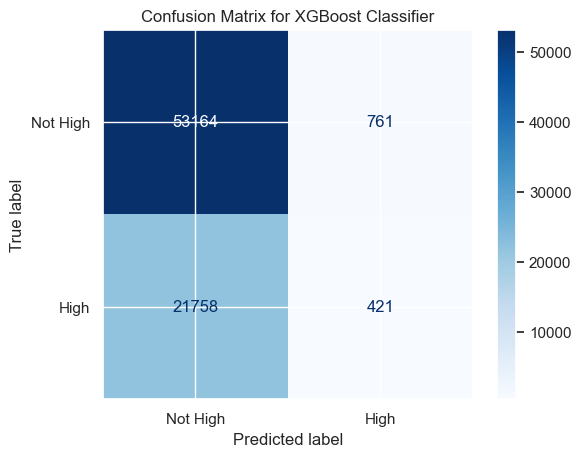

In [932]:
import xgboost as xgb
xgb_mdl = xgb.XGBClassifier(
    objective="binary:hinge",
    max_depth=3,
    learning_rate=0.6,
    subsample=0.5,
    colsample_bytree=0.1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    #scale_pos_weight=0.85,  # ajuster si classes déséquilibrées
    #early_stopping_rounds=100,
    n_estimators=200,
    random_state=42,
)
#xgb_mdl.fit(X_rf_train, y_rf_train, eval_set=[(X_rf_train, y_rf_train), (X_rf_test, y_rf_test)])
xgb_mdl.fit(X_rf_train, y_rf_train)
print("Model trained.")
print("Accuracy on training data:", xgb_mdl.score(X_rf_train, y_rf_train))
print("Accuracy on test data:", xgb_mdl.score(X_rf_test, y_rf_test))
arr_xgb_pred_train = xgb_mdl.predict(X_rf_train)
arr_xgb_pred = xgb_mdl.predict(X_rf_test)
cm = confusion_matrix(y_rf_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_rf_train, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_rf_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show() 

#### Multi-class

In [355]:
y_comb_multi = list_df[0]["target_cat"].values

_, _, y_multi_rf_train, y_multi_rf_test = train_test_split(
    df_combined_condition,
    y_comb_multi,
    test_size=0.3,
    shuffle=False
)

In [356]:
y_comb_multi

array(['neutral', 'neutral', 'neutral', ..., 'low', 'low', 'high'],
      shape=(253677,), dtype=object)

In [357]:

# Accuracy on training data: 0.5469131005276703
# Accuracy on test data: 0.4116997792494481
# For Model SGDC: 
# precision:
# ['high', 'low', 'neutral']
# [0.35153392 0.         0.42149897]
# % possible trades : 14.01
# nb trade per day : 40
# sgdc_multi = SGDClassifier(
#     loss="hinge",
#     alpha=5e-4,
#     max_iter=1000,
#     tol=1e-3,
#     #class_weight="balanced",  # plus de poids sur 'high'
#     class_weight={"high": 1.9, "low": 1, "neutral": 1},
#     penalty="l1",  # ou "elasticnet" si besoin de L1+L2
#     early_stopping=True,
#     random_state=42
# )

# Accuracy on training data: 0.5475100381251654
# Accuracy on test data: 0.4118705981288763
# For Model SGDC: 
# precision:
# ['high', 'low', 'neutral']
# [0.35702944 0.         0.41848138]
# % possible trades : 10.76
# nb trade per day : 31
# sgdc_multi = SGDClassifier(
#     loss="hinge",
#     class_weight={"high": 1.9, "low": 1, "neutral": 1},
#     penalty="l1",  # ou "elasticnet" si besoin de L1+L2
#     alpha=1e-3,
#     max_iter=1000,
#     tol=1e-3,
#     early_stopping=True,
#     random_state=42
# )

Model trained.
Accuracy on training data: 0.5475100381251654
Accuracy on test data: 0.4118705981288763
For Model SGDC: 
precision:
['high', 'low', 'neutral']
[0.35702944 0.         0.41848138]
% possible trades : 10.76
nb trade per day : 31


/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


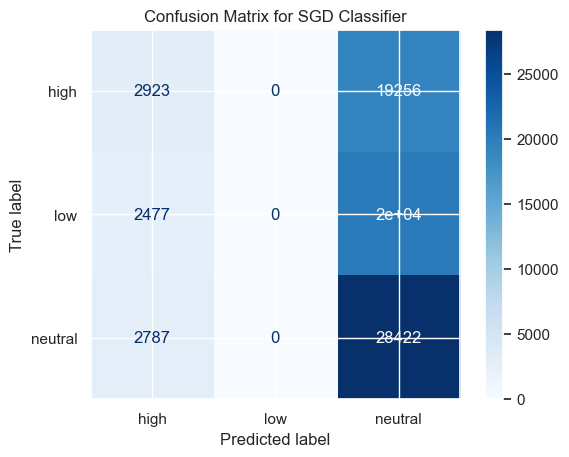

In [568]:
sgdc_multi = SGDClassifier(
    loss="hinge",
    class_weight={"high": 1.9, "low": 1, "neutral": 1},
    penalty="l1",  # ou "elasticnet" si besoin de L1+L2
    alpha=1e-3,
    max_iter=1000,
    tol=1e-3,
    early_stopping=True,
    random_state=42
)

sgdc_multi.fit(X_rf_train, y_multi_rf_train)
print("Model trained.")
print("Accuracy on training data:", sgdc_multi.score(X_rf_train, y_multi_rf_train))
print("Accuracy on test data:", sgdc_multi.score(X_rf_test, y_multi_rf_test))
arr_sgdc_multi_pred = sgdc_multi.predict(X_rf_test)
cm = confusion_matrix(y_multi_rf_test, arr_sgdc_multi_pred, labels=target_cat_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_cat_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SGD Classifier")

print("For Model SGDC: ")
print("precision:")
print(target_cat_names)
print(precision_score(y_multi_rf_test, arr_sgdc_multi_pred, labels=target_cat_names, average=None))
print(f"% possible trades : {100*np.sum(arr_sgdc_multi_pred == "high") / arr_sgdc_multi_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*np.sum(arr_sgdc_multi_pred == "high") / arr_sgdc_multi_pred.shape[0]:.0f}")
plt.show()


## Probability Mdl

### Comb Prob Improvement 

#### Best Comb
We use only one single best prob event to detect high trades

In [359]:
# test add a event one by one to check if prob is better
df_prob_comb_high_event.sort_values(by="p_high", ascending=False).head(10)

high  low  neutral    p_high     p_low  delta_prob  \
100753  1028  774     1058  0.359441  0.270629   71.604883   
101939  1114  800     1217  0.355797  0.255509  103.026123   
117273  1053  885     1023  0.355623  0.298886   29.126935   
106618  1144  893     1180  0.355611  0.277588   61.856652   
113682  1044  878     1017  0.355223  0.298741   28.674298   
116382  1038  875     1010  0.355115  0.299350   27.777313   
116841  1040  875     1014  0.355070  0.298737   28.433420   
118407  1073  898     1052  0.354945  0.297056   31.075596   
118731  1088  910     1069  0.354744  0.296707   31.715716   
120432  1091  918     1076  0.353647  0.297569   29.794923   

                      feat_0 feat_0_cat  lag_0              feat_1  ... lag_1  \
100753        vwap_w_ETH_cat        low     64  max_high_h_ETH_cat  ...    40   
101939  ichi_cloud_b_ETH_cat        low     40      vwap_h_ETH_cat  ...    40   
117273     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    64   
106618    max_high_h_ETH_cat    neutral     40      vwap_w_ETH_cat  ...    56   
113682     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    68   
116382     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    71   
116841     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    70   
118407     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    56   
118731     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...    40   
120432     min_low_h_ETH_cat        low     40   min_low_d_ETH_cat  ...     8   

                    feat_2 feat_2_cat lag_2  days_with_event  \
100753         Low_ETH_cat        low    40              281   
101939  max_high_h_ETH_cat    neutral    40              412   
117273        High_ETH_cat       high    56              179   
106618         Low_ETH_cat        low    40              299   
113682        High_ETH_cat       high    56              179   
116382        High_ETH_cat       high    56              177   
116841        High_ETH_cat       high    56              177   
118407        High_ETH_cat       high    56              182   
118731        High_ETH_cat       high    56              185   
120432        High_ETH_cat       high    56              191   

        weeks_with_event  months_with_event  ratio_days_with_event  \
100753               105                 28               0.318956   
101939               119                 29               0.467650   
117273                82                 28               0.203178   
106618               106                 29               0.339387   
113682                82                 28               0.203178   
116382                82                 28               0.200908   
116841                82                 28               0.200908   
118407                82                 28               0.206583   
118731                83                 28               0.209989   
120432                84                 28               0.216799   

        ratio_weeks_with_event  ratio_months_with_event  
100753                0.826772                 0.965517  
101939                0.937008                 1.000000  
117273                0.645669                 0.965517  
106618                0.834646                 1.000000  
113682                0.645669                 0.965517  
116382                0.645669                 0.965517  
116841                0.645669                 0.965517  
118407                0.645669                 0.965517  
118731                0.653543                 0.965517  
120432                0.661417                 0.965517  

[10 rows x 21 columns]

In [360]:
idx_best_event = df_prob_comb_high_event.sort_values(by="p_high", ascending=False).index[0]
print(idx_best_event)

100753


In [361]:
df_prob_comb_high_event.loc[idx_best_event]

high                                     1028
low                                       774
neutral                                  1058
p_high                               0.359441
p_low                                0.270629
delta_prob                          71.604883
feat_0                         vwap_w_ETH_cat
feat_0_cat                                low
lag_0                                      64
feat_1                     max_high_h_ETH_cat
feat_1_cat                            neutral
lag_1                                      40
feat_2                            Low_ETH_cat
feat_2_cat                                low
lag_2                                      40
days_with_event                           281
weeks_with_event                          105
months_with_event                          28
ratio_days_with_event                0.318956
ratio_weeks_with_event               0.826772
ratio_months_with_event              0.965517
Name: 100753, dtype: object

In [362]:
# MDL prob
y_pred_best_prob_test = X_rf_test[idx_best_event]
y_pred_best_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00    False
2025-05-30 19:35:00    False
Name: 100753, Length: 76104, dtype: bool

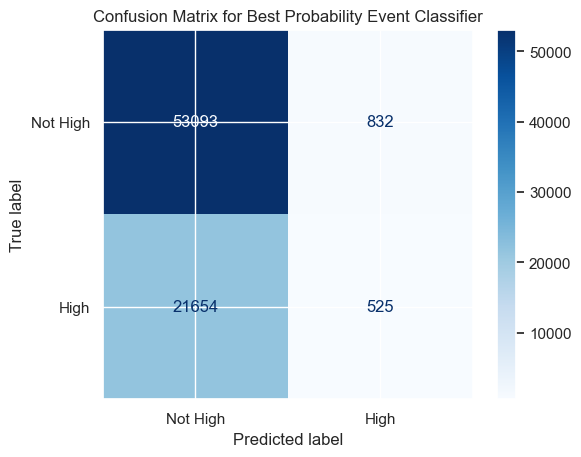

In [363]:

cm = confusion_matrix(y_rf_test, y_pred_best_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Probability Event Classifier")
plt.show()

In [364]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_prob_test):.2f}")
print(f"% possible trades : {100*y_pred_best_prob_test.sum() / y_pred_best_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_prob_test.sum() / y_pred_best_prob_test.shape[0]:.0f}")

precision: 0.39
% possible trades : 1.78%
nb trade per day : 5


Good results with only the first best event

#### Best Comb + single event
We add a event one by one to check if model is better

In [365]:
# --- Optimized Code ---

# 1. Find the best single event and its probability more directly
# .idxmax() is more efficient than sorting the entire DataFrame.
best_event_name = df_prob_comb_high_event['p_high'].idxmax()
best_prob_0 = df_prob_comb_high_event['p_high'].max()

# Store the best combination found so far. Start with the best single event.
best_combination = (best_event_name,)

print(f"Initial best event: '{best_event_name}' with probability: {best_prob_0:.4f}")

# 2. Pre-calculate the boolean mask for "high" targets for efficiency
# This avoids recalculating it on each iteration of the loop.
is_high_target = (list_df[0]["target_cat"] == "high")
min_support = 1000
list_second_event_name = []
# 3. Iterate through all events to find a better PAIR
print("\nSearching for a better two-event combination...")
for second_event_name in df_combined_condition.columns:
    # Don't combine an event with itself
    if second_event_name == best_event_name:
        continue

    # 4. Create a boolean mask for the event combination
    # This correctly uses the event names (strings) to index the DataFrame columns.
    combination_mask = df_combined_condition[best_event_name] & df_combined_condition[second_event_name]

    # 5. Check if the combination has enough data points (support)
    support = combination_mask.sum()
    if support < min_support:
        continue

    # 6. Calculate the probability for this new combination
    # Slicing the pre-calculated 'is_high_target' series is much faster.
    high_targets_in_combination = is_high_target[combination_mask].sum()
    current_prob = high_targets_in_combination / support

    # 7. If the new combination is better, update the tracking variables
    if current_prob > best_prob_0:
        best_prob_0 = current_prob
        best_combination = (best_event_name, second_event_name)
        list_second_event_name.append(second_event_name)
        print("\n--- New Best Combination Found ---")
        print(f"Combination: {best_combination}")
        print(f"New best probability: {best_prob_0:.4f}")
        print(f"Support (Highs / Total): {high_targets_in_combination} / {support}")

print("\n--- Search Complete ---")
print(f"The best combination found is: {best_combination}")
print(f"With a probability of: {best_prob_0:.4f}")


Initial best event: '100753' with probability: 0.3594

Searching for a better two-event combination...

--- New Best Combination Found ---
Combination: (np.int64(100753), 47776)
New best probability: 0.3907
Support (Highs / Total): 427 / 1093

--- New Best Combination Found ---
Combination: (np.int64(100753), 48370)
New best probability: 0.3934
Support (Highs / Total): 439 / 1116

--- New Best Combination Found ---
Combination: (np.int64(100753), 50935)
New best probability: 0.3950
Support (Highs / Total): 440 / 1114

--- New Best Combination Found ---
Combination: (np.int64(100753), 52528)
New best probability: 0.3964
Support (Highs / Total): 423 / 1067

--- Search Complete ---
The best combination found is: (np.int64(100753), 52528)
With a probability of: 0.3964


- What is the combined events exactly ?


In [366]:
list_second_event_name

[47776, 48370, 50935, 52528]

In [367]:
df_prob_comb_high_event.loc[[best_combination[0], best_combination[1]]].T

100753                52528 
high                                   1028                  5033
low                                     774                  4404
neutral                                1058                  5525
p_high                             0.359441              0.336386
p_low                              0.270629              0.294346
delta_prob                        71.604883             83.848893
feat_0                       vwap_w_ETH_cat    max_high_d_ETH_cat
feat_0_cat                              low                   low
lag_0                                    64                    40
feat_1                   max_high_h_ETH_cat        vwap_w_ETH_cat
feat_1_cat                          neutral                   low
lag_1                                    40                    64
feat_2                          Low_ETH_cat  ichi_cloud_b_ETH_cat
feat_2_cat                              low                   low
lag_2                                    40                    40
days_with_event                         281                   405
weeks_with_event                        105                   123
months_with_event                        28                    29
ratio_days_with_event              0.318956              0.459705
ratio_weeks_with_event             0.826772              0.968504
ratio_months_with_event            0.965517                   1.0

In [368]:
# MDL prob
y_pred_best_1_prob_test = X_rf_test[best_combination[0]] & X_rf_test[best_combination[1]]
y_pred_best_1_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00    False
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

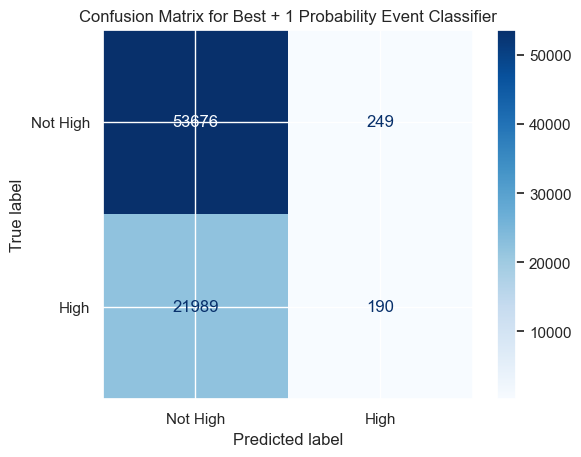

In [369]:

cm = confusion_matrix(y_rf_test, y_pred_best_1_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + 1 Probability Event Classifier")
plt.show()

In [370]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_1_prob_test):.2f}")
print(f"% possible trades : {100*y_pred_best_1_prob_test.sum() / y_pred_best_1_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_1_prob_test.sum() / y_pred_best_1_prob_test.shape[0]:.0f}")


precision: 0.43
% possible trades : 0.58%
nb trade per day : 2


Ok but not enough trades possible per day : try to have min 10

##### Best prob + OR best multi single event
- Best event with at least one another best event

In [371]:
if len(list_second_event_name) > 1:
    print(list_second_event_name)


[47776, 48370, 50935, 52528]


In [372]:
# MDL prob
y_pred_best_multi_prob_test = X_rf_test[best_combination[0]] & (
    (X_rf_test[best_combination[1]]) | 
    (X_rf_test[list_second_event_name[-2]] | 
     X_rf_test[list_second_event_name[-3]] | 
     X_rf_test[list_second_event_name[-4]] 
     )
)
y_pred_best_multi_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00    False
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

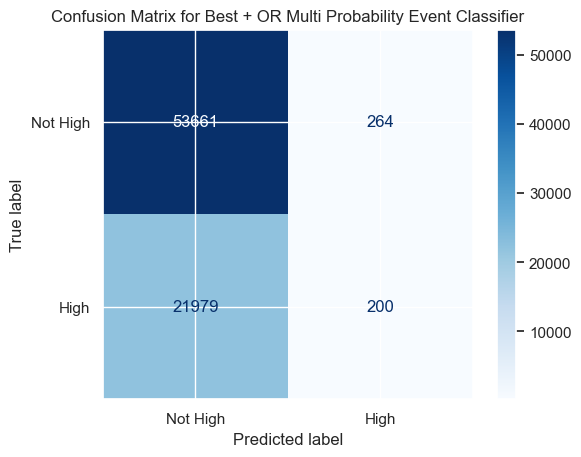

In [373]:

cm = confusion_matrix(y_rf_test, y_pred_best_multi_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
plt.show()

In [374]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_multi_prob_test):.2f}")
print(f"% possible trades : {100*y_pred_best_multi_prob_test.sum() / y_pred_best_multi_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_multi_prob_test.sum() / y_pred_best_multi_prob_test.shape[0]:.0f}")


precision: 0.43
% possible trades : 0.61%
nb trade per day : 2


Better results than only the best (precison = 0.52) but with less trades per day (/2)

#### All high prob event + 1 event
To test if adding an event (from 27000 events) to 57 best events, can improve high probability ? 

In [375]:
min_support = 200 # min number of occurrences of this new combination
p_min = 0.33 # min prob for events

# check hash
path_hash_comb_improvement = os.path.join(path_data, 'comb_improvement_inputs_hash.txt')
path_df_probability_filtered = os.path.join(path_data, 'df_probability_filtered.pkl')
mode_redo_comb, hash_comb = check_hash_inputs(
     (df_combined_condition, 
      min_support, 
      p_min,
     ),
     path_hash_comb_improvement,
)

hash match: mode LOAD


In [376]:
# compute time : 15 min : for 57 best events * 27000 events

if mode_redo_comb:
    # --- Setup: Assuming these DataFrames are pre-loaded ---
    # df_combined_condition: (n_samples, n_events) boolean DataFrame
    # list_df: A list containing the DataFrame with the target
    # df_prob_comb_high_event: (n_events, 1) DataFrame with single-event probabilities ('p_high')

    # --- Optimized Code using Targeted Matrix Multiplication ---

    # 1. Prepare the data
    # Using boolean arrays is memory-efficient. We'll convert to int just before matmul.
    X = df_combined_condition.values
    is_high_target = (list_df[0]["target_cat"] == "high").values
    event_names = df_combined_condition.columns
    n_events = len(event_names)
    print("--- Starting targeted search for best event combination ---")

    # 2. Find the best single event from the pre-calculated DataFrame
    # This is fast and doesn't require a large matrix operation.
    best_single_prob = df_prob_comb_high_event['p_high'].max()
    best_single_name = df_prob_comb_high_event['p_high'].idxmax()

    # Initialize the best result with the best single event
    best_prob = best_single_prob
    best_combination = (best_single_name,)
    print(f"Initial best single event: '{best_single_name}' with probability: {best_prob:.4f}")

    # 3. Identify the high-probability events to form pairs with
    high_prob_event_names = df_prob_comb_high_event[df_prob_comb_high_event["p_high"] > p_min].index

    if high_prob_event_names.empty:
        print(f"\nNo single events with p_high > {p_min}. The best combination is the single event found above.")
    else:
        print(f"\nFound {len(high_prob_event_names)} events with p_high > {p_min} to form pairs with.")
        
        # Get the integer indices for these high-probability events
        name_to_idx = {name: i for i, name in enumerate(event_names)}
        high_prob_indices = [name_to_idx[name] for name in high_prob_event_names]

        # 4. Create the sub-matrix for high-prob events (k columns)
        X_h = X[:, high_prob_indices].astype(np.int32)

        # 5. Calculate support and high-counts for the targeted pairs ONLY
        # This creates a (k, N) matrix, which is much smaller than (N, N)
        print("5.Calculating support and high-counts for the targeted pairs...")
        support_filtered = X_h.T @ X.astype(np.int32)
        
        # Create a version of X where rows are zeroed out if the target was not "high"
        X_high = X * is_high_target[:, np.newaxis]
        X_h_high = X_high[:, high_prob_indices].astype(np.int32)
        print("Create a version of X where rows are zeroed out if the target was not 'high'.")
        high_count_filtered = X_h_high.T @ X.astype(np.int32)

        # 6. Calculate the probability matrix for the targeted pairs
        print("6.Calculating the probability matrix for the targeted pairs...")
        with np.errstate(divide='ignore', invalid='ignore'):
            probability_filtered = high_count_filtered / support_filtered
        probability_filtered = np.nan_to_num(probability_filtered)

        # 7. Apply filters to the (k, N) matrix
        # Minimum support filter
        print("7.Apply filters to the (k, N) matrix...")
        probability_filtered[support_filtered < min_support] = 0
        
        # Filter out pairs of an event with itself
        for i, original_idx in enumerate(high_prob_indices):
            if original_idx < n_events:
                probability_filtered[i, original_idx] = 0
        
        # Create a DataFrame with the filtered probabilities
        df_probability_filtered = pd.DataFrame(
        probability_filtered, 
        columns=event_names, 
        index=high_prob_event_names,
        )
        # save
        df_probability_filtered.to_pickle(path_df_probability_filtered)
        # hash
        save_hash(path_hash_comb_improvement, hash_comb)

        # 8. Find the best PAIR from the filtered results
        print("8.Find the best PAIR from the filtered results...")
        best_pair_prob = probability_filtered.max()
        
        if best_pair_prob > best_prob:
            # Find the row/col index in the (k, N) matrix
            idx_flat = np.argmax(probability_filtered)
            idx_pair_filtered = np.unravel_index(idx_flat, probability_filtered.shape)
            
            # Map indices back to original event names
            event1_name = high_prob_event_names[idx_pair_filtered[0]]
            event2_name = event_names[idx_pair_filtered[1]]
            
            best_prob = best_pair_prob
            best_combination = (event1_name, event2_name)

    # 9. Display the final result
    print("\n--- Search Complete ---")
    print(f"The best combination found is: {best_combination}")
    print(f"With a probability of: {best_prob:.4f}")

    # Retrieve support and high count for the final best combination for reporting
    if len(best_combination) == 1:
        event_mask = df_combined_condition[best_combination[0]]
        support = event_mask.sum()
        high_count = (event_mask & is_high_target).sum()
    else:
        # For a pair, we can retrieve the values we already calculated
        e1, e2 = best_combination
        if e1 in high_prob_event_names:
            idx_h = high_prob_event_names.get_loc(e1)
            idx_a = event_names.get_loc(e2)
            support = support_filtered[idx_h, idx_a]
            high_count = high_count_filtered[idx_h, idx_a]
        else: # The other event must be the high-probability one
            idx_h = high_prob_event_names.get_loc(e2)
            idx_a = event_names.get_loc(e1)
            support = support_filtered[idx_h, idx_a]
            high_count = high_count_filtered[idx_h, idx_a]

    print(f"Support (Highs / Total): {high_count} / {support}")
else:
    df_probability_filtered = pd.read_pickle(path_df_probability_filtered)
    best_prob = df_probability_filtered.max().max()
    print(f"The best probability found is: {best_prob:.4f}")
    
    #best_combination = df_probability_filtered.idxmax().values

# get 100 best comb : 

df_probability_filtered


The best probability found is: 0.4779


391       418       553     595       634       688       715     \
391     0.000000  0.343537  0.344417     0.0  0.344184  0.344968  0.344963   
418     0.343537  0.000000  0.342122     0.0  0.343743  0.345029  0.344806   
553     0.344417  0.342122  0.000000     0.0  0.344457  0.345130  0.345045   
595     0.000000  0.000000  0.000000     0.0  0.000000  0.000000  0.000000   
634     0.344184  0.343743  0.344457     0.0  0.000000  0.344928  0.344922   
...          ...       ...       ...     ...       ...       ...       ...   
216799  0.344468  0.337522  0.342412     0.0  0.344156  0.348214  0.349099   
217885  0.395745  0.379130  0.387716     0.0  0.396476  0.399103  0.399549   
218527  0.344468  0.337522  0.342412     0.0  0.344156  0.348214  0.349099   
218716  0.370370  0.372460  0.367681     0.0  0.374046  0.376923  0.383812   
218849  0.377660  0.385167  0.374372     0.0  0.382920  0.388268  0.396011   

          1120      1147      1282    ...  213120    213484    214429  \
391     0.343834  0.343040  0.343952  ...     0.0  0.343164  0.350275   
418     0.343040  0.334783  0.341650  ...     0.0  0.345052  0.354628   
553     0.343952  0.341650  0.340984  ...     0.0  0.336317  0.345191   
595     0.000000  0.000000  0.000000  ...     0.0  0.000000  0.000000   
634     0.343764  0.343300  0.344037  ...     0.0  0.350416  0.355430   
...          ...       ...       ...  ...     ...       ...       ...   
216799  0.338912  0.332734  0.337232  ...     0.0  0.386921  0.392157   
217885  0.393235  0.377163  0.385496  ...     0.0  0.388646  0.395556   
218527  0.338912  0.332734  0.337232  ...     0.0  0.381868  0.388102   
218716  0.368812  0.371041  0.366197  ...     0.0  0.347681  0.342621   
218849  0.376000  0.383693  0.372796  ...     0.0  0.355330  0.349462   

          215746    215879    216799    217885    218527    218716    218849  
391     0.354217  0.362205  0.344468  0.395745  0.344468  0.370370  0.377660  
418     0.361174  0.372881  0.337522  0.379130  0.337522  0.372460  0.385167  
553     0.349206  0.355392  0.342412  0.387716  0.342412  0.367681  0.374372  
595     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
634     0.361809  0.371901  0.344156  0.396476  0.344156  0.374046  0.382920  
...          ...       ...       ...       ...       ...       ...       ...  
216799  0.364593  0.387043  0.000000  0.333580  0.334558  0.365141  0.386441  
217885  0.382749  0.363636  0.333580  0.000000  0.335269  0.380822  0.360595  
218527  0.362764  0.384359  0.334558  0.335269  0.000000  0.363014  0.384354  
218716  0.345797  0.351522  0.365141  0.380822  0.363014  0.000000  0.346549  
218849  0.351522  0.351678  0.386441  0.360595  0.384354  0.346549  0.000000  

[1163 rows x 1163 columns]

In [377]:
ind_sort = np.unravel_index(
    np.argsort(
        df_probability_filtered.values, 
        axis=None,
    ), 
    df_probability_filtered.shape,
)
# create a dataframe with the best 100 combinations
df_best_comb = pd.DataFrame(
    df_probability_filtered.values[(ind_sort[0][-100:], ind_sort[1][-100:])],
    columns=["prob"])

df_best_comb["event_p_high"] = df_probability_filtered.index[ind_sort[0][-100:]]
df_best_comb["event_1"] = df_probability_filtered.columns[ind_sort[1][-100:]]
#df_probability_filtered.columns[ind_sort[1][-100:]]

df_best_comb.sort_values(by="prob", ascending=False, inplace=True)
df_best_comb.head(30)

prob  event_p_high  event_1
99  0.477912        197001    54850
98  0.477912         54850   197001
97  0.477912         54850   200673
96  0.477912        200673    54850
95  0.477912         54850   171216
94  0.477912        171216    54850
70  0.477099         54850   199056
77  0.477099        167709    54850
75  0.477099         54850   197085
74  0.477099         54850   200757
73  0.477099         54850   169599
72  0.477099         54850   169275
71  0.477099        169599    54850
67  0.477099        195060    54850
69  0.477099        167250    54850
68  0.477099        200757    54850
79  0.477099         54850   167250
66  0.477099        168141    54850
65  0.477099         54850   198732
64  0.477099        193926    54850
78  0.477099         54850   171300
76  0.477099         54850   193926
80  0.477099        169275    54850
87  0.477099        197598    54850
93  0.477099        199056    54850
81  0.477099         54850   167709
91  0.477099        195384    54850
90  0.477099        171300    54850
89  0.477099         54850   193494
88  0.477099         54850   195384

In [378]:
best_comb_1 = (df_best_comb["event_p_high"].iloc[0], df_best_comb["event_1"].iloc[0])

df_prob_comb_high_event.loc[[best_comb_1[0], best_comb_1[1]]].T

197001              54850 
high                                    1744                4509
low                                     1531                3966
neutral                                 1835                4885
p_high                              0.341292              0.3375
p_low                               0.299609            0.296856
delta_prob                          27.70626           69.580885
feat_0                     min_low_d_ETH_cat  max_high_d_ETH_cat
feat_0_cat                               low                 low
lag_0                                     71                  40
feat_1                   ichi_tenkan_ETH_cat        High_ETH_cat
feat_1_cat                              high                 low
lag_1                                     56                  40
feat_2                        vwap_h_ETH_cat      vwap_w_ETH_cat
feat_2_cat                              high                 low
lag_2                                     56                  71
days_with_event                          167                 389
weeks_with_event                          71                 119
months_with_event                         28                  29
ratio_days_with_event               0.189557            0.441544
ratio_weeks_with_event              0.559055            0.937008
ratio_months_with_event             0.965517                 1.0

In [379]:
nb_occ_best_comb_1 = (df_combined_condition[best_comb_1[0]] & df_combined_condition[best_comb_1[1]]).sum()
print("On Train : ")
print(f"nb occurrences : {nb_occ_best_comb_1}")
print(f"{100 * nb_occ_best_comb_1 / df_combined_condition.shape[0]:.2f}% of the data matches this combination of events.")
print(f"to be compared to one day = {100*288/ df_combined_condition.shape[0]:.2f} % of the data")

On Train : 
nb occurrences : 249
0.10% of the data matches this combination of events.
to be compared to one day = 0.11 % of the data


In [380]:
# MDL prob
y_pred_best_comb_prob_test = X_rf_test[best_comb_1[0]] & X_rf_test[best_comb_1[1]]
y_pred_best_comb_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00    False
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

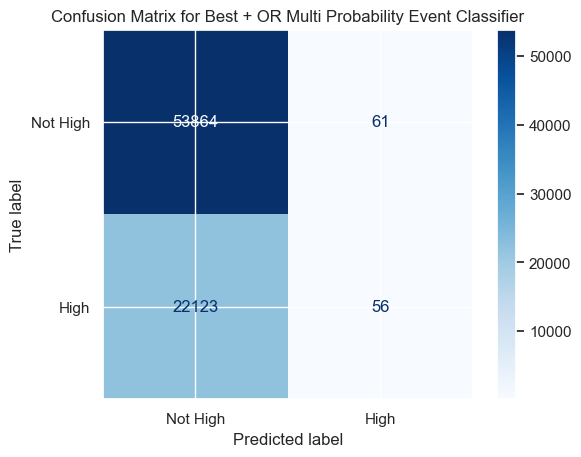

In [381]:
cm = confusion_matrix(y_rf_test, y_pred_best_comb_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
plt.show()

In [382]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_comb_prob_test):.3f}")
print(f"% possible trades : {100*y_pred_best_comb_prob_test.sum() / y_pred_best_comb_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_comb_prob_test.sum() / y_pred_best_comb_prob_test.shape[0]:.2f}")


precision: 0.479
% possible trades : 0.15%
nb trade per day : 0.44


- these 2 Combined events gives a good precision = 0.57 (2 trades/day)
- compared best comb precsion = 0.55 (2 trades/day)  
- ML Model precision on Test data : 0.51 (33 trades/day)

CONCLUSION : 
- ML model can be enough for global prediction but maybe too low win rate ?
- These best 2 combined event give a very good precision but not enough possible trades ?

##### Best comb2 + OR multi comb2

In [383]:
# MDL prob
# MDL prob
best_comb_1 = (df_best_comb["event_p_high"].iloc[0], df_best_comb["event_1"].iloc[0])

y_pred_best_comb_or_prob_test = (
    X_rf_test[df_best_comb["event_p_high"].iloc[0]] & X_rf_test[df_best_comb["event_1"].iloc[0]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[1]] & X_rf_test[df_best_comb["event_1"].iloc[1]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[2]] & X_rf_test[df_best_comb["event_1"].iloc[2]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[3]] & X_rf_test[df_best_comb["event_1"].iloc[3]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[4]] & X_rf_test[df_best_comb["event_1"].iloc[4]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[5]] & X_rf_test[df_best_comb["event_1"].iloc[5]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[6]] & X_rf_test[df_best_comb["event_1"].iloc[6]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[7]] & X_rf_test[df_best_comb["event_1"].iloc[7]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[8]] & X_rf_test[df_best_comb["event_1"].iloc[8]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[9]] & X_rf_test[df_best_comb["event_1"].iloc[9]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[10]] & X_rf_test[df_best_comb["event_1"].iloc[10]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[11]] & X_rf_test[df_best_comb["event_1"].iloc[11]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[12]] & X_rf_test[df_best_comb["event_1"].iloc[12]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[13]] & X_rf_test[df_best_comb["event_1"].iloc[13]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[14]] & X_rf_test[df_best_comb["event_1"].iloc[14]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[15]] & X_rf_test[df_best_comb["event_1"].iloc[15]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[16]] & X_rf_test[df_best_comb["event_1"].iloc[16]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[17]] & X_rf_test[df_best_comb["event_1"].iloc[17]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[18]] & X_rf_test[df_best_comb["event_1"].iloc[18]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[19]] & X_rf_test[df_best_comb["event_1"].iloc[19]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[20]] & X_rf_test[df_best_comb["event_1"].iloc[20]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[21]] & X_rf_test[df_best_comb["event_1"].iloc[21]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[22]] & X_rf_test[df_best_comb["event_1"].iloc[22]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[23]] & X_rf_test[df_best_comb["event_1"].iloc[23]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[24]] & X_rf_test[df_best_comb["event_1"].iloc[24]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[25]] & X_rf_test[df_best_comb["event_1"].iloc[25]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[26]] & X_rf_test[df_best_comb["event_1"].iloc[26]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[27]] & X_rf_test[df_best_comb["event_1"].iloc[27]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[28]] & X_rf_test[df_best_comb["event_1"].iloc[28]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[29]] & X_rf_test[df_best_comb["event_1"].iloc[29]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[30]] & X_rf_test[df_best_comb["event_1"].iloc[30]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[31]] & X_rf_test[df_best_comb["event_1"].iloc[31]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[32]] & X_rf_test[df_best_comb["event_1"].iloc[32]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[33]] & X_rf_test[df_best_comb["event_1"].iloc[33]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[34]] & X_rf_test[df_best_comb["event_1"].iloc[34]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[35]] & X_rf_test[df_best_comb["event_1"].iloc[35]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[36]] & X_rf_test[df_best_comb["event_1"].iloc[36]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[37]] & X_rf_test[df_best_comb["event_1"].iloc[37]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[38]] & X_rf_test[df_best_comb["event_1"].iloc[38]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[39]] & X_rf_test[df_best_comb["event_1"].iloc[39]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[40]] & X_rf_test[df_best_comb["event_1"].iloc[40]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[41]] & X_rf_test[df_best_comb["event_1"].iloc[41]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[42]] & X_rf_test[df_best_comb["event_1"].iloc[42]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[43]] & X_rf_test[df_best_comb["event_1"].iloc[43]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[44]] & X_rf_test[df_best_comb["event_1"].iloc[44]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[45]] & X_rf_test[df_best_comb["event_1"].iloc[45]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[46]] & X_rf_test[df_best_comb["event_1"].iloc[46]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[47]] & X_rf_test[df_best_comb["event_1"].iloc[47]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[48]] & X_rf_test[df_best_comb["event_1"].iloc[48]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[49]] & X_rf_test[df_best_comb["event_1"].iloc[49]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[50]] & X_rf_test[df_best_comb["event_1"].iloc[50]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[51]] & X_rf_test[df_best_comb["event_1"].iloc[51]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[52]] & X_rf_test[df_best_comb["event_1"].iloc[52]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[53]] & X_rf_test[df_best_comb["event_1"].iloc[53]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[54]] & X_rf_test[df_best_comb["event_1"].iloc[54]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[55]] & X_rf_test[df_best_comb["event_1"].iloc[55]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[56]] & X_rf_test[df_best_comb["event_1"].iloc[56]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[57]] & X_rf_test[df_best_comb["event_1"].iloc[57]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[58]] & X_rf_test[df_best_comb["event_1"].iloc[58]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[59]] & X_rf_test[df_best_comb["event_1"].iloc[59]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[60]] & X_rf_test[df_best_comb["event_1"].iloc[60]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[61]] & X_rf_test[df_best_comb["event_1"].iloc[61]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[62]] & X_rf_test[df_best_comb["event_1"].iloc[62]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[63]] & X_rf_test[df_best_comb["event_1"].iloc[63]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[64]] & X_rf_test[df_best_comb["event_1"].iloc[64]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[65]] & X_rf_test[df_best_comb["event_1"].iloc[65]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[66]] & X_rf_test[df_best_comb["event_1"].iloc[66]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[67]] & X_rf_test[df_best_comb["event_1"].iloc[67]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[68]] & X_rf_test[df_best_comb["event_1"].iloc[68]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[69]] & X_rf_test[df_best_comb["event_1"].iloc[69]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[70]] & X_rf_test[df_best_comb["event_1"].iloc[70]] 
)
y_pred_best_comb_or_prob_test


date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00    False
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

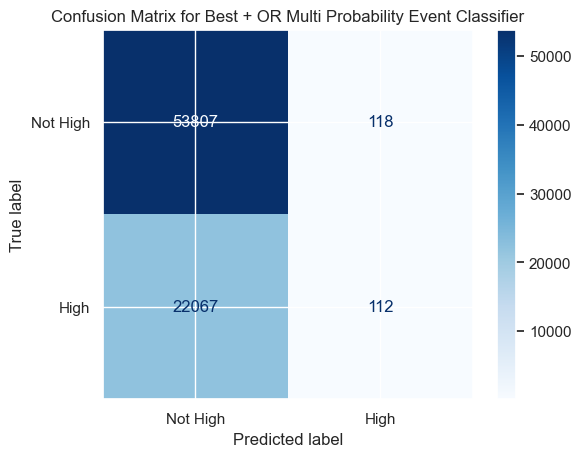

In [384]:
cm = confusion_matrix(y_rf_test, y_pred_best_comb_or_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
plt.show()


In [385]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_comb_or_prob_test):.3f}")
print(f"% possible trades : {100*y_pred_best_comb_or_prob_test.sum() / y_pred_best_comb_or_prob_test.shape[0]:.3f}%")
# per day
print(f"nb trade per day : {288*y_pred_best_comb_or_prob_test.sum() / y_pred_best_comb_or_prob_test.shape[0]:.2f}")


precision: 0.487
% possible trades : 0.302%
nb trade per day : 0.87


- Low trades possible
- precision OK

##### All Best comb2 Max

In [938]:

df_best_comb

prob  event_p_high  event_1
99  0.477912        197001    54850
98  0.477912         54850   197001
97  0.477912         54850   200673
96  0.477912        200673    54850
95  0.477912         54850   171216
..       ...           ...      ...
5   0.473684         83335   203913
4   0.473684         83335   213093
3   0.473684        211311    83335
1   0.473029        198732    53959
0   0.473029        167709    53959

[100 rows x 3 columns]

In [387]:
X_rf_test

391     418     553     595     634     688     715     \
date_ETH                                                                      
2024-09-08 13:45:00   False   False   False   False   False   False   False   
2024-09-08 13:50:00   False   False   False   False   False   False   False   
2024-09-08 13:55:00   False   False   False   False   False   False   False   
2024-09-08 14:00:00   False   False   False   False   False   False   False   
2024-09-08 14:05:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False   False   False   False   False   
2025-05-30 19:20:00   False   False   False   False   False   False   False   
2025-05-30 19:25:00   False   False   False   False   False   False   False   
2025-05-30 19:30:00   False   False   False   False   False   False   False   
2025-05-30 19:35:00   False   False   False   False   False   False   False   

                     1120    1147    1282    ...  213120  213484  214429  \
date_ETH                                     ...                           
2024-09-08 13:45:00   False   False   False  ...   False   False   False   
2024-09-08 13:50:00   False   False   False  ...   False   False   False   
2024-09-08 13:55:00   False   False   False  ...   False   False   False   
2024-09-08 14:00:00   False   False   False  ...   False   False   False   
2024-09-08 14:05:00   False   False   False  ...   False   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False  ...   False   False   False   
2025-05-30 19:20:00   False   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False   False  ...   False   False   False   
2025-05-30 19:30:00   False   False   False  ...   False   False   False   
2025-05-30 19:35:00   False   False   False  ...   False   False   False   

                     215746  215879  216799  217885  218527  218716  218849  
date_ETH                                                                     
2024-09-08 13:45:00   False   False   False   False   False   False   False  
2024-09-08 13:50:00   False   False   False   False   False   False   False  
2024-09-08 13:55:00   False   False   False   False   False   False   False  
2024-09-08 14:00:00   False   False   False   False   False   False   False  
2024-09-08 14:05:00   False   False   False   False   False   False   False  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[76104 rows x 1163 columns]

On TRAIN:
precision: 0.477
% possible trades : 0.074%
nb trade per day : 0.21
On TEST:
precision: 0.479
% possible trades : 0.154%
nb trade per day : 0.44


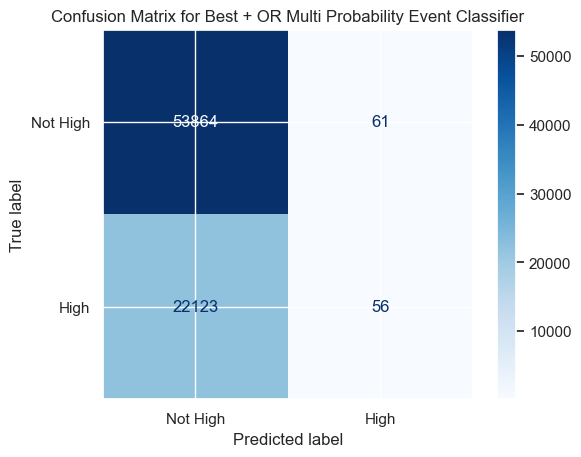

In [959]:
# create a new dataframe to have each double event
# for each double event (event_p_high and event_1), check if double event in df_best_comb is in X_rf_test
# instead of have true or false, give the value of df_best_comb.prob
prob_mdl_min = 0.4775
# on TRAIN:
df_best_comb_events_in_train = pd.DataFrame(index=X_rf_train.index)
for i, row in df_best_comb.iterrows():
    event_p_high = row["event_p_high"]
    event_1 = row["event_1"]
    df_best_comb_events_in_train[f"comb_{i}"] = (X_rf_train[event_p_high] & X_rf_train[event_1]) * row["prob"]
y_pred_max_comb2_train = df_best_comb_events_in_train.max(axis=1) > prob_mdl_min
# on TEST:
df_best_comb_events_in_test = pd.DataFrame(index=X_rf_test.index)
for i, row in df_best_comb.iterrows():
    event_p_high = row["event_p_high"]
    event_1 = row["event_1"]
    df_best_comb_events_in_test[f"comb_{i}"] = (X_rf_test[event_p_high] & X_rf_test[event_1]) * row["prob"]
y_pred_max_comb2_test = df_best_comb_events_in_test.max(axis=1) > prob_mdl_min

cm = confusion_matrix(y_rf_test, y_pred_max_comb2_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
print("On TRAIN:")
print(f"precision: {precision_score(y_rf_train, y_pred_max_comb2_train):.3f}")
print(f"% possible trades : {100*y_pred_max_comb2_train.sum() / y_pred_max_comb2_train.shape[0]:.3f}%")
# per day
print(f"nb trade per day : {288*y_pred_max_comb2_train.sum() / y_pred_max_comb2_train.shape[0]:.2f}")
print("On TEST:")
print(f"precision: {precision_score(y_rf_test, y_pred_max_comb2_test):.3f}")
print(f"% possible trades : {100*y_pred_max_comb2_test.sum() / y_pred_max_comb2_test.shape[0]:.3f}%")
# per day
print(f"nb trade per day : {288*y_pred_max_comb2_test.sum() / y_pred_max_comb2_test.shape[0]:.2f}")

plt.show()

=> Not better than "Best comb2 + OR multi comb2"

##### All Best comb2 Mean

In [389]:
(df_best_comb_events_in_test > 0).sum(axis=1)

date_ETH
2024-09-08 13:45:00    0
2024-09-08 13:50:00    0
2024-09-08 13:55:00    0
2024-09-08 14:00:00    0
2024-09-08 14:05:00    0
                      ..
2025-05-30 19:15:00    0
2025-05-30 19:20:00    0
2025-05-30 19:25:00    0
2025-05-30 19:30:00    0
2025-05-30 19:35:00    0
Length: 76104, dtype: int64

precision: 0.497
% possible trades : 0.587%
nb trade per day : 1.69


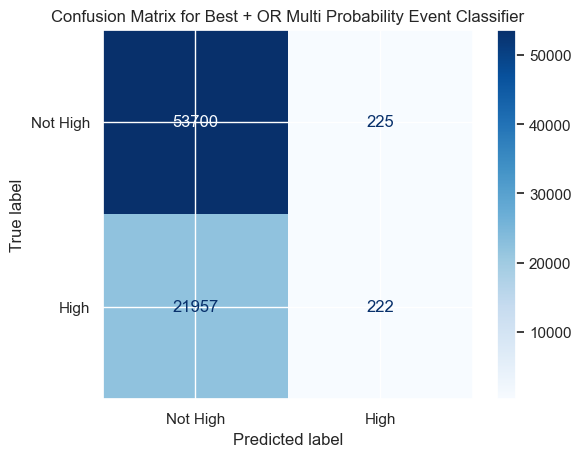

In [390]:

y_pred_mean_comb2_test = df_best_comb_events_in_test.sum(axis=1) / (df_best_comb_events_in_test > 0).sum(axis=1) > 0.4

cm = confusion_matrix(y_rf_test, y_pred_mean_comb2_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")

print(f"precision: {precision_score(y_rf_test, y_pred_mean_comb2_test):.3f}")
print(f"% possible trades : {100*y_pred_mean_comb2_test.sum() / y_pred_mean_comb2_test.shape[0]:.3f}%")
# per day
print(f"nb trade per day : {288*y_pred_mean_comb2_test.sum() / y_pred_mean_comb2_test.shape[0]:.2f}")

plt.show()

=> Same as multi comb2 OR  == BEST RESULT

### Max Prob Model
We take the max prob of all 27000 events  (nb occ>8000 and p_high > 0.4)


In [391]:
df_prob_comb_high_event

high   low  neutral    p_high     p_low  delta_prob  \
391     3213  2791     3328  0.344299  0.299078   59.321785   
418     3717  3278     4092  0.335258  0.295662   55.102502   
553     3433  3003     3620  0.341388  0.298628   57.458048   
595     1007   836     1072  0.345455  0.286792   31.731959   
634     3046  2658     3146  0.344181  0.300339   52.785414   
...      ...   ...      ...       ...       ...         ...   
216799  1137   914     1350  0.334313  0.268744   48.492443   
217885  1039   857     1217  0.333762  0.275297   34.940928   
218527  1111   890     1314  0.335143  0.268477   48.816592   
218716  1149   975     1226  0.342985  0.291045   28.508475   
218849  1241  1060     1274  0.347133  0.296503   28.475445   

                    feat_0 feat_0_cat  lag_0               feat_1  ... lag_1  \
391     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat  ...    71   
418     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat  ...    71   
553     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat  ...    71   
595     max_high_d_ETH_cat       high     70   max_high_d_ETH_cat  ...    71   
634     max_high_d_ETH_cat        low     70   max_high_d_ETH_cat  ...    71   
...                    ...        ...    ...                  ...  ...   ...   
216799      vwap_d_ETH_cat        low      8  ichi_tenkan_ETH_cat  ...    56   
217885        Open_ETH_cat    neutral     56   ichi_kijun_ETH_cat  ...     8   
218527  ichi_kijun_ETH_cat        low      8  ichi_tenkan_ETH_cat  ...    56   
218716  ichi_kijun_ETH_cat        low     40  ichi_tenkan_ETH_cat  ...    56   
218849  ichi_kijun_ETH_cat        low     40    min_low_d_ETH_cat  ...     8   

                      feat_2 feat_2_cat lag_2  days_with_event  \
391           vwap_w_ETH_cat        low    64              422   
418     ichi_cloud_b_ETH_cat        low    40              457   
553           vwap_w_ETH_cat        low    56              430   
595     ichi_cloud_a_ETH_cat        low     8               82   
634           vwap_w_ETH_cat        low    68              411   
...                      ...        ...   ...              ...   
216799        vwap_d_ETH_cat        low    56              583   
217885        vwap_d_ETH_cat        low    56              584   
218527        vwap_d_ETH_cat        low    56              572   
218716     min_low_d_ETH_cat        low     8              213   
218849        vwap_h_ETH_cat    neutral    56              214   

        weeks_with_event  months_with_event  ratio_days_with_event  \
391                  123                 29               0.479001   
418                  126                 29               0.518729   
553                  124                 29               0.488082   
595                   45                 22               0.093076   
634                  122                 29               0.466515   
...                  ...                ...                    ...   
216799               124                 29               0.661748   
217885               123                 29               0.662883   
218527               124                 29               0.649262   
218716                88                 28               0.241771   
218849                88                 28               0.242906   

        ratio_weeks_with_event  ratio_months_with_event  
391                   0.968504                 1.000000  
418                   0.992126                 1.000000  
553                   0.976378                 1.000000  
595                   0.354331                 0.758621  
634                   0.960630                 1.000000  
...                        ...                      ...  
216799                0.976378                 1.000000  
217885                0.968504                 1.000000  
218527                0.976378                 1.000000  
218716                0.692913                 0.965517  
218849            

In [392]:
X_rf_test

391     418     553     595     634     688     715     \
date_ETH                                                                      
2024-09-08 13:45:00   False   False   False   False   False   False   False   
2024-09-08 13:50:00   False   False   False   False   False   False   False   
2024-09-08 13:55:00   False   False   False   False   False   False   False   
2024-09-08 14:00:00   False   False   False   False   False   False   False   
2024-09-08 14:05:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False   False   False   False   False   
2025-05-30 19:20:00   False   False   False   False   False   False   False   
2025-05-30 19:25:00   False   False   False   False   False   False   False   
2025-05-30 19:30:00   False   False   False   False   False   False   False   
2025-05-30 19:35:00   False   False   False   False   False   False   False   

                     1120    1147    1282    ...  213120  213484  214429  \
date_ETH                                     ...                           
2024-09-08 13:45:00   False   False   False  ...   False   False   False   
2024-09-08 13:50:00   False   False   False  ...   False   False   False   
2024-09-08 13:55:00   False   False   False  ...   False   False   False   
2024-09-08 14:00:00   False   False   False  ...   False   False   False   
2024-09-08 14:05:00   False   False   False  ...   False   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False  ...   False   False   False   
2025-05-30 19:20:00   False   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False   False  ...   False   False   False   
2025-05-30 19:30:00   False   False   False  ...   False   False   False   
2025-05-30 19:35:00   False   False   False  ...   False   False   False   

                     215746  215879  216799  217885  218527  218716  218849  
date_ETH                                                                     
2024-09-08 13:45:00   False   False   False   False   False   False   False  
2024-09-08 13:50:00   False   False   False   False   False   False   False  
2024-09-08 13:55:00   False   False   False   False   False   False   False  
2024-09-08 14:00:00   False   False   False   False   False   False   False  
2024-09-08 14:05:00   False   False   False   False   False   False   False  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[76104 rows x 1163 columns]

In [393]:
# For each rows == dates in df_combined_condition index, get the max prob of events occuring using df_prob_comb_high_event.p_high probability
# knowing that : df_prob_comb_high_event have as rows the event indexes == columns of df_combined_condition

df_event_probs = X_rf_test.multiply(df_prob_comb_high_event['p_high'], axis='columns')
max_prob_test = df_event_probs.max(axis=1)
max_prob_test


date_ETH
2024-09-08 13:45:00    0.0
2024-09-08 13:50:00    0.0
2024-09-08 13:55:00    0.0
2024-09-08 14:00:00    0.0
2024-09-08 14:05:00    0.0
                      ... 
2025-05-30 19:15:00    0.0
2025-05-30 19:20:00    0.0
2025-05-30 19:25:00    0.0
2025-05-30 19:30:00    0.0
2025-05-30 19:35:00    0.0
Length: 76104, dtype: float64

In [394]:
max_prob_test.describe()

count    76104.000000
mean         0.115425
std          0.162362
min          0.000000
25%          0.000000
50%          0.000000
75%          0.335868
max          0.359441
dtype: float64

In [395]:
df_event_probs = 0

precision: 0.387
% possible trades : 1.78%
nb trade per day : 5


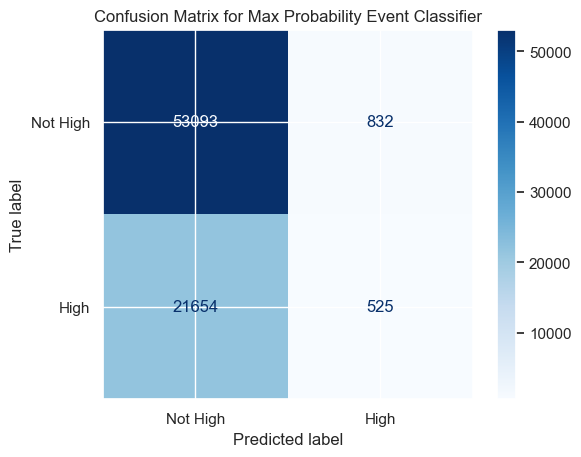

In [396]:
y_pred_max_prob = max_prob_test > 0.3592

cm = confusion_matrix(y_rf_test, y_pred_max_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Max Probability Event Classifier")

print(f"precision: {precision_score(y_rf_test, y_pred_max_prob):.3f}")
print(f"% possible trades : {100*y_pred_max_prob.sum() / y_pred_max_prob.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_max_prob.sum() / y_pred_max_prob.shape[0]:.0f}")


plt.show()


#### On 100 best prob

In [397]:
idx_best = df_prob_comb_high_event["p_high"].sort_values(ascending=False).head(100).index.values
idx_best

array([100753, 101939, 117273, 106618, 113682, 116382, 116841, 118407,
       118731, 120432, 104047, 128613, 127479,  98051, 123888, 102535,
       127047, 120510, 128937, 126588, 120375, 130638, 102209, 146811,
        25259, 218849,  95594,  77099, 192927, 154965,  12907, 147135,
        71969,   7222,    595,  12232,  11530,   7249,  10624,   2701,
        17428,  17455,   4684,   4657,  10651,  20830,  14890,   6763,
         3349,  14863,   6790,  10327,  20857,   5576,  10354,  16969,
       144516,  16996,   8788,  20533,   8815,  10732,   9112,  10759,
        10894,  20560, 215879,  19318,    688,   2026,   1324, 106699,
          715,  18994,  19021,  20938,  21100,   9139,  20965,   2119,
         7168,   6925,  19345,   4603,  12325,  17131,  17374,   2146,
       144975,   4360,  14566,   6709,  12352,   1417,  14809,   7654,
        26932, 146215,  10273,   7681])

In [398]:
df_prob_comb_high_event.loc[idx_best]

high   low  neutral    p_high     p_low  delta_prob  \
100753  1028   774     1058  0.359441  0.270629   71.604883   
101939  1114   800     1217  0.355797  0.255509  103.026123   
117273  1053   885     1023  0.355623  0.298886   29.126935   
106618  1144   893     1180  0.355611  0.277588   61.856652   
113682  1044   878     1017  0.355223  0.298741   28.674298   
...      ...   ...      ...       ...       ...         ...   
7654    2982  2613     3059  0.344581  0.301941   48.672386   
26932   3105  2705     3201  0.344579  0.300189   55.077453   
146215  1176  1009     1228  0.344565  0.295634   25.527689   
10273   3103  2699     3204  0.344548  0.299689   56.261979   
7681    2924  2562     3001  0.344527  0.301873   47.773970   

                      feat_0 feat_0_cat  lag_0               feat_1  ...  \
100753        vwap_w_ETH_cat        low     64   max_high_h_ETH_cat  ...   
101939  ichi_cloud_b_ETH_cat        low     40       vwap_h_ETH_cat  ...   
117273     min_low_h_ETH_cat        low     40    min_low_d_ETH_cat  ...   
106618    max_high_h_ETH_cat    neutral     40       vwap_w_ETH_cat  ...   
113682     min_low_h_ETH_cat        low     40    min_low_d_ETH_cat  ...   
...                      ...        ...    ...                  ...  ...   
7654      max_high_d_ETH_cat        low     70  ichi_tenkan_ETH_cat  ...   
26932     max_high_d_ETH_cat        low     68         High_ETH_cat  ...   
146215     min_low_h_ETH_cat        low      8         High_ETH_cat  ...   
10273     max_high_d_ETH_cat        low     70       vwap_w_ETH_cat  ...   
7681      max_high_d_ETH_cat        low     70  ichi_tenkan_ETH_cat  ...   

       lag_1              feat_2 feat_2_cat lag_2  days_with_event  \
100753    40         Low_ETH_cat        low    40              281   
101939    40  max_high_h_ETH_cat    neutral    40              412   
117273    64        High_ETH_cat       high    56              179   
106618    56         Low_ETH_cat        low    40              299   
113682    68        High_ETH_cat       high    56              179   
...      ...                 ...        ...   ...              ...   
7654       8      vwap_w_ETH_cat        low    70              412   
26932      8      vwap_w_ETH_cat        low    71              399   
146215    40   min_low_d_ETH_cat        low    56              170   
10273     56      vwap_w_ETH_cat        low    68              416   
7681       8      vwap_w_ETH_cat        low    71              401   

        weeks_with_event  months_with_event  ratio_days_with_event  \
100753               105                 28               0.318956   
101939               119                 29               0.467650   
117273                82                 28               0.203178   
106618               106                 29               0.339387   
113682                82                 28               0.203178   
...                  ...                ...                    ...   
7654                 122                 29               0.467650   
26932                119                 29               0.452894   
146215                81                 28               0.192963   
10273                122                 29               0.472191   
7681                 119                 29               0.455165   

        ratio_weeks_with_event  ratio_months_with_event  
100753                0.826772                 0.965517  
101939                0.937008                 1.000000  
117273                0.645669                 0.965517  
106618                0.834646                 1.000000  
113682                0.645669                 0.965517  
...                        ...                      ...  
7654                  0.960630                 1.000000  
26932                 0.937008                 1.000000  
146215                0.637795                 0.965517  
10273                 0.960630                 1.000000  
7681              

In [399]:
X_rf_test[idx_best]

100753  101939  117273  106618  113682  116382  116841  \
date_ETH                                                                      
2024-09-08 13:45:00   False   False   False   False   False   False   False   
2024-09-08 13:50:00   False   False   False   False   False   False   False   
2024-09-08 13:55:00   False   False   False   False   False   False   False   
2024-09-08 14:00:00   False   False   False   False   False   False   False   
2024-09-08 14:05:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False   False   False   False   False   
2025-05-30 19:20:00   False   False   False   False   False   False   False   
2025-05-30 19:25:00   False   False   False   False   False   False   False   
2025-05-30 19:30:00   False   False   False   False   False   False   False   
2025-05-30 19:35:00   False   False   False   False   False   False   False   

                     118407  118731  120432  ...  14566   6709    12352   \
date_ETH                                     ...                           
2024-09-08 13:45:00   False   False   False  ...   False   False   False   
2024-09-08 13:50:00   False   False   False  ...   False   False   False   
2024-09-08 13:55:00   False   False   False  ...   False   False   False   
2024-09-08 14:00:00   False   False   False  ...   False   False   False   
2024-09-08 14:05:00   False   False   False  ...   False   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False  ...   False   False   False   
2025-05-30 19:20:00   False   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False   False  ...   False   False   False   
2025-05-30 19:30:00   False   False   False  ...   False   False   False   
2025-05-30 19:35:00   False   False   False  ...   False   False   False   

                     1417    14809   7654    26932   146215  10273   7681    
date_ETH                                                                     
2024-09-08 13:45:00   False   False   False   False   False   False   False  
2024-09-08 13:50:00   False   False   False   False   False   False   False  
2024-09-08 13:55:00   False   False   False   False   False   False   False  
2024-09-08 14:00:00   False   False   False   False   False   False   False  
2024-09-08 14:05:00   False   False   False   False   False   False   False  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[76104 rows x 100 columns]

In [400]:
df_event_best_probs = X_rf_test[idx_best].multiply(df_prob_comb_high_event.loc[idx_best]['p_high'], axis='columns')
df_event_best_probs

100753  101939  117273  106618  113682  116382  116841  \
date_ETH                                                                      
2024-09-08 13:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-09-08 13:50:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-09-08 13:55:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-09-08 14:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-09-08 14:05:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2025-05-30 19:20:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2025-05-30 19:25:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2025-05-30 19:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2025-05-30 19:35:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     118407  118731  120432  ...  14566   6709    12352   \
date_ETH                                     ...                           
2024-09-08 13:45:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2024-09-08 13:50:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2024-09-08 13:55:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2024-09-08 14:00:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2024-09-08 14:05:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2025-05-30 19:20:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2025-05-30 19:25:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2025-05-30 19:30:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2025-05-30 19:35:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   

                     1417    14809   7654    26932   146215  10273   7681    
date_ETH                                                                     
2024-09-08 13:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2024-09-08 13:50:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2024-09-08 13:55:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2024-09-08 14:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2024-09-08 14:05:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2025-05-30 19:20:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2025-05-30 19:25:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2025-05-30 19:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2025-05-30 19:35:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[76104 rows x 100 columns]

In [401]:
max_best_prob_test = df_event_best_probs.max(axis=1)
max_best_prob_test

date_ETH
2024-09-08 13:45:00    0.0
2024-09-08 13:50:00    0.0
2024-09-08 13:55:00    0.0
2024-09-08 14:00:00    0.0
2024-09-08 14:05:00    0.0
                      ... 
2025-05-30 19:15:00    0.0
2025-05-30 19:20:00    0.0
2025-05-30 19:25:00    0.0
2025-05-30 19:30:00    0.0
2025-05-30 19:35:00    0.0
Length: 76104, dtype: float64

precision: 0.387
% possible trades : 1.78%
nb trade per day : 5.14


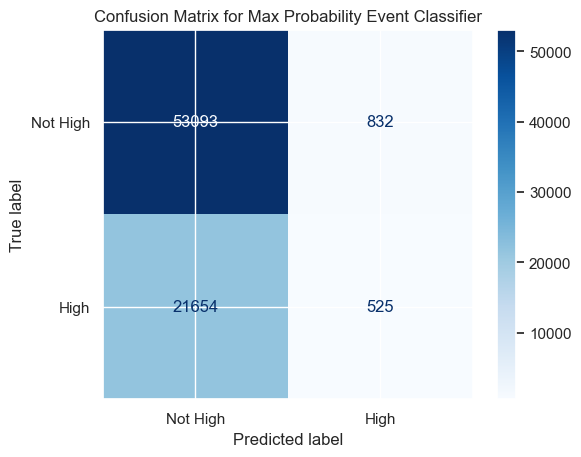

In [402]:
y_pred_max_best_prob = max_best_prob_test > 0.3594

cm = confusion_matrix(y_rf_test, y_pred_max_best_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Max Probability Event Classifier")

print(f"precision: {precision_score(y_rf_test, y_pred_max_best_prob):.3f}")
print(f"% possible trades : {100*y_pred_max_best_prob.sum() / y_pred_max_best_prob.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_max_best_prob.sum() / y_pred_max_best_prob.shape[0]:.2f}")

plt.show()

Exact same than All max prob : logical

### Mean Prob Model

In [403]:
df_event_probs = X_rf_test.multiply(df_prob_comb_high_event['p_high'], axis='columns')

df_prob_comb_high_event["p_high"]

391       0.344299
418       0.335258
553       0.341388
595       0.345455
634       0.344181
            ...   
216799    0.334313
217885    0.333762
218527    0.335143
218716    0.342985
218849    0.347133
Name: p_high, Length: 1163, dtype: float64

In [404]:
X_rf_test.shape

(76104, 1163)

In [405]:
arr_sum = (X_rf_test.values) @ (df_prob_comb_high_event["p_high"].values)


In [406]:
nb_true = X_rf_test.sum(axis=1).values


In [407]:
arr_mean_prob = arr_sum / nb_true

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/1357966142.py:1: RuntimeWarning: invalid value encountered in divide
  arr_mean_prob = arr_sum / nb_true


precision: 0.339
% possible trades : 9.37%
nb trade per day : 26.98


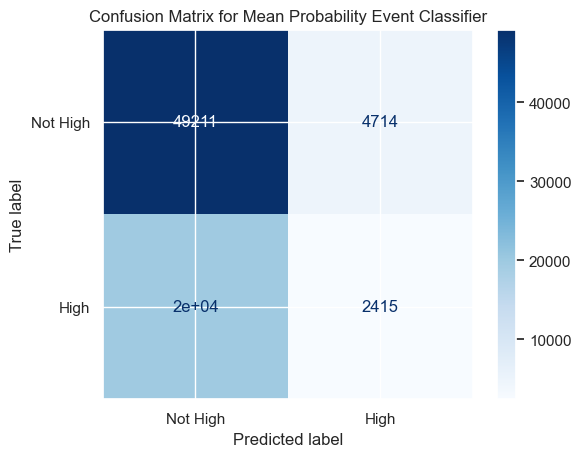

In [408]:
y_pred_mean_prob = arr_mean_prob >  0.34

cm = confusion_matrix(y_rf_test, y_pred_mean_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Mean Probability Event Classifier")

print(f"precision: {precision_score(y_rf_test, y_pred_mean_prob):.3f}")
print(f"% possible trades : {100*y_pred_mean_prob.sum() / y_pred_mean_prob.shape[0]:.2f}%")
# per day
print(f"nb trade per day : {288*y_pred_mean_prob.sum() / y_pred_mean_prob.shape[0]:.2f}")

plt.show()

Better precision with mean prob model
- close to Best event : precision = 0.518

#### On 100 best prob

In [409]:
arr_best_sum = (X_rf_test[idx_best].values) @ (df_prob_comb_high_event.loc[idx_best]["p_high"].values)

In [410]:
nb_best_true = X_rf_test[idx_best].sum(axis=1).values

In [411]:
arr_mean_best_prob = arr_best_sum / nb_best_true

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/2913283874.py:1: RuntimeWarning: invalid value encountered in divide
  arr_mean_best_prob = arr_best_sum / nb_best_true


In [412]:
arr_mean_best_prob

array([nan, nan, nan, ..., nan, nan, nan], shape=(76104,))

precision: 0.359
% possible trades : 6.85%
nb trade per day : 19.72


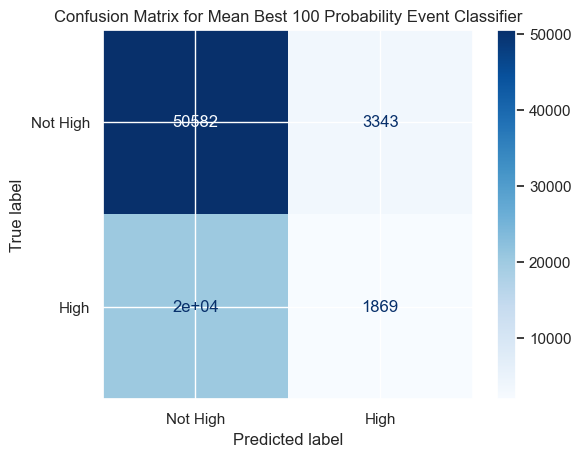

In [413]:
y_pred_mean_best_prob = arr_mean_best_prob > 0.347

cm = confusion_matrix(y_rf_test, y_pred_mean_best_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Mean Best 100 Probability Event Classifier")

print(f"precision: {precision_score(y_rf_test, y_pred_mean_best_prob):.3f}")
print(f"% possible trades : {100*y_pred_mean_best_prob.sum() / y_pred_mean_best_prob.shape[0]:.2f}%")
# per day
print(f"nb trade per day : {288*y_pred_mean_best_prob.sum() / y_pred_mean_best_prob.shape[0]:.2f}")


plt.show()

Not better than all mean prob

## ML Simple features

### Last 5 min features

In [414]:
df = list_df[0]

In [415]:
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  \
date_ETH                                                       
2023-01-01 00:00:00        1.0  0.999782  1.000109  0.999774   
2023-01-01 00:05:00        1.0  0.999548  1.000008  0.999540   
2023-01-01 00:10:00        1.0  1.000084  1.000193  0.999841   
2023-01-01 00:15:00        1.0  1.000770  1.000770  0.999900   
2023-01-01 00:20:00        1.0  0.999330  1.000025  0.999330   
...                        ...       ...       ...       ...   
2025-05-30 19:15:00        1.0  0.998258  1.001698  0.997009   
2025-05-30 19:20:00        1.0  0.998554  1.001387  0.998451   
2025-05-30 19:25:00        1.0  1.004900  1.005056  0.999299   
2025-05-30 19:30:00        1.0  1.001168  1.001491  0.997621   
2025-05-30 19:35:00        1.0  1.012121  1.014171  0.998487   

                     ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  \
date_ETH                                                                  
2023-01-01 00:00:00          0.999171          0.999736        0.998393   
2023-01-01 00:05:00          0.998785          0.999276        0.998113   
2023-01-01 00:10:00          0.998860          0.999351        0.998243   
2023-01-01 00:15:00          0.999669          1.000113        0.999003   
2023-01-01 00:20:00          0.999178          0.999443        0.998335   
...                               ...               ...             ...   
2025-05-30 19:15:00          1.009059          1.012239        1.000323   
2025-05-30 19:20:00          1.006895          1.010775        0.998877   
2025-05-30 19:25:00          1.011829          1.015728        1.003772   
2025-05-30 19:30:00          1.011492          1.015731        1.004944   
2025-05-30 19:35:00          1.023400          1.028043        1.011526   

                     ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
date_ETH                                                     
2023-01-01 00:00:00         0.999464              2.024261   
2023-01-01 00:05:00         0.999184              2.023329   
2023-01-01 00:10:00         0.999477              2.023482   
2023-01-01 00:15:00         1.000239              2.025023   
2023-01-01 00:20:00         0.999569              2.023668   
...                              ...                   ...   
2025-05-30 19:15:00         1.000559              1.043299   
2025-05-30 19:20:00         0.999113              1.041791   
2025-05-30 19:25:00         1.004009              1.046896   
2025-05-30 19:30:00         1.003987              1.048118   
2025-05-30 19:35:00         1.009147              1.060823   

                     ichi_cloud_b_day_ETH  ...  hour_cos_cat  hour_sin_cat  \
date_ETH                                   ...                               
2023-01-01 00:00:00              2.017807  ...       neutral          high   
2023-01-01 00:05:00              2.016878  ...       neutral          high   
2023-01-01 00:10:00              2.017030  ...       neutral          high   
2023-01-01 00:15:00              2.018567  ...       neutral          high   
2023-01-01 00:20:00              2.017215  ...       neutral          high   
...                                   ...  ...           ...           ...   
2025-05-30 19:15:00              1.026564  ...          high       neutral   
2025-05-30 19:20:00              1.025079  ...          high       neutral   
2025-05-30 19:25:00              1.030103  ...          high       neutral   
2025-05-30 19:30:00              1.031306  ...          high       neutral   
2025-05-30 19:35:00              1.043807  ...          high       neutral   

                     weekday_cos_cat  weekday_sin_cat  day_in_month_cos_cat  \
date_ETH                                                                      
2023-01-01 00:00:00          neutral          neutral                  high   
2023-01-01 00:05:00          neutral          neutral                  high   
2023-01-01 00:10:00          neutral          neutral                  hig

In [416]:
df["target_cat"]

date_ETH
2023-01-01 00:00:00    neutral
2023-01-01 00:05:00    neutral
2023-01-01 00:10:00    neutral
2023-01-01 00:15:00    neutral
2023-01-01 00:20:00    neutral
                        ...   
2025-05-30 19:15:00    neutral
2025-05-30 19:20:00        low
2025-05-30 19:25:00        low
2025-05-30 19:30:00        low
2025-05-30 19:35:00       high
Name: target_cat, Length: 253677, dtype: object

In [417]:
y_target = (df["target_cat"] == "high")

In [418]:
X_train_sca_dat[:,-1,:].shape

(253677, 109)

In [419]:
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(
    X_train_sca_dat[:,-1,:],
    y_target,
    test_size=0.3,
    shuffle=False
)

In [420]:
sgdc_1 = SGDClassifier(
    loss="log_loss",
    penalty="elasticnet",  # ou "elasticnet" si besoin de L1+L2
    alpha=5e-2,
    max_iter=1000,
    tol=1e-3,
    early_stopping=True,
    random_state=42
)

sgdc_1.fit(X_simple_train, y_simple_train)
print("Model trained.")
print("Accuracy on training data:", sgdc_1.score(X_simple_train, y_simple_train))
print("Accuracy on test data:", sgdc_1.score(X_simple_test, y_simple_test))


Model trained.
Accuracy on training data: 0.7769199146266605
Accuracy on test data: 0.7051666141070114


For Model SGDC: 
precision: 0.33
% possible trades : 1.01
nb trade per day : 3


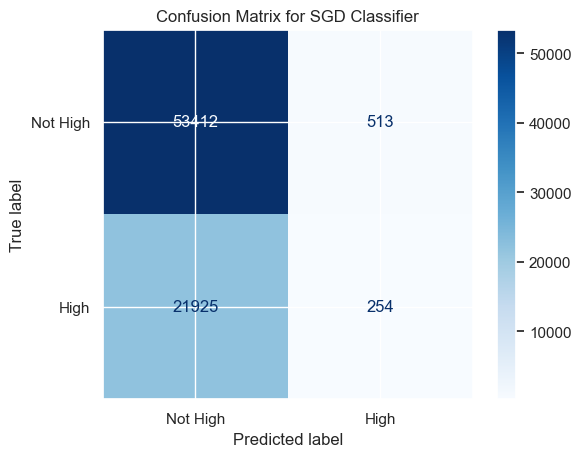

In [421]:
arr_sgdc_1_pred = sgdc_1.predict(X_simple_test)
cm = confusion_matrix(y_simple_test, arr_sgdc_1_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SGD Classifier")

print("For Model SGDC: ")
print(f"precision: {precision_score(y_simple_test, arr_sgdc_1_pred):.2f}")
print(f"% possible trades : {100*np.sum(arr_sgdc_1_pred) / arr_sgdc_1_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_sgdc_1_pred.sum() / arr_sgdc_1_pred.shape[0]:.0f}")
plt.show()

Conclusion : With only the last 5 min as features and the normal feature, the result is not better than with event cat

## Clustering
- Clustering is done with selected combined events (1160 for strat 3) (from df_combined)

In [422]:
n_components = 666 # 666 comp => 110 Go Memory !!!!
random_state = 42


In [423]:
# check hash pca
# check hash
#path_df_probability_filtered = os.path.join(path_data, 'df_probability_filtered.pkl')
mode_redo_pca, hash_pca = check_hash_inputs(
     (X_rf_train, 
      n_components, 
      random_state,
     ),
     path_hash_pca,
)

hash match: mode LOAD


In [424]:
X_rf_train.shape

(177573, 1163)

In [425]:
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
if mode_redo_pca:
    print("PCA fitting...")
    pca = PCA(n_components=n_components, random_state=random_state)
    # X_rf_train, X_rf_test, y_rf_train, y_rf_test
    pca.fit(X_rf_train)
    save_hash(path_hash_pca, hash_pca)
    joblib.dump(pca, path_pca)
    print("PCA saved.")
else:
    # load PCA
    print("Load PCA")
    pca = joblib.load(path_pca)


Load PCA


In [426]:
pca

PCA(n_components=666, random_state=42)

Variance cumulée par nombre de composantes :


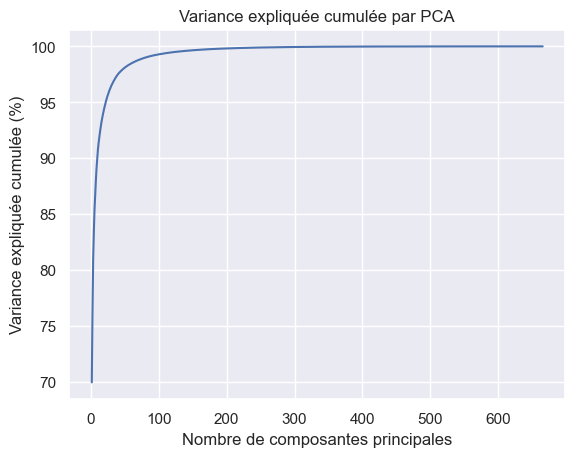

In [427]:

# Affichage de la variance cumulée en pourcentage
cum_var = np.cumsum(pca.explained_variance_ratio_) * 100
print("Variance cumulée par nombre de composantes :")

# Graphique optionnel de la variance expliquée
plt.plot(range(1, len(cum_var)+1), cum_var)
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée (%)")
plt.title("Variance expliquée cumulée par PCA")
plt.grid(True)
plt.show()

In [428]:
cum_var

array([69.94690158, 76.14128137, 80.8801979 , 83.35787716, 85.37970014,
       86.73589002, 87.99812183, 89.10453514, 89.94224513, 90.73943643,
       91.33817519, 91.83242404, 92.29967488, 92.71838375, 93.13327184,
       93.4853471 , 93.79290415, 94.09198995, 94.37533117, 94.63225562,
       94.88130119, 95.11657963, 95.34166175, 95.53936653, 95.72178864,
       95.89704026, 96.06593   , 96.22178878, 96.37514317, 96.5082549 ,
       96.63172627, 96.74840768, 96.86449647, 96.97871699, 97.08977607,
       97.19191459, 97.28689591, 97.37568005, 97.46075602, 97.5429745 ,
       97.61208195, 97.67897772, 97.74209561, 97.80104909, 97.85843128,
       97.91479488, 97.96919063, 98.02120779, 98.07165409, 98.11836013,
       98.16388612, 98.20675486, 98.24809183, 98.28910608, 98.3270182 ,
       98.36361589, 98.39943928, 98.4342285 , 98.46852826, 98.50150772,
       98.53315801, 98.5638018 , 98.5942069 , 98.62402888, 98.65328528,
       98.68182115, 98.70856151, 98.73450547, 98.75978214, 98.78

In [429]:
# 3. Choix du nombre de composantes correspondant à x% de variance expliquée
print(f"Choix de {n_components} composantes permet d atteindre {cum_var[n_components-1]}% de variance expliquée.")

X_pca = pca.transform(X_rf_train)

Choix de 666 composantes permet d atteindre 99.999686491022% de variance expliquée.


In [430]:

#kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)

from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(X_pca)

KMeans(n_clusters=5, random_state=42)

In [431]:
arr_labels = kmeans.labels_
X_pca_test = pca.transform(X_rf_test)
arr_labels_test = kmeans.predict(X_pca_test)
df_combined_condition["cluster"] = np.concatenate([arr_labels, arr_labels_test])
# add train columns
df_combined_condition["Train"] = [True]*X_rf_train.shape[0] + [False]*X_rf_test.shape[0]
df_combined_condition

391    418    553    595    634    688    715   1120  \
date_ETH                                                                      
2023-01-01 00:00:00  False  False  False  False  False  False  False  False   
2023-01-01 00:05:00  False  False  False  False  False  False  False  False   
2023-01-01 00:10:00  False  False  False  False  False  False  False  False   
2023-01-01 00:15:00  False  False  False  False  False  False  False  False   
2023-01-01 00:20:00  False  False  False  False  False  False  False  False   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2025-05-30 19:15:00  False  False  False  False  False  False  False  False   
2025-05-30 19:20:00  False  False  False  False  False  False  False  False   
2025-05-30 19:25:00  False  False  False  False  False  False  False  False   
2025-05-30 19:30:00  False  False  False  False  False  False  False  False   
2025-05-30 19:35:00  False  False  False  False  False  False  False  False   

                      1147   1282  ...  214429  215746  215879  216799  \
date_ETH                           ...                                   
2023-01-01 00:00:00  False  False  ...   False   False   False   False   
2023-01-01 00:05:00  False  False  ...   False   False   False   False   
2023-01-01 00:10:00  False  False  ...   False   False   False   False   
2023-01-01 00:15:00  False  False  ...   False   False   False   False   
2023-01-01 00:20:00  False  False  ...   False   False   False   False   
...                    ...    ...  ...     ...     ...     ...     ...   
2025-05-30 19:15:00  False  False  ...   False   False   False   False   
2025-05-30 19:20:00  False  False  ...   False   False   False   False   
2025-05-30 19:25:00  False  False  ...   False   False   False   False   
2025-05-30 19:30:00  False  False  ...   False   False   False   False   
2025-05-30 19:35:00  False  False  ...   False   False   False   False   

                     217885  218527  218716  218849  cluster  Train  
date_ETH                                                             
2023-01-01 00:00:00   False   False   False   False        0   True  
2023-01-01 00:05:00   False   False   False   False        0   True  
2023-01-01 00:10:00   False   False   False   False        0   True  
2023-01-01 00:15:00   False   False   False   False        0   True  
2023-01-01 00:20:00   False   False   False   False        0   True  
...                     ...     ...     ...     ...      ...    ...  
2025-05-30 19:15:00   False   False   False   False        0  False  
2025-05-30 19:20:00   False   False   False   False        0  False  
2025-05-30 19:25:00   False   False   False   False        0  False  
2025-05-30 19:30:00   False   False   False   False        0  False  
2025-05-30 19:35:00   False   False   False   False        0  False  

[253677 rows x 1165 columns]

In [432]:
# Calculate prob of target "high" for each cluster on Train
nb_train = df_combined_condition[df_combined_condition["Train"]].shape[0]
df_cluster_prob = df_combined_condition[df_combined_condition["Train"]].groupby("cluster").apply(
    lambda g: pd.Series({
        "p_high": ((list_df[0]["target_cat"] == "high")[g.index]).mean(),
        "count": g.shape[0],
        "percentage": 100 * g.shape[0] / nb_train,
    })
).reset_index()
df_cluster_prob

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/2810247255.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cluster_prob = df_combined_condition[df_combined_condition["Train"]].groupby("cluster").apply(


cluster    p_high     count  percentage
0        0  0.215742  167612.0   94.390476
1        1  0.335378    5218.0    2.938510
2        2  0.322702    2132.0    1.200633
3        3  0.303492    1575.0    0.886959
4        4  0.338803    1036.0    0.583422

n_comp = 264, n_clusters = 20, p_high = 0.518, occ = 11806, percent occ = 6.64 %  
n_comp = 200, n_clusters = 20, p_high = 0.517, occ = 12900, percent occ = 7.26 %


In [433]:
# same for Test
nb_test = df_combined_condition[~df_combined_condition["Train"]].shape[0]
df_cluster_prob_test = df_combined_condition[~df_combined_condition["Train"]].groupby("cluster").apply(
    lambda g: pd.Series({
        "p_high": ((list_df[0]["target_cat"] == "high")[g.index]).mean(),
        "count": g.shape[0],
        "percentage": 100 * g.shape[0] / nb_test,
    })
).reset_index()
df_cluster_prob_test

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_6445/2789464816.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cluster_prob_test = df_combined_condition[~df_combined_condition["Train"]].groupby("cluster").apply(


cluster    p_high    count  percentage
0        0  0.286431  69917.0   91.870335
1        1  0.357164   3357.0    4.411069
2        2  0.340394   1369.0    1.798854
3        3  0.340348   1093.0    1.436193
4        4  0.312500    368.0    0.483549

In [434]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(X_pca, arr_labels)

146791.4255317297

In [435]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(X_pca, arr_labels)

0.9908345107452868

In [ ]:
# redo kmeans with n clusters to prepare find the best n_clusters
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
nb_clusters_min = 5
nb_clusters_max = 100
nb_cluster_step = 5
list_ser_cluster = []
list_silhouette_score = []
list_ch_score = []
list_db_score = []
for n_clusters in range(nb_clusters_min, nb_clusters_max, nb_cluster_step):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_pca)
    arr_labels = kmeans.labels_
    #silh_score = silhouette_score(X_pca, arr_labels)
    #ch_score = calinski_harabasz_score(X_pca, arr_labels)
    #list_silhouette_score.append(silh_score)
    #list_ch_score.append(ch_score)
    db_score = davies_bouldin_score(X_pca, arr_labels)
    list_db_score.append(db_score)
    print(f"k means on n_clusters = {n_clusters} / davies_bouldin_score: {db_score}")
    arr_labels_test = kmeans.predict(X_pca_test)
    list_ser_cluster.append(
        pd.Series(
            np.concatenate([arr_labels, arr_labels_test]), 
            index=df_combined_condition.index,
            name=f"cluster_{n_clusters}",
        )
    )
print("Adding clusters to df_combined_condition")
#  concat only on columns not in list_ser_cluster
columns_to_keep = df_combined_condition.columns.difference(
    [ser.name for ser in list_ser_cluster]
)
df_combined_condition = pd.concat(
    [df_combined_condition.filter(columns_to_keep, axis=1)] + list_ser_cluster, axis=1)

k means on n_clusters = 5 / davies_bouldin_score: 0.9908345107452868
k means on n_clusters = 10 / davies_bouldin_score: 1.2442321821948754
k means on n_clusters = 15 / davies_bouldin_score: 1.2815827462803133
k means on n_clusters = 20 / davies_bouldin_score: 1.2068152089386213
k means on n_clusters = 25 / davies_bouldin_score: 1.2056378858648058
k means on n_clusters = 30 / davies_bouldin_score: 1.2614933923770033
k means on n_clusters = 35 / davies_bouldin_score: 1.276258964638774
k means on n_clusters = 40 / davies_bouldin_score: 1.2799879844791218
k means on n_clusters = 45 / davies_bouldin_score: 1.3196426457443993
k means on n_clusters = 50 / davies_bouldin_score: 1.3444846400426658
k means on n_clusters = 55 / davies_bouldin_score: 1.3143436764264735
k means on n_clusters = 60 / davies_bouldin_score: 1.278734647507008
k means on n_clusters = 65 / davies_bouldin_score: 1.2723118734854562
k means on n_clusters = 70 / davies_bouldin_score: 1.2816488625390419
k means on n_clusters =

In [437]:
b_train = df_combined_condition["Train"]
ser_high_train = list_df[0].loc[b_train, "target_cat"] == "high"

b_test = ~df_combined_condition["Train"]
ser_high_test = list_df[0].loc[b_test, "target_cat"] == "high"


In [438]:
# find best nb cluster with p_high > p_high_min & count > nb_count_min:
p_high_min = 0.35
nb_count_min = 150
best_cluster_tot = None

for n_clusters in range(nb_clusters_min, nb_clusters_max, nb_cluster_step):
    #df_combined_condition[f"cluster_{n_clusters}"] = np.concatenate([arr_labels, arr_labels_test])
    # Calculate prob of target "high" for each cluster on Train
    df_cluster_prob_train = df_combined_condition.copy().loc[b_train].groupby(f"cluster_{n_clusters}").apply(
        lambda g: pd.Series({
            "p_high": ((ser_high_train)[g.index]).mean(),
            "count": g.shape[0],
            "percentage": 100 * g.shape[0] / nb_train,
        })
    , include_groups=False).reset_index()
    # filter even rare trades: if p_high > p_high_min and count > nb_clusters_min
    best_cluster = df_cluster_prob_train.copy()[(df_cluster_prob_train["p_high"] > p_high_min) & (df_cluster_prob_train["count"] > nb_count_min)]
    if best_cluster.shape[0] > 0:
        best_cluster.loc[:, "nb_clusters"] = n_clusters * np.ones(best_cluster.shape[0], dtype=int)
        # rename col
        best_cluster.rename(
            columns={
                "nb_clusters":"nb_clusters",
                "cluster_"+str(n_clusters): "cluster", 
                "p_high": "p_high", 
                "count": "count", 
                "percentage": "percentage"
            }, inplace=True
        )
        # append to a dataframe
        if best_cluster_tot is None:
            best_cluster_tot = best_cluster.copy()
        else:
            best_cluster_tot = pd.concat([best_cluster_tot, best_cluster.copy()], axis=0)
        print(f"n_clusters: {n_clusters} : \n {best_cluster}")
best_cluster_tot

n_clusters: 15 : 
     cluster    p_high  count  percentage  nb_clusters
14       14  0.413374  658.0    0.370552           15
n_clusters: 20 : 
     cluster    p_high  count  percentage  nb_clusters
3         3  0.354701  468.0    0.263554           20
17       17  0.358663  329.0    0.185276           20
18       18  0.460177  339.0    0.190907           20
n_clusters: 25 : 
     cluster    p_high  count  percentage  nb_clusters
14       14  0.358663  329.0    0.185276           25
24       24  0.437653  409.0    0.230328           25
n_clusters: 30 : 
     cluster    p_high  count  percentage  nb_clusters
14       14  0.358663  329.0    0.185276           30
24       24  0.451282  390.0    0.219628           30
27       27  0.454545  165.0    0.092920           30
28       28  0.360947  169.0    0.095172           30
n_clusters: 35 : 
     cluster    p_high  count  percentage  nb_clusters
14       14  0.358663  329.0    0.185276           35
24       24  0.485246  305.0    0.171760 

cluster    p_high  count  percentage  nb_clusters
14       14  0.413374  658.0    0.370552           15
3         3  0.354701  468.0    0.263554           20
17       17  0.358663  329.0    0.185276           20
18       18  0.460177  339.0    0.190907           20
14       14  0.358663  329.0    0.185276           25
24       24  0.437653  409.0    0.230328           25
14       14  0.358663  329.0    0.185276           30
24       24  0.451282  390.0    0.219628           30
27       27  0.454545  165.0    0.092920           30
28       28  0.360947  169.0    0.095172           30
14       14  0.358663  329.0    0.185276           35
24       24  0.485246  305.0    0.171760           35
27       27  0.452830  159.0    0.089541           35
28       28  0.360465  172.0    0.096862           35
14       14  0.358663  329.0    0.185276           40
24       24  0.432653  245.0    0.137971           40
27       27  0.458599  157.0    0.088414           40
28       28  0.360465  172.0    0.096862           40
35       35  0.477707  157.0    0.088414           40
14       14  0.358663  329.0    0.185276           45
27       27  0.464968  157.0    0.088414           45
28       28  0.355263  152.0    0.085599           45
44       44  0.372222  180.0    0.101367           45
14       14  0.358663  329.0    0.185276           50
28       28  0.355263  152.0    0.085599           50
44       44  0.372222  180.0    0.101367           50
10       10  0.376471  170.0    0.095735           55
14       14  0.358663  329.0    0.185276           55
18       18  0.435233  193.0    0.108688           55
28       28  0.356725  171.0    0.096298           55
14       14  0.362229  323.0    0.181897           60
18       18  0.435233  193.0    0.108688           60
28       28  0.356725  171.0    0.096298           60
14       14  0.362229  323.0    0.181897           65
28       28  0.356725  171.0    0.096298           65
14       14  0.362229  323.0    0.181897           70
28       28  0.356725  171.0    0.096298           70
14       14  0.362229  323.0    0.181897           75
14       14  0.362229  323.0    0.181897           80
19       19  0.360153  261.0    0.146982           80
75       75  0.403727  161.0    0.090667           80
14       14  0.362229  323.0    0.181897           85
19       19  0.360153  261.0    0.146982           85
4         4  0.353383  266.0    0.149798           90
14       14  0.362229  323.0    0.181897           90
19       19  0.360153  261.0    0.146982           90
4         4  0.353383  266.0    0.149798           95
14       14  0.362229  323.0    0.181897           95
19       19  0.360153  261.0    0.146982           95

In [439]:
# calculate p_high_test on each cluster_{nb_clusters}, n_cluster for best_cluster_tot
best_cluster_test = None
best_cluster_tot_test = best_cluster_tot.copy()
for n_clusters in best_cluster_tot["nb_clusters"].unique():
    #b_n_cluster = df_combined_condition[f"cluster_{n_clusters}"] == n_clusters
    list_cluster_in = best_cluster_tot[best_cluster_tot["nb_clusters"] == n_clusters]["cluster"].unique()
    b_n_cluster = df_combined_condition[f"cluster_{n_clusters}"].isin(list_cluster_in)
    # Calculate prob of target "high" for each cluster on Test
    df_cluster_prob_test = df_combined_condition.copy().loc[b_test & b_n_cluster].groupby(f"cluster_{n_clusters}").apply(
        lambda g: pd.Series({
            "p_high_test": ((ser_high_test)[g.index]).mean(),
            "count_test": g.shape[0],
            "percentage_test": 100 * g.shape[0] / nb_test,
        })
    , include_groups=False).reset_index()
    df_cluster_prob_test.loc[:, "nb_clusters"] = n_clusters * np.ones(df_cluster_prob_test.shape[0], dtype=int)
    df_cluster_prob_test.rename(
            columns={
                "cluster_"+str(n_clusters): "cluster", 
            }, inplace=True
    )
    #print("test :")
    #print(df_cluster_prob_test)
    # concat best_cluster_tot_test with df_cluster_prob_test on nb_clusters and cluster
    # append to a dataframe
    if best_cluster_test is None:
         best_cluster_test = df_cluster_prob_test.copy()
    else:
        best_cluster_test = pd.concat([best_cluster_test, df_cluster_prob_test], axis=0)
# merge with best_cluster_tot
best_cluster_tot_test = best_cluster_tot_test.merge(
    best_cluster_test,
    left_on=["nb_clusters", "cluster"],
    right_on=["nb_clusters", "cluster"],
    how="left",
)

best_cluster_tot = best_cluster_tot_test.copy()
best_cluster_tot

cluster    p_high  count  percentage  nb_clusters  p_high_test  \
0        14  0.413374  658.0    0.370552           15     0.311787   
1         3  0.354701  468.0    0.263554           20     0.366834   
2        17  0.358663  329.0    0.185276           20     0.296460   
3        18  0.460177  339.0    0.190907           20     0.262548   
4        14  0.358663  329.0    0.185276           25     0.297778   
5        24  0.437653  409.0    0.230328           25     0.350000   
6        14  0.358663  329.0    0.185276           30     0.297778   
7        24  0.451282  390.0    0.219628           30     0.368732   
8        27  0.454545  165.0    0.092920           30     0.414966   
9        28  0.360947  169.0    0.095172           30     0.274336   
10       14  0.358663  329.0    0.185276           35     0.297778   
11       24  0.485246  305.0    0.171760           35     0.264957   
12       27  0.452830  159.0    0.089541           35     0.425532   
13       28  0.360465  172.0    0.096862           35     0.276786   
14       14  0.358663  329.0    0.185276           40     0.297778   
15       24  0.432653  245.0    0.137971           40     0.430556   
16       27  0.458599  157.0    0.088414           40     0.428571   
17       28  0.360465  172.0    0.096862           40     0.284404   
18       35  0.477707  157.0    0.088414           40     0.238462   
19       14  0.358663  329.0    0.185276           45     0.297778   
20       27  0.464968  157.0    0.088414           45     0.416667   
21       28  0.355263  152.0    0.085599           45     0.273684   
22       44  0.372222  180.0    0.101367           45     0.476744   
23       14  0.358663  329.0    0.185276           50     0.297778   
24       28  0.355263  152.0    0.085599           50     0.268041   
25       44  0.372222  180.0    0.101367           50     0.476744   
26       10  0.376471  170.0    0.095735           55     0.417722   
27       14  0.358663  329.0    0.185276           55     0.297778   
28       18  0.435233  193.0    0.108688           55     0.391061   
29       28  0.356725  171.0    0.096298           55     0.292453   
30       14  0.362229  323.0    0.181897           60     0.300448   
31       18  0.435233  193.0    0.108688           60     0.391061   
32       28  0.356725  171.0    0.096298           60     0.292453   
33       14  0.362229  323.0    0.181897           65     0.300448   
34       28  0.356725  171.0    0.096298           65     0.292453   
35       14  0.362229  323.0    0.181897           70     0.300448   
36       28  0.356725  171.0    0.096298           70     0.292453   
37       14  0.362229  323.0    0.181897           75     0.300448   
38       14  0.362229  323.0    0.181897           80     0.300448   
39       19  0.360153  261.0    0.146982           80     0.258065   
40       75  0.403727  161.0    0.090667           80     0.327273   
41       14  0.362229  323.0    0.181897           85     0.300448   
42       19  0.360153  261.0    0.146982           85     0.258065   
43        4  0.353383  266.0    0.149798           90     0.293333   
44       14  0.362229  323.0    0.181897           90     0.300448   
45       19  0.360153  261.0    0.146982           90     0.258065   
46        4  0.353383  266.0    0.149798           95     0.293333   
47       14  0.362229  323.0    0.181897           95     0.300448   
48       19  0.360153  261.0    0.146982           95     0.263736   

    count_test  percentage_test  
0        526.0         0.691159  
1        398.0         0.522969  
2        226.0         0.296962  
3        259.0         0.340324  
4        225.0         0.295648  
5        360.0         0.473037  
6        225.0         0.295648  
7        339.0         0.445443  
8        147.0         0.193157  
9        113.0         0.148481  
10       225.0         0.295648  
11       234.0         0.307474  
12       141.0         0.185273  
13       112.0         0.14

In [440]:
best_cluster_tot.sort_values(by="p_high", ascending=False).head(50)

cluster    p_high  count  percentage  nb_clusters  p_high_test  \
11       24  0.485246  305.0    0.171760           35     0.264957   
18       35  0.477707  157.0    0.088414           40     0.238462   
20       27  0.464968  157.0    0.088414           45     0.416667   
3        18  0.460177  339.0    0.190907           20     0.262548   
16       27  0.458599  157.0    0.088414           40     0.428571   
8        27  0.454545  165.0    0.092920           30     0.414966   
12       27  0.452830  159.0    0.089541           35     0.425532   
7        24  0.451282  390.0    0.219628           30     0.368732   
5        24  0.437653  409.0    0.230328           25     0.350000   
28       18  0.435233  193.0    0.108688           55     0.391061   
31       18  0.435233  193.0    0.108688           60     0.391061   
15       24  0.432653  245.0    0.137971           40     0.430556   
0        14  0.413374  658.0    0.370552           15     0.311787   
40       75  0.403727  161.0    0.090667           80     0.327273   
26       10  0.376471  170.0    0.095735           55     0.417722   
22       44  0.372222  180.0    0.101367           45     0.476744   
25       44  0.372222  180.0    0.101367           50     0.476744   
38       14  0.362229  323.0    0.181897           80     0.300448   
33       14  0.362229  323.0    0.181897           65     0.300448   
47       14  0.362229  323.0    0.181897           95     0.300448   
35       14  0.362229  323.0    0.181897           70     0.300448   
37       14  0.362229  323.0    0.181897           75     0.300448   
30       14  0.362229  323.0    0.181897           60     0.300448   
41       14  0.362229  323.0    0.181897           85     0.300448   
44       14  0.362229  323.0    0.181897           90     0.300448   
9        28  0.360947  169.0    0.095172           30     0.274336   
17       28  0.360465  172.0    0.096862           40     0.284404   
13       28  0.360465  172.0    0.096862           35     0.276786   
39       19  0.360153  261.0    0.146982           80     0.258065   
45       19  0.360153  261.0    0.146982           90     0.258065   
42       19  0.360153  261.0    0.146982           85     0.258065   
48       19  0.360153  261.0    0.146982           95     0.263736   
19       14  0.358663  329.0    0.185276           45     0.297778   
14       14  0.358663  329.0    0.185276           40     0.297778   
2        17  0.358663  329.0    0.185276           20     0.296460   
27       14  0.358663  329.0    0.185276           55     0.297778   
4        14  0.358663  329.0    0.185276           25     0.297778   
6        14  0.358663  329.0    0.185276           30     0.297778   
23       14  0.358663  329.0    0.185276           50     0.297778   
10       14  0.358663  329.0    0.185276           35     0.297778   
32       28  0.356725  171.0    0.096298           60     0.292453   
29       28  0.356725  171.0    0.096298           55     0.292453   
36       28  0.356725  171.0    0.096298           70     0.292453   
34       28  0.356725  171.0    0.096298           65     0.292453   
21       28  0.355263  152.0    0.085599           45     0.273684   
24       28  0.355263  152.0    0.085599           50     0.268041   
1         3  0.354701  468.0    0.263554           20     0.366834   
43        4  0.353383  266.0    0.149798           90     0.293333   
46        4  0.353383  266.0    0.149798           95     0.293333   

    count_test  percentage_test  
11       234.0         0.307474  
18       130.0         0.170819  
20       144.0         0.189215  
3        259.0         0.340324  
16       140.0         0.183959  
8        147.0         0.193157  
12       141.0         0.185273  
7        339.0         0.445443  
5        360.0         0.473037  
28       179.0         0.235204  
31       179.0         0.235204  
15       216.0         0.283822  
0        526.0         0.691159  
40       110.0         0.14

### Model from clustering
- Select only best clusters with a minimum prob p_high_cluster_best
- Calculate the mean prob per group "nb_clusters"
- Calculate count for "high" target per group "nb_clusters"
- Select only group with count  > ratio_trades_cluster_best * nb_test

In [441]:
p_high_min

0.35

In [442]:
p_high_cluster_best = 0.4 # min prob high for each cluster to filter best clusters
ratio_trades_cluster_best = 0.1/288 # ratio trades per day per group "nb_clusters" of best prob clusters

best_cluster_tot["prod_prob"] = best_cluster_tot["p_high"] * best_cluster_tot["count"]
best_cluster_tot["prod_prob_test"] = best_cluster_tot["p_high_test"] * best_cluster_tot["count_test"]
# sumup count & prod_prob in cluster with prob > p_high_cluster_best group by nb_clusters :
best_count = best_cluster_tot[best_cluster_tot["p_high"] > p_high_cluster_best].filter(
    ["nb_clusters", "count", "prod_prob", "count_test", "prod_prob_test"]
    ).groupby("nb_clusters").sum()
best_count["prob"] = best_count["prod_prob"] / best_count["count"]
best_count["prob_test"] = best_count["prod_prob_test"] / best_count["count_test"]
# select only count > ratio_trades_cluster_best trades per days
best_count_final = best_count[best_count["count"] > nb_train*ratio_trades_cluster_best].sort_values(by="prob", ascending=False)
# take the first one
nb_cluster_best = best_count_final.index[0]
print(f"nb_cluster_best: {nb_cluster_best}")    # nb_cluster_best

best_count_final

nb_cluster_best: 35


count  prod_prob  count_test  prod_prob_test      prob  prob_test
nb_clusters                                                                   
35           464.0      220.0       375.0           122.0  0.474138   0.325333
45           157.0       73.0       144.0            60.0  0.464968   0.416667
20           339.0      156.0       259.0            68.0  0.460177   0.262548
40           559.0      253.0       486.0           184.0  0.452594   0.378601
30           555.0      251.0       486.0           186.0  0.452252   0.382716
25           409.0      179.0       360.0           126.0  0.437653   0.350000
55           193.0       84.0       179.0            70.0  0.435233   0.391061
60           193.0       84.0       179.0            70.0  0.435233   0.391061
15           658.0      272.0       526.0           164.0  0.413374   0.311787
80           161.0       65.0       110.0            36.0  0.403727   0.327273

In [443]:
# select only the best clusters with p_high > p_high_cluster_best 
# and in group "nb_clusters" with count > nb_test*ratio_trades_cluster_best trades per day
best_cluster_select = best_cluster_tot[
    (best_cluster_tot["p_high"] > p_high_cluster_best) & 
    (best_cluster_tot["nb_clusters"].isin(
        best_count[best_count["count"] > nb_test*ratio_trades_cluster_best].index.tolist()))
]
best_cluster_select.sort_values(by="p_high", ascending=False)

cluster    p_high  count  percentage  nb_clusters  p_high_test  \
11       24  0.485246  305.0    0.171760           35     0.264957   
18       35  0.477707  157.0    0.088414           40     0.238462   
20       27  0.464968  157.0    0.088414           45     0.416667   
3        18  0.460177  339.0    0.190907           20     0.262548   
16       27  0.458599  157.0    0.088414           40     0.428571   
8        27  0.454545  165.0    0.092920           30     0.414966   
12       27  0.452830  159.0    0.089541           35     0.425532   
7        24  0.451282  390.0    0.219628           30     0.368732   
5        24  0.437653  409.0    0.230328           25     0.350000   
28       18  0.435233  193.0    0.108688           55     0.391061   
31       18  0.435233  193.0    0.108688           60     0.391061   
15       24  0.432653  245.0    0.137971           40     0.430556   
0        14  0.413374  658.0    0.370552           15     0.311787   
40       75  0.403727  161.0    0.090667           80     0.327273   

    count_test  percentage_test  prod_prob  prod_prob_test  
11       234.0         0.307474      148.0            62.0  
18       130.0         0.170819       75.0            31.0  
20       144.0         0.189215       73.0            60.0  
3        259.0         0.340324      156.0            68.0  
16       140.0         0.183959       72.0            60.0  
8        147.0         0.193157       75.0            61.0  
12       141.0         0.185273       72.0            60.0  
7        339.0         0.445443      176.0           125.0  
5        360.0         0.473037      179.0           126.0  
28       179.0         0.235204       84.0            70.0  
31       179.0         0.235204       84.0            70.0  
15       216.0         0.283822      106.0            93.0  
0        526.0         0.691159      272.0           164.0  
40       110.0         0.144539       65.0            36.0

In [444]:
216.0 / nb_test * 288

0.8174077578051088

In [445]:
clusters_best = best_cluster_select[(best_cluster_select["nb_clusters"] == nb_cluster_best)]["cluster"].tolist()
df_combined_condition["in_cluster_best"] = df_combined_condition[f"cluster_{nb_cluster_best}"].isin(clusters_best)
best_cluster_final = best_cluster_select.copy()[(best_cluster_select["nb_clusters"] == nb_cluster_best)].sort_values(by="p_high", ascending=False)
best_cluster_final


cluster    p_high  count  percentage  nb_clusters  p_high_test  \
11       24  0.485246  305.0    0.171760           35     0.264957   
12       27  0.452830  159.0    0.089541           35     0.425532   

    count_test  percentage_test  prod_prob  prod_prob_test  
11       234.0         0.307474      148.0            62.0  
12       141.0         0.185273       72.0            60.0

#### Check on all DATA

In [446]:
# # clustering range
# nb_clusters_min = 2
# nb_clusters_max = 20
# nb_cluster_step = 1
# # selection criteria for single cluster
# p_high_min = 0.33
# nb_count_min = 700
# # selection criteria for best nb_clusters
# p_high_cluster_best = 0.333 # min prob high for each cluster to filter best clusters
# ratio_trades_cluster_best = 2/288 # ratio trades per day per group "nb_clusters" of best prob clusters
# TRAIN: True Pos. / Predicted Pos.: 1928 / 5735
# precision on Train :  0.3361813426329555
# TEST: True Pos. / Predicted Pos.: 1292 / 3645
# precision on Test :  0.3544581618655693

In [447]:
print("TRAIN: True Pos. / Predicted Pos.: " + 
 f"{np.sum(df_combined_condition.loc[b_train, 
    "in_cluster_best"] & ser_high_train)} / {np.sum(
        df_combined_condition.loc[b_train, "in_cluster_best"])}"
)
print("precision on Train : ", (
    np.sum(df_combined_condition.loc[b_train, "in_cluster_best"] & ser_high_train) / 
    np.sum(df_combined_condition.loc[b_train, "in_cluster_best"])
    )
)
print("TEST: True Pos. / Predicted Pos.: " + 
 f"{np.sum(df_combined_condition.loc[b_test, 
    "in_cluster_best"] & ser_high_test)} / {np.sum(
        df_combined_condition.loc[b_test, "in_cluster_best"])}"
)
print("precision on Test : ", (
    np.sum(df_combined_condition.loc[b_test, "in_cluster_best"] & ser_high_test) / 
    np.sum(df_combined_condition.loc[b_test, "in_cluster_best"])
    )
)

TRAIN: True Pos. / Predicted Pos.: 220 / 464
precision on Train :  0.47413793103448276
TEST: True Pos. / Predicted Pos.: 122 / 375
precision on Test :  0.3253333333333333


In [610]:
(220+122) / (464+375)

0.40762812872467225

In [448]:
ser_comb_best = df_combined_condition.loc[df_combined_condition[f"cluster_{nb_cluster_best}"] == best_cluster_final["cluster"].iloc[0]].filter([I for I in range(df_probability_filtered.shape[1])]
).mean(axis=0).sort_values(ascending=False).head(20)
ser_comb_best

391     1.000000
553     1.000000
634     1.000000
688     1.000000
715     1.000000
1120    1.000000
418     0.949907
1147    0.949907
595     0.000000
dtype: float64

In [449]:
df_prob_comb.loc[ser_comb_best.index]

high   low  neutral    p_high     p_low  delta_prob              feat_0  \
391   3213  2791     3328  0.344299  0.299078   59.321785  max_high_d_ETH_cat   
553   3433  3003     3620  0.341388  0.298628   57.458048  max_high_d_ETH_cat   
634   3046  2658     3146  0.344181  0.300339   52.785414  max_high_d_ETH_cat   
688   2955  2580     3032  0.344928  0.301156   50.813008  max_high_d_ETH_cat   
715   2897  2530     2973  0.344881  0.301190   49.636632  max_high_d_ETH_cat   
1120  3256  2831     3383  0.343823  0.298944   59.347790  max_high_d_ETH_cat   
418   3717  3278     4092  0.335258  0.295662   55.102502  max_high_d_ETH_cat   
1147  3752  3319     4138  0.334731  0.296101   53.030406  max_high_d_ETH_cat   
595   1007   836     1072  0.345455  0.286792   31.731959  max_high_d_ETH_cat   

     feat_0_cat  lag_0              feat_1 feat_1_cat  lag_1  \
391         low     70  max_high_d_ETH_cat        low     71   
553         low     70  max_high_d_ETH_cat        low     71   
634         low     70  max_high_d_ETH_cat        low     71   
688         low     70  max_high_d_ETH_cat        low     71   
715         low     70  max_high_d_ETH_cat        low     71   
1120        low     70  max_high_d_ETH_cat        low     68   
418         low     70  max_high_d_ETH_cat        low     71   
1147        low     70  max_high_d_ETH_cat        low     68   
595        high     70  max_high_d_ETH_cat       high     71   

                    feat_2 feat_2_cat  lag_2  
391         vwap_w_ETH_cat        low     64  
553         vwap_w_ETH_cat        low     56  
634         vwap_w_ETH_cat        low     68  
688         vwap_w_ETH_cat        low     70  
715         vwap_w_ETH_cat        low     71  
1120        vwap_w_ETH_cat        low     64  
418   ichi_cloud_b_ETH_cat        low     40  
1147  ichi_cloud_b_ETH_cat        low     40  
595   ichi_cloud_a_ETH_cat        low      8

#### in cluster best

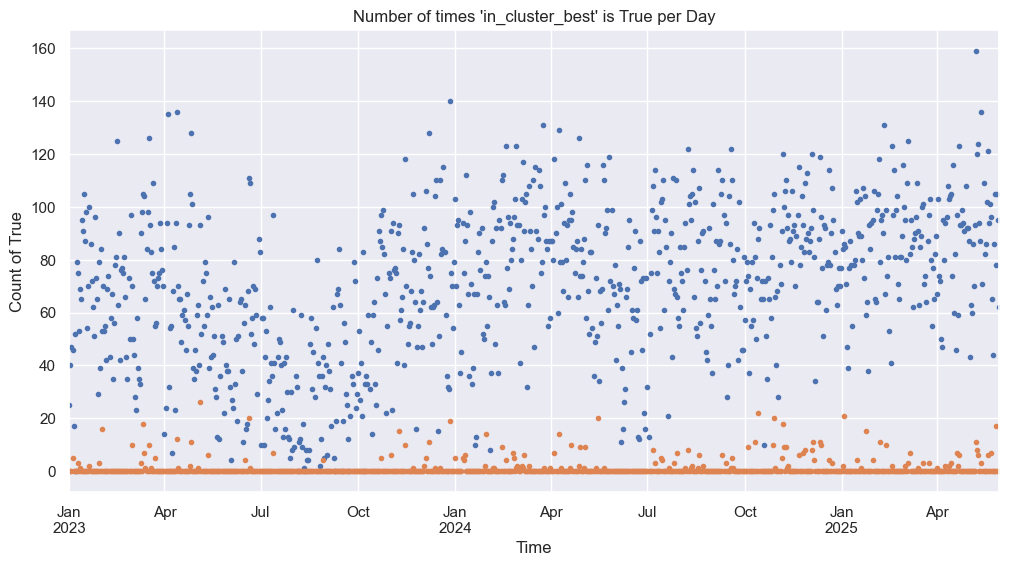

In [622]:
# by group sum every day
(list_df[0]["target_cat"] == "high").resample("D").sum().plot(figsize=(12, 6), linestyle='', marker=".")
df_combined_condition["in_cluster_best"].resample("D").sum().plot(figsize=(12, 6), linestyle='', marker=".")

plt.title("Number of times 'in_cluster_best' is True per Day")
plt.xlabel("Time")
plt.ylabel("Count of True")
plt.grid(True)

In [451]:
df_combined_condition["in_cluster_best"].resample("D").sum().describe()


count    881.000000
mean       0.952327
std        3.070756
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       26.000000
Name: in_cluster_best, dtype: float64

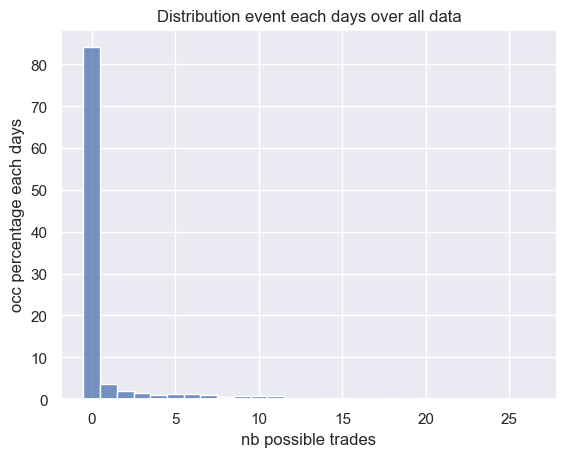

In [452]:
#df_combined_condition["in_cluster_best"].resample("D").sum()#.hist()#value_counts(ascending=True)

sns.histplot(df_combined_condition["in_cluster_best"].resample("D").sum(), 
             discrete=True,
             stat="percent")#.hist()#value_counts(ascending=True)
# rename xlabel
ax = plt.gca()
ax.set_xlabel("nb possible trades")
ax.set_ylabel("occ percentage each days")
plt.title("Distribution event each days over all data")
plt.show()

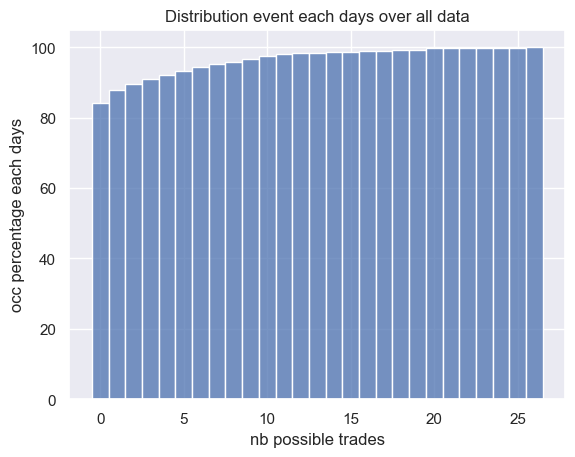

In [453]:

sns.histplot(df_combined_condition["in_cluster_best"].resample("D").sum(), 
             discrete=True,
             cumulative=True,
             stat="percent",
)#.hist()#value_counts(ascending=True)
# rename xlabel
ax = plt.gca()
ax.set_xlabel("nb possible trades")
ax.set_ylabel("occ percentage each days")
plt.title("Distribution event each days over all data")
plt.show()

In [454]:
df_combined_condition[~df_combined_condition["Train"]]["in_cluster_best"].resample("D").sum().describe()


count    265.000000
mean       1.415094
std        3.672347
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       22.000000
Name: in_cluster_best, dtype: float64

In [455]:
df_combined_condition[~df_combined_condition["Train"]]["in_cluster_best"].resample("D").sum().value_counts()

in_cluster_best
0     209
3       7
1       7
2       7
11      5
6       5
4       4
7       4
9       3
10      3
8       3
5       2
15      1
21      1
20      1
18      1
22      1
17      1
Name: count, dtype: int64

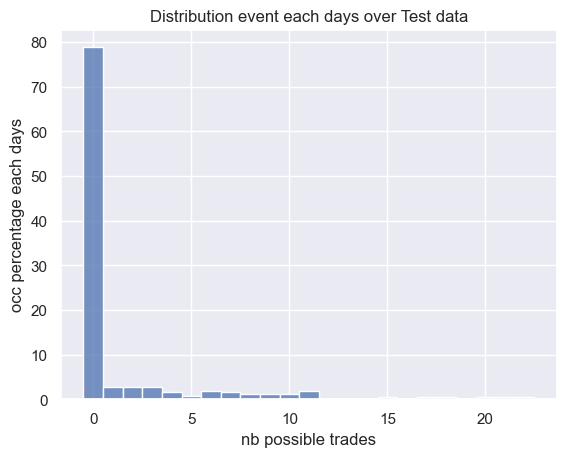

In [456]:
sns.histplot(df_combined_condition[~df_combined_condition["Train"]]["in_cluster_best"].resample("D").sum(), 
             discrete=True,
             stat="percent",
)#.hist()#value_counts(ascending=True)
# rename xlabel
ax = plt.gca()
ax.set_xlabel("nb possible trades")
ax.set_ylabel("occ percentage each days")
plt.title("Distribution event each days over Test data")
plt.show()
plt.show()

## Backtest

### Baseline

In [457]:
list_df[0]["Close_ETH_raw"]

date_ETH
2023-01-01 00:00:00    1194.540039
2023-01-01 00:05:00    1195.089966
2023-01-01 00:10:00    1195.000000
2023-01-01 00:15:00    1194.089966
2023-01-01 00:20:00    1194.890015
                          ...     
2025-05-30 19:15:00    2520.719971
2025-05-30 19:20:00    2524.370117
2025-05-30 19:25:00    2512.060059
2025-05-30 19:30:00    2509.129883
2025-05-30 19:35:00    2479.080078
Name: Close_ETH_raw, Length: 253677, dtype: float32

- BE CAREFUL : Hyperliquid for example can take 25% of trade if 0.1% is a trigger : 
  - maker fees : 0.015% (if trade out of orderbook (usually when limit order)
  - or taker fees : 0.038% (if market order)
  - funding 1h : 0.0014% ( funding rate will be positive, and the long position will pay the short position.)
  - TOTAL max 2 takers trades (open/close) + funding 1h max :  0.0774% => 77% of 0.1% !

- in 5 min candle : Close value at 8:00 ⇒ real value at 08:04:59.999

(TP*0.23) / (SL * 1.77) = Req == 2: 
- R = TP/SL
- R * 0.23 / 1.77 = Req
- R = 1.77/0.23 * Req

In [458]:
target_level

0.0045000000000000005

In [459]:
(0.45/100 - 0.0774 / 100 ) * 10000 * 10 


372.6

In [460]:
(-0.45/2/100 - 0.0774 / 100 ) * 10000 * 10


-302.40000000000003

In [461]:
(0.45/100 - 0.0774 / 100 ) / (0.45/2/100 + 0.0774 / 100 )


1.2321428571428572

In [462]:
target_level

0.0045000000000000005

In [463]:
R

2

In [464]:
# # 
# capital_init = 10000

# # strategy
# step_max = 60/5 # 1 hour
# tp_ratio = target_level #0.45/100 #0.1 / 100 #0.33/100
# risk_ratio = 2.5/100

# # trading platform
# ratio_fees = 0.0774 / 100 # hyperliquid

# # display
# print("target level for TP [-]: ", tp_ratio)
# print("R TP/SL [-]: ", R)
# print("r_fees %fees/%TP [-]: ", ratio_fees / tp_ratio)
# R_eq = (tp_ratio - ratio_fees) / ((tp_ratio / R) + ratio_fees)
# print("R_eq [-]: ", R_eq)



# # leverage calculation 
# #leverage = (capital_init * risk_ratio * R / tp_ratio) / capital_init
# leverage = risk_ratio /  (tp_ratio / R + ratio_fees * (1 - tp_ratio / (2 * R)))
# print('leverage [-]: ', leverage)

# # TP calculation
# fees_tp = ((1+tp_ratio) + 1) / 2 * leverage * capital_init * ratio_fees
# gain_tp = tp_ratio * leverage * capital_init - fees_tp
# # SL calculation
# fees_sl = (1 + 1-1/R*tp_ratio) / 2 * leverage * capital_init * ratio_fees
# gain_sl = -1/R*tp_ratio * leverage * capital_init - fees_sl

# # simulation: initialisation
# buy = list_df[0]["Close_ETH_raw"].values[0] # for first trade
# tp = False
# nb_tp = 0
# capital_tp = 0
# sl = False
# nb_sl = 0
# capital_sl = 0
# neutral = False
# nb_neutral = 0
# capital_neutral = 0
# capital = capital_init
# step = 0
# list_trade_gain = []
# list_trade_date = []
# list_trade_type = []
# list_trade_fees = []
# list_capital = []
# # simulation calculation
# for close, high, low, date_trade in zip(
#         list_df[0]["Close_ETH_raw"], 
#         list_df[0]["Close_ETH_raw"] * list_df[0]["High_ETH"], 
#         list_df[0]["Close_ETH_raw"] * list_df[0]["Low_ETH"],
#         list_df[0]["Close_ETH_raw"].index
#     ):
#     # NEUTRAL : if elasted time to take a trade is over (more than 1 hour) : we close the position
#     if step >= step_max:
#         nb_neutral += 1
#         fees = ( (buy + close) / 2 ) / buy * leverage * capital_init * ratio_fees
#         gain = ((close - buy) / buy) * leverage * capital_init - fees
#         list_trade_fees.append(fees)
#         list_trade_gain.append(gain)
#         list_trade_date.append(date_trade)
#         list_trade_type.append("Neutral")
#         capital += gain
#         list_capital.append(capital)
#         capital_neutral += gain
#         neutral = True
#         step = 0
#         continue
#     # if last time, we have close a position, we open a new one immediatly (5 min after)
#     if tp or sl or neutral:
#         buy = close
#         step = 0
#         tp = False
#         sl = False
#         neutral = False
#         continue # trade done at close
#     # TP : if max price is higher than TP, we take the trade and close position
#     if high >= (1+tp_ratio) * buy:
#         fees = fees_tp
#         gain = gain_tp - fees
#         list_trade_fees.append(fees)
#         list_trade_gain.append(gain)
#         list_trade_date.append(date_trade)
#         list_trade_type.append("TP")
#         capital += gain
#         list_capital.append(capital)
#         capital_tp += gain
#         tp = True
#         nb_tp += 1
#         continue
#     # SL : if min price is lower than SL, we take the trade and close position
#     elif low <= (1-1/R*tp_ratio) * buy: 
#         fees = fees_sl
#         gain = gain_sl - fees
#         list_trade_fees.append(fees)
#         list_trade_gain.append(gain)
#         list_trade_date.append(date_trade)
#         list_trade_type.append("SL")
#         capital +=  gain
#         list_capital.append(capital)
#         capital_sl +=  gain
#         sl = True
#         nb_sl += 1
#         continue
#     # no trade
#     else:
#         step += 1
# # results
# df_trades = pd.concat([
#     pd.Series(list_trade_type, index=list_trade_date, name="type"),
#     pd.Series(list_trade_gain, index=list_trade_date, name="gain"),
#     pd.Series(list_trade_fees, index=list_trade_date, name="fees"),
#     pd.Series(list_capital, index=list_trade_date, name="capital"),
#     ],
#     axis=1,
# )

# print("Capital init [$]", capital_init)
# print('final capital [$]:', capital)
# print("ratio gain final [-]: ", (capital - capital_init)/capital_init)
# print("Winrate [-] : ", nb_tp / (nb_tp + nb_sl))
# print("nb_tp: ", nb_tp)
# print("Gain for one TP [$]: ", gain_tp)
# print("Loss for one SL [$]: ", gain_sl)
# print('capital_tp [$]: ', capital_tp)
# print("nb_sl: ", nb_sl)
# print('capital_sl [$]: ', capital_sl)
# print('nb_neutral: ', nb_neutral)
# print('capital_neutral [$]', capital_neutral)

# # 1342565
# df_trades

target level for TP [-]:  0.0045000000000000005
R TP/SL [-]:  2
r_fees %fees/%TP [-]:  0.17199999999999996
R_eq [-]:  1.2321428571428572
leverage [-]:  8.269576962347871
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
Capital init [$] 10000
final capital [$]: -2306028.8
ratio gain final [-]:  -231.60287
Winrate [-] :  0.2911674975816653
nb_tp:  11739
capital_tp [$]:  3615382.184824417
nb_sl:  23931
capital_sl [$]:  -5982750.0
nb_neutral:  4647
capital_neutral [$] 51157.59


type           date_open          buy         sell  \
2023-01-01 01:15:00  Neutral 2023-01-01 00:00:00  1194.540039  1194.369995   
2023-01-01 02:40:00  Neutral 2023-01-01 01:20:00  1193.660034  1195.109985   
2023-01-01 04:05:00  Neutral 2023-01-01 02:45:00  1194.290039  1196.010010   
2023-01-01 05:30:00  Neutral 2023-01-01 04:10:00  1195.829956  1196.160034   
2023-01-01 06:55:00  Neutral 2023-01-01 05:35:00  1196.170044  1197.160034   
...                      ...                 ...          ...          ...   
2025-05-30 18:40:00       TP 2025-05-30 18:30:00  2515.500000  2526.819750   
2025-05-30 18:55:00       SL 2025-05-30 18:45:00  2531.729980  2526.033588   
2025-05-30 19:05:00       SL 2025-05-30 19:00:00  2519.899902  2514.230128   
2025-05-30 19:20:00       TP 2025-05-30 19:10:00  2516.340088  2527.663618   
2025-05-30 19:30:00       SL 2025-05-30 19:25:00  2512.060059  2506.407923   

                           gain       fees       capital  
2023-01-01 01:15:00  -75.773788  64.001968  9.924227e+03  
2023-01-01 02:40:00   36.406005  64.045400  9.960633e+03  
2023-01-01 04:05:00   55.042660  64.052616  1.001568e+04  
2023-01-01 05:30:00  -41.189318  64.015359  9.974486e+03  
2023-01-01 06:55:00    4.408765  64.033013  9.978896e+03  
...                         ...        ...           ...  
2025-05-30 18:40:00  307.980423  64.150540 -2.305587e+06  
2025-05-30 18:55:00 -250.000000  63.934518 -2.305837e+06  
2025-05-30 19:05:00 -250.000000  63.934518 -2.306087e+06  
2025-05-30 19:20:00  307.980423  64.150540 -2.305779e+06  
2025-05-30 19:30:00 -250.000000  63.934518 -2.306029e+06  

[40317 rows x 7 columns]

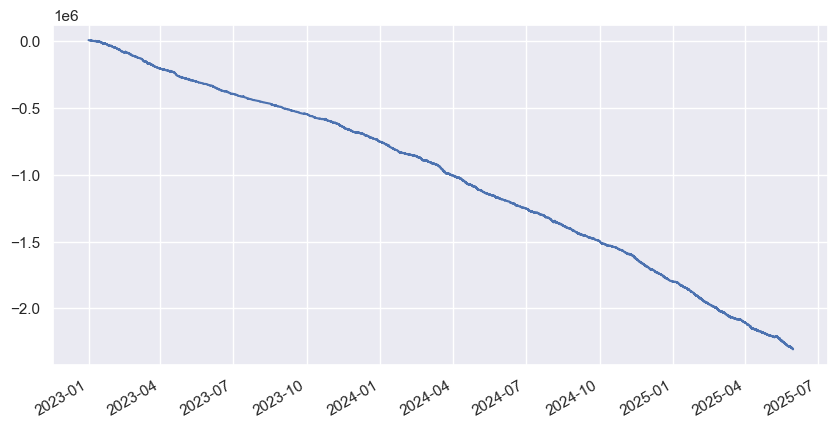

In [692]:
# 
capital_init = 10000
# strategy
step_max = FUTURE_TARGET # 1h15
tp_ratio = target_level #0.45/100 #0.1 / 100 #0.33/100
risk_ratio = 2.5/100

# trading platform
ratio_fees = 0.0774 / 100 # hyperliquid

# display
print("target level for TP [-]: ", tp_ratio)
print("R TP/SL [-]: ", R)
print("r_fees %fees/%TP [-]: ", ratio_fees / tp_ratio)
R_eq = (tp_ratio - ratio_fees) / ((tp_ratio / R) + ratio_fees)
print("R_eq [-]: ", R_eq)

def backtest(list_df, capital_init, step_max, 
             tp_ratio, risk_ratio, ratio_fees, R,
             trade_signal=None):
    # leverage calculation 
    #leverage = (capital_init * risk_ratio * R / tp_ratio) / capital_init
    leverage = risk_ratio /  (tp_ratio / R + ratio_fees * (1 - tp_ratio / (2 * R)))
    print('leverage [-]: ', leverage)

    # TP calculation
    fees_tp = ((1+tp_ratio) + 1) / 2 * leverage * capital_init * ratio_fees
    gain_tp = tp_ratio * leverage * capital_init - fees_tp
    # SL calculation
    fees_sl = (1 + 1-1/R*tp_ratio) / 2 * leverage * capital_init * ratio_fees
    gain_sl = -1/R*tp_ratio * leverage * capital_init - fees_sl
    print("Gain for one TP [$]: ", gain_tp)
    print("Loss for one SL [$]: ", gain_sl)
    # simulation: initialisation
    if trade_signal is None:
        buy = list_df[0]["Close_ETH_raw"].values[0] # for first trade
        list_buy = [buy]
        list_trade_date_open = [list_df[0]["Close_ETH_raw"].index[0]]
        neutral = False
    else:
        list_buy = []
        list_trade_date_open = []
        neutral = True
    tp = False
    nb_tp = 0
    capital_tp = 0
    sl = False
    nb_sl = 0
    capital_sl = 0
    
    nb_neutral = 0
    capital_neutral = 0
    capital = capital_init
    step = 0
    list_trade_gain = []
    list_trade_date = []
    list_trade_type = []
    list_trade_fees = []
    list_capital = []
    list_sell = []
    
    #list_buy.append(buy)
    # simulation calculation
    for close, high, low, date_trade in zip(
            list_df[0]["Close_ETH_raw"], 
            list_df[0]["Close_ETH_raw"] * list_df[0]["High_ETH"], 
            list_df[0]["Close_ETH_raw"] * list_df[0]["Low_ETH"],
            list_df[0]["Close_ETH_raw"].index
        ):
        
        # NEUTRAL : if elasted time to take a trade is over (more than 1 hour) : we close the position
        if step >= step_max:
            nb_neutral += 1
            fees = ( (buy + close) / 2 ) / buy * leverage * capital_init * ratio_fees
            gain = ((close - buy) / buy) * leverage * capital_init - fees
            list_trade_fees.append(fees)
            list_trade_gain.append(gain)
            list_trade_date.append(date_trade)
            list_sell.append(close)
            list_trade_type.append("Neutral")
            capital += gain
            list_capital.append(capital)
            capital_neutral += gain
            neutral = True
            step = 0
            continue

        # if trade_signal is not None:
        #     if trade_signal.at[date_trade] == True:
        #         print("Trade possible at ", date_trade)

        # if last time, we have close a position or no trade opened
        if tp or sl or neutral:
            if trade_signal is not None:
                try:
                    if trade_signal.at[date_trade] == True:
                        pass
                except:
                    print(date_trade, "is not in trade_signal")

            # if no signal used,  we open a new one immediatly (5 min after)
            if trade_signal is None:
                buy = close
                list_trade_date_open.append(date_trade)
                list_buy.append(buy)
                step = 0
                tp = False
                sl = False
                neutral = False
                continue # trade done at close
            # if trade signal is True
            elif np.any(trade_signal.at[date_trade]):
                #print("Trade opened at ", date_trade)
                buy = close
                list_trade_date_open.append(date_trade)
                list_buy.append(buy)
                step = 0
                tp = False
                sl = False
                neutral = False
                continue # trade done at close
            # if no trade signal => no trade opened
            else:
                tp = False
                sl = False
                neutral = True # to be able to check next time
                step = 0
                continue
        # TP : if max price is higher than TP, we take the trade and close position
        if high >= (1+tp_ratio) * buy:
            fees = fees_tp
            gain = gain_tp
            list_trade_fees.append(fees)
            list_trade_gain.append(gain)
            list_trade_date.append(date_trade)
            list_sell.append((1+tp_ratio)*buy)
            list_trade_type.append("TP")
            capital += gain
            list_capital.append(capital)
            capital_tp += gain
            tp = True
            nb_tp += 1
            continue
        # SL : if min price is lower than SL, we take the trade and close position
        elif low <= (1-1/R*tp_ratio) * buy: 
            fees = fees_sl
            gain = gain_sl
            list_trade_fees.append(fees)
            list_trade_gain.append(gain)
            list_trade_date.append(date_trade)
            list_sell.append((1-1/R*tp_ratio)*buy)
            list_trade_type.append("SL")
            capital +=  gain
            list_capital.append(capital)
            capital_sl +=  gain
            sl = True
            nb_sl += 1
            continue
        # no trade
        else:
            step += 1
    # results
    if trade_signal is not None:
        print("trade signal used, adding last buy & date_open")
        list_trade_date_open.append(list_df[0]["Close_ETH_raw"].index[-1])
        #list_buy.append(buy)
    if len(list_buy) > len(list_trade_date):
        list_buy = list_buy[:len(list_trade_date)]
    if len(list_trade_date_open) > len(list_trade_date):
        list_trade_date_open = list_trade_date_open[:len(list_trade_date)]
    df_trades = pd.concat([
        pd.Series(list_trade_type, index=list_trade_date, name="type"),
        pd.Series(list_trade_date_open, index=list_trade_date, name="date_open"),
        pd.Series(list_buy, index=list_trade_date, name="buy"),
        pd.Series(list_sell, index=list_trade_date, name="sell"),
        pd.Series(list_trade_gain, index=list_trade_date, name="gain"),
        pd.Series(list_trade_fees, index=list_trade_date, name="fees"),
        pd.Series(list_capital, index=list_trade_date, name="capital"),
        ],
        axis=1,
    )
    return df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral

df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral = (
    backtest(list_df, capital_init, step_max, tp_ratio, risk_ratio, ratio_fees, R)
)

print("Capital init [$]", capital_init)
print('final capital [$]:', capital)
print("ratio gain final [-]: ", (capital - capital_init)/capital_init)
print("Winrate [-] : ", nb_tp / (nb_tp + nb_sl + nb_neutral))
print("nb_tp: ", nb_tp)
print('capital_tp [$]: ', capital_tp)
print("nb_sl: ", nb_sl)
print('capital_sl [$]: ', capital_sl)
print('nb_neutral: ', nb_neutral)
print('capital_neutral [$]', capital_neutral)

# final capital [$]: -2306028.8 # baseline
df_trades["capital"].plot(kind="line", figsize=(10, 5))
df_trades

### Mdl best cluster

leverage [-]:  8.269576962347871
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open
Capital init [$] 10000
final capital [$]: 9116.393289460655
ratio gain final [-]:  -0.0883606710539345
Winrate [-] :  0.41580756013745707
nb_tp:  121
capital_tp [$]:  37265.631175048125
nb_sl:  156
capital_sl [$]:  -39000.0
nb_neutral:  14
capital_neutral [$] 850.7621144124566


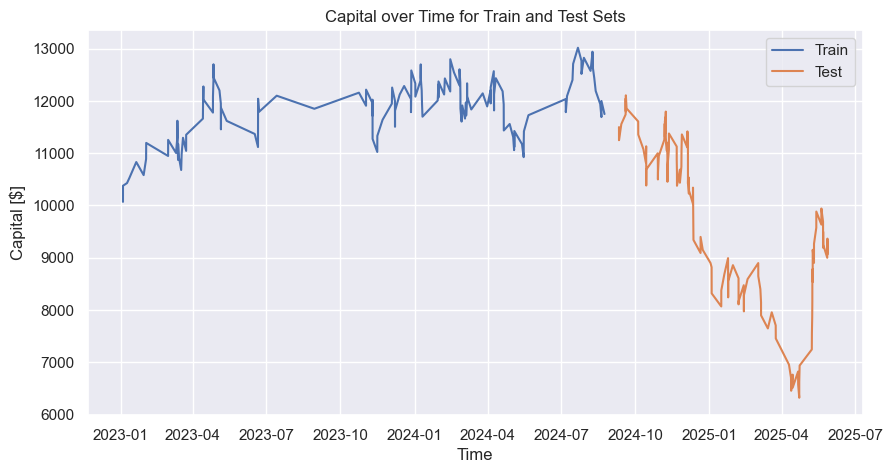

type           date_open          buy         sell  \
2023-01-04 01:45:00  Neutral 2023-01-04 00:25:00  1249.920044  1251.939941   
2023-01-04 02:25:00       TP 2023-01-04 01:50:00  1252.250000  1257.885125   
2023-01-09 01:50:00  Neutral 2023-01-09 00:30:00  1310.560059  1312.390015   
2023-01-11 22:20:00  Neutral 2023-01-11 21:00:00  1399.589966  1402.270020   
2023-01-20 13:45:00       TP 2023-01-20 13:30:00  1592.199951  1599.364851   
...                      ...                 ...          ...          ...   
2025-05-27 05:20:00       SL 2025-05-27 04:50:00  2635.020020  2629.091224   
2025-05-27 05:45:00       TP 2025-05-27 05:25:00  2635.830078  2647.691313   
2025-05-27 06:55:00       SL 2025-05-27 06:25:00  2643.899902  2637.951128   
2025-05-27 11:10:00       TP 2025-05-27 11:00:00  2670.360107  2682.376728   
2025-05-27 13:40:00       SL 2025-05-27 13:05:00  2679.370117  2673.341534   

                           gain       fees       capital  Train  
2023-01-04 01:45:00   69.579885  64.058244  10069.579885   True  
2023-01-04 02:25:00  307.980423  64.150540  10377.560308   True  
2023-01-09 01:50:00   51.418219  64.051212  10428.978526   True  
2023-01-11 22:20:00   94.285073  64.067808  10523.263600   True  
2023-01-20 13:45:00  307.980423  64.150540  10831.244023   True  
...                         ...        ...           ...    ...  
2025-05-27 05:20:00 -250.000000  63.934518   9000.432444  False  
2025-05-27 05:45:00  307.980423  64.150540   9308.412867  False  
2025-05-27 06:55:00 -250.000000  63.934518   9058.412867  False  
2025-05-27 11:10:00  307.980423  64.150540   9366.393289  False  
2025-05-27 13:40:00 -250.000000  63.934518   9116.393289  False  

[291 rows x 8 columns]

In [695]:
df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral = (
    backtest(list_df, capital_init, step_max, 
             tp_ratio, risk_ratio, ratio_fees, R,
             trade_signal=df_combined_condition["in_cluster_best"])
)

print("Capital init [$]", capital_init)
print('final capital [$]:', capital)
print("ratio gain final [-]: ", (capital - capital_init)/capital_init)
print("Winrate [-] : ", nb_tp / (nb_tp + nb_sl + nb_neutral))
print("nb_tp: ", nb_tp)
print('capital_tp [$]: ', capital_tp)
print("nb_sl: ", nb_sl)
print('capital_sl [$]: ', capital_sl)
print('nb_neutral: ', nb_neutral)
print('capital_neutral [$]', capital_neutral)


# add train test info from list_df[0]["Train"]
df_trades["Train"] = df_trades.index.isin(df_combined_condition[df_combined_condition['Train']].index)
# plot capital for train and test
plt.figure(figsize=(10, 5))
plt.plot(df_trades[df_trades["Train"]]["capital"], label="Train")
plt.plot(df_trades[~df_trades["Train"]]["capital"], label="Test")
plt.title("Capital over Time for Train and Test Sets")
plt.xlabel("Time")
plt.ylabel("Capital [$]")
plt.legend()
plt.grid(True)
plt.show()

#final capital [$]: 9116.393289460655
df_trades

<Axes: xlabel='type', ylabel='percent'>

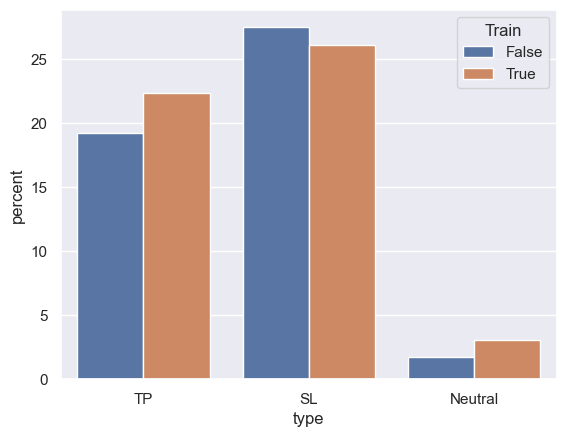

In [685]:
sns.countplot(df_trades, x="type", order=["TP", "SL", "Neutral"], hue="Train", stat="percent")

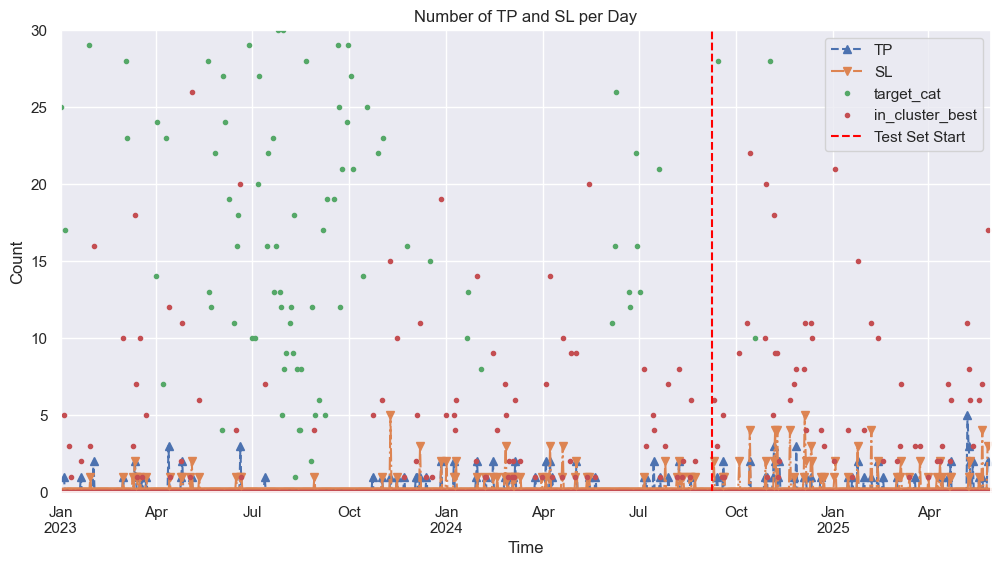

In [653]:
(df_trades["type"] == "TP").resample("D").sum().plot(figsize=(12, 6), linestyle='--', marker="^", label="TP")
(df_trades["type"] == "SL").resample("D").sum().plot(figsize=(12, 6), linestyle='-.', marker="v", label="SL")
(list_df[0]["target_cat"] == "high").resample("D").sum().plot(figsize=(12, 6), linestyle='', marker=".")
df_combined_condition["in_cluster_best"].resample("D").sum().plot(figsize=(12, 6), linestyle='', marker=".")
# add vertical line when test set starts
plt.axvline(x=list_df[0].index[df_combined_condition.shape[0] - nb_test], color='red', linestyle='--', label='Test Set Start')
# limit y axis
plt.ylim(0, 30)
plt.title("Number of TP and SL per Day")
plt.xlabel("Time")
plt.ylabel("Count")
plt.legend()
plt.grid(True)

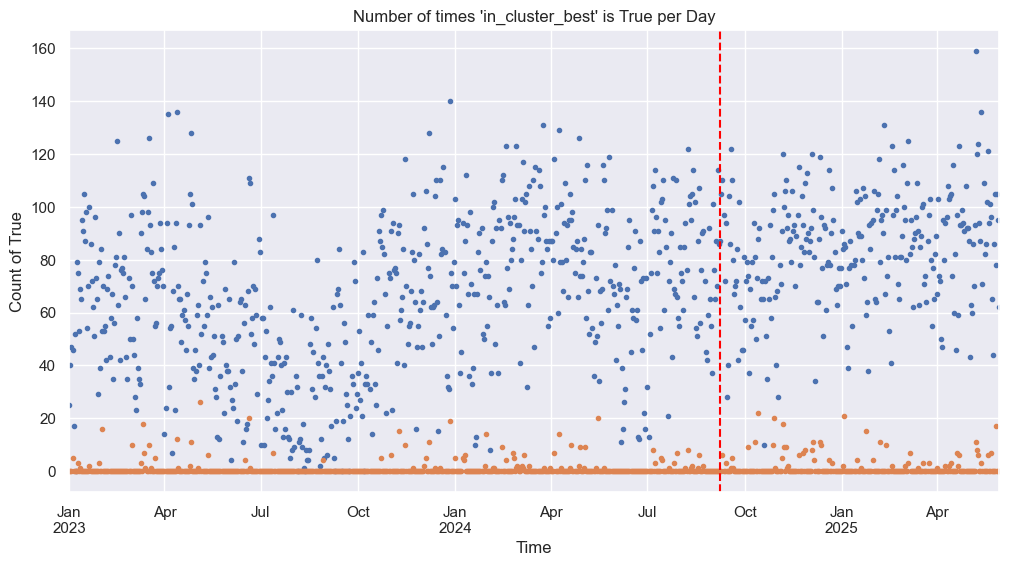

In [651]:
# by group sum every day
(list_df[0]["target_cat"] == "high").resample("D").sum().plot(figsize=(12, 6), linestyle='', marker=".")
df_combined_condition["in_cluster_best"].resample("D").sum().plot(figsize=(12, 6), linestyle='', marker=".")
# add vertical line when test set starts
plt.axvline(x=list_df[0].index[df_combined_condition.shape[0] - nb_test], color='red', linestyle='--', label='Test Set Start')
plt.title("Number of times 'in_cluster_best' is True per Day")
plt.xlabel("Time")
plt.ylabel("Count of True")
plt.grid(True)

In [607]:
# plot first trade with type TP
df_trades[df_trades["type"] == "TP"].head(2)

type           date_open          buy         sell  \
2023-01-04 02:25:00   TP 2023-01-04 01:50:00  1252.250000  1257.885125   
2023-01-20 13:45:00   TP 2023-01-20 13:30:00  1592.199951  1599.364851   

                           gain      fees       capital  Train  
2023-01-04 02:25:00  307.980423  64.15054  10377.560308   True  
2023-01-20 13:45:00  307.980423  64.15054  10831.244023   True

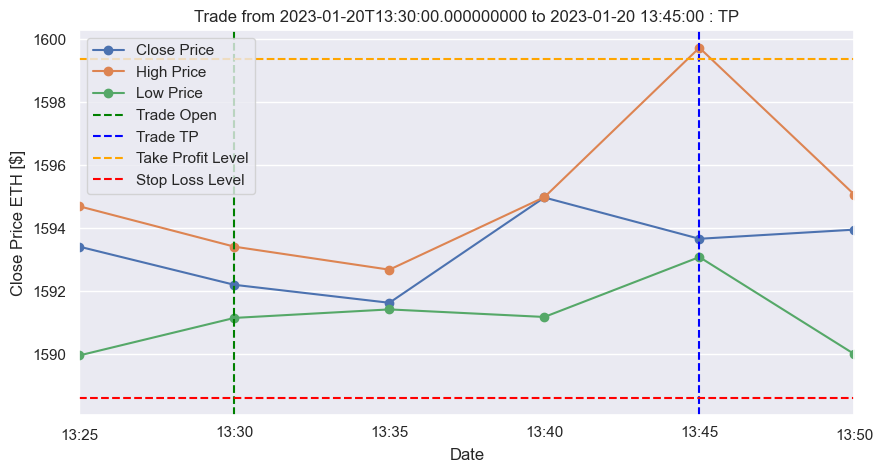

In [645]:
i_trade = 1
date_open = df_trades[df_trades["type"] == "TP"]["date_open"].values[i_trade]
date_tp = df_trades[df_trades["type"] == "TP"].index[i_trade]

list_df[0]["Close_ETH_raw"].loc[
    date_open - pd.Timedelta(minutes=5):date_tp + pd.Timedelta(minutes=5)
    ].plot(kind="line", figsize=(10,5), label="Close Price", marker="o")
(list_df[0]["Close_ETH_raw"]*list_df[0]["High_ETH"]).loc[date_open 
    - pd.Timedelta(minutes=5):date_tp + pd.Timedelta(minutes=5)].plot(
        kind="line", figsize=(10,5), label="High Price", marker="o"
    ) 
(list_df[0]["Close_ETH_raw"]*list_df[0]["Low_ETH"]).loc[date_open 
    - pd.Timedelta(minutes=5):date_tp + pd.Timedelta(minutes=5)].plot(
        kind="line", figsize=(10,5), label="Low Price", marker="o"
    )

plt.title(f"Trade from {date_open} to {date_tp} : TP")
plt.axvline(x=date_open, color='green', linestyle='--', label='Trade Open')
plt.axvline(x=date_tp, color='blue', linestyle='--', label='Trade TP')
# plot target_level line
price_open = list_df[0]["Close_ETH_raw"].loc[date_open]
plt.axhline(y=price_open * (1 + target_level), color='orange', linestyle='--', label='Take Profit Level')
# plot SL line
plt.axhline(y=price_open * (1 - 1/R * target_level), color='red', linestyle='--', label='Stop Loss Level')
plt.xlabel("Date")
plt.ylabel("Close Price ETH [$]")
plt.legend()
plt.show()

### Best Mdl ML

In [ ]:
# leverage [-]:  8.269576962347871
# Gain for one TP [$]:  307.9804229342824
# Loss for one SL [$]:  -250.0
# 2024-12-12 13:00:00 is not in trade_signal
# 2024-12-12 13:00:00 is not in trade_signal
# trade signal used, adding last buy & date_open
# Capital init [$] 10000
# final capital [$]: -358.2319261540101
# ratio gain final [-]:  -1.0358231926154011
# Winrate [-] :  0.3852040816326531
# nb_tp:  151
# capital_tp [$]:  46505.04386307666
# nb_sl:  228
# capital_sl [$]:  -57000.0
# nb_neutral:  13
# capital_neutral [$] 136.72421076932784

leverage [-]:  8.269576962347871
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open
Capital init [$] 10000
final capital [$]: -358.2319261540101
ratio gain final [-]:  -1.0358231926154011
Winrate [-] :  0.3852040816326531
nb_tp:  151
capital_tp [$]:  46505.04386307666
nb_sl:  228
capital_sl [$]:  -57000.0
nb_neutral:  13
capital_neutral [$] 136.72421076932784


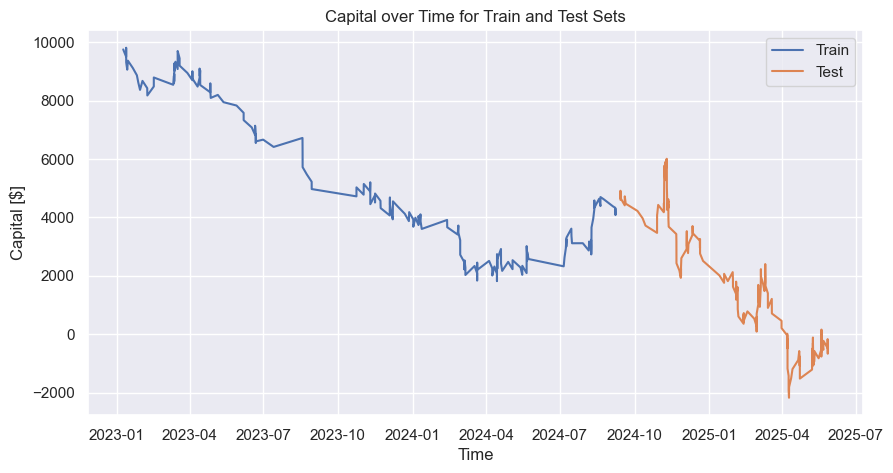

type           date_open          buy         sell  \
2023-01-09 00:15:00   SL 2023-01-08 23:45:00  1310.609985  1307.661113   
2023-01-12 14:50:00   SL 2023-01-12 14:25:00  1429.729980  1426.513088   
2023-01-12 15:05:00   TP 2023-01-12 14:55:00  1431.040039  1437.479719   
2023-01-12 15:15:00   SL 2023-01-12 15:10:00  1429.109985  1425.894488   
2023-01-12 16:10:00   SL 2023-01-12 15:40:00  1428.069946  1424.856789   
...                  ...                 ...          ...          ...   
2025-05-27 06:45:00   SL 2025-05-27 06:35:00  2646.090088  2640.136385   
2025-05-27 07:10:00   TP 2025-05-27 06:55:00  2642.780029  2654.672539   
2025-05-27 10:30:00   SL 2025-05-27 10:20:00  2677.389893  2671.365765   
2025-05-27 11:00:00   SL 2025-05-27 10:40:00  2675.010010  2668.991237   
2025-05-27 11:10:00   TP 2025-05-27 11:05:00  2679.010010  2691.065555   

                           gain       fees      capital  Train  
2023-01-09 00:15:00 -250.000000  63.934518  9750.000000   True  
2023-01-12 14:50:00 -250.000000  63.934518  9500.000000   True  
2023-01-12 15:05:00  307.980423  64.150540  9807.980423   True  
2023-01-12 15:15:00 -250.000000  63.934518  9557.980423   True  
2023-01-12 16:10:00 -250.000000  63.934518  9307.980423   True  
...                         ...        ...          ...    ...  
2025-05-27 06:45:00 -250.000000  63.934518  -474.192772  False  
2025-05-27 07:10:00  307.980423  64.150540  -166.212349  False  
2025-05-27 10:30:00 -250.000000  63.934518  -416.212349  False  
2025-05-27 11:00:00 -250.000000  63.934518  -666.212349  False  
2025-05-27 11:10:00  307.980423  64.150540  -358.231926  False  

[392 rows x 8 columns]

In [ ]:
trade_signal_sgdc = pd.Series(
    np.concatenate((arr_sgdc_pred_train, arr_sgdc_pred), axis=0), 
    index=list_df[0].index,
    name="sgdc_pred"
)
# trade_signal_sgdc = pd.Series(
#     np.concatenate((arr_sgdc_prob_pred_train, arr_sgdc_prob_pred_test), axis=0), 
#     index=list_df[0].index,
#     name="sgdc_pred"
# )

df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral = (
    backtest(list_df, capital_init, step_max, 
             tp_ratio, risk_ratio, ratio_fees, R,
             trade_signal=trade_signal_sgdc)
)

print("Capital init [$]", capital_init)
print('final capital [$]:', capital)
print("ratio gain final [-]: ", (capital - capital_init)/capital_init)
print("Winrate [-] : ", nb_tp / (nb_tp + nb_sl + nb_neutral))
print("nb_tp: ", nb_tp)
print('capital_tp [$]: ', capital_tp)
print("nb_sl: ", nb_sl)
print('capital_sl [$]: ', capital_sl)
print('nb_neutral: ', nb_neutral)
print('capital_neutral [$]', capital_neutral)

# -129832.82
# add train test info from list_df[0]["Train"]
df_trades["Train"] = df_trades.index.isin(df_combined_condition[df_combined_condition['Train']].index)
# plot capital for train and test
plt.figure(figsize=(10, 5))
plt.plot(df_trades[df_trades["Train"]]["capital"], label="Train")
plt.plot(df_trades[~df_trades["Train"]]["capital"], label="Test")
plt.title("Capital over Time for Train and Test Sets")
plt.xlabel("Time")
plt.ylabel("Capital [$]")
plt.legend()
plt.grid(True)
plt.show()

#df_trades["capital"].plot(kind="line", figsize=(10, 5))
df_trades

<Axes: xlabel='type', ylabel='percent'>

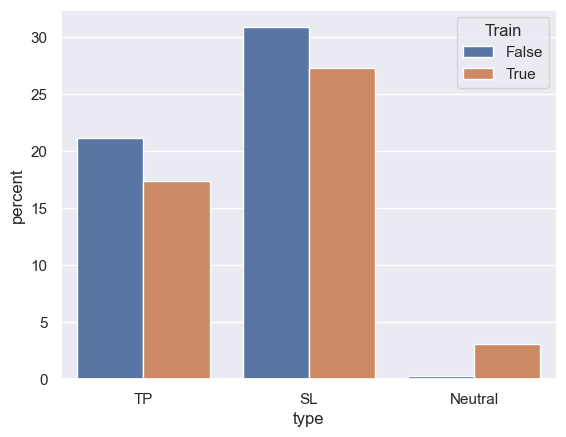

In [887]:
sns.countplot(df_trades, x="type", order=["TP", "SL", "Neutral"], hue="Train", stat="percent")

In [888]:
print("Winrate TRAIN: ", (df_trades.loc[df_trades["Train"] == True,"type"] == "TP").sum() / df_trades["Train"].sum())
print("Winrate TEST: ", (df_trades.loc[df_trades["Train"] == False,"type"] == "TP").sum() / (~df_trades["Train"]).sum())

Winrate TRAIN:  0.36363636363636365
Winrate TEST:  0.40487804878048783


#### Nb TP & SP per Day

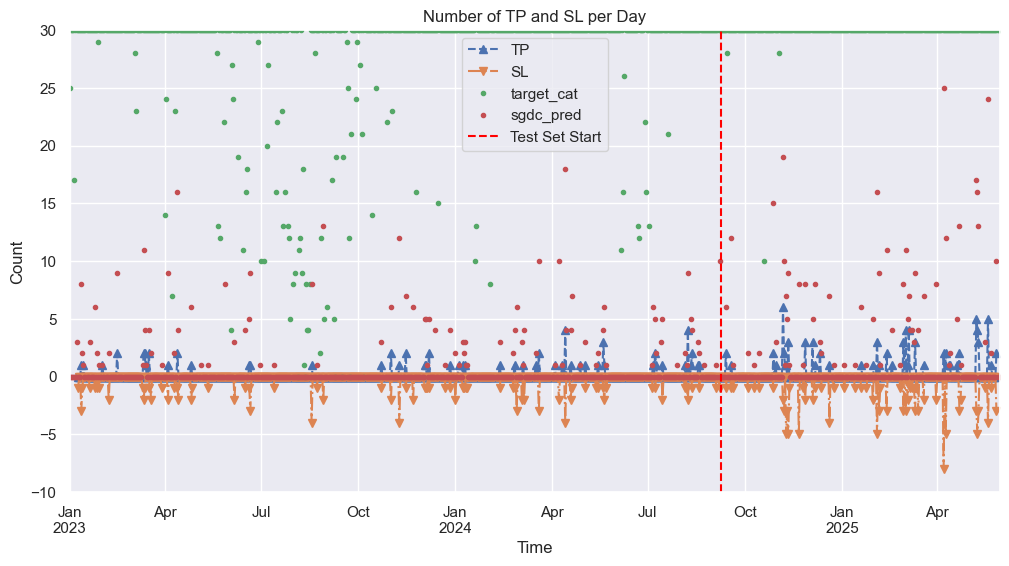

In [889]:

(df_trades["type"] == "TP").resample("D").sum().plot(figsize=(12, 6), linestyle='--', marker="^", label="TP")
((df_trades["type"] == "SL").resample("D").sum()*-1).plot(figsize=(12, 6), linestyle='-.', marker="v", label="SL")
(np.clip((list_df[0]["target_cat"] == "high").resample("D").sum(),0,30)).plot(figsize=(12, 6), linestyle='', marker=".")
trade_signal_sgdc.resample("D").sum().plot(figsize=(12, 6), linestyle='', marker=".")
# limit y axis
plt.ylim(-10, 30)
plt.title("Number of TP and SL per Day")
plt.xlabel("Time")
plt.ylabel("Count")
# add vertical line when test set starts
plt.axvline(x=list_df[0].index[df_combined_condition.shape[0] - nb_test], color='red', linestyle='--', label='Test Set Start')
plt.legend()
plt.grid(True)

#### Worst Day : nb max SL in one Day

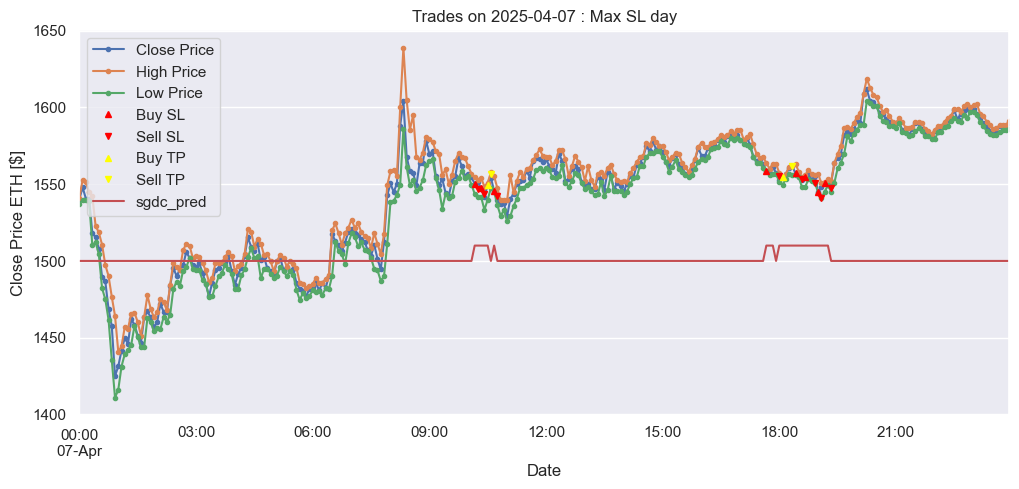

type           date_open          buy         sell  \
2025-04-07 10:15:00   SL 2025-04-07 10:10:00  1550.339966  1546.851701   
2025-04-07 10:25:00   SL 2025-04-07 10:20:00  1547.270020  1543.788662   
2025-04-07 10:35:00   TP 2025-04-07 10:30:00  1549.589966  1556.563121   
2025-04-07 10:45:00   SL 2025-04-07 10:40:00  1545.479980  1542.002651   
2025-04-07 18:00:00   SL 2025-04-07 17:40:00  1558.540039  1555.033324   
2025-04-07 18:20:00   TP 2025-04-07 18:05:00  1554.719971  1561.716211   
2025-04-07 18:35:00   SL 2025-04-07 18:25:00  1556.979980  1553.476776   
2025-04-07 18:55:00   SL 2025-04-07 18:40:00  1554.579956  1551.082151   
2025-04-07 19:05:00   SL 2025-04-07 19:00:00  1544.729980  1541.254338   
2025-04-07 19:20:00   SL 2025-04-07 19:10:00  1551.010010  1547.520237   

                           gain       fees      capital  Train  
2025-04-07 10:15:00 -250.000000  63.934518   -39.664191  False  
2025-04-07 10:25:00 -250.000000  63.934518  -289.664191  False  
2025-04-07 10:35:00  307.980423  64.150540    18.316232  False  
2025-04-07 10:45:00 -250.000000  63.934518  -231.683768  False  
2025-04-07 18:00:00 -250.000000  63.934518  -481.683768  False  
2025-04-07 18:20:00  307.980423  64.150540  -173.703345  False  
2025-04-07 18:35:00 -250.000000  63.934518  -423.703345  False  
2025-04-07 18:55:00 -250.000000  63.934518  -673.703345  False  
2025-04-07 19:05:00 -250.000000  63.934518  -923.703345  False  
2025-04-07 19:20:00 -250.000000  63.934518 -1173.703345  False

In [ ]:
# index day with max SL
i_day_sl_max = np.argmax((df_trades["type"] == "SL").resample("D").sum())
#(df_trades["type"] == "SL").resample("D").sum()[i_day_sl_max]
date_max_sl = (df_trades["type"] == "SL").resample("D").sum().idxmax()

fig = plt.figure(figsize=(12,5))
ax = fig.gca()
b_df_sl =  list_df[0].index.date == date_max_sl.date()
# Create the plot and get the axes object
list_df[0]["Close_ETH_raw"].loc[b_df_sl].plot(kind="line", ax=ax, label="Close Price", marker=".")

# Plot other lines on the same axes
(list_df[0]["Close_ETH_raw"] * list_df[0]["High_ETH"]).loc[b_df_sl].plot(ax=ax, kind="line", label="High Price", marker=".")

(list_df[0]["Close_ETH_raw"] * list_df[0]["Low_ETH"]).loc[b_df_sl].plot(ax=ax, kind="line", label="Low Price", marker=".")

# Get buy & sell points for SL trades on that day
df_trades_sl_max = df_trades.copy().loc[df_trades.index.date == date_max_sl.date()]

# Add annotations for each trade
b_trades_sl = df_trades_sl_max["type"] == "SL"
b_trades_tp = df_trades_sl_max["type"] == "TP"

ser_buy_sl = pd.Series(df_trades_sl_max.loc[b_trades_sl, "buy"].values, index=df_trades_sl_max.loc[b_trades_sl, "date_open"])
ser_buy_sl.plot(ax=ax,  color="red", marker="^", label="Buy SL", linestyle='', markersize=5)
ser_sell_sl = df_trades_sl_max.loc[b_trades_sl,"sell"]
ser_sell_sl.plot(ax=ax,  color="red", marker="v", label="Sell SL", linestyle='',  markersize=5)

ser_buy_tp = pd.Series(df_trades_sl_max.loc[b_trades_tp, "buy"].values, index=df_trades_sl_max.loc[b_trades_tp, "date_open"])
ser_buy_tp.plot(ax=ax,  color="yellow", marker="^", label="Buy TP", linestyle='', markersize=5)
ser_sell_tp = df_trades_sl_max.loc[b_trades_tp,"sell"]
ser_sell_tp.plot(ax=ax,  color="yellow", marker="v", label="Sell TP", linestyle='',  markersize=5)
# signal trade high
(trade_signal_sgdc.loc[trade_signal_sgdc.index.date == date_max_sl.date()]*10+1500).plot()
""" for idx, row in df_trades_sl_max.iterrows():
    ser_buy = pd.Series(row["buy"], index=[row["date_open"]])
    ser_buy.plot(ax=ax, kind="scatter", color="green", marker="^", s=50, label="Buy SL" if "Buy SL" not in plt.gca().get_legend_handles_labels()[1] else "")
    ser_sell = pd.Series(row["sell"], index=[idx])
    ser_sell.plot(ax=ax, kind="scatter", color="red", marker="v", s=50, label="Sell SL" if "Sell SL" not in plt.gca().get_legend_handles_labels()[1] else "")
    #plt.scatter(row["date_open"], row["buy"],  color="green", marker="^", s=10, label="Buy SL" if "Buy SL" not in plt.gca().get_legend_handles_labels()[1] else "")
    #plt.scatter(idx, row["sell"], color="red",  marker="v", s=10, label="Sell SL" if "Sell SL" not in plt.gca().get_legend_handles_labels()[1] else "")
 """
# Set plot titles and labels
plt.title(f"Trades on {date_max_sl.date()} : Max SL day")
plt.xlabel("Date")
plt.ylabel("Close Price ETH [$]")
plt.legend()
plt.grid(True) # Adding a grid can help with readability
plt.show()

# Display the dataframe
df_trades_sl_max


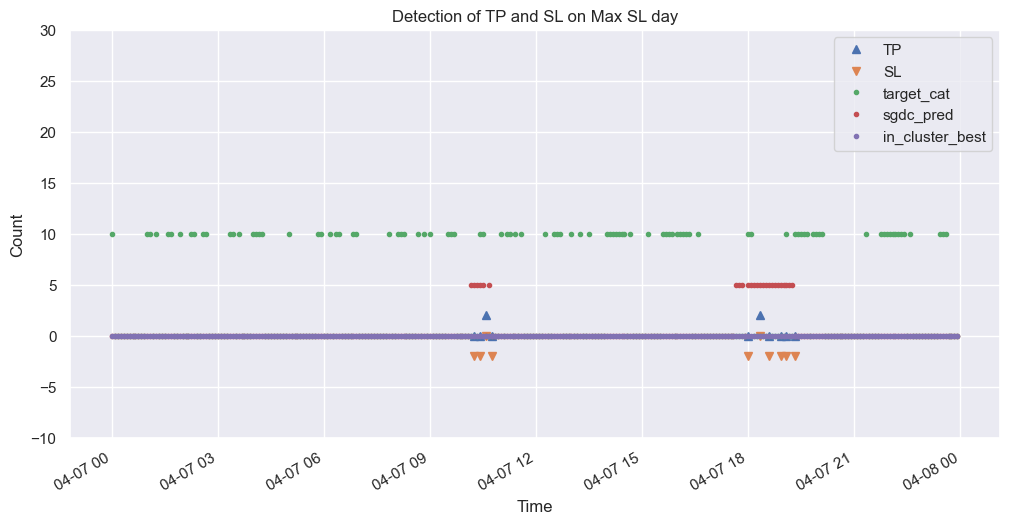

In [893]:
((df_trades_sl_max["type"] == "TP")*2).plot(figsize=(12, 6), linestyle='', marker="^", label="TP")
((df_trades_sl_max["type"] == "SL")*-2).plot(figsize=(12, 6), linestyle='', marker="v", label="SL")
((list_df[0].loc[b_df_sl, "target_cat"] == "high")*10).plot(figsize=(12, 6), linestyle='', marker=".")
(trade_signal_sgdc.loc[b_df_sl]*5).plot(figsize=(12, 6), linestyle='', marker=".")
(df_combined_condition["in_cluster_best"].loc[b_df_sl]*7).plot(figsize=(12, 6), linestyle='', marker=".")
# limit y axis
plt.ylim(-10, 30)
plt.title("Detection of TP and SL on Max SL day")
plt.xlabel("Time")
plt.ylabel("Count")
plt.legend()
plt.grid(True)

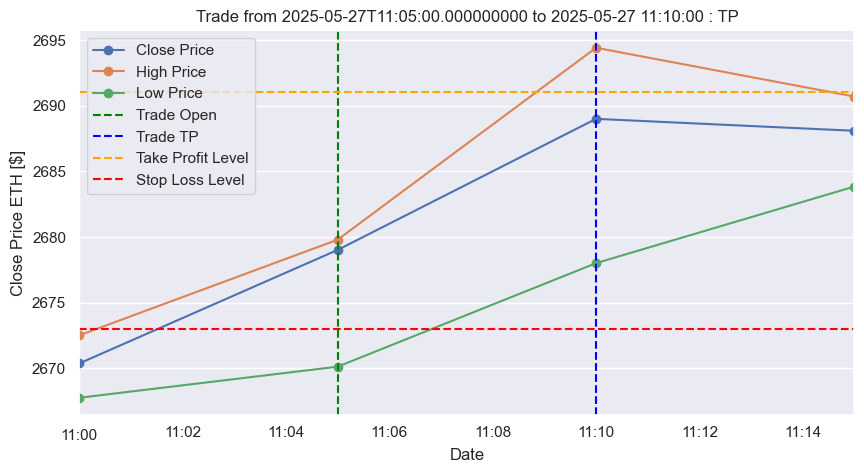

In [894]:
i_trade = -1
date_open = df_trades[df_trades["type"] == "TP"]["date_open"].values[i_trade]
date_tp = df_trades[df_trades["type"] == "TP"].index[i_trade]

list_df[0]["Close_ETH_raw"].loc[
    date_open - pd.Timedelta(minutes=5):date_tp + pd.Timedelta(minutes=5)
    ].plot(kind="line", figsize=(10,5), label="Close Price", marker="o")
(list_df[0]["Close_ETH_raw"]*list_df[0]["High_ETH"]).loc[date_open 
    - pd.Timedelta(minutes=5):date_tp + pd.Timedelta(minutes=5)].plot(
        kind="line", figsize=(10,5), label="High Price", marker="o"
    ) 
(list_df[0]["Close_ETH_raw"]*list_df[0]["Low_ETH"]).loc[date_open 
    - pd.Timedelta(minutes=5):date_tp + pd.Timedelta(minutes=5)].plot(
        kind="line", figsize=(10,5), label="Low Price", marker="o"
    )

plt.title(f"Trade from {date_open} to {date_tp} : TP")
plt.axvline(x=date_open, color='green', linestyle='--', label='Trade Open')
plt.axvline(x=date_tp, color='blue', linestyle='--', label='Trade TP')
# plot target_level line
price_open = list_df[0]["Close_ETH_raw"].loc[date_open]
plt.axhline(y=price_open * (1 + target_level), color='orange', linestyle='--', label='Take Profit Level')
# plot SL line
plt.axhline(y=price_open * (1 - 1/R * target_level), color='red', linestyle='--', label='Stop Loss Level')
plt.xlabel("Date")
plt.ylabel("Close Price ETH [$]")
plt.legend()
plt.show()

#### XGBoost best winrate

leverage [-]:  8.269576962347871
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open
Capital init [$] 10000
final capital [$]: 9957.073849105256
ratio gain final [-]:  -0.004292615089474384
Winrate [-] :  0.4473684210526316
nb_tp:  34
capital_tp [$]:  10471.334379765607
nb_sl:  40
capital_sl [$]:  -10000.0
nb_neutral:  2
capital_neutral [$] -514.2605306603521


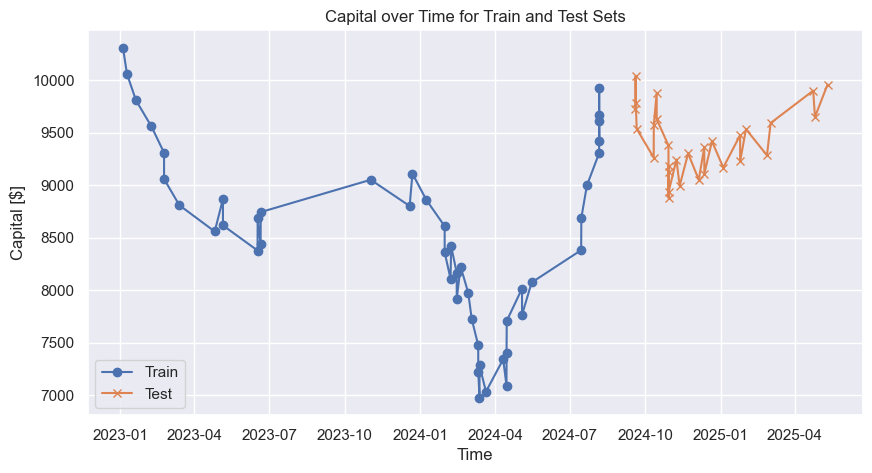

type           date_open          buy         sell  \
2023-01-04 02:25:00   TP 2023-01-04 02:05:00  1253.229980  1258.869515   
2023-01-09 00:00:00   SL 2023-01-08 23:25:00  1312.219971  1309.267476   
2023-01-19 20:50:00   SL 2023-01-19 20:30:00  1558.939941  1555.432327   
2023-02-07 18:10:00   SL 2023-02-07 17:45:00  1673.420044  1669.654849   
2023-02-23 02:30:00   SL 2023-02-23 02:15:00  1671.339966  1667.579451   
...                  ...                 ...          ...          ...   
2025-02-25 23:25:00   SL 2025-02-25 22:15:00  2490.620117  2485.016222   
2025-03-02 10:30:00   TP 2025-03-02 10:25:00  2253.110107  2263.249103   
2025-04-23 05:00:00   TP 2025-04-23 04:30:00  1795.790039  1803.871094   
2025-04-25 08:55:00   SL 2025-04-25 08:50:00  1802.400024  1798.344624   
2025-05-10 15:50:00   TP 2025-05-10 15:30:00  2506.550049  2517.829524   

                           gain       fees       capital  Train  
2023-01-04 02:25:00  307.980423  64.150540  10307.980423   True  
2023-01-09 00:00:00 -250.000000  63.934518  10057.980423   True  
2023-01-19 20:50:00 -250.000000  63.934518   9807.980423   True  
2023-02-07 18:10:00 -250.000000  63.934518   9557.980423   True  
2023-02-23 02:30:00 -250.000000  63.934518   9307.980423   True  
...                         ...        ...           ...    ...  
2025-02-25 23:25:00 -250.000000  63.934518   9283.132580  False  
2025-03-02 10:30:00  307.980423  64.150540   9591.113003  False  
2025-04-23 05:00:00  307.980423  64.150540   9899.093426  False  
2025-04-25 08:55:00 -250.000000  63.934518   9649.093426  False  
2025-05-10 15:50:00  307.980423  64.150540   9957.073849  False  

[76 rows x 8 columns]

In [917]:
trade_signal_xgb = pd.Series(
    np.concatenate((arr_xgb_pred_train, arr_xgb_pred), axis=0), 
    index=list_df[0].index,
    name="xgb_pred"
)
df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral = (
    backtest(list_df, capital_init, step_max, 
             tp_ratio, risk_ratio, ratio_fees, R,
             trade_signal=trade_signal_xgb)
)

print("Capital init [$]", capital_init)
print('final capital [$]:', capital)
print("ratio gain final [-]: ", (capital - capital_init)/capital_init)
print("Winrate [-] : ", nb_tp / (nb_tp + nb_sl + nb_neutral))
print("nb_tp: ", nb_tp)
print('capital_tp [$]: ', capital_tp)
print("nb_sl: ", nb_sl)
print('capital_sl [$]: ', capital_sl)
print('nb_neutral: ', nb_neutral)
print('capital_neutral [$]', capital_neutral)

# -129832.82
# add train test info from list_df[0]["Train"]
df_trades["Train"] = df_trades.index.isin(df_combined_condition[df_combined_condition['Train']].index)
# plot capital for train and test
plt.figure(figsize=(10, 5))
plt.plot(df_trades[df_trades["Train"]]["capital"], label="Train", marker="o")
plt.plot(df_trades[~df_trades["Train"]]["capital"], label="Test", marker="x")
plt.title("Capital over Time for Train and Test Sets")
plt.xlabel("Time")
plt.ylabel("Capital [$]")
plt.legend()
plt.grid(True)
plt.show()

#df_trades["capital"].plot(kind="line", figsize=(10, 5))
df_trades

In [918]:
print("Winrate TRAIN: ", (df_trades.loc[df_trades["Train"] == True,"type"] == "TP").sum() / df_trades["Train"].sum())
print("Winrate TEST: ", (df_trades.loc[df_trades["Train"] == False,"type"] == "TP").sum() / (~df_trades["Train"]).sum())

Winrate TRAIN:  0.425531914893617
Winrate TEST:  0.4827586206896552


<Axes: xlabel='type', ylabel='percent'>

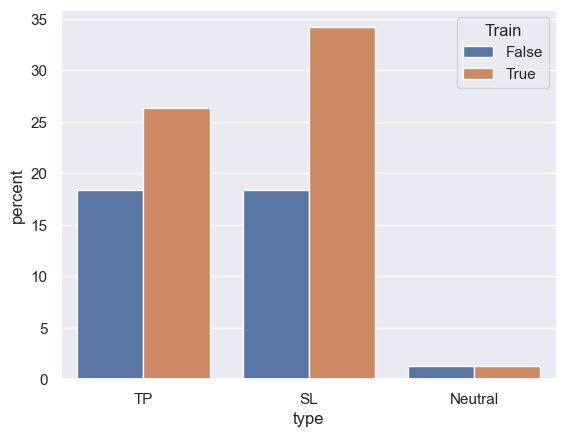

In [919]:
sns.countplot(df_trades, x="type", order=["TP", "SL", "Neutral"], hue="Train", stat="percent")

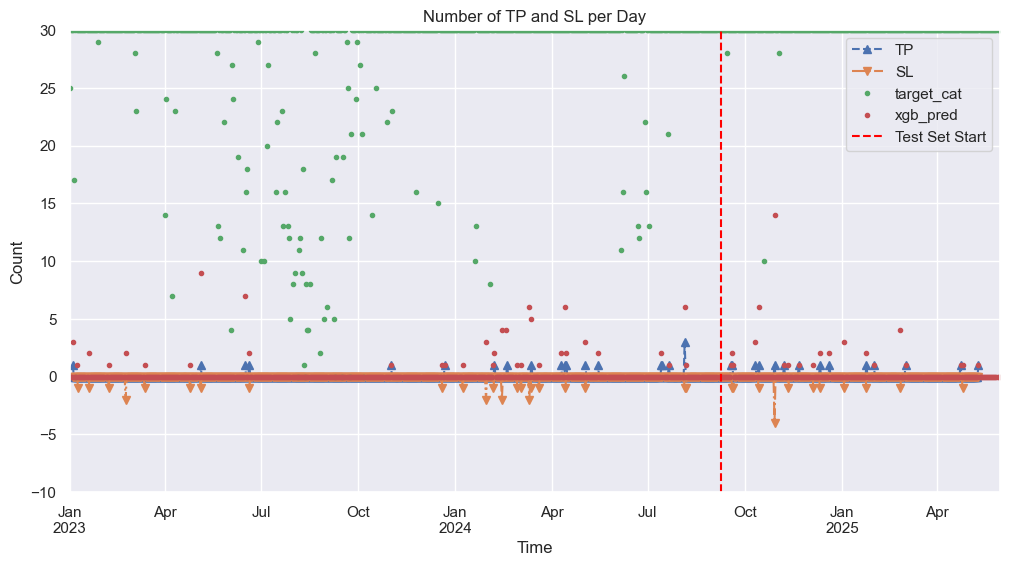

In [920]:

(df_trades["type"] == "TP").resample("D").sum().plot(figsize=(12, 6), linestyle='--', marker="^", label="TP")
((df_trades["type"] == "SL").resample("D").sum()*-1).plot(figsize=(12, 6), linestyle='-.', marker="v", label="SL")
(np.clip((list_df[0]["target_cat"] == "high").resample("D").sum(),0,30)).plot(figsize=(12, 6), linestyle='', marker=".")
trade_signal_xgb.resample("D").sum().plot(figsize=(12, 6), linestyle='', marker=".")
# limit y axis
plt.ylim(-10, 30)
plt.title("Number of TP and SL per Day")
plt.xlabel("Time")
plt.ylabel("Count")
# add vertical line when test set starts
plt.axvline(x=list_df[0].index[df_combined_condition.shape[0] - nb_test], color='red', linestyle='--', label='Test Set Start')
plt.legend()
plt.grid(True)

664
2024-10-29 00:00:00


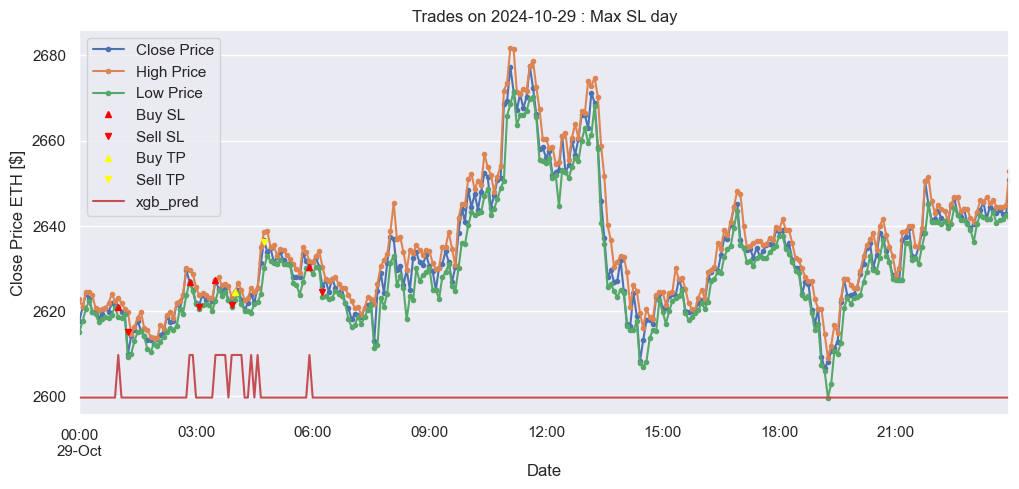

type           date_open          buy         sell  \
2024-10-29 01:15:00   SL 2024-10-29 01:00:00  2620.899902  2615.002878   
2024-10-29 03:05:00   SL 2024-10-29 02:50:00  2626.840088  2620.929698   
2024-10-29 03:55:00   SL 2024-10-29 03:30:00  2627.189941  2621.278764   
2024-10-29 04:45:00   TP 2024-10-29 04:00:00  2624.389893  2636.199647   
2024-10-29 06:15:00   SL 2024-10-29 05:55:00  2630.320068  2624.401848   

                           gain       fees      capital  Train  
2024-10-29 01:15:00 -250.000000  63.934518  9377.269620  False  
2024-10-29 03:05:00 -250.000000  63.934518  9127.269620  False  
2024-10-29 03:55:00 -250.000000  63.934518  8877.269620  False  
2024-10-29 04:45:00  307.980423  64.150540  9185.250043  False  
2024-10-29 06:15:00 -250.000000  63.934518  8935.250043  False

In [921]:
# index day with max SL
i_day_sl_max = np.argmax((df_trades["type"] == "SL").resample("D").sum())
print(i_day_sl_max)
#(df_trades["type"] == "SL").resample("D").sum()[i_day_sl_max]
date_max_sl = (df_trades["type"] == "SL").resample("D").sum().idxmax()
print(date_max_sl)
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
b_df_sl =  list_df[0].index.date == date_max_sl.date()
# Create the plot and get the axes object
list_df[0]["Close_ETH_raw"].loc[b_df_sl].plot(kind="line", ax=ax, label="Close Price", marker=".")

# Plot other lines on the same axes
(list_df[0]["Close_ETH_raw"] * list_df[0]["High_ETH"]).loc[b_df_sl].plot(ax=ax, kind="line", label="High Price", marker=".")

(list_df[0]["Close_ETH_raw"] * list_df[0]["Low_ETH"]).loc[b_df_sl].plot(ax=ax, kind="line", label="Low Price", marker=".")

# Get buy & sell points for SL trades on that day
df_trades_sl_max = df_trades.copy().loc[df_trades.index.date == date_max_sl.date()]

# Add annotations for each trade
b_trades_sl = df_trades_sl_max["type"] == "SL"
b_trades_tp = df_trades_sl_max["type"] == "TP"

ser_buy_sl = pd.Series(df_trades_sl_max.loc[b_trades_sl, "buy"].values, index=df_trades_sl_max.loc[b_trades_sl, "date_open"])
ser_buy_sl.plot(ax=ax,  color="red", marker="^", label="Buy SL", linestyle='', markersize=5)
ser_sell_sl = df_trades_sl_max.loc[b_trades_sl,"sell"]
ser_sell_sl.plot(ax=ax,  color="red", marker="v", label="Sell SL", linestyle='',  markersize=5)

if np.any(b_trades_tp):
    ser_buy_tp = pd.Series(df_trades_sl_max.loc[b_trades_tp, "buy"].values, index=df_trades_sl_max.loc[b_trades_tp, "date_open"])
    ser_buy_tp.plot(ax=ax,  color="yellow", marker="^", label="Buy TP", linestyle='', markersize=5)
    ser_sell_tp = df_trades_sl_max.loc[b_trades_tp,"sell"]
    ser_sell_tp.plot(ax=ax,  color="yellow", marker="v", label="Sell TP", linestyle='',  markersize=5)
# signal trade high
price_min = ((list_df[0]["Close_ETH_raw"] * list_df[0]["Low_ETH"]).loc[b_df_sl]).min()
(trade_signal_xgb.loc[trade_signal_xgb.index.date == date_max_sl.date()]*10+price_min).plot()
""" for idx, row in df_trades_sl_max.iterrows():
    ser_buy = pd.Series(row["buy"], index=[row["date_open"]])
    ser_buy.plot(ax=ax, kind="scatter", color="green", marker="^", s=50, label="Buy SL" if "Buy SL" not in plt.gca().get_legend_handles_labels()[1] else "")
    ser_sell = pd.Series(row["sell"], index=[idx])
    ser_sell.plot(ax=ax, kind="scatter", color="red", marker="v", s=50, label="Sell SL" if "Sell SL" not in plt.gca().get_legend_handles_labels()[1] else "")
    #plt.scatter(row["date_open"], row["buy"],  color="green", marker="^", s=10, label="Buy SL" if "Buy SL" not in plt.gca().get_legend_handles_labels()[1] else "")
    #plt.scatter(idx, row["sell"], color="red",  marker="v", s=10, label="Sell SL" if "Sell SL" not in plt.gca().get_legend_handles_labels()[1] else "")
 """
# Set plot titles and labels
plt.title(f"Trades on {date_max_sl.date()} : Max SL day")
plt.xlabel("Date")
plt.ylabel("Close Price ETH [$]")
plt.legend()
plt.grid(True) # Adding a grid can help with readability
plt.show()

# Display the dataframe
df_trades_sl_max


### Best Prob Mdl

leverage [-]:  8.269576962347871
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open
Capital init [$] 10000
final capital [$]: 13308.980207382352
ratio gain final [-]:  0.3308980207382352
Winrate [-] :  0.4948453608247423
nb_tp:  48
capital_tp [$]:  14783.060300845564
nb_sl:  47
capital_sl [$]:  -11750.0
nb_neutral:  2
capital_neutral [$] 275.91990653678573


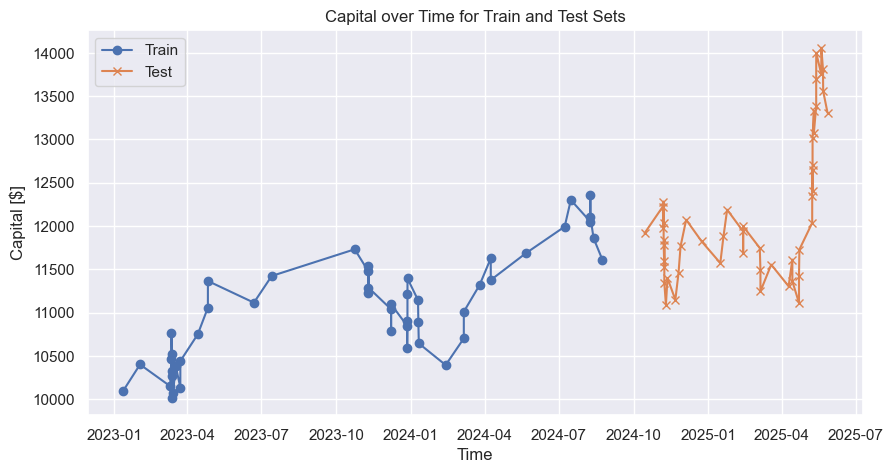

type           date_open          buy         sell  \
2023-01-11 22:20:00  Neutral 2023-01-11 21:00:00  1399.589966  1402.270020   
2023-02-01 21:30:00       TP 2023-02-01 20:40:00  1667.270020  1674.772735   
2023-03-10 22:10:00       SL 2023-03-10 22:00:00  1458.310059  1455.028861   
2023-03-12 14:10:00       TP 2023-03-12 13:55:00  1513.030029  1519.838664   
2023-03-12 14:30:00       TP 2023-03-12 14:15:00  1520.869995  1527.713910   
...                      ...                 ...          ...          ...   
2025-05-19 22:15:00       SL 2025-05-19 21:55:00  2550.929932  2545.190339   
2025-05-19 22:50:00       TP 2025-05-19 22:35:00  2553.469971  2564.960586   
2025-05-22 00:05:00       SL 2025-05-22 00:00:00  2609.409912  2603.538740   
2025-05-22 05:10:00       SL 2025-05-22 04:50:00  2655.100098  2649.126122   
2025-05-27 13:40:00       SL 2025-05-27 13:05:00  2679.370117  2673.341534   

                           gain       fees       capital  Train  
2023-01-11 22:20:00   94.285073  64.067808  10094.285073   True  
2023-02-01 21:30:00  307.980423  64.150540  10402.265496   True  
2023-03-10 22:10:00 -250.000000  63.934518  10152.265496   True  
2023-03-12 14:10:00  307.980423  64.150540  10460.245919   True  
2023-03-12 14:30:00  307.980423  64.150540  10768.226342   True  
...                         ...        ...           ...    ...  
2025-05-19 22:15:00 -250.000000  63.934518  13750.999784  False  
2025-05-19 22:50:00  307.980423  64.150540  14058.980207  False  
2025-05-22 00:05:00 -250.000000  63.934518  13808.980207  False  
2025-05-22 05:10:00 -250.000000  63.934518  13558.980207  False  
2025-05-27 13:40:00 -250.000000  63.934518  13308.980207  False  

[97 rows x 8 columns]

In [960]:
trade_signal_prob = pd.concat((y_pred_max_comb2_train, y_pred_max_comb2_test), axis=0)

df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral = (
    backtest(list_df, capital_init, step_max, 
             tp_ratio, risk_ratio, ratio_fees, R,
             trade_signal=trade_signal_prob)
)

print("Capital init [$]", capital_init)
print('final capital [$]:', capital)
print("ratio gain final [-]: ", (capital - capital_init)/capital_init)
print("Winrate [-] : ", nb_tp / (nb_tp + nb_sl + nb_neutral))
print("nb_tp: ", nb_tp)
print('capital_tp [$]: ', capital_tp)
print("nb_sl: ", nb_sl)
print('capital_sl [$]: ', capital_sl)
print('nb_neutral: ', nb_neutral)
print('capital_neutral [$]', capital_neutral)

# -129832.82
# add train test info from list_df[0]["Train"]
df_trades["Train"] = df_trades.index.isin(df_combined_condition[df_combined_condition['Train']].index)
# plot capital for train and test
plt.figure(figsize=(10, 5))
plt.plot(df_trades[df_trades["Train"]]["capital"], label="Train", marker="o")
plt.plot(df_trades[~df_trades["Train"]]["capital"], label="Test", marker="x")
plt.title("Capital over Time for Train and Test Sets")
plt.xlabel("Time")
plt.ylabel("Capital [$]")
plt.legend()
plt.grid(True)
plt.show()

#df_trades["capital"].plot(kind="line", figsize=(10, 5))
df_trades

# TODO

In [ ]:
# DONE : optimize corr calculation
# DONE : evaluate value of target_14 in term of real variation % between high and low 
# DONE : cross : find cat combinaison with most prob diff between high and low (linked to chi2 not always but a little)
# DONE : change algo for target cat : buy/sell with TP/SL = 2 (if +0.1% TP => -0.05% SL)
# DONE : past history: select the lags exponentially on the past history (not linear: example 5 min ago, 10 min, 20 min, 40 min, 1h20, 2h40, 5h20 ago)
# DONE : cross best over all lags : find cat combinaison with most prob diff between high and low (linked to chi2 ?)
# DONE : check temporal repartition of interesting events
# DONE : maybe have a threshold on target instead of quantiles?
# DONE : test another target : maybe the max/min value on all targets to have ony 2 targets
# DONE : cross prob with selected features with best corr with targets
# DONE : cross prob with selected features with best chi2 with targets
# DONE : machine learning classification with selected features with RandomForest 
# DONE : Take best cross prob (3 feat) and check when several occurs on same time to see if prob increase
# DONE : change prob model (particularly threshold) to have same 10 trades per day minimum and best precision
# DONE : Check Max prob Model limited to 100 best probs : why same results compared to without limit mode? 
# DONE : Add check comb2 model with Max prob or mean prob mdl (using 6 events (2*3 comb event))
# DONE : Change to price dependant features for ATR indices and z-score ETH
# DONE : Redo study by limited cat features (27000 max) with TRAIN/TEST split ? 
# DONE : ML study on precision on all limited cat features (max 27000 comb event cat) with best ML model : RF, XGBoost, KNN ...
# DONE : Same ML Study on all features (not comb event cat features) with best ML model : RF, XGBoost, KNN ...
# DONE : Clustering on train data with normal features (no feat categories) to find clusters with high/low/neutral targets ?
# DONE : Backstest : baseline : check fees impact
# DONE : Fix target TP / SL with High / Low : the intersection between low/high not empty !
# DONE : new realistic target on 1 hour ? new tp ratio = 0.45% and R=2
# DONE : fix backtest with time range of 1h15 ?
# DONE : On backtest, check some trade on validate input output data to be sure of logic
# DONE : for clustering, add p_high_test to understand better the clusters (need > 2000-5000 ? events on TRAIN) : need trade of validation set (doesn't exist)
# DONE : fix script backtest buy and sell list size
# TODO : redo seperation of set : TRAIN / VALIDATION / TEST for all models and backtest : ML, Prob, Clustering 
# TODO : increase to 27000 selected 3-events-comb for strat 3
# TODO : new realistic target on 1 hour ? new tp ratio = 0.33% and R=2.5
# TODO : think about change to multicass with TP, SL, Neutral (instead of High Neutral Low) for ML learning
# TODO : think about a model to multiclass : High/Low/Neutral 
# DONE : backtest strat on df_train / df_test data with model RF
# TODO : backtest strat on df_train / df_test data with model High Prob Event ? data leak of test data ? redo on TRAIN only ?
# TODO : test with a 20/20/60 for feature cat : H/L/N instead of 10/10/80
# TODO : add as source : market profile and volume profile over several time-range with max, min, median of BTC and target ETH price
# TODO : create a new exploration notebook for a target of daily trading : (currently : 6 hours history to predict next 1h)
#        - find good time frame / PAST_HISTORY / FUTURE_TARGET
#        - find good target level (0.1% ?)

In [477]:
len(list_col_select)

109

In [478]:
list_past



[71, 70, 68, 64, 56, 40, 8]

In [479]:
# how many combinaison of 3 elements in len(list_col_select) * nb lags
nb_elements = len(list_col_select) * len(list_past)
nb_comb = nb_elements * (nb_elements-1) * (nb_elements-2)
nb_comb


442449966

It s too much

In [480]:
# how many combinaison of 3 elements in 40 selected comb (feat / lag) 
# (20 high target /20 low target and with max or min delta_prob)
nb_elements = 40
print(nb_elements, " elements")
nb_comb = nb_elements * (nb_elements-1) * (nb_elements-2)
nb_comb

40  elements


59280

Ok 